# Classifying sounds with HeAR and Wiki Commons Cough Data

This Colab notebook demonstrates how to use the HeAR (Health Acoustic Representations) model, directly from Hugging Face, to create and utilize embeddings from health-related audio. The notebook focuses on building a data-efficient cough classifier system using a small [Wikimedia Commons](https://commons.wikimedia.org/wiki/Commons:Welcome) dataset of relevant sounds.

Embeddings are compact, numerical representations of audio data that capture important features, making them suitable for training machine learning models with limited data and computational resources. Learn more about embeddings and their benefits at [this page](https://developers.google.com/health-ai-developer-foundations/hear).

#### Here's a breakdown of the notebook's steps:

1.  **Model Loading:** The HeAR model is loaded from the Hugging Face Hub (requires authentication with your Hugging Face account).

2.  **Dataset Creation:**
    *   **Wikimedia Commons Audio:** A small set of audio files is downloaded from Wikimedia Commons. This dataset includes examples of coughing, as well as other sounds like sneezing, breathing, laughter, and door knocking. The files are all publicly available under various Creative Commons licenses (details are available on Wikimedia Commons).
    *   **Microphone Recording:** The notebook provides functionality to record audio directly within Colab using your microphone. This allows you to add your own recordings to the dataset.

3.  **Embedding Generation:**
    *   **Preprocessing:** The downloaded and recorded audio files are loaded and processed using `librosa`. They are resampled to 16kHz (required by the HeAR model) and segmented into 2-second clips.
    *   **Inference:** The preprocessed 2-second audio clips are fed to the HeAR model to generate embeddings. Each clip produces a 512-dimensional HeAR embedding vector.
    *   **Visualization (Optional):** The notebook includes functions to display the audio waveform, Mel spectrogram, and an audio player for each file and its individual clips.

4.  **Classifier Training:**
    *   **Labeling:** A set of labels is manually created, associating each audio file with whether it contains a cough or not. For example, `Cough_1.ogg` is labeled as `True`, while `Laughter.ogg` is labeled as `False`.
    *   **Model Selection:** Several scikit-learn classifiers are used and can easily be expanded, including:
        *   Support Vector Machine (linear kernel)
        *   Logistic Regression
        *   Gradient Boosting
        *   Random Forest
        *   Multi-layer Perceptron (MLP)
    *   **Training:** Each classifier is trained using the generated HeAR embeddings and the corresponding cough labels. This demonstrates the data efficiency of using embeddings – these models train quickly with very little data.

5.  **Cough Classification:**
    *   **Test on New Example:** Test the classfier on held out cough or non-cough sound examples.
    *   **Test on New Recording:** The microphone recording function is used again to capture a new audio clip (presumably of the user coughing or not coughing).
    *   **Prediction:** The new clip is preprocessed, its embedding is generated using the HeAR model, and then each of the trained classifiers is used to predict whether the clip contains a cough.

6.  **Embedding Visualization:**
    *   **PCA Plot:** A plot visualizing the data points in a PCA space is presented to show how similar sounds are grouped together, as they have similar embeddings.
    *   **Barcode Visualization:** The embeddings are visualized as "barcodes". Each embedding is displayed as a row in a heatmap, showing the magnitude of each dimension after subtracting the global mean. This provides a visual representation of the embedding's structure.


In [ ]:
import os

all_files = os.listdir("audios")

# Count .webm files
webm_files = [f for f in all_files if f.endswith('.webm')]
num_webm = len(webm_files)

# Search for the CSV
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
num_csv = len(csv_files)

print(f"Total de archivos .webm: {num_webm}")
print(f"Total de archivos .csv: {num_csv}")
print(f"Archivo CSV encontrado: {csv_files[0] if csv_files else 'No encontrado'}")

Total de archivos .webm: 1445
Total de archivos .csv: 1
Archivo CSV encontrado: Audium_Multilab_Covid_Master.csv


## Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

In [ ]:
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

## Setup HeAR Hugging Face Model

This section loads the **HeAR (Holistic Embeddings for Audio Representations)** model directly from Hugging Face using the `from_pretrained_keras` function. The model is used to convert audio clips into dense vector embeddings suitable for downstream classification.

- `SAMPLE_RATE`: Sampling rate of the audio input (16kHz).
- `CLIP_DURATION`: Duration of each audio clip to process (2 seconds).
- `CLIP_LENGTH`: Total number of audio samples per clip (32,000).

The loaded model exposes a `serving_default` signature that enables embedding generation via inference.

In [ ]:
from huggingface_hub import from_pretrained_keras

# Load the model directly from Hugging Face Hub
loaded_model = from_pretrained_keras("google/hear")
# Inference function for embedding generation
infer = loaded_model.signatures["serving_default"]

# HeAR Parameters
SAMPLE_RATE = 16000  # Samples per second (Hz)
CLIP_DURATION = 2    # Duration of the audio clip in seconds
CLIP_LENGTH = SAMPLE_RATE * CLIP_DURATION  # Total number of samples


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.24k [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/760k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/5.08k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/76.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/644k [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/340k [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/286 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.98M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

# Test Model Inference on Random Input
This block tests the HeAR model inference using **synthetic audio data** (random noise). It is useful for verifying that the embedding pipeline is working before using real audio clips.

- Generates `NUM_EXAMPLES` random audio clips of duration `CLIP_DURATION`.
- Each clip has shape `(CLIP_LENGTH,)` matching the expected input format.
- Passes the batch of audio clips to the HeAR model to extract embeddings.
- Outputs the shape and data type of the resulting embedding array.

This is a dry run to confirm that the model produces meaningful embeddings without requiring labeled data.

In [ ]:
# %%time
import numpy as np

# Generate Random Input Audio
NUM_EXAMPLES = 4  # number of random audio examples to generate
print(f"Generating {NUM_EXAMPLES} {CLIP_DURATION}s raw audio examples.")
raw_audio = np.random.normal(size=(NUM_EXAMPLES, CLIP_LENGTH))
print(f"Raw audio shape: {raw_audio.shape}, data type: {raw_audio.dtype}\n")

# Perform Inference Extract and Process the Embedding
print(f'Running HeAR model to produce {NUM_EXAMPLES} embeddings.')
output_dict = infer(x=raw_audio)
embedding = output_dict['output_0'].numpy()  # directly unpack as a NumPy array
print(f"Embedding shape: {embedding.shape}, data type: {embedding.dtype}")


NameError: name 'CLIP_DURATION' is not defined

## Download and Record Audio Data

 Wiki Commons
https://commons.wikimedia.org/wiki/Category:Coughing_audio


In [ ]:
files_map = {}  # file name to file path map
file_embeddings = {} # embedding cache

## Model Inference

This section defines utility functions for **visualizing audio waveforms and spectrograms** using `librosa` and `matplotlib`. These visual tools help in understanding the structure of the audio signals being processed.

- `plot_waveform(...)`: Plots the raw waveform of an audio clip.
- `plot_spectrogram(...)`: Plots the **Mel spectrogram**, a frequency representation commonly used in audio analysis.

Warnings from specific audio libraries are suppressed for cleaner outputs.

In [ ]:
# @title Plot Helpers
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import matplotlib.cm as cm
import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="soundfile")
warnings.filterwarnings("ignore", module="librosa")


def plot_waveform(sound, sr, title, figsize=(12, 4), color='blue', alpha=0.7):
  """Plots the waveform of the audio using librosa.display."""
  plt.figure(figsize=figsize)
  librosa.display.waveshow(sound, sr=sr, color=color, alpha=alpha)
  plt.title(f"{title}\nshape={sound.shape}, sr={sr}, dtype={sound.dtype}")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.grid(True)
  plt.tight_layout()
  plt.show()


def plot_spectrogram(sound, sr, title, figsize=(12, 4), n_fft=2048, hop_length=256, n_mels=128, cmap='nipy_spectral'):
  """Plots the Mel spectrogram of the audio using librosa."""
  plt.figure(figsize=figsize)
  mel_spectrogram = librosa.feature.melspectrogram(y=sound, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
  librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cmap)
  plt.title(f"{title} - Mel Spectrogram")
  plt.tight_layout()
  plt.show()


### Generate Unique File Identifiers from Metadata

This cell reads the master CSV file containing metadata for the audio samples and filters only those marked as **valid** (`Valid == "Yes"`). For each valid entry, it generates a **unique identifier** (used for matching with `.webm` files) by combining:

- the date (`YYYYMMDD`),
- the time (`HHMMSS`),
- the subject code,
- and the original filename.

Spaces are replaced with `%20` to ensure filename compatibility.

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("Audium_Multilab_Covid_Master.csv")  # Cambiar por la ruta de tu archivo CSV

# Filter rows where Valid == "Yes"
valid_rows = df[df["Valid"] == "Yes"].copy()

# Function to generate the unique code
def generate_code(row):
    # Convert and format date and time, tolerant to different formats
    date_str = pd.to_datetime(row["Date"]).strftime("%Y%m%d")
    time_str = pd.to_datetime(row["Time"]).strftime("%H%M%S")
    code = row["Code"]
    filename = row["Filename"]
    return f"{date_str}{time_str}_{code}{filename}".replace(" ", "%20")

# Generate the codes
valid_rows["Generated_Code"] = valid_rows.apply(generate_code, axis=1)

# Display or export the result
print(valid_rows[["Generated_Code"]])

                                  Generated_Code
0            20230424140556_GB%20fe-1_vocal.webm
1        20230424140556_GB%20fe-1_lungfront.webm
2         20230424140556_GB%20fe-1_lungback.webm
3            20230424140045_GA%20fe-1_vocal.webm
4        20230424140045_GA%20fe-1_lungfront.webm
...                                          ...
1627  20211202103821_Mcp-02-12-D2_lungfront.webm
1628   20211202103821_Mcp-02-12-D2_lungback.webm
1629      20211202103721_Mcp-02-12-D1_vocal.webm
1630  20211202103721_Mcp-02-12-D1_lungfront.webm
1631   20211202103721_Mcp-02-12-D1_lungback.webm

[1210 rows x 1 columns]


### Match Valid Audio Files

This section scans all `.webm` files in the current working directory and cross-references them against the list of valid entries generated from the metadata CSV. It builds a dictionary (`files_map`) containing only the filenames that are confirmed as valid, ensuring that subsequent processing is performed exclusively on approved and verified data samples.

In [ ]:
files_map = {}

for filename in os.listdir("audios"):
  if filename.endswith('.webm'):
    resultado = valid_rows[valid_rows["Generated_Code"] == filename]
    if len(resultado) > 0:
      files_map[filename] = filename

# # Mostrar solo los nombres de archivos que fueron validados exitosamente
# print("Archivos .webm validados encontrados:\n")
# for filename in files_map:
#     print(f"- {filename}")

print(f"\nTotal de archivos validados: {len(files_map)}")

NameError: name 'os' is not defined

# Load Audio and Generate HeAR Embeddings

This section loads each validated .webm audio file, segments it into overlapping clips, filters out silent ones, and generates embeddings using the HeAR model.

Adjustable parameters:
- `CLIP_DURATION`: Length (in seconds) of each audio clip. Affects how much context each embedding captures.
- `CLIP_OVERLAP_PERCENT`: Percentage of overlap between consecutive clips. Higher values increase redundancy, useful for smoother transitions.
- `CLIP_IGNORE_SILENT_CLIPS`: Whether to skip clips that are too quiet (boolean).
- `SILENCE_RMS_THRESHOLD_DB`: Silence threshold in decibels. Clips below this average loudness are ignored if CLIP_IGNORE_SILENT_CLIPS is True.
- `SHOW_WAVEFORM`, `SHOW_SPECTROGRAM`, `SHOW_PLAYER`, `SHOW_CLIPS`: Toggle options for waveform plots, spectrograms, audio players, and clip previews.



In [ ]:
# %%time
# Audio display options
SHOW_WAVEFORM = False
SHOW_SPECTROGRAM = False
SHOW_PLAYER = False
SHOW_CLIPS = False

# Clips of length CLIP_DURATION seconds are extracted from the audio file
# using a sliding window. Adjecent clips are overlapped by CLIP_OVERLAP_PERCENT.
CLIP_OVERLAP_PERCENT = 10

# When True, if a clip extracted from the file is quieter than
# the SILENCE_RMS_THRESHOLD_DB it is not sent to the HeAR model.
CLIP_IGNORE_SILENT_CLIPS = True
# Maximum average amplitude of a frame to be considered silence.
SILENCE_RMS_THRESHOLD_DB = -50

# Inicializar contadores globales
total_files_processed = 0
total_clips_seen = 0
total_clips_kept = 0

for file_key, file_url in files_map.items():
  try:
      full_path = os.path.join("audios", file_key)
      print(f"\nLoading file: {file_key} from {full_path}")
      audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
  except Exception as e:
      print(f"Error loading {file_key}: {e}. Removing from files_map.")
      files_map[file_key] = "error"
      continue


  # Display audio file (optional)
  if SHOW_WAVEFORM:
    plot_waveform(audio, sample_rate, title=file_key, color='blue')
  if SHOW_SPECTROGRAM:
    plot_spectrogram(audio, sample_rate, file_key,  n_fft=2*1024, hop_length=64, n_mels=256, cmap='Blues')
  if SHOW_PLAYER:
    display(Audio(data=audio, rate=sample_rate))

  # This code segments an audio array into overlapping clips.
  # It calculates the number of clips, iterates through them,
  # and handles potential padding with zeros for the last clip if needed.
  clip_batch = []
  overlap_samples = int(CLIP_LENGTH * (CLIP_OVERLAP_PERCENT / 100))
  step_size = CLIP_LENGTH - overlap_samples
  num_clips = max(1, (len(audio) - overlap_samples) // step_size)
  print(f" Segmenting into {num_clips} {CLIP_DURATION}s clips")

  total_files_processed += 1
  total_clips_seen += num_clips

  for i in range(num_clips):
    start_sample = i * step_size
    end_sample = start_sample + CLIP_LENGTH
    clip = audio[start_sample:end_sample]
    # Pad clip with zeros if less than the required CLIP_LENGTH.
    if end_sample > len(audio):
        print("  Last clip: Padding with zeros.")
        clip = np.pad(clip, (0, CLIP_LENGTH - len(clip)), 'constant')
    # Average Loudness of the clip(in dB)
    power = np.mean(clip**2)
    if power == 0:
        rms_loudness = -np.inf
    else:
        rms_loudness = round(20 * np.log10(np.sqrt(power)))
    # rms_loudness =  round(20 * np.log10(np.sqrt(np.mean(clip**2))))

    # Display clip info (optional)
    clip_str = f"Clip {i+1} from {file_key} [loudness: {rms_loudness} dB]"
    print(f"  {clip_str}")
    if SHOW_CLIPS:
      if SHOW_WAVEFORM:
        plot_waveform(clip, sample_rate, title=clip_str, figsize=(8, 3), color=cm.rainbow(i /num_clips))
      if SHOW_PLAYER:
        display(Audio(data=clip, rate=sample_rate))

    # Skip if clip is too quiet
    if CLIP_IGNORE_SILENT_CLIPS and rms_loudness < SILENCE_RMS_THRESHOLD_DB:
      print(f"  Clip {i+1} Skip...too quiet [loudness: {rms_loudness} dB]")
      continue

    # Add clip to batch
    clip_batch.append(clip)
    total_clips_kept += 1


  # Perform HeAR Batch inference to extract the associated clip embedding.
  # Only run inference if embedding not already in file_embedding cache.
  if len(clip_batch) == 0:
    print("  No valid clips found after silence filtering. Skipping inference.")
    continue
  clip_batch = np.asarray(clip_batch)
  if file_key not in file_embeddings:
    print("  Clip not in cache, performing inference...")
    embedding_batch = infer(x=clip_batch)['output_0'].numpy()
    file_embeddings[file_key] = embedding_batch
  else:
    embedding_batch = file_embeddings[file_key]
  print(f"  Embedding batch shape: {embedding_batch.shape}, data type: {embedding_batch.dtype}")

# 🔚 Mostrar resumen al final del proceso
print("\n RESUMEN FINAL:")
print(f"Archivos procesados: {total_files_processed}")
print(f"Clips generados (antes de filtrar): {total_clips_seen}")
print(f"Clips útiles (post-filtrado): {total_clips_kept}")
print(f"Clips descartados por silencio: {total_clips_seen - total_clips_kept}")


Loading file: 20220212082327_Mmm%2024-1_lungback.webm from audios/20220212082327_Mmm%2024-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 2 Skip...too quiet [loudness: -58 dB]
  Clip 3 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 3 Skip...too quiet [loudness: -58 dB]
  Clip 4 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 7 Skip...too quiet [loudness: -58 dB]
  Clip 8 from 20220212082327_Mmm%2024-1_lungback.webm [loudness: -58 dB]
  Clip 8 Skip...too quiet [loudness: -58 dB]
  Clip 9 from 20220212082327

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 9 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20230419115012_LA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220125112846_DAKP%20fe_vocal.webm from audios/20220125112846_DAKP%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212070508_Jmt%2017-1_lungfront.webm from audios/20220212070508_Jmt%2017-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -53 dB]
  Clip 2 Skip...too quiet [loudness: -53 dB]
  Clip 3 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -63 dB]
  Clip 4 Skip...too quiet [loudness: -63 dB]
  Clip 5 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -47 dB]
  Clip 6 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -42 dB]
  Clip 7 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -43 dB]
  Clip 8 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -42 dB]
  Clip 9 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -47 dB]
  Clip 10 from 20220212070508_Jmt%2017-1_lungfront.webm [loudness: -53 dB]
  Clip 10 Skip...too quiet [loudness: -53 dB]
  Cl

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220303082932_ACH%20fe%203-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220303082932_ACH%20fe%203-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220303082932_ACH%20fe%203-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220303082932_ACH%20fe%203-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220127153448_RAJL%20es_vocal.webm from audios/20220127153448_RAJL%20es_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220127153448_RAJL%20es_vocal.webm [loudness: -50 dB]
  Clip 2 from 20220127153448_RAJL%20es_vocal.webm [loudness: -42 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220111120259_RARN_lungback.webm from audios/20220111120259_RARN_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220111120259_RARN_lungback.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220111120259_RARN_lungback.webm [loudness: -82 dB]
  Clip 2 Skip...too quiet [loudness: -82 dB]
  Clip 3 from 20220111120259_RARN_lungback.webm [loudness: -80 dB]
  Clip 3 Skip...too quiet [loudness: -80 dB]
  Clip 4 from 20220111120259_RARN_lungback.webm [loudness: -86 dB]
  Clip 4 Skip...too quiet [loudness: -86 dB]
  Clip 5 from 20220111120259_RARN_lungback.webm [loudness: -78 dB]
  Clip 5 Skip...too quiet [loudness: -78 dB]
  Clip 6 from 20220111120259_RARN_lungback.webm [loudness: -78 dB]
  Clip 6 Skip...too quiet [loudness: -78 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220503163043_Jonathan%202_vocal.webm from audios/20220503163043_Jo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220503163043_Jonathan%202_vocal.webm [loudness: -24 dB]
  Clip 2 from 20220503163043_Jonathan%202_vocal.webm [loudness: -33 dB]
  Clip 3 from 20220503163043_Jonathan%202_vocal.webm [loudness: -29 dB]
  Clip 4 from 20220503163043_Jonathan%202_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220126113139_BMY%20es_vocal.webm from audios/20220126113139_BMY%20es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220126113139_BMY%20es_vocal.webm [loudness: -49 dB]
  Clip 2 from 20220126113139_BMY%20es_vocal.webm [loudness: -46 dB]
  Clip 3 from 20220126113139_BMY%20es_vocal.webm [loudness: -39 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220709054715_CNE%20fe-1_lungfront.webm from audios/20220709054715_CNE%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -30 dB]
  Clip 3 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 7 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 8 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 9 from 20220709054715_CNE%20fe-1_lungfront.webm [loudness: -30 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220120153840_GCNF_lungfront.webm from audios/20220120153840_GCNF_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220120153840_GCNF_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220120153840_GCNF_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220120153840_GCNF_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220120153840_GCNF_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220120153840_GCNF_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20220120153840_GCNF_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220219084905_MGCH%2030-1_vocal.webm from audios/20220219084905_MGCH%2030-1_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220219084905_MGCH%2030-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220219084905_MGCH%2030-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20230420094226_GCH%20fe-1_lungback.webm from audios/20230420094226_GCH%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 10 from 20230420094226_GCH%20fe-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220121165452_STDCP_vocal.webm from audios/20220121165452_STDCP_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 2022012

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220111120259_RARN_lungfront.webm from audios/20220111120259_RARN_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220111120259_RARN_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220111120259_RARN_lungfront.webm [loudness: -37 dB]
  Clip 3 from 20220111120259_RARN_lungfront.webm [loudness: -73 dB]
  Clip 3 Skip...too quiet [loudness: -73 dB]
  Clip 4 from 20220111120259_RARN_lungfront.webm [loudness: -59 dB]
  Clip 4 Skip...too quiet [loudness: -59 dB]
  Clip 5 from 20220111120259_RARN_lungfront.webm [loudness: -73 dB]
  Clip 5 Skip...too quiet [loudness: -73 dB]
  Clip 6 from 20220111120259_RARN_lungfront.webm [loudness: -76 dB]
  Clip 6 Skip...too quiet [loudness: -76 dB]
  Clip 7 from 20220111120259_RARN_lungfront.webm [loudness: -82 dB]
  Clip 7 Skip...too quiet [loudness: -82 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220302092223_CCP%20fe%202-1_vocal.webm from audios/20220302092223_CCP%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302092223_CCP%20

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220128110857_MCFF%20FE_lungback.webm from audios/20220128110857_MCFF%20FE_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128110857_MCFF%20FE_lungback.webm [loudness: -50 dB]
  Clip 2 from 20220128110857_MCFF%20FE_lungback.webm [loudness: -50 dB]
  Clip 3 from 20220128110857_MCFF%20FE_lungback.webm [loudness: -50 dB]
  Clip 4 from 20220128110857_MCFF%20FE_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220128110857_MCFF%20FE_lungback.webm [loudness: -63 dB]
  Clip 5 Skip...too quiet [loudness: -63 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220212063005_Ach%2014-2_lungfront.webm from audios/20220212063005_Ach%2014-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -44 dB]
  Clip 2 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -51 dB]
  Clip 2 Skip...too quiet [loudness: -51 dB]
  Clip 3 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -34 dB]
  Clip 4 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -41 dB]
  Clip 5 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -43 dB]
  Clip 6 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -37 dB]
  Clip 7 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  Clip 8 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -43 dB]
  Clip 9 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -38 dB]
  Clip 10 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -39 dB]
  Clip 11 from 20220212063005_Ach%2014-2_lungfront.webm [loudness: -40 dB]
  Clip 12 from 20220212063005_Ach%2014-2_lungfront.webm [loudness

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220122153938_MSVC%20es_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220122153938_MSVC%20es_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20220122153938_MSVC%20es_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220122153938_MSVC%20es_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220122153938_MSVC%20es_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230418114816_TE%20fe-1_lungfront.webm from audios/20230418114816_TE%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 10 from 20230418114816_TE%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221223095759_Fe-2%20GB_lungfront.webm from audios/20221223095759_Fe-2%20GB_lungfront.webm
 Segmenting into 9 2s clips
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220303091025_JAR%20fe%203-1_lungfront.webm from audios/20220303091025_JAR%20fe%203-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -30 dB]
  Clip 4 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220303091025_JAR%20fe%203-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220516145612_Leco1-16-5_lungback.webm from audios/20220516145612_Leco1-16-5_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220516145612_Leco1-16-5_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220516145612_Leco1-16-5_l

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220119161535_SNPC_lungfront.webm from audios/20220119161535_SNPC_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119161535_SNPC_lungfront.webm [loudness: -97 dB]
  Clip 1 Skip...too quiet [loudness: -97 dB]
  Clip 2 from 20220119161535_SNPC_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220119161535_SNPC_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220119161535_SNPC_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220119161535_SNPC_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220506051857_Abemn%206-5-22_lungfront.webm from audios/20220506051857_Abemn%206-5-22_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -15 dB]
  Clip 9 from 20220506051857_Abemn%206-5-22_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212071122_Tvs%2018-2_lungfront.webm from audios/20220212071122_Tvs%2018-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -38 dB]
  Clip 2 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -47 dB]
  Clip 3 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -48 dB]
  Clip 4 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -47 dB]
  Clip 5 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -44 dB]
  Clip 6 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -54 dB]
  Clip 6 Skip...too quiet [loudness: -54 dB]
  Clip 7 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -43 dB]
  Clip 8 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -36 dB]
  Clip 9 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -49 dB]
  Clip 10 from 20220212071122_Tvs%2018-2_lungfront.webm [loudness: -43 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128124525_SCSHR%20fE_vocal.webm from audios/20220128124525_SCSHR%2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221118094140_Fe-1%20JG_lungback.webm from audios/20221118094140_Fe-1%20JG_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -16 dB]
  Clip 2 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -22 dB]
  Clip 3 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -18 dB]
  Clip 4 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -19 dB]
  Clip 5 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -18 dB]
  Clip 6 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -18 dB]
  Clip 7 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -19 dB]
  Clip 8 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -16 dB]
  Clip 9 from 20221118094140_Fe-1%20JG_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220215080924_MME%2028-1_lungback.webm from audios/20220215080924_MME%2028-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220215080924_MME%2028-1_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220215080924_MME%2028-1_lungback.webm [loudness: -54 dB]
  Clip 2 Skip...too quiet [loudness: -54 dB]
  Clip 3 from 20220215080924_MME%2028-1_lungback.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220215080924_MME%2028-1_lungback.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20220215080924_MME%2028-1_lungback.webm [loudness: -56 dB]
  Clip 5 Skip...too quiet [loudness: -56 dB]
  Clip 6 from 20220215080924_MME%2028-1_lungback.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220215080924_MME%2028-1_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [lou

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220516150924_Mfyc1-16-5_lungback.webm from audios/20220516150924_Mfyc1-16-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -12 dB]
  Clip 5 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -14 dB]
  Clip 7 from 20220516150924_Mfyc1-16-5_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220127103801_CHLA%20es_vocal.webm from audios/20220127103801_CHLA%20es_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220127103801_CHLA%20es_vocal.webm [loudness: -44 dB]
  Clip 2 from 20220127103801_CHLA%20es_vocal.webm [loudness: -49 dB]
  Clip 3 from 20220127103801_CHLA%20es_vocal.webm [loudness: -41 dB]
  Clip 4 from 20220127103801_CHLA%20es_vocal.webm [loudness: -46 dB]
  Clip 5 from 20220127103801_CHLA%20es_vocal.webm [loudness: -47 dB]
  Clip 6 from 20220127103801_CHLA%20es_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516145612_Leco1-16-5_vocal.webm from audios/20220516145612_Leco1-16-5_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220516145612_Leco1-16-5_vocal.webm [loudness: -71 dB]
  Clip 1 Skip...too quiet [loudness: -71 dB]
  Clip 2 from 20220516145612_Leco1-16-5_vocal.webm [loudness: -76 dB]
  Clip 2 Skip...too quiet [loudness: -76 dB]
  Clip 3 from 20220516145612_Leco1-16-5_vocal.webm [loudness: -75 dB]
  Clip 3 Skip...too quiet [lou

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20220127113235_NRJJ%20Fe_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220303081659_RRA%20fe%203-1_vocal.webm from audios/20220303081659_RRA%20fe%203-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220303081659_RRA%20fe%203-1_vocal.webm [loudness: -17 dB]
  Clip 2 from 20220303081659_RRA%20fe%203-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220303081659_RRA%20fe%203-1_vocal.webm [loudness: -12 dB]
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220115122413_RRB_lungback.webm from audios/20220115122413_RRB_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220115122413_RRB_lungback.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220115122413_RRB_lungback.webm [loudness: -71 dB]
  Clip 2 Skip...too quiet [loudness: -71 dB]
  Clip 3 from 20220115122413_RRB_lungback.webm [loudness: -104 dB]
  Clip 3 Skip...too quiet [loudness: -104 dB]
  Clip 4 from 20220115122413_RRB_lungback.webm [loudness: -49 dB]
  Clip 5 from 20220115122413_RRB_lungback.webm [loudness: -46 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212065052_ATC%2017-1_lungfront.webm from audios/20220212065052_ATC%2017-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 14 2s clips
  Clip 1 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -73 dB]
  Clip 2 Skip...too quiet [loudness: -73 dB]
  Clip 3 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -41 dB]
  Clip 4 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -66 dB]
  Clip 5 Skip...too quiet [loudness: -66 dB]
  Clip 6 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -66 dB]
  Clip 6 Skip...too quiet [loudness: -66 dB]
  Clip 7 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -62 dB]
  Clip 7 Skip...too quiet [loudness: -62 dB]
  Clip 8 from 20220212065052_ATC%2017-1_lungfront.webm [loudness: -67 dB]
  Clip 8 Skip...too quiet [loudness: -67 dB]
  Clip 9 from 20220212065052_ATC%2017-1_lungfront.webm [loudness

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220319095643_MAR%20fe%2019-1_vocal.webm from audios/20220319095643_MAR%20fe%2019-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220319095643_MAR%20fe%2019-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220319095643_MAR%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220319095643_MAR%20fe%2019-1_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220319095643_MAR%20fe%2019-1_vocal.webm [loudness: -41 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319073711_PRC%20fe%2019-1_lungback.webm from audios/20220319073711_PRC%20fe%2019-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -24 dB]
  Clip 6 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -26 dB]
  Clip 8 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20220319073711_PRC%20fe%2019-1_lungback.webm [loudness: -31 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124102435_ARJA%20es_lungfront.webm from audios/20220124102435_ARJA%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124102435_ARJA%20es_lungfront.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220124102435_ARJA%20es_lungfront.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220124102435_ARJA%20es_lungfront.webm [loudness: -62 dB]
  Clip 3 Skip...too quiet [loudness: -62 dB]
  Clip 4 from 20220124102435_ARJA%20es_lungfront.webm [loudness: -80 dB]
  Clip 4 Skip...too quiet [loudness: -80 dB]
  Clip 5 from 20220124102435_ARJA%20es_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20211209064137_JMT-P_vocal.webm from audios/20211209064137_JMT-P_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20211209064137_JMT-P_vocal.webm [loudness: -30 dB]
  Clip 2 from 20211209064137_JMT-P_vocal.webm [loudness: -29 dB]
  Clip 3 from 20211209064137_JMT-P_vocal.webm [loudness: -23 dB]
  Clip 4 from 20211209064137_JMT-P_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212063501_Acb%2015-1_lungfront.webm from audios/20220212063501_Acb%2015-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -66 dB]
  Clip 1 Skip...too quiet [loudness: -66 dB]
  Clip 2 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -65 dB]
  Clip 2 Skip...too quiet [loudness: -65 dB]
  Clip 3 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -63 dB]
  Clip 4 Skip...too quiet [loudness: -63 dB]
  Clip 5 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -65 dB]
  Clip 5 Skip...too quiet [loudness: -65 dB]
  Clip 6 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -58 dB]
  Clip 7 Skip...too quiet [loudness: -58 dB]
  Clip 8 from 20220212063501_Acb%2015-1_lungfront.webm [loudness: -63 dB]
  Clip 8 Skip...too quiet [loudness: -63 dB]
  Clip 9 from 20220

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122140243_MRGM%20fe_lungback.webm from audios/20220122140243_MRGM%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122140243_MRGM%20fe_lungback.webm [loudness: -11 dB]
  Clip 2 from 20220122140243_MRGM%20fe_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220122140243_MRGM%20fe_lungback.webm [loudness: -10 dB]
  Clip 4 from 20220122140243_MRGM%20fe_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220122140243_MRGM%20fe_lungback.webm [loudness: -10 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220107152508_RCET_lungback.webm from audios/20220107152508_RCET_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220107152508_RCET_lungback.webm [loudness: -70 dB]
  Clip 1 Skip...too quiet [loudness: -70 dB]
  Clip 2 from 20220107152508_RCET_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220107152508_RCET_lungback.webm [loudness: -64 dB]
  Clip 3 Skip...too quiet [loudness: -64 dB]
  Clip 4 from 20220107152508_RCET_lungback.webm [loudness: -64 dB]
  Clip 4 Skip...too quiet [loudness: -64 dB]
  Clip 5 from 20220107152508_RCET_lungback.webm [loudness: -66 dB]
  Clip 5 Skip...too quiet [loudness: -66 dB]
  Clip 6 from 20220107152508_RCET_lungback.webm [loudness: -65 dB]
  Clip 6 Skip...too quiet [loudness: -65 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220516151109_Mfyc2-16-5_vocal.webm from audios/20220516151109_Mfyc2-16-5_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220516151109_Mfyc2-16-5_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220516151109_Mfyc

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220128124349_SCSHR%20Fe_lungback.webm from audios/20220128124349_SCSHR%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128124349_SCSHR%20Fe_lungback.webm [loudness: -90 dB]
  Clip 1 Skip...too quiet [loudness: -90 dB]
  Clip 2 from 20220128124349_SCSHR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220128124349_SCSHR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220128124349_SCSHR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220128124349_SCSHR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20221118094140_Fe-1%20JG_vocal.webm from audios/20221118094140_Fe-1%20JG_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20221118094140_Fe-1%20JG_vocal.webm [loudness: -12 dB]
  Clip 2 from 20221118094140_Fe-1%20JG_vocal.webm [loudness: -12 dB]
  Clip 3 from 20221118094140_Fe-1%20JG_vocal.webm [loudness: -15 dB]
  Clip 4 from 20221118094140_Fe-1%20JG_vocal.webm [loudness: -42 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220715101331_RFC%20fe-3_lungback.webm from audios/20220715101331_RFC%20fe-3_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220715101331_RFC%20fe-3_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220715101331_RFC%20fe-3_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220715101331_RFC%20fe-3_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220715101331_RFC%20fe-3_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220715101331_RFC%20fe-3_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220715101331_RFC%20fe-3_lungback.webm [loudness: -22 dB]
  Clip 7 from 2022071510

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209064407_JMT-P3_lungback.webm from audios/20211209064407_JMT-P3_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209064407_JMT-P3_lungback.webm [loudness: -36 dB]
  Clip 2 from 20211209064407_JMT-P3_lungback.webm [loudness: -32 dB]
  Clip 3 from 20211209064407_JMT-P3_lungback.webm [loudness: -35 dB]
  Clip 4 from 20211209064407_JMT-P3_lungback.webm [loudness: -40 dB]
  Clip 5 from 20211209064407_JMT-P3_lungback.webm [loudness: -43 dB]
  Clip 6 from 20211209064407_JMT-P3_lungback.webm [loudness: -28 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220604055424_JFC%20fe-1_lungfront.webm from audios/20220604055424_JFC%20fe-1_lungfront.webm
Error loading 20220604055424_JFC%20fe-1_lungfront.webm: . Removing from files_map.

Loading file: 20230418102811_LR%20fe-1_lungfront.webm from audios/20230418102811_LR%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 9 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 10 from 20230418102811_LR%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220304082514_SAC%20fe%204-1_vocal.webm from audios/20220304082514_SAC%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20221207100112_Fe-1%20WC_vocal.webm from audios/20221207100112_Fe-1%20WC_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20221207100112_Fe-1%20WC_vocal.webm [loudness: -12 dB]
  Clip 2 from 20221207100112_Fe-1%20WC_vocal.webm [loudness: -13 dB]
  Clip 3 from 20221207100112_Fe-1%20WC_vocal.webm [loudness: -16 dB]
  Clip 4 from 20221207100112_Fe-1%20WC_vocal.webm [loudness: -17 dB]
  Clip 5 from 20221207100112_Fe-1%20WC_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220709073837_RCM%20fe-3_lungback.webm from audios/20220709073837_RCM%20fe-3_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220709073837_RCM%20fe-3_lungback.webm [loudness: -26 dB]
  Clip 2 from 20220709073837_RCM%20fe-3_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220709073837_RCM%20fe-3_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220709073837_RCM%20fe-3_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220709073837_RCM%20fe-3_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220709073837

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124160502_RALL%20es_lungfront.webm from audios/20220124160502_RALL%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124160502_RALL%20es_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220124160502_RALL%20es_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220124160502_RALL%20es_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220124160502_RALL%20es_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220124160502_RALL%20es_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220718073538_RM%20fe-1_vocal.webm from audios/20220718073538_RM%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220718073538_RM%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220718073538_RM%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220718073538_RM%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220718073538_RM%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 5 from 20220718073538_RM%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220128110857_MCFF%20FE_lungfront.webm from audios/20220128110857_MCFF%20FE_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128110857_MCFF%20FE_lungfront.webm [loudness: -76 dB]
  Clip 1 Skip...too quiet [loudness: -76 dB]
  Clip 2 from 20220128110857_MCFF%20FE_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220128110857_MCFF%20FE_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220128110857_MCFF%2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -19 dB]
  Clip 2 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -16 dB]
  Clip 3 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -17 dB]
  Clip 4 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -17 dB]
  Clip 5 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -22 dB]
  Clip 6 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -19 dB]
  Clip 7 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -19 dB]
  Clip 8 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -20 dB]
  Clip 9 from 20221223095536_Fe-1%20GB_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220504165919_ETA%204-5_lungback.webm from audios/20220504165919_ETA%204-5_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220504165919_ETA%204-5_lungback.webm [loudness: -22 dB]
  Clip 2 from 202205

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230424133743_JA%20fe-1_lungback.webm from audios/20230424133743_JA%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 11 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 12 from 20230424133743_JA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (12, 512), data type: float32

Loa

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 8 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 9 from 20220721062840_ICR%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124151015_JAYG%20es_lungfront.webm from audios/20220124151015_JAYG%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124151015_JAYG%20es_lungfront.webm [loudness: -79 dB]

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220319061032_ECO%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220319061032_ECO%20fe%2019-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220319061032_ECO%20fe%2019-1_vocal.webm [loudness: -27 dB]
  Clip 4 from 20220319061032_ECO%20fe%2019-1_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220319061032_ECO%20fe%2019-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220212072243_Lml%2020-1_lungback.webm from audios/20220212072243_Lml%2020-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -46 dB]
  Clip 2 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -48 dB]
  Clip 3 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -48 dB]
  Clip 5 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -43 dB]
  Clip 6 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -67 dB]
  Clip 6 Skip...too quiet [loudness: -67 dB]
  Clip 7 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -61 dB]
  Clip 7 Skip...too quiet [loudness: -61 dB]
  Clip 8 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -44 dB]
  Clip 9 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -59 dB]
  Clip 9 Skip...too quiet [loudness: -59 dB]
  Clip 10 from 20220212072243_Lml%2020-1_lungback.webm [loudness: -56 dB]
  Clip 10 Skip...too quiet [loudness: -56 dB]
  Clip 11 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220128104342_AASE%20fe%201_lungfront.webm from audios/20220128104342_AASE%20fe%201_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128104342_AASE%20fe%201_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220128104342_AASE%20fe%201_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220128104342_AASE%20fe%201_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220128104342_AASE%20fe%201_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220128104342_AASE%20fe%201_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220303082932_ACH%20fe%203-1_lungback.webm from audios/20220303082932_ACH%20fe%203-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -14 dB]
  Clip 8 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -26 dB]
  Clip 9 from 20220303082932_ACH%20fe%203-1_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209063621_JMT-D3_lungfront.webm from audios/20211209063621_JMT-D3_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20211209063621_JMT-D3_lungfront.webm [loudness: -41 dB]
  Clip 2 from 20211209063621_JMT-D3_lungfront.webm [loudness: -58 dB]
  Clip 2 Skip...too quiet [loudness: -58 dB]
  Clip 3 from 20211209063621_JMT-D3_lungfront.webm [loudness: -52 dB]
  Clip 3 Skip...too quiet [loudness: -52 dB]
  Clip 4 from 20211209063621_JMT-D3_lungfront.webm [loudness: -39 dB]
  Clip 5 from 20211209063621_JMT-D3_lungfront.webm [loudness: -32 dB]
  Clip 6 from 20211209063621_JMT-D3_lungfront.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20211209063621_JMT-D3_lungfront.webm [loudness: -56 dB]
  Clip 7 Skip...too quiet [loudness: -56 dB]
  Clip 8 from 20211209063621_JMT-D3_lungfront.webm [loudness: -49 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230424140556_GB%20fe-1_lungback.webm from audios/20230424140556_GB%20fe-1_lungback.webm
 Segmenting into 10 2s clips

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221118053800_Fe-1%20SD_lungback.webm from audios/20221118053800_Fe-1%20SD_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -21 dB]
  Clip 2 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -25 dB]
  Clip 3 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -15 dB]
  Clip 4 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -20 dB]
  Clip 5 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -14 dB]
  Clip 6 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -16 dB]
  Clip 7 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -22 dB]
  Clip 8 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -17 dB]
  Clip 9 from 20221118053800_Fe-1%20SD_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211202103821_Mcp-02-12-D2_lungback.webm from audios/20211202103821_Mcp-02-12-D2_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202103821_Mcp-02-12-D2_lungback.webm [loudness: -11 dB]
  Clip 2 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220708093145_ARB%20fe-4_lungfront.webm from audios/20220708093145_ARB%20fe-4_lungfront.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -31 dB]
  Clip 4 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -26 dB]
  Clip 10 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: -20 dB]
  Clip 11 from 20220708093145_ARB%20fe-4_lungfront.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220105133843_YH%20sin_lungback.webm from audios/20220105133843_YH%20sin_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220105133843_YH%20sin_lungback.webm [loudness: -81 dB]
  Clip 1 Skip...too quiet [loudness: -81 dB]
  Clip 2 from 20220105133843_YH%20sin_lungback.webm [loudness: -77 dB]
  Clip 2 Skip...too quiet [loudness: -77 dB]
  Clip 3 from 20220105133843_YH%20sin_lungback.webm [loudness: -83 dB]
  Clip 3 Skip...too quiet [loudness: -83 dB]
  Clip 4 from 20220105133843_YH%20sin_lungback.webm [loudness: -84 dB]
  Clip 4 Skip...too quiet [loudness: -84 dB]
  Clip 5 from 20220105133843_YH%20sin_lungback.webm [loudness: -83 dB]
  Clip 5 Skip...too quiet [loudness: -83 dB]
  Clip 6 from 20220105133843_YH%20sin_lungback.webm [loudness: -83 dB]
  Clip 6 Skip...too quiet [loudness: -83 dB]
  Clip 7 from 20220105133843_YH%20sin_lungback.webm [loudness: -83 dB]
  Clip 7 Skip...too quiet [loudness: -83 dB]
  Clip 8 from 20220105133843_YH%20sin_lungback.webm [loudness: -81 dB]
  Clip 8 Skip...too quiet [loudness: -81 dB]
  Clip 9 from 20220105133843_YH%20sin_lungb

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220105152805_GUF%20con_vocal.webm from audios/20220105152805_GUF%20con_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220105152805_GUF%20con_vocal.webm [loudness: -33 dB]
  Clip 2 from 20220105152805_GUF%20con_vocal.webm [loudness: -40 dB]
  Clip 3 from 20220105152805_GUF%20con_vocal.webm [loudness: -45 dB]
  Clip 4 from 20220105152805_GUF%20con_vocal.webm [loudness: -23 dB]
  Clip 5 from 20220105152805_GUF%20con_vocal.webm [loudness: -21 dB]
  Clip 6 from 20220105152805_GUF%20con_vocal.webm [loudness: -27 dB]
  Clip 7 from 20220105152805_GUF%20con_vocal.webm [loudness: -20 dB]
  Clip 8 from 20220105152805_GUF%20con_vocal.webm [loudness: -23 dB]
  Clip 9 from 20220105152805_GUF%20con_vocal.webm [loudness: -25 dB]
  Clip 10 from 20220105152805_GUF%20con_vocal.webm [loudness: -39 dB]
  Clip 11 from 20220105152805_GUF%20con_vocal.webm [loudness: -25 dB]
  Clip 12 from 20220105152805_GUF%20con_vocal.webm [loudness: -22 dB]
  Clip 13 from 20220105152805_GUF%20con_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220107144605_VYFS_lungback.webm from audios/20220107144605_VYFS_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220107144605_VYFS_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220107144605_VYFS_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220107144605_VYFS_lungback.webm [loudness: -27 dB]
  Clip 4 from 20220107144605_VYFS_lungback.webm [loudness: -27 dB]
  Clip 5 from 20220107144605_VYFS_lungback.webm [loudness: -29 dB]
  Clip 6 from 20220107144605_VYFS_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220107144605_VYFS_lungback.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220124102547_ARJA%20fe_lungback.webm from audios/20220124102547_ARJA%20fe_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124102547_ARJA%20fe_lungback.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220124102547_ARJA%20fe_lungback.webm [loudness: -48 dB]
  Clip 3 from 20220124102547_ARJA%20fe_lungback.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220124102547_ARJA%20fe_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220124102547_ARJA%20fe_lungback.webm [loudness: -56 dB]
  Clip 5 Skip...too quiet [loudness: -56 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220219081530_TRC%2029-2_vocal.webm from audios/20220219081530_TRC%2029-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220219081530_TRC%2029-2_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220219081530_TRC%2029-2_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220219081530_TRC%2029-2_vocal.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220119141214_MAAR_lungfront.webm from audios/20220119141214_MAAR_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220119141214_MAAR_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220119141214_MAAR_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220119141214_MAAR_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220119141214_MAAR_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220119141214_MAAR_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20220119141214_MAAR_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220715104234_CBP%20fe-2_lungback.webm from audios/20220715104234_CBP%20fe-2_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220715104234_CBP%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220715104234_CBP%20fe-2_lungback.webm [loudness: -27 dB]
  Clip 3 from 20220715104234_CBP%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220715104234_CBP%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220715104234_CBP%20fe

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220504165035_Aves%204-5_vocal.webm from audios/20220504165035_Aves%204-5_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220504165035_Aves%204-5_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220504165035_Aves%204-5_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220504165035_Aves%204-5_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220506072041_Vmpr%206_5_22_lungback.webm from audios/20220506072041_Vmpr%206_5_22_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220506072041_Vmpr%206_5_22_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220506072041_Vmpr%206_5_22_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220506072041_Vmpr%206_5_22_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220506072041_Vmpr%206_5_22_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220506072041_Vmpr%206_5_22_lungback.webm [loudness: -26 dB]
  Clip 6 from 20220506072041_Vmpr%206_5_22_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20211207054333_ACW-D3_lungfront.webm from audios/20211207054333_ACW-D3_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207054333_ACW-D3_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20211207054333_ACW-D3_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20211207054333_ACW-D3_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20211207054333_ACW-D3_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20211207054333_ACW-D3_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20211207054333_ACW-D3_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220212082523_Lmm24-2_lungback.webm from audios/20220212082523_Lmm24-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220212082523_Lmm24-2_lungback.webm [loudness: -50 dB]
  Clip 2 from 20220212082523_Lmm24-2_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220212082523_Lmm24-2_lungback.webm [loudness: -52 dB]
  Clip 3 Skip...too quiet [loudness: -52 dB]
  Clip 4 from 20220212082523_Lmm24-2_lungback.webm [loudness: -48 dB]
  Clip 5 from 20220212082523_Lmm24-2_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212082523_Lmm24-2_lungback.webm [loudness: -56 dB]
  Clip 6 Skip...too quiet [loudness: -56 dB]
  Clip 7 from 20220212082523_Lmm24-2_lungback.webm [loudness: -54 dB]
  Clip 7 Skip...too quiet [loudness: -54 dB]
  Clip 8 from 20220212082523_Lmm24-2_lungback.webm [loudness: -54 dB]
  Clip 8 Skip...too quiet [loudness: -54 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220804101609_MHC%20fe-3_lu

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -23 dB]
  Clip 8 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -24 dB]
  Clip 10 from 20220804101609_MHC%20fe-3_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220708104228_FDV%20fe-2_lungfront.webm from audios/20220708104228_FDV%20fe-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -30 dB]
  Clip 8 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -26 dB]
  Clip 9 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -31 dB]
  Clip 10 from 20220708104228_FDV%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220709050338_BUM%20fe-2_lungfront.webm from audios/20220709050338_BUM%20fe-2_lungfront.webm
 Segmenting into 9 2s

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128111148_MTSK%20Fe_vocal.webm from audios/20220128111148_MTSK%20Fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220128111148_MTSK%20Fe_vocal.webm [loudness: -41 dB]
  Clip 2 from 20220128111148_MTSK%20Fe_vocal.webm [loudness: -37 dB]
  Clip 3 from 20220128111148_MTSK%20Fe_vocal.webm [loudness: -37 dB]
  Clip 4 from 20220128111148_MTSK%20Fe_vocal.webm [loudness: -39 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220519070721_KRRS%2019-05-22_lungfront.webm from audios/20220519070721_KRRS%2019-05-22_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220519070721_KRRS%2019-05-22_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220215074418_Zmg%2025-1_lungfront.webm from audios/20220215074418_Zmg%2025-1_lungfront.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -57 dB]
  Clip 6 Skip...too quiet [loudness: -57 dB]
  Clip 7 from 20220215074418_Zmg%2025-1_lungfront.webm [loudness: -55 dB]
  Clip 7 Skip...too 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 8 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 9 from 20220708103953_FDV%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230420093811_GY%20fe-1_lungback.webm from audios/20230420093811_GY%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230420093811_GY%20fe-1_lungback.webm [loudness: -22 dB]
 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220516153445_Jasr1-1605_lungfront.webm from audios/20220516153445_Jasr1-1605_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220516153445_Jasr1-1605_lungfront.webm [loudness: -12 dB]
  Clip 2 from 20220516153445_Jasr1-1605_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220516153445_Jasr1-1605_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220516153445_Jasr1-1605_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220516153445_Jasr1-1605_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20220516153445_Jasr1-1605_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220212070508_Jmt%2017-1_lungback.webm from audios/20220212070508_Jmt%2017-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -45 dB]
  Clip 2 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -45 dB]
  Clip 5 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -52 dB]
  Clip 5 Skip...too quiet [loudness: -52 dB]
  Clip 6 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -50 dB]
  Clip 7 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -47 dB]
  Clip 8 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -47 dB]
  Clip 9 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -54 dB]
  Clip 9 Skip...too quiet [loudness: -54 dB]
  Clip 10 from 20220212070508_Jmt%2017-1_lungback.webm [loudness: -46 dB]
  Clip 11 from 20220212070508_Jmt%2017-1_lungback.webm [loud

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220302091650_EAR%20fe%202-1_vocal.webm from audios/20220302091650_EAR%20fe%202-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220302091650_EAR%20fe%202-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220302091650_EAR%20fe%202-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220302091650_EAR%20fe%202-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220302091650_EAR%20fe%202-1_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221123121132_Fe-1%20RC_lungfront.webm from audios/20221123121132_Fe-1%20RC_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221123121132_Fe-1%20RC_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20221123121132_Fe-1%20RC_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20221123121132_Fe-1%20RC_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20221123121132_Fe-1%20RC_lungfront.webm [loudness: -10 dB]
  Clip 5 from 20221123121132_Fe-1%20RC_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20221123121132_Fe-1%20RC_lungfront.webm [loudness: -14 dB]
  Cl

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211216131859_JSR-scp_lungback.webm from audios/20211216131859_JSR-scp_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211216131859_JSR-scp_lungback.webm [loudness: -47 dB]
  Clip 2 from 20211216131859_JSR-scp_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20211216131859_JSR-scp_lungback.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20211216131859_JSR-scp_lungback.webm [loudness: -52 dB]
  Clip 4 Skip...too quiet [loudness: -52 dB]
  Clip 5 from 20211216131859_JSR-scp_lungback.webm [loudness: -53 dB]
  Clip 5 Skip...too quiet [loudness: -53 dB]
  Clip 6 from 20211216131859_JSR-scp_lungback.webm [loudness: -47 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20230424140045_GA%20fe-1_vocal.webm from audios/20230424140045_GA%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230424140045_GA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230424140045_GA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230424140045_GA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230419094918_MF%20fe-1_lungback.webm from audios/20230419094918_MF%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 4 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 5 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230419094918_MF%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220215075741_SYV%2027-1_lungfront.webm from audios/20220215075741_SYV%2027-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -60 dB]
  Clip 1 Skip...too quiet [loudness: -60 dB]
  Clip 2 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -58 dB]
  Clip 7 Skip...too quiet [loudness: -58 dB]
  Clip 8 from 20220215075741_SYV%2027-1_lungfront.webm [loudness: -57 dB]
  Clip 8 Skip...too quiet [loudness: -57 dB]
  Clip 9 from 202202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220516151109_Mfyc2-16-5_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220516151109_Mfyc2-16-5_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220516151109_Mfyc2-16-5_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220516151109_Mfyc2-16-5_lungback.webm [loudness: -14 dB]
  Clip 5 from 20220516151109_Mfyc2-16-5_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220516151109_Mfyc2-16-5_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220128135337_PCSN%20fE_lungfront.webm from audios/20220128135337_PCSN%20fE_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128135337_PCSN%20fE_lungfront.webm [loudness: -99 dB]
  Clip 1 Skip...too quiet [loudness: -99 dB]
  Clip 2 from 20220128135337_PCSN%20fE_lungfront.webm [loudness: -65 dB]
  Clip 2 Skip...too quiet [loudness: -65 dB]
  Clip 3 from 20220128135337_PCSN%20fE_lungfront.webm [loudness:

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220122140243_MRGM%20fe_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220114142427_AJTN_vocal.webm from audios/20220114142427_AJTN_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220114142427_AJTN_vocal.webm [loudness: -37 dB]
  Clip 2 from 20220114142427_AJTN_vocal.webm [loudness: -28 dB]
  Clip 3 from 20220114142427_AJTN_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211202104033_Mcp-02-12-D3_lungback.webm from audios/20211202104033_Mcp-02-12-D3_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202104033_Mcp-02-12-D3_lungback.webm [loudness: -18 dB]
  Clip 2 from 20211202104033_Mcp-02-12-D3_lungback.webm [loudness: -14 dB]
  Clip 3 from 20211202104033_Mcp-02-12-D3_lungback.webm [loudness: -18 dB]
  Clip 4 from 20211202104033_Mcp-02-12-D3_lungback.webm [loudness: -27 dB]
  Clip 5 from 20211202104033_Mcp-02-12-D3_lungback.webm [loudness: -25 dB]
  Clip 6 from 20211202104033_Mcp-02-12-D3_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220219083953_SYV%2030-1_lungback.webm from audios/20220219083953_SYV%2030-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -31 dB]
  Clip 3 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -25 dB]
  Clip 5 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -27 dB]
  Clip 6 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -23 dB]
  Clip 8 from 20220219083953_SYV%2030-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220118162724_SAA_lungfront.webm from audios/20220118162724_SAA_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220118162724_SAA_lungfront.webm [loudness: -96 dB]
  Clip 1 Skip...too quiet [loudness: -96 dB]
  Clip 2 from 20220118162724_SAA_lungfront.webm [loudness: -94 dB]
  Clip 2 Skip...too quiet [loudness: -94 dB]
  Clip 3 from 20220118162724_SAA_lungfront.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220118162724_SAA_lungfront.webm [loudness: -59 dB]
  Clip 4 Skip...too quiet [loudness: -59 dB]
  Clip 5 from 20220118162724_SAA_lungfront.webm [loudness: -88 dB]
  Clip 5 Skip...too quiet [loudness: -88 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220215075741_SYV%2027-1_vocal.webm from audios/20220215075741_SYV%2027-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220215075741_SYV%2027-1_vocal.webm [loudness: -25 dB]
  Clip 2 from 20220215075741_SYV%2027-1_vocal.webm [loudness: -24 dB]
  Clip 3 from 20220215075741_SYV%2027-1_vocal.webm [loudness: -18 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211216131725_NSR-CD_vocal.webm from audios/20211216131725_NSR-CD_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20211216131725_NSR-CD_vocal.webm [loudness: -12 dB]
  Clip 2 from 20211216131725_NSR-CD_vocal.webm [loudness: -13 dB]
  Clip 3 from 20211216131725_NSR-CD_vocal.webm [loudness: -15 dB]
  Clip 4 from 20211216131725_NSR-CD_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211202103821_Mcp-02-12-D2_lungfront.webm from audios/20211202103821_Mcp-02-12-D2_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202103821_Mcp-02-12-D2_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20211202103821_Mcp-02-12-D2_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20211202103821_Mcp-02-12-D2_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20211202103821_Mcp-02-12-D2_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20211202103821_Mcp-02-12-D2_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20211202103821_Mcp-02-12-D2_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220303082548_AAC%20fe%203-1_lungfront.webm from audios/20220303082548_AAC%20fe%203-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -48 dB]
  Clip 3 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -44 dB]
  Clip 4 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -37 dB]
  Clip 5 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -34 dB]
  Clip 6 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -31 dB]
  Clip 7 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -36 dB]
  Clip 8 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -38 dB]
  Clip 9 from 20220303082548_AAC%20fe%203-1_lungfront.webm [loudness: -43 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304062221_DSC%20fe%204-1_lungfront.webm from audios/20220304062221_DSC%20fe%204-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -29 dB]
  Clip 7 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -15 dB]
  Clip 8 from 20220304062221_DSC%20fe%204-1_lungfront.webm [loudness: -29 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230424140045_GA%20fe-1_lungfront.webm from audios/20230424140045_GA%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 2 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 10 from 20230424140045_GA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220212065239_ATC%2017-2_vocal.webm from audios/20220212065239_ATC%2017-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220126113139_BMY%20es_lungback.webm from audios/20220126113139_BMY%20es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220126113139_BMY%20es_lungback.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220126113139_BMY%20es_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220126113139_BMY%20es_lungback.webm [loudness: -53 dB]
  Clip 3 Skip...too quiet [loudness: -53 dB]
  Clip 4 from 20220126113139_BMY%20es_lungback.webm [loudness: -46 dB]
  Clip 5 from 20220126113139_BMY%20es_lungback.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  Clip 6 from 20220126113139_BMY%20es_lungback.webm [loudness: -56 dB]
  Clip 6 Skip...too quiet [loudness: -56 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220516145759_Leco2-16-5_lungfront.webm from audios/20220516145759_Leco2-16-5_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -71 dB]
  Clip 1 Skip...too quiet [loudness: -71 dB]
  Clip 2 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -76 dB]
  Clip 2 Skip...too quiet [loudness: -76 dB]
  Clip 3 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -76 dB]
  Clip 3 Skip...too quiet [loudness: -76 dB]
  Clip 4 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -73 dB]
  Clip 4 Skip...too quiet [loudness: -73 dB]
  Clip 5 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -74 dB]
  Clip 5 Skip...too quiet [loudness: -74 dB]
  Clip 6 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -74 dB]
  Clip 6 Skip...too quiet [loudness: -74 dB]
  Clip 7 from 20220516145759_Leco2-16-5_lungfront.webm [loudness: -74 dB]
  Clip 7 Skip...too q

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20211207054534_ACD-D4_lungback.webm [loudness: -15 dB]
  Clip 2 from 20211207054534_ACD-D4_lungback.webm [loudness: -19 dB]
  Clip 3 from 20211207054534_ACD-D4_lungback.webm [loudness: -19 dB]
  Clip 4 from 20211207054534_ACD-D4_lungback.webm [loudness: -22 dB]
  Clip 5 from 20211207054534_ACD-D4_lungback.webm [loudness: -14 dB]
  Clip 6 from 20211207054534_ACD-D4_lungback.webm [loudness: -25 dB]
  Clip 7 from 20211207054534_ACD-D4_lungback.webm [loudness: -13 dB]
  Clip 8 from 20211207054534_ACD-D4_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220211114254_OCF%20fe%2012-1_lungfront.webm from audios/20220211114254_OCF%20fe%2012-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -38 dB]
  Clip 2 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -47 dB]
  Clip 3 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -35 dB]
  Clip 4 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -35 dB]
  Clip 5 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -35 dB]
  Clip 7 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -24 dB]
  Clip 10 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -20 dB]
  Clip 11 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -29 dB]
  Clip 12 from 20220211114254_OCF%20fe%2012-1_lungfront.webm [loudness: -26 dB]
  Clip not in cache,

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220108164635_OQFR_lungfront.webm from audios/20220108164635_OQFR_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220108164635_OQFR_lungfront.webm [loudness: -48 dB]
  Clip 2 from 20220108164635_OQFR_lungfront.webm [loudness: -107 dB]
  Clip 2 Skip...too quiet [loudness: -107 dB]
  Clip 3 from 20220108164635_OQFR_lungfront.webm [loudness: -83 dB]
  Clip 3 Skip...too quiet [loudness: -83 dB]
  Clip 4 from 20220108164635_OQFR_lungfront.webm [loudness: -83 dB]
  Clip 4 Skip...too quiet [loudness: -83 dB]
  Clip 5 from 20220108164635_OQFR_lungfront.webm [loudness: -102 dB]
  Clip 5 Skip...too quiet [loudness: -102 dB]
  Clip 6 from 20220108164635_OQFR_lungfront.webm [loudness: -97 dB]
  Clip 6 Skip...too quiet [loudness: -97 dB]
  Clip 7 from 20220108164635_OQFR_lungfront.webm [loudness: -98 dB]
  Clip 7 Skip...too quiet [loudness: -98 dB]
  Clip 8 from 20220108164635_OQFR_lungfront.webm [loudness: -98 dB]
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220516110622_Ahj-16-5_vocal.webm from audios/20220516110622_Ahj-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516110622_Ahj-16-5_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220516110622_Ahj-16-5_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220516110622_Ahj-16-5_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220516110622_Ahj-16-5_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220305054143_MST%20fe%205-1_lungfront.webm from audios/20220305054143_MST%20fe%205-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20220305054143_MST%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516153654_Jasr2-16-05_lungfront.webm from audios/20220516153654_Jasr2-16-05_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -12 dB]
  Clip 7 from 20220516153654_Jasr2-16-05_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230419124122_LG%20fe-1_vocal.webm from audios/20230419124122_LG%20fe-1_vocal.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -18 dB]
  Clip 2 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 5 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 6 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 7 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -18 dB]
  Clip 8 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 9 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 10 from 20230419124122_LG%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220115122413_RRB_lungfront.webm from audios/20220115122413_RRB_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115122413_RRB_lungfront.webm [loudness: -63 dB]
  Clip 1 Skip...too quiet [loudness: -63 dB]
  Clip 2 from 20220115122413_RRB_lungfront.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220115122413_RRB_lungfront.webm [loudness: -53 dB]
  Clip 3 Skip...too quiet [loudness: -53 dB]
  Clip 4 from 20220115122413_RRB_lungfront.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220115122413_RRB_lungfront.webm [loudness: -44 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220105152805_GUF%20con_lungfront.webm from audios/20220105152805_GUF%20con_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220105152805_GUF%20con_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220105152805_GUF%20con_lungfront.webm [loudness: -32 dB]
  Clip 3 from 20220105152805_GUF%20con_lungfront.webm [loudness: -81 dB]
  Clip 3 Skip...too quiet [loudness: -81 dB]
  Clip 4 from 20220105152805_GUF%20con_lungfront.webm [loudness: -76 dB]
  Clip 4 Skip...too quiet [loudness: -76 dB]
  Clip 5 from 20220105152805_GUF%20con_lungfront.webm [loudness: -80 dB]
  Clip 5 Skip...too quiet [loudness: -80 dB]
  Clip 6 from 20220105152805_GUF%20con_lungfront.webm [loudness: -75 dB]
  Clip 6 Skip...too quiet [loudness: -75 dB]
  Clip 7 from 20220105152805_GUF%20con_lungfront.webm [loudness: -71 dB]
  Clip 7 Skip...too quiet [loudness: -71 dB]
  Clip 8 from 20220105152805_GUF%20con_lungfront.webm [loudness: -72 dB]
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212071632_Gbc%2019-1_vocal.webm from audios/20220212071632_Gbc%2019-1_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220212071632_Gbc%2019-1_vocal.webm [loudness: -27 dB]
  Clip 2 from 20220212071632_Gbc%2019-1_vocal.webm [loudness: -30 dB]
  Clip 3 from 20220212071632_Gbc%2019-1_vocal.webm [loudness: -25 dB]
  Clip 4 from 20220212071632_Gbc%2019-1_vocal.webm [loudness: -24 dB]
  Clip 5 from 20220212071632_Gbc%2019-1_vocal.webm [loudness: -21 dB]
  Clip 6 from 20220212071632_Gbc%2019-1_vocal.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230424111937_JH%20fe-1_lungback.webm from audios/20230424111937_JH%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 8 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 10 from 20230424111937_JH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220302060619_PRC%20fe%202-2_lungback.webm from audios/20220302060619_PRC%20fe%202-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220127134714_JAYG%20Fe_lungfront.webm from audios/20220127134714_JAYG%20Fe_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220127134714_JAYG%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220127134714_JAYG%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127134714_JAYG%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220127134714_JAYG%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220127134714_JAYG%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220127134714_JAYG%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220125

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220125122955_RPY%20fe_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220125122955_RPY%20fe_vocal.webm [loudness: -9 dB]
  Clip 3 from 20220125122955_RPY%20fe_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220125122955_RPY%20fe_vocal.webm [loudness: -11 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230421090956_AH%20fe-1_lungback.webm from audios/20230421090956_AH%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 8 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 10 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 11 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 12 from 20230421090956_AH%20fe-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (12, 512), data type: float32

Loa

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -25 dB]
  Clip 8 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -25 dB]
  Clip 9 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -22 dB]
  Clip 10 from 20220604055709_JFC%20fe-2_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220709054937_CNE%20fe-2_lungback.webm from audios/20220709054937_CNE%20fe-2_lungback.webm
 Segmenting into 9 2s c

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516145759_Leco2-16-5_lungback.webm from audios/20220516145759_Leco2-16-5_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220516145759_Leco2-16-5_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220120143633_SBDS_lungfront.webm from audios/20220120143633_SBDS_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220120143633_SBDS_lungfront.webm [loudness: -11 dB]
  Clip 2 from 20220120143633_SBDS_lungfront.webm [loudness: -11 dB]
  Clip 3 from 20220120143633_SBDS_lungfront.webm [loudness: -11 dB]
  Clip 4 from 20220120143633_SBDS_lungfront.webm [loudness: -8 dB]
  Clip 5 from 20220120143633_SBDS_lungfront.webm [loudness: -7 dB]
  Clip 6 from 20220120143633_SBDS_lungfront.webm [loudness: -6 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516145759_Leco2-16-5_vocal.webm from audios/20220516145759_Leco2-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516145759_Leco2-16-5_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220516145759_Leco2-16-5_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220516145759_Leco2-16-5_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220516145759_Leco2-16-5_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220304081704_MHR%20fe%204-1_vocal.webm from audios/20220304081704_MHR%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304081704_MHR%20fe%204-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220304081704_MHR%20fe%204-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220304081704_MHR%20fe%204-1_vocal.webm [loudness: -22 dB]
  Clip 4 from 20220304081704_MHR%20fe%204-1_vocal.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211209063858_JMT-D4_vocal.webm from audios/20211209063858_JMT-D4_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20211209063858_JMT-D4_vocal.webm [loudness: -31 dB]
  Clip 2 from 20211209063858_JMT-D4_vocal.webm [loudness: -32 dB]
  Clip 3 from 20211209063858_JMT-D4_vocal.webm [loudness: -25 dB]
  Clip 4 from 20211209063858_JMT-D4_vocal.webm [loudness: -22 dB]
  Clip 5 from 20211209063858_JMT-D4_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220219083953_SYV%2030-1_lungfront.webm from audios/20220219083953_SYV%2030-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220219083953_SYV%2030-1_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220219083953_SYV%2030-1_lungfront.webm [loudness: -28 dB]
  Clip 3 from 20220219083953_SYV%2030-1_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220219083953_SYV%2030-1_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220219083953_SYV%2030-1_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20220219083953_SYV%203

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230421114407_JF%20fe-1_vocal.webm from audios/20230421114407_JF%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230421114407_JF%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230421114407_JF%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20230421114407_JF%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20230421114407_JF%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220105162835_CGT%20con_lungfront.webm from audios/20220105162835_CGT%20con_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220105162835_CGT%20con_lungfront.webm [loudness: -80 dB]
  Clip 1 Skip...too quiet [loudness: -80 dB]
  Clip 2 from 20220105162835_CGT%20con_lungfront.webm [loudness: -86 dB]
  Clip 2 Skip...too quiet [loudness: -86 dB]
  Clip 3 from 20220105162835_CGT%20con_lungfront.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220105162835_CGT%20con_lungfront.webm [loudness: -29 dB]
  Clip 5 from 20220105162835_CGT%20con_lungfront.webm [loudness: -30 dB]
  Clip 6 from 20220105162835_CGT%20con_lungfront.webm [loudness: -53 dB]
  Clip 6 Skip...too quiet [loudness: -53 dB]
  Clip 7 from 20220105162835_CGT%20con_lungfront.webm [loudness: -87 dB]
  Clip 7 Skip...too quiet [loudness: -87 dB]
  Clip 8 from 20220105162835_CGT%20con_lungfront.webm [loudness: -83 dB]
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220305090421_LCC%20fe%205-1_vocal.webm from audios/20220305090421_LCC%20fe%205-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220305090421_LCC%20fe%205-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220305090421_LCC%20fe%205-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220305090421_LCC%20fe%205-1_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220305090421_LCC%20fe%205-1_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220115130617_RVPP_lungback.webm from audios/20220115130617_RVPP_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220115130617_RVPP_lungback.webm [loudness: -75 dB]
  Clip 1 Skip...too quiet [loudness: -75 dB]
  Clip 2 from 20220115130617_RVPP_lungback.webm [loudness: -91 dB]
  Clip 2 Skip...too quiet [loudness: -91 dB]
  Clip 3 from 20220115130617_RVPP_lungback.webm [loudness: -100 dB]
  Clip 3 Skip...too quiet [loudness: -100 dB]
  Clip 4 from 20220115130617_RVPP_lungback.webm [loudness: -83 dB]
  Clip 4 Skip...too quiet [loudness: -83 dB]
  Cl

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220111120259_RARN_vocal.webm [loudness: -35 dB]
  Clip 2 from 20220111120259_RARN_vocal.webm [loudness: -32 dB]
  Clip 3 from 20220111120259_RARN_vocal.webm [loudness: -21 dB]
  Clip 4 from 20220111120259_RARN_vocal.webm [loudness: -31 dB]
  Clip 5 from 20220111120259_RARN_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220108152718_PMAD_vocal.webm from audios/20220108152718_PMAD_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220108152718_PMAD_vocal.webm [loudness: -90 dB]
  Clip 1 Skip...too quiet [loudness: -90 dB]
  Clip 2 from 20220108152718_PMAD_vocal.webm [loudness: -93 dB]
  Clip 2 Skip...too quiet [loudness: -93 dB]
  Clip 3 from 20220108152718_PMAD_vocal.webm [loudness: -93 dB]
  Clip 3 Skip...too quiet [loudness: -93 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220516110622_Ahj-16-5_lungback.webm from audios/20220516110622_Ahj-16-5_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -53 dB]
  Clip 2 Skip...too quiet [loudness: -53 dB]
  Clip 3 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -12 dB]
  Clip 4 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -13 dB]
  Clip 7 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -27 dB]
  Clip 8 from 20220516110622_Ahj-16-5_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220125122955_RPY%20fe_lungback.webm from audios/20220125122955_RPY%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125122955_RPY%20fe_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220125122955_RPY%20fe_lungback.webm [loudn

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419114613_AR%20fe-1_lungfront.webm from audios/20230419114613_AR%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 9 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 10 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 11 from 20230419114613_AR%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20230421091258_MH%20fe-1_lungfront.webm from audios

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 9 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 10 from 20230421091258_MH%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220122140109_MRGM%20es_vocal.webm from audios/20220122140109_MRGM%20es_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220212082327_Mmm%2024-1_vocal.webm from audios/20220212082327_Mmm%2024-1_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220212082327_Mmm%2024-1_vocal.webm [loudness: -20 dB]
  Clip 2 from 20220212082327_Mmm%2024-1_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20211207054534_ACD-D4_vocal.webm from audios/20211207054534_ACD-D4_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20211207054534_ACD-D4_vocal.webm [loudness: -13 dB]
  Clip 2 from 20211207054534_ACD-D4_vocal.webm [loudness: -13 dB]
  Clip 3 from 20211207054534_ACD-D4_vocal.webm [loudness: -14 dB]
  Clip 4 from 20211207054534_ACD-D4_vocal.webm [loudness: -14 dB]
  Clip 5 from 20211207054534_ACD-D4_vocal.webm [loudness: -18 dB]
  Clip 6 from 20211207054534_ACD-D4_vocal.webm [loudness: -34 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230419130616_MO%20fe-1_lungfront.webm from audios/20230419130616_MO%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 8 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 9 from 20230419130616_MO%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221119112228_Fe-1%20GN_lungfront.webm from audios/20221119112228_Fe-1%20GN_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -16 dB]
  Clip 9 from 20221119112228_Fe-1%20GN_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212071632_Gbc%2019-1_lungback.webm from audios/20220212071632_Gbc%2019-1_lungback.webm
 Segmenting into 1 2s clips
  Clip 1 from 20220212071632_Gbc%2019-1_lungback.webm [loudness: -23 dB]
  Clip n

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220105153039_GUF%20SIN_lungback.webm from audios/20220105153039_GUF%20SIN_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -73 dB]
  Clip 2 Skip...too quiet [loudness: -73 dB]
  Clip 3 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -86 dB]
  Clip 3 Skip...too quiet [loudness: -86 dB]
  Clip 4 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -83 dB]
  Clip 4 Skip...too quiet [loudness: -83 dB]
  Clip 5 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -78 dB]
  Clip 5 Skip...too quiet [loudness: -78 dB]
  Clip 6 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -79 dB]
  Clip 6 Skip...too quiet [loudness: -79 dB]
  Clip 7 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -80 dB]
  Clip 8 Skip...too quiet [loudness: -80 dB]
  Clip 9 from 20220105153039_GUF%20SIN_lungback.webm [loudness: -84 dB]
  Clip 9

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124160502_RALL%20es_lungback.webm [loudness: -12 dB]
  Clip 2 from 20220124160502_RALL%20es_lungback.webm [loudness: -13 dB]
  Clip 3 from 20220124160502_RALL%20es_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220124160502_RALL%20es_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220124160502_RALL%20es_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220504165658_Avrd_vocal.webm from audios/20220504165658_Avrd_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220504165658_Avrd_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220504165658_Avrd_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220504165658_Avrd_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220504165658_Avrd_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220107155508_GHR_lungback.webm from audios/20220107155508_GHR_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220107155508_GHR_lungback.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220107155508_GHR_lungback.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20220107155508_GHR_lungback.webm [loudness: -46 dB]
  Clip 4 from 20220107155508_GHR_lungback.webm [loudness: -66 dB]
  Clip 4 Skip...too quiet [loudness: -66 dB]
  Clip 5 from 20220107155508_GHR_lungback.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  Clip 6 from 20220107155508_GHR_lungback.webm [loudness: -74 dB]
  Clip 6 Skip...too quiet [loudness: -74 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20230421090611_LS%20fe-1_lungback.webm from audios/20230421090611_LS%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 3 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20230421090611_LS%20fe-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230419115012_LA%20fe-1_lungback.webm from audios/20230419115012_LA%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 3 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 4 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 6 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 8 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 10 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 11 from 20230419115012_LA%20fe-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220302090631_WOM%20fe%202-1_lungfront.webm from audios/20220

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230418103221_Av%20fe-1_lungback.webm from audios/20230418103221_Av%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 8 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 10 from 20230418103221_Av%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220107152508_RCET_vocal.webm from audios/20220107152508_RCET_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220107152508_RCET_vocal.webm [loudness: -32 dB]
  Clip 2 from 20220107152508_RCET_vocal.webm [loudness: -26 dB]
  Clip 3 from 20220107152508_RCET_vocal.webm [loudness: -24 dB]
  Clip 4 from 20220107152508_RCET_vocal.webm [loudness: -25 dB]
  Clip 5 from 20220107152508_RCET_vocal.webm [loudness: -61 dB]
  Clip 5 Skip...too quiet [loudness: -61 dB]
  Clip 6 from 20220107152508_RCET_vocal.webm [loudness: -18 dB]
  Clip 7 from 20220107152508_RCET_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220211122728_OCF%2013_lungback.webm from audios/20220211122728_OCF%2013_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220211122728_OCF%2013_lungback.webm [loudness: -49 dB]
  Clip 2 from 20220211122728_OCF%2013_lungback.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20220211122728_OCF%2013_lungback.webm [loudness:

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516150340_Wgyv2-16-5_lungfront.webm from audios/20220516150340_Wgyv2-16-5_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220516150340_Wgyv2-16-5_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220516150340_Wgyv2-16-5_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220516150340_Wgyv2-16-5_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220516150340_Wgyv2-16-5_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220516150340_Wgyv2-16-5_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220516150340_Wgyv2-16-5_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220302081528_EGDC%20fe%202-1_lungback.webm from audios/20220302081528_EGDC%20fe%202-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -32 dB]
  Clip 4 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -27 dB]
  Clip 5 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 8 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 9 from 20220302081528_EGDC%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221213121136_Fe-1%20GM_lungfront.webm from audios/20221213121136_Fe-1%20GM_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20221213121136_Fe-1%20

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220215075217_TRC%2026-2_lungfront.webm from audios/20220215075217_TRC%2026-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -58 dB]
  Clip 3 Skip...too quiet [loudness: -58 dB]
  Clip 4 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220215075217_TRC%2026-2_lungfront.webm [loudness: -57 dB]
  Clip 7 Skip...too q

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20211209064522_JMT-P4_lungfront.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20211209064522_JMT-P4_lungfront.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20211209064522_JMT-P4_lungfront.webm [loudness: -58 dB]
  Clip 3 Skip...too quiet [loudness: -58 dB]
  Clip 4 from 20211209064522_JMT-P4_lungfront.webm [loudness: -51 dB]
  Clip 4 Skip...too quiet [loudness: -51 dB]
  Clip 5 from 20211209064522_JMT-P4_lungfront.webm [loudness: -39 dB]
  Clip 6 from 20211209064522_JMT-P4_lungfront.webm [loudness: -43 dB]
  Clip 7 from 20211209064522_JMT-P4_lungfront.webm [loudness: -48 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220302090631_WOM%20fe%202-1_lungback.webm from audios/20220302090631_WOM%20fe%202-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -30 dB]
  Clip 4 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -13 dB]
  Clip 5 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 9 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -15 dB]
  Clip 10 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 11 from 20220302090631_WOM%20fe%202-1_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 2022012

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220128110729_MCEE%20Fe_lungfront.webm from audios/20220128110729_MCEE%20Fe_lungfront.webm
Error loading 20220128110729_MCEE%20Fe_lungfront.webm: . Removing from files_map.

Loading file: 20220127134714_JAYG%20Fe_vocal.webm from audios/20220127134714_JAYG%20Fe_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220127134714_JAYG%20Fe_vocal.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220127134714_JAYG%20Fe_vocal.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127134714_JAYG%20Fe_vocal.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20211202103930_Mcp-02-11-D3_lungfront.webm from audios/20211202103930_Mcp-02-11-D3_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20211202103930_Mcp-02-11-D3_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20211202103930_Mcp-02-11-D3_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20211202103930_Mcp-02-11-D3_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20211202103930_Mcp-02-11-D3_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20211202103930_Mcp-02-11-D3_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20211202103930_Mcp-02

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220304051252_PBZ%20fe%204-1_lungback.webm from audios/20220304051252_PBZ%20fe%204-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 6 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 7 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -34 dB]
  Clip 8 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220304051252_PBZ%20fe%204-1_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221216093012_Fe-1%20CM_lungfront.webm from audios/20221216093012_Fe-1%20CM_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -20 dB]


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Clip 6 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -13 dB]
  Clip 7 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -13 dB]
  Clip 9 from 20221216093012_Fe-1%20CM_lungfront.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220105153039_GUF%20SIN_vocal.webm from audios/20220105153039_GUF%20SIN_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -27 dB]
  Clip 2 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -28 dB]
  Clip 3 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -25 dB]
  Clip 4 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -21 dB]
  Clip 5 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -21 dB]
  Clip 6 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -29 dB]
  Clip 7 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -23 dB]
  Clip 8 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -22 dB]
  Clip 9 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -21 dB]
  Clip 10 from 20220105153039_GUF%20SIN_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220126125056_ABM%20fe_lungback.webm from audios/20220126125056_ABM%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126125056_ABM%20fe_lungback.we

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220127120739_GADA%20es_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220127120739_GADA%20es_vocal.webm [loudness: -7 dB]
  Clip 3 from 20220127120739_GADA%20es_vocal.webm [loudness: -11 dB]
  Clip 4 from 20220127120739_GADA%20es_vocal.webm [loudness: -10 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319074246_RMC%20fe%2019-1_lungfront.webm from audios/20220319074246_RMC%20fe%2019-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319074246_RMC%20fe%2019-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20220319074246_RMC%20fe%2019-1_lungfront.webm [loudness: -12 dB]
  Clip 3 from 20220319074246_RMC%20fe%2019-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220319074246_RMC%20fe%2019-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220319074246_RMC%20fe%2019-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20220319074246_RMC%20fe%2019-1_lungfront.w

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220526123751_SE%20fe-1_lungfront.webm from audios/20220526123751_SE%20fe-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -31 dB]
  Clip 3 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 8 from 20220526123751_SE%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220810095753_JLP%20fe-1_lungfront.webm from audios/20220810095753_JLP%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20220810095753_JLP%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220114120408_FWS_lungfront.webm from audios/20220114120408_FWS_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114120408_FWS_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220114120408_FWS_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220114120408_FWS_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220114120408_FWS_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220114120408_FWS_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220114120408_FWS_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220114125553_DAYC_lungback.webm from audios/2022011412

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220114125553_DAYC_lungback.webm [loudness: -60 dB]
  Clip 1 Skip...too quiet [loudness: -60 dB]
  Clip 2 from 20220114125553_DAYC_lungback.webm [loudness: -61 dB]
  Clip 2 Skip...too quiet [loudness: -61 dB]
  Clip 3 from 20220114125553_DAYC_lungback.webm [loudness: -75 dB]
  Clip 3 Skip...too quiet [loudness: -75 dB]
  Clip 4 from 20220114125553_DAYC_lungback.webm [loudness: -110 dB]
  Clip 4 Skip...too quiet [loudness: -110 dB]
  Clip 5 from 20220114125553_DAYC_lungback.webm [loudness: -68 dB]
  Clip 5 Skip...too quiet [loudness: -68 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20230421113844_AP%20fe-1_lungfront.webm from audios/20230421113844_AP%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20230421113844_AP%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20230421113844_AP%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20230421113844_AP%20fe-1_lungfront.webm [loudne

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220114132657_REVY_lungback.webm from audios/20220114132657_REVY_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114132657_REVY_lungback.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220114132657_REVY_lungback.webm [loudness: -40 dB]
  Clip 3 from 20220114132657_REVY_lungback.webm [loudness: -44 dB]
  Clip 4 from 20220114132657_REVY_lungback.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220114132657_REVY_lungback.webm [loudness: -35 dB]
  Clip 6 from 20220114132657_REVY_lungback.webm [loudness: -36 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209063439_JMT-D2_vocal.webm from audios/20211209063439_JMT-D2_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209063439_JMT-D2_vocal.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20211209063439_JMT-D2_vocal.webm [loudness: -34 dB]
  Clip 3 from 20211209063439_JMT-D2_vocal.webm [loudness: -29 dB]
  Clip 4 from 20211209063439_JMT-D2_vocal.webm [loudness: -29 dB]
  Clip 5 from 20211209063439_JMT-D2_vocal.webm [loudness: -28 dB]
  Clip 6 from 20211209063439_JMT-D2_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211207054733_ADW-D5_vocal.webm from audios/20211207054733_ADW-D5_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207054733_ADW-D5_vocal.webm [loudness: -13 dB]
  Clip 2 from 20211207054733_ADW-D5_vocal.webm [loudness: -13 dB]
  Clip 3 from 20211207054733_ADW-D5_vocal.webm [loudness: -14 dB]
  Clip 4 from 20211207054733_ADW-D5_vocal.webm [loudness: -15 dB]
  Clip 5 from 20211207054733_ADW-D5_vocal.webm [loudness: -15 dB]
  Clip 6 from 20211207054733_ADW-D5_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220122140109_MRGM%20es_lungfront.webm from audios/20220122140109_MRGM%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122140109_MRGM%20es_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220122140109_MRGM%20es_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220122140109_MRGM%20es_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220122140109_MRGM%20es_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220122140109_MRGM%20es_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220319094727_JGA%20fe%2019-1_vocal.webm from audios/20220319094727_JGA%20fe%2019-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220319094727_JGA%20fe%2019-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220319094727_JGA%20fe%2019-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220319094727_JGA%20fe%2019-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220319094727_JGA%20fe%2019-1_vocal.webm [loudness: -45 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302054046_DAT%20fe%202-1_vocal.webm from audios/20220302054046_DAT%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302054046_DAT%20fe%202-1_vocal.webm [loudness: -30 dB]
  Clip 2 from 20220302054046_DAT%20fe%202-1_vocal.webm [loudness: -23 dB]
  Clip 3 from 20220302054046_DAT%20fe%202-1_vocal.webm [loudness: -21 dB]
  Clip 4 from 20220302054046_DAT%20fe%202-1_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211202103930_Mcp-02-11-D3_lungback.webm from audios/20211202103930_Mcp-02-11-D3_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202103930_Mcp-02-11-D3_lungback.webm [loudness: -26 dB]
  Clip 2 from 20211202103930_Mcp-02-11-D3_lungback.webm [loudness: -16 dB]
  Clip 3 from 20211202103930_Mcp-02-11-D3_lungback.webm [loudness: -11 dB]
  Clip 4 from 20211202103930_Mcp-02-11-D3_lungback.webm [loudness: -27 dB]
  Clip 5 from 20211202103930_Mcp-02-11-D3_lungback.webm [loudness: -24 dB]
  Clip 6 from 20211202103930_Mcp-02-11-D3_lungback.webm [loudness: -10 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230424111328_RB%20fe-1_vocal.webm from audios/20230424111328_RB%20fe-1_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 6 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20230424111328_RB%20fe-1_vocal.webm [loudness: -66 dB]
  Clip 7 Skip...too quiet [loudness: -66 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114163111_JASR_lungfront.webm from audios/20220114163111_JASR_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114163111_JASR_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220114163111_JASR_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220114163111_JASR_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220114163111_JASR_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220114163111_JASR_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220128124349_SCSHR%20Fe_vocal.webm from audios/20220128124349_SCSHR%20Fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220128124349_SCSHR%20Fe_vocal.webm [loudness: -48 dB]
  Clip 2 from 20220128124349_SCSHR%20Fe_vocal.webm [loudness: -50 dB]
  Clip 3 from 20220128124349_SCSHR%20Fe_vocal.webm [loudness: -49 dB]
  Clip 4 from 20220128124349_SCSHR%20Fe_vocal.webm [loudness: -50 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220504102754_Seyv%204-5_vocal.webm from audios/20220504102754_Seyv%204-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220504102754_Seyv%204-5_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220504102754_Seyv%204-5_vocal.webm [loudness: -9 dB]
  Clip 3 from 20220504102754_Seyv%204-5_vocal.webm [loudness: -9 dB]
  Clip 4 from 20220504102754_Seyv%204-5_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220117164316_LTA_lungback.webm from audios/20220117164316_LTA_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220117164316_LTA_lungback.webm [loudness: -80 dB]
  Clip 1 Skip...too quiet [loudness: -80 dB]
  Clip 2 from 20220117164316_LTA_lungback.webm [loudness: -62 dB]
  Clip 2 Skip...too quiet [loudness: -62 dB]
  Clip 3 from 20220117164316_LTA_lungback.webm [loudness: -84 dB]
  Clip 3 Skip...too quiet [loudness: -84 dB]
  Clip 4 from 20220117164316_LTA_lungback.webm [loudness: -98 dB]
  Clip 4 Skip...too quiet [loudness: -98 dB]
  Clip 5 from 20220117164316_LTA_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220302092223_CCP%20fe%202-1_lungback.webm from audios/20220302092223_CCP%20fe%202-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 5 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -11 dB]
  Clip 7 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -24 dB]
  Clip 9 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 10 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -13 dB]
  Clip 11 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 12 from 20220302092223_CCP%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220126170624_GMK%20Fe_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220126170624_GMK%20Fe_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220126170624_GMK%20Fe_vocal.webm [loudness: -11 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220114132657_REVY_vocal.webm from audios/20220114132657_REVY_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114132657_REVY_vocal.webm [loudness: -25 dB]
  Clip 2 from 20220114132657_REVY_vocal.webm [loudness: -20 dB]
  Clip 3 from 20220114132657_REVY_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220114132657_REVY_vocal.webm [loudness: -26 dB]
  Clip 5 from 20220114132657_REVY_vocal.webm [loudness: -27 dB]
  Clip 6 from 20220114132657_REVY_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230424134952_LY%20fe-1_vocal.webm from audios/20230424134952_LY%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230424134952_LY%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230424134952_LY%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230424134952_LY%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230424140556_GB%20fe-1_vocal.webm from audios/20230424140556_GB%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230424140556_GB%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230424140556_GB%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230424140556_GB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220215081101_MME%2028-2_lungback.webm from audios/20220215081101_MME%2028-2_lungback.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220215081101_MME%2028-2_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220215081101_MME%2028-2_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220215081101_MME%2028-2_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220215081101_MME%2028-2_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220215081101_MME%2028-2_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220215081101_MME%2028-2_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220215081101_MME%2028-2_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [lo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220121121412_EOTS_lungfront.webm [loudness: -95 dB]
  Clip 1 Skip...too quiet [loudness: -95 dB]
  Clip 2 from 20220121121412_EOTS_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220121121412_EOTS_lungfront.webm [loudness: -90 dB]
  Clip 3 Skip...too quiet [loudness: -90 dB]
  Clip 4 from 20220121121412_EOTS_lungfront.webm [loudness: -48 dB]
  Clip 5 from 20220121121412_EOTS_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220121121412_EOTS_lungfront.webm [loudness: -88 dB]
  Clip 6 Skip...too quiet [loudness: -88 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20221123051040_Fe-1%20MM_lungback.webm from audios/20221123051040_Fe-1%20MM_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221123051040_Fe-1%20MM_lungback.webm [loudness: -19 dB]
  Clip 2 from 20221123051040_Fe

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230424135234_LM%20fe-1_lungback.webm from audios/20230424135234_LM%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 3 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 4 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 8 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230424135234_LM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220129133119_DAKP%20fE_lungfront.webm from audios/20220129133119_DAKP%20fE_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220302082442_MOP%20fe%202-1_lungfront.webm from audios/20220302082442_MOP%20fe%202-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -12 dB]
  Clip 7 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -11 dB]
  Clip 8 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -12 dB]
  Clip 9 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20220302082442_MOP%20fe%202-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230424124430_RT%20fe-1_vocal.webm from audios/20230424124430_RT%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230424124430_RT%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20230424124430_RT%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20230424124430_RT%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20230424124430_RT%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211202103821_Mcp-02-12-D2_vocal.webm from audios/20211202103821_Mcp-02-12-D2_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20211202103821_Mcp-02-12-D2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20211202103821_Mcp-02-12-D2_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220630100058_ARB%20fe-2_lungfront.webm from audios/20220630100058_ARB%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220630100058_ARB%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220219081410_TRC%2029-1_lungfront.webm from audios/20220219081410_TRC%2029-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -29 dB]
  Clip 3 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -27 dB]
  Clip 4 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20220219081410_TRC%2029-1_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221220075710_Fe-2%20PB_vocal.webm from audios/20221220075710_Fe-2%20PB_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20221220075710_Fe-2%20PB_vocal.webm [loudness: -13 dB]
  Clip 2 from 20221220075710_Fe-2%20PB_vocal.webm [loudness: -14 dB]
  Clip 3 from 20221220075710_Fe-2%20PB_vocal.webm [loudness: -22 dB]
  Clip 4 from 20221220075710_Fe-2%20PB_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220124102547_ARJA%20fe_vocal.webm from audios/20220124102547_ARJA%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220124102547_ARJA%20fe_vocal.webm [loudness: -36 dB]
  Clip 2 from 20220124102547_ARJA%20fe_vocal.webm [loudness: -37 dB]
  Clip 3 from 20220124102547_ARJA%20fe_vocal.webm [loudness: -33 dB]
  Clip 4 from 20220124102547_ARJA%20fe_vocal.webm [loudness: -28 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220125140524_NRJJ%20es_lungfront.webm from audios/20220125140524_NRJJ%20es_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220125140524_NRJJ%20es_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220125140524_NRJJ%20es_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220125140524_NRJJ%20es_lungfront.webm [loudness: -63 dB]
  Clip 3 Skip...too quiet [loudness: -63 dB]
  Clip 4 from 20220125140524_NRJJ%20es_lungfront.webm [loudness: -51 dB]
  Clip 4 Skip...too quiet [loudness: -51 dB]
  Clip 5 from 20220125140524_NRJJ%20es_lungfront.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  Clip 6 from 20220125140524_NRJJ%20es_lungfront.webm [loudness: -107 dB]
  Clip 6 Skip...too quiet [loudness: -107 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220212071122

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220212071122_Tvs%2018-2_vocal.webm [loudness: -25 dB]
  Clip 2 from 20220212071122_Tvs%2018-2_vocal.webm [loudness: -23 dB]
  Clip 3 from 20220212071122_Tvs%2018-2_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220305090043_SFT%20fe%205-1_lungback.webm from audios/20220305090043_SFT%20fe%205-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220305090043_SFT%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220305090043_SFT%20fe%205-1_lungback.webm [loudness: -27 dB]
  Clip 3 from 20220305090043_SFT%20fe%205-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220305090043_SFT%20fe%205-1_lungback.webm [loudness: -29 dB]
  Clip 5 from 20220305090043_SFT%20fe%205-1_lungback.webm [loudness: -26 dB]
  Clip 6 from 20220305090043_SFT%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220305090043_SFT%20fe%205-1_lungback.webm 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220128111313_MCFF%20fE_lungfront.webm from audios/20220128111313_MCFF%20fE_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128111313_MCFF%20fE_lungfront.webm [loudness: -50 dB]
  Clip 2 from 20220128111313_MCFF%20fE_lungfront.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220128111313_MCFF%20fE_lungfront.webm [loudness: -70 dB]
  Clip 3 Skip...too quiet [loudness: -70 dB]
  Clip 4 from 20220128111313_MCFF%20fE_lungfront.webm [loudness: -72 dB]
  Clip 4 Skip...too quiet [loudness: -72 dB]
  Clip 5 from 20220128111313_MCFF%20fE_lungfront.webm [loudness: -65 dB]
  Clip 5 Skip...too quiet [loudness: -65 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220120162822_OEGP_lungfront.webm from audios/20220120162822_OEGP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220120162822_OEGP_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220120162822_OEGP_lungfront.webm [loudness: -10 dB]
  Clip 3 from 20220120162822_OEGP_lungfront.webm [loudness: -11 dB]
  Clip 4 from 20220120162822_OEGP_lungfront.webm [loudness: -9 dB]
  Clip 5 from 20220120162822_OEGP_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220127134606_JAYG%20Es_lungfront.webm from audios/20220127134606_JAYG%20Es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127134606_JAYG%20Es_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220127134606_JAYG%20Es_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127134606_JAYG%20Es_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220127134606_JAYG%20Es_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220127134606_JAYG%20Es_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20230418115210_JS%20fe-1_lungfront.webm from audios/20230418115210_JS%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 8 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 9 from 20230418115210_JS%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220812142325_ANR%20fe-1_lungfront.webm from audios/20220812142325_ANR%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220812142325_ANR%20fe-1_lungfront.webm [loudness: -19 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128111148_MTSK%20Fe_lungback.webm from audios/20220128111148_MTSK%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128111148_MTSK%20Fe_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220128111148_MTSK%20Fe_lungback.webm [loudness: -66 dB]
  Clip 2 Skip...too quiet [loudness: -66 dB]
  Clip 3 from 20220128111148_MTSK%20Fe_lungback.webm [loudness: -75 dB]
  Clip 3 Skip...too quiet [loudness: -75 dB]
  Clip 4 from 20220128111148_MTSK%20Fe_lungback.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220128111148_MTSK%20Fe_lungback.webm [loudness: -91 dB]
  Clip 5 Skip...too quiet [loudness: -91 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20221123054048_Fe-1%20GCh_lungback.webm from audios/20221123054048_Fe-1%20GCh_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -21 dB]
  Clip 2 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -24 dB]
  Clip 3 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -21 dB]
  Clip 4 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -26 dB]
  Clip 5 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -24 dB]
  Clip 6 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -22 dB]
  Clip 7 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -19 dB]
  Clip 8 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -23 dB]
  Clip 9 from 20221123054048_Fe-1%20GCh_lungback.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220105152805_GUF%20con_lungback.webm from audios/20220105152805_GUF%20con_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220105152805_GUF%20con_lungback.webm [loudness: -84 dB]
  Clip 1 Sk

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 7 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -31 dB]
  Clip 9 from 20220302060345_PRC%20fe%202-1_lungfront.webm [loudness: -29 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220127121029_GADA%20fe_lungback.webm from audios/20220127121029_GADA%20fe_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220127121029_GADA%20fe_lungback.webm [loudness: -12 dB]
  Clip 2 from 20220127121029_GADA%20fe_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220127121029_GADA%20fe_lungback.webm [loudness: -12 dB]
  Clip 4 from 20220127121029_GADA%20fe_lungback.webm [loudness: -12 dB]
  Clip 5 from 20220127121029_GADA%20fe_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221123090606_Fe-1%20AM_vocal.webm from audios/20221123090606_Fe-1%20AM_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221123090606_Fe-1%20AM_vocal.webm [loudness: -12 dB]
  Clip 2 from 20221123090606_Fe-1%20AM_vocal.webm [loudness: -12 dB]
  Clip 3 from 20221123090606_Fe-1%20AM_vocal.webm [loudness: -14 dB]
  Clip 4 from 20221123090606_Fe-1%20AM_vocal.webm [loudness: -15 dB]
  Clip 5 from 20221123090606_Fe-1%20AM_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220604055424_JFC%20fe-1_lungback.webm from audios/20220604055424_JFC%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 9 from 20220604055424_JFC%20fe-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212065052_ATC%2017-1_lungback.webm from audios/20220212065052_ATC%2017-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 17 2s clips
  Clip 1 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -42 dB]
  Clip 2 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -43 dB]
  Clip 3 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -42 dB]
  Clip 4 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -29 dB]
  Clip 5 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -47 dB]
  Clip 6 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -66 dB]
  Clip 6 Skip...too quiet [loudness: -66 dB]
  Clip 7 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -60 dB]
  Clip 7 Skip...too quiet [loudness: -60 dB]
  Clip 8 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -61 dB]
  Clip 8 Skip...too quiet [loudness: -61 dB]
  Clip 9 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -48 dB]
  Clip 10 from 20220212065052_ATC%2017-1_lungback.webm [loudness: -70 dB]
  Clip 10 Skip...too quiet [loudness: -70 dB]
  Clip 11 from 20220212065052_ATC%2017-1_lungback.webm [lou

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221220075710_Fe-2%20PB_lungback.webm from audios/20221220075710_Fe-2%20PB_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -18 dB]
  Clip 2 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -19 dB]
  Clip 3 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -18 dB]
  Clip 4 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -16 dB]
  Clip 5 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -18 dB]
  Clip 6 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -20 dB]
  Clip 7 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -20 dB]
  Clip 8 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -21 dB]
  Clip 9 from 20221220075710_Fe-2%20PB_lungback.webm [loudness: -27 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220319073113_MLQ%20fe%2019-1_vocal.webm from audios/20220319073113_MLQ%20fe%2019-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220319073113_MLQ%20fe%2019-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220319073113_MLQ%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220319073113_MLQ%20fe%2019-1_vocal.webm [loudness: -17 dB]
  Clip 4 from 20220319073113_MLQ%20fe%2019-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220525092038_Pt%20fe-1_lungback.webm from audios/20220525092038_Pt%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 4 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -44 dB]
  Clip 5 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -41 dB]
  Clip 6 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -33 dB]
  Clip 7 from 20220525092038_Pt%20fe-1_lungback.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220128110857_MCFF%20FE_vocal.webm from audios/20220128110857_MCFF%20FE_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128110857_MCFF%20FE_vocal.webm [loudness: -45 dB]
  Clip 2 from 20220128110857_MCFF%20FE_vocal.webm [loudness: -33 dB]
  Clip 3 from 20220128110857_MCFF%20FE_vocal.webm [loudness: -30 dB]
  Clip 4 from 20220128110857_MCFF%2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220122153938_MSVC%20es_vocal.webm from audios/20220122153938_MSVC%20es_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220122153938_MSVC%20es_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220122153938_MSVC%20es_vocal.webm [loudness: -9 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20211209063858_JMT-D4_lungback.webm from audios/20211209063858_JMT-D4_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209063858_JMT-D4_lungback.webm [loudness: -37 dB]
  Clip 2 from 20211209063858_JMT-D4_lungback.webm [loudness: -35 dB]
  Clip 3 from 20211209063858_JMT-D4_lungback.webm [loudness: -42 dB]
  Clip 4 from 20211209063858_JMT-D4_lungback.webm [loudness: -46 dB]
  Clip 5 from 20211209063858_JMT-D4_lungback.webm [loudness: -47 dB]
  Clip 6 from 20211209063858_JMT-D4_lungback.webm [loudness: -49 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230421113844_AP%20fe-1_vocal.webm from audios/20230421113844_AP%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20230421113844_AP%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230421113844_AP%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230421113844_AP%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20230421113844_AP%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220304062932_ACR%20fe%204-1_lungback.webm from audios/20220304062932_ACR%20fe%204-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304062932_ACR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220304062932_ACR%20fe%204-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220304062932_ACR%20fe%204-1_lungback.webm [loudness: -13 dB]
  Clip 4 from 20220304062932_ACR%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220304062932_ACR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220304062932_ACR%20fe%204-1_lungback.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220604085459_CAD%20fe-1_vocal.webm from audios/20220604085459_CAD%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220604085459_CAD%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220604085459_CAD%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220604085459_CAD%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220604085459_CAD%20fe-1_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220118162724_SAA_lungback.webm from audios/20220118162724_SAA_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118162724_SAA_lungback.webm [loudness: -94 dB]
  Clip 1 Skip...too quiet [loudness: -94 dB]
  Clip 2 from 20220118162724_SAA_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118162724_SAA_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220118162724_SAA_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220118162724_SAA_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220810095753_JLP%20fe-1_lungback.webm from audios/20220810095753_JLP%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -28 dB]
  Clip 5 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 6 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 7 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 9 from 20220810095753_JLP%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220303082932_ACH%20fe%203-1_lungfront.webm from audios/20220303082932_ACH%20fe%203-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -15 dB]
  Clip 8 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220303082932_ACH%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516153445_Jasr1-1605_vocal.webm from audios/20220516153445_Jasr1-1605_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516153445_Jasr1-1605_vo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220127104054_CHLA%20fe_lungfront.webm from audios/20220127104054_CHLA%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127104054_CHLA%20fe_lungfront.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220127104054_CHLA%20fe_lungfront.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220127104054_CHLA%20fe_lungfront.webm [loudness: -48 dB]
  Clip 4 from 20220127104054_CHLA%20fe_lungfront.webm [loudness: -50 dB]
  Clip 5 from 20220127104054_CHLA%20fe_lungfront.webm [loudness: -53 dB]
  Clip 5 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220129141239_SMALM%20FE_vocal.webm from audios/20220129141239_SMALM%20FE_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220129141239_SMALM%20FE_vocal.webm [loudness: -48 dB]
  Clip 2 from 20220129141239_SMALM%20FE_vocal.webm [loudness: -44 dB]
  Clip 3 from 20220129141239_SMALM%20FE_vocal.webm [loudness: -41 dB]
  Clip 4 from 20220129141239_SMALM%20FE_vocal.webm [loudness: -52 dB]
  Clip 4 Skip...too quiet [loudness: -52 dB]
  Clip 5 from 20220129141239_SMALM%20FE_vocal.webm [loudness: -51 dB]
  Clip 5 Skip...too quiet [loudness: -51 dB]
  Clip 6 from 20220129141239_SMALM%20FE_vocal.webm [loudness: -39 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230420093811_GY%20fe-1_lungfront.webm from audios/20230420093811_GY%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 10 from 20230420093811_GY%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220506072041_Vmpr%206_5_22_lungfront.webm from audios/20220506072041_Vmpr%206_5_22_lungfront.webm
 Segmenting into 6 2s cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220120110747_ARSC_lungfront.webm from audios/20220120110747_ARSC_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220120110747_ARSC_lungfront.webm [loudness: -97 dB]
  Clip 1 Skip...too quiet [loudness: -97 dB]
  Clip 2 from 20220120110747_ARSC_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220120110747_ARSC_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220120110747_ARSC_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220120110747_ARSC_lungfront.webm [loudness: -48 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220304062932_ACR%20fe%204-1_lungfront.webm from audios/20220304062932_ACR%20fe%204-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -27 dB]
  Clip 4 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -26 dB]
  Clip 8 from 20220304062932_ACR%20fe%204-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220506051857_Abemn%206-5-22_lungback.webm from audios/20220506051857_Abemn%206-5-22_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -31 dB]
  Clip 5 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -26 dB]
  Clip 8 from 20220506051857_Abemn%206-5-22_lungback.webm [loudness: -29 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220212080246_Afc%2021-2_lungfront.webm from audios/20220212080246_Afc%2021-2_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -46 dB]
  Clip 2 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -52 dB]
  Clip 3 Skip...too quiet [loudness: -52 dB]
  Clip 4 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -54 dB]
  Clip 4 Skip...too quiet [loudness: -54 dB]
  Clip 5 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -52 dB]
  Clip 5 Skip...too quiet [loudness: -52 dB]
  Clip 6 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -51 dB]
  Clip 6 Skip...too quiet [loudness: -51 dB]
  Clip 7 from 20220212080246_Afc%2021-2_lungfront.webm [loudness: -54 dB]
  Clip 7 Skip...too quiet [loudness: -54 dB]
  Clip not in cache, 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20230420073507_NA%20fe-1_lungfront.webm from audios/20230420073507_NA%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 8 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 10 from 20230420073507_NA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220721062840_ICR%20fe-1_vocal.webm from audios/20220721062840_ICR%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212081824_Gnf%2023-2_lungback.webm from audios/20220212081824_Gnf%2023-2_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -48 dB]
  Clip 5 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip 6 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212081824_Gnf%2023-2_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20220212081824_G

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220121121412_EOTS_vocal.webm from audios/20220121121412_EOTS_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220121121412_EOTS_vocal.webm [loudness: -38 dB]
  Clip 2 from 20220121121412_EOTS_vocal.webm [loudness: -33 dB]
  Clip 3 from 20220121121412_EOTS_vocal.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220114132657_REVY_lungfront.webm from audios/20220114132657_REVY_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114132657_REVY_lungfront.webm [loudness: -50 dB]
  Clip 2 from 20220114132657_REVY_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220114132657_REVY_lungfront.webm [loudness: -47 dB]
  Clip 4 from 20220114132657_REVY_lungfront.webm [loudness: -46 dB]
  Clip 5 from 20220114132657_REVY_lungfront.webm [loudness: -69 dB]
  Clip 5 Skip...too quiet [loudness: -69 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220117150958_EGX_lungback.webm from audios/20220117150958_EGX_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220117150958_EGX_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220117150958_EGX_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220117150958_EGX_lungback.webm [loudness: -67 dB]
  Clip 3 Skip...too quiet [loudness: -67 dB]
  Clip 4 from 20220117150958_EGX_lungback.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip 5 from 20220117150958_EGX_lungback.webm [loudness: -53 dB]
  Clip 5 Skip...too quiet [loudness: -53 dB]
  Clip 6 from 20220117150958_EGX_lungback.webm [loudness: -74 dB]
  Clip 6 Skip...too quiet [loudness: -74 dB]
  Clip 7 from 20220117150958_EGX_lungback.webm [loudness: -71 dB]
  Clip 7 Skip...too quiet [loudness: -71 dB]
  No valid clips found after silence filtering. 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220212063658_Acb%2015-2_vocal.webm [loudness: -24 dB]
  Clip 2 from 20220212063658_Acb%2015-2_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220107134757_OCAD_lungback.webm from audios/20220107134757_OCAD_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220107134757_OCAD_lungback.webm [loudness: -30 dB]
  Clip 2 from 20220107134757_OCAD_lungback.webm [loudness: -28 dB]
  Clip 3 from 20220107134757_OCAD_lungback.webm [loudness: -27 dB]
  Clip 4 from 20220107134757_OCAD_lungback.webm [loudness: -25 dB]
  Clip 5 from 20220107134757_OCAD_lungback.webm [loudness: -29 dB]
  Clip 6 from 20220107134757_OCAD_lungback.webm [loudness: -29 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516143936_Darz1-16-5_vocal.webm from audios/20220516143936_Darz1-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516143936_Darz1-16-5_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220516143936_Darz1-16-5_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220516143936_Darz1-16-5_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220516143936_Darz1-16-5_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220127143409_MMLJ%20Es_vocal.webm from audios/20220127143409_MMLJ%20Es_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220127143409_MMLJ%20Es_vocal.webm [loudness: -34 dB]
  Clip 2 from 20220127143409_MMLJ%20Es_vocal.webm [loudness: -34 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220128124349_SCSHR%20Fe_lungfront.webm from audios/20220128124349_SCSHR%20Fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128124349_SCSHR%20Fe_lungfront.webm [loudness: -100 dB]
  Clip 1 Skip...too quiet [loudness: -100 dB]
  Clip 2 from 20220128124349_SCSHR%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220128124349_SCSHR%20Fe_lungfront.webm [loudness: -70 dB]
  Clip 3 Skip...too quiet [loudness: -70 dB]
  Clip 4 from 20220128124349_SCSHR%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220128124349_SCSHR%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 3 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 4 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230419104420_RP%20fe-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221123090606_Fe-1%20AM_lungfront.webm from audios/20221123090606_Fe-1%20AM_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220305090421_LCC%20fe%205-1_lungback.webm from audios/20220305090421_LCC%20fe%205-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -31 dB]
  Clip 4 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -37 dB]
  Clip 7 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -23 dB]
  Clip 8 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -25 dB]
  Clip 9 from 20220305090421_LCC%20fe%205-1_lungback.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124160633_RALL%20fe_vocal.webm from audios/20220124160633_RALL%20fe_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220124160633_RALL%20fe_vocal.webm [lo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211202104151_Mcp-02-12-D5_vocal.webm from audios/20211202104151_Mcp-02-12-D5_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20211202104151_Mcp-02-12-D5_vocal.webm [loudness: -90 dB]
  Clip 1 Skip...too quiet [loudness: -90 dB]
  Clip 2 from 20211202104151_Mcp-02-12-D5_vocal.webm [loudness: -94 dB]
  Clip 2 Skip...too quiet [loudness: -94 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220302081528_EGDC%20fe%202-1_lungfront.webm from audios/20220302081528_EGDC%20fe%202-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 3 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -25 dB]
  Clip 6 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -10 dB]
  Clip 7 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -10 dB]
  Clip 8 from 20220302081528_EGDC%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220125122834_RPY%20es_lungfront.webm from audios/20220125122834_RPY%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125122834_RPY%20es_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220125122834_RPY%20e

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220117141014_MACL_lungfront.webm from audios/20220117141014_MACL_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220117141014_MACL_lungfront.webm [loudness: -85 dB]
  Clip 1 Skip...too quiet [loudness: -85 dB]
  Clip 2 from 20220117141014_MACL_lungfront.webm [loudness: -68 dB]
  Clip 2 Skip...too quiet [loudness: -68 dB]
  Clip 3 from 20220117141014_MACL_lungfront.webm [loudness: -91 dB]
  Clip 3 Skip...too quiet [loudness: -91 dB]
  Clip 4 from 20220117141014_MACL_lungfront.webm [loudness: -76 dB]
  Clip 4 Skip...too quiet [loudness: -76 dB]
  Clip 5 from 20220117141014_MACL_lungfront.webm [loudness: -49 dB]
  Clip 6 from 20220117141014_MACL_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220708103953_FDV%20fe-1_lungback.webm from audios/20220708103953_FDV%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 9 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 10 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 11 from 20220708103953_FDV%20fe-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220303082111_JFC%20fe%203-1_vocal.webm from audio

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220303082111_JFC%20fe%203-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220303082111_JFC%20fe%203-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220303082111_JFC%20fe%203-1_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220303082111_JFC%20fe%203-1_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220219084905_MGCH%2030-1_lungback.webm from audios/20220219084905_MGCH%2030-1_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220219084905_MGCH%2030-1_lungback.webm [loudness: -26 dB]
  Clip 2 from 20220219084905_MGCH%2030-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220219084905_MGCH%2030-1_lungback.webm [loudness: -40 dB]
  Clip 4 from 20220219084905_MGCH%2030-1_lungback.webm [loudness: -28 dB]
  Clip 5 from 20220219084905_MGCH%2030-1_lungback.webm [loudness: -28 dB]
  Clip 6 from 20220219084905_MGCH%2030-1_lungback.webm [loudness: -27 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20211207055043_ADW-P2_vocal.webm from audios/20211207055043_ADW-P2_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20211207055043_ADW-P2_vocal.webm [loudness: -71 dB]
  Clip 1 Skip...too quiet [loudness: -71 dB]
  Clip 2 from 20211207055043_ADW-P2_vocal.webm [loudness: -70 dB]
  Clip 2 Skip...too quiet [loudness: -70 dB]
  Clip 3 from 20211207055043_ADW-P2_vocal.webm [loudness: -71 dB]
  Clip 3 Skip...too quiet [loudness: -71 dB]
  Clip 4 from 20211207055043_ADW-P2_vocal.webm [loudness: -71 dB]
  Clip 4 Skip...too quiet [loudness: -71 dB]
  Clip 5 from 20211207055043_ADW-P2_vocal.webm [loudness: -72 dB]
  Clip 5 Skip...too quiet [loudness: -72 dB]
  Clip 6 from 20211207055043_ADW-P2_vocal.webm [loudness: -73 dB]
  Clip 6 Skip...too quiet [loudness: -73 dB]
  Clip 7 from 20211207055043_ADW-P2_vocal.webm [loudness: -72 dB]
  Clip 7 Skip...too quiet [loudness: -72 dB]
  No valid clips found after silence filtering. 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 2 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 8 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 9 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 10 from 20230424124430_RT%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220215075914_SYV%2027-2_vocal.webm from audios/20220215075914_SYV%2027-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220215075914_SYV%2027-2_vocal.webm [loudness: -23 dB]
  Clip 2 from 20220215075914_SYV%2027-2_vocal.webm [loudness: -21 dB]
  Clip 3 from 20220215075914_SYV%2027-2_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220128135337_PCSN%20fE_vocal.webm from audios/20220128135337_PCSN%20fE_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220128135337_PCSN%20fE_vocal.webm [loudness: -19 dB]
  Clip 2 from 20220128135337_PCSN%20fE_vocal.webm [loudness: -22 dB]
  Clip 3 from 20220128135337_PCSN%20fE_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220128135337_PCSN%20fE_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211207055444_ACW-P3_lungback.webm from audios/20211207055444_ACW-P3_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207055444_ACW-P3_lungback.webm [loudness: -20 dB]
  Clip 2 from 20211207055444_ACW-P3_lungback.webm [loudness: -20 dB]
  Clip 3 from 20211207055444_ACW-P3_lungback.webm [loudness: -25 dB]
  Clip 4 from 20211207055444_ACW-P3_lungback.webm [loudness: -21 dB]
  Clip 5 from 20211207055444_ACW-P3_lungback.webm [loudness: -22 dB]
  Clip 6 from 20211207055444_ACW-P3_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220107152508_RCET_lungfront.webm from audios/20220107152508_RCET_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220107152508_RCET_lungfront.webm [loudness: -43 dB]
  Clip 2 from 20220107152508_RCET_lungfront.webm [loudness: -46 dB]
  Clip 3 from 20220107152508_RCET_lungfront.webm [loudness: -50 dB]
  Clip 4 from 20220107152508_RCET_lungfront.webm [loudness: -63 dB]
  Clip 4 Skip...too quiet [loudness: -63 dB]
  Clip 5 from 20220107152508_RCET_lungfront.webm [loudness: -48 dB]
  Clip 6 from 20220107152508_RCET_lungfront.webm [loudness: -46 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305074538_KMI%20fe%205-1_lungback.webm from audios/20220305074538_KMI%20fe%205-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -11 dB]
  Clip 5 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -11 dB]
  Clip 6 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -11 dB]
  Clip 7 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220305074538_KMI%20fe%205-1_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221123054048_Fe-1%20GCh_lungfront.webm from audios/20221123054048_Fe-1%20GCh_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -27 dB]
  Clip 5 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20221123054048_Fe-1%20GCh_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220302090942_ANP%20fe%202-1_lungback.webm from audios/20220302090942_ANP%20fe%202-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220302090942_ANP%20fe%202-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220302090942_ANP%20fe%202-1_lungback.webm [l

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220117141014_MACL_vocal.webm from audios/20220117141014_MACL_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220117141014_MACL_vocal.webm [loudness: -44 dB]
  Clip 2 from 20220117141014_MACL_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220727094501_CCG%20fe-1_lungfront.webm from audios/20220727094501_CCG%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20220727094501_CCG%20fe-1_lungfront.webm [loudness: -29 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220125160128_MMLJ%20fe_vocal.webm from audios/20220125160128_MMLJ%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220125160128_MMLJ%20fe_vocal.webm [loudness: -33 dB]
  Clip 2 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211207055653_ADW-P4_vocal.webm from audios/20211207055653_ADW-P4_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20211207055653_ADW-P4_vocal.webm [loudness: -13 dB]
  Clip 2 from 20211207055653_ADW-P4_vocal.webm [loudness: -12 dB]
  Clip 3 from 20211207055653_ADW-P4_vocal.webm [loudness: -15 dB]
  Clip 4 from 20211207055653_ADW-P4_vocal.webm [loudness: -15 dB]
  Clip 5 from 20211207055653_ADW-P4_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220630100058_ARB%20fe-2_vocal.webm from audios/20220630100058_ARB%20fe-2_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220630100058_ARB%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220630100058_ARB%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220630100058_ARB%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220630100058_ARB%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220630100058_ARB%20fe-2_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220119165019_SKMT_lungback.webm from audios/20220119165019_SKMT_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119165019_SKMT_lungback.webm [loudness: -67 dB]
  Clip 1 Skip...too quiet [loudness: -67 dB]
  Clip 2 from 20220119165019_SKMT_lungback.webm [loudness: -72 dB]
  Clip 2 Skip...too quiet [loudness: -72 dB]
  Clip 3 from 20220119165019_SKMT_lungback.webm [loudness: -67 dB]
  Clip 3 Skip...too quiet [loudness: -67 dB]
  Clip 4 from 20220119165019_SKMT_lungback.webm [loudness: -82 dB]
  Clip 4 Skip...too quiet [loudness: -82 dB]
  Clip 5 from 20220119165019_SKMT_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220119141214_MAAR_vocal.webm from audios/20220119141214_MAAR_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220119141214_MAAR_vocal.webm [loudness: -7 dB]
  Clip 2 from 20220119141214_MAAR_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220304082033_MQR%20fe%204-1_vocal.webm from audios/20220304082033_MQR%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304082033_MQR%20fe%204-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220304082033_MQR%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220304082033_MQR%20fe%204-1_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220304082033_MQR%20fe%204-1_vocal.webm [loudness: -51 dB]
  Clip 4 Skip...too quiet [loudness: -51 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220212070643_Jmt%2017-2_lungfront.webm from audios/20220212070643_Jmt%2017-2_lungfront.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -46 dB]
  Clip 2 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -45 dB]
  Clip 4 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -45 dB]
  Clip 5 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -61 dB]
  Clip 5 Skip...too quiet [loudness: -61 dB]
  Clip 6 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -46 dB]
  Clip 7 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -47 dB]
  Clip 8 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -44 dB]
  Clip 9 from 20220212070643_Jmt%2017-2_lungfront.webm [loudness: -39 dB]
  Clip 10 from 20220212070643_Jmt%2017-2_lungfront.w

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220319073711_PRC%20fe%2019-1_lungfront.webm from audios/20220319073711_PRC%20fe%2019-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -30 dB]
  Clip 8 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220319073711_PRC%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220107155508_GHR_vocal.webm from audios/20220107155508_GHR_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220107155508_GHR_vocal.webm [lo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220120104224_CRMT_vocal.webm from audios/20220120104224_CRMT_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220120104224_CRMT_vocal.webm [loudness: -31 dB]
  Clip 2 from 20220120104224_CRMT_vocal.webm [loudness: -18 dB]
  Clip 3 from 20220120104224_CRMT_vocal.webm [loudness: -25 dB]
  Clip 4 from 20220120104224_CRMT_vocal.webm [loudness: -42 dB]
  Clip 5 from 20220120104224_CRMT_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419104420_RP%20fe-1_vocal.webm from audios/20230419104420_RP%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230419104420_RP%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230419104420_RP%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230419104420_RP%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20230419104420_RP%20fe-1_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220127103801_CHLA%20es_lungback.webm from audios/20220127103801_CHLA%20es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220127103801_CHLA%20es_lungback.webm [loudness: -86 dB]
  Clip 1 Skip...too quiet [loudness: -86 dB]
  Clip 2 from 20220127103801_CHLA%20es_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127103801_CHLA%20es_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220127103801_CHLA%20es_lungback.webm [loudness: -47 dB]
  Clip 5 from 20220127103801_CHLA%20es_lungback.webm [loudness: -69 dB]
  Clip 5 Skip...too quiet [loudness: -69 dB]
  Clip 6 from 20220127103801_CHLA%20es_lungback.webm [loudness: -102 dB]
  Clip 6 Skip...too quiet [loudness: -102 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220302081802_EPV%20fe%202-1_lungback.webm from audios/20220302081802_EPV%20fe%202-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -32 dB]
  Clip 3 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -30 dB]
  Clip 5 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -28 dB]
  Clip 6 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 8 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 9 from 20220302081802_EPV%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304051252_PBZ%20fe%204-1_lungfront.webm from audios/20220304051252_PBZ%20fe%204-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304051252_PBZ%20

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220114152135_VRP_lungback.webm from audios/20220114152135_VRP_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114152135_VRP_lungback.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220114152135_VRP_lungback.webm [loudness: -51 dB]
  Clip 2 Skip...too quiet [loudness: -51 dB]
  Clip 3 from 20220114152135_VRP_lungback.webm [loudness: -52 dB]
  Clip 3 Skip...too quiet [loudness: -52 dB]
  Clip 4 from 20220114152135_VRP_lungback.webm [loudness: -52 dB]
  Clip 4 Skip...too quiet [loudness: -52 dB]
  Clip 5 from 20220114152135_VRP_lungback.webm [loudness: -52 dB]
  Clip 5 Skip...too quiet [loudness: -52 dB]
  Clip 6 from 20220114152135_VRP_lungback.webm [loudness: -52 dB]
  Clip 6 Skip...too quiet [loudness: -52 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220303091025_JAR%20fe%203-1_vocal.webm from audios/20220303091025_JAR%20fe

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220303091025_JAR%20fe%203-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220303091025_JAR%20fe%203-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220303091025_JAR%20fe%203-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220303091025_JAR%20fe%203-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302092611_SLlJ%20fe%202-1_vocal.webm from audios/20220302092611_SLlJ%20fe%202-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220302092611_SLlJ%20fe%202-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220302092611_SLlJ%20fe%202-1_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220302092611_SLlJ%20fe%202-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220302092611_SLlJ%20fe%202-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220304053013_LRM%20fe%204-1_lungback.webm from audios/20220304053013_LRM%20fe%204-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304053013_LRM%20fe%204-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220304053013_LRM%20fe%204-1_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220304053013_LRM%20fe%204-1_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220304053013_LRM%20fe%204-1_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220304053013_LRM%20fe%204-1_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220304053013_LRM%20fe%204-1_l

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220118151408_TZP_vocal.webm from audios/20220118151408_TZP_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220118151408_TZP_vocal.webm [loudness: -7 dB]
  Clip 2 from 20220118151408_TZP_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212072243_Lml%2020-1_lungfront.webm from audios/20220212072243_Lml%2020-1_lungfront.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -49 dB]
  Clip 3 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -40 dB]
  Clip 4 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -54 dB]
  Clip 4 Skip...too quiet [loudness: -54 dB]
  Clip 5 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -38 dB]
  Clip 6 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -39 dB]
  Clip 7 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -44 dB]
  Clip 8 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -41 dB]
  Clip 9 from 20220212072243_Lml%2020-1_lungfront.webm [loudness: -38 dB]
  Clip 10 from 20220212072243_Lml%2020-1_lungfront.w

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230418103221_Av%20fe-1_lungfront.webm from audios/20230418103221_Av%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 9 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 10 from 20230418103221_Av%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230419124433_LG%20fe-2_vocal.webm from audios/20230419124433_LG%20fe-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220604055424_JFC%20fe-1_vocal.webm from audios/20220604055424_JFC%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220604055424_JFC%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220604055424_JFC%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220604055424_JFC%20fe-1_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220604055424_JFC%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221207131017_Fe-1%20MA_lungfront.webm from audios/20221207131017_Fe-1%20MA_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -27 dB]
  Clip 8 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20221207131017_Fe-1%20MA_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220107110951_SMAJ_lungfront.webm from audios/20220107110951_SMAJ_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220107110951_SMAJ_lungfront.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220107110951_SMAJ_lungfront.webm [loudness: -48 dB]
  Clip 3 from 20220107110951_SMAJ_lungfront.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220107110951_SMAJ_lungfront.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220107110951_SMAJ_lungfront.webm [loudness: -76 dB]
  Clip 5 Skip...too quiet [loudness: -76 dB]
  Clip 6 from 20220107110951_SMAJ_lungfront.webm [loudness: -94 dB]
  Clip 6 Skip...too quiet [loudness: -94 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20230420074758_ACH%20fe-1_vocal.webm from audios/20230420074758_ACH%20fe-1_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20230420074758_ACH%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230420074758_ACH%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20230420074758_ACH%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20230420074758_ACH%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20230420074758_ACH%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 6 from 20230420074758_ACH%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220212070643_Jmt%2017-2_vocal.webm from audios/20220212070643_Jmt%2017-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212070643_Jmt%2017-2_vocal.webm [loudness: -28 dB]
  Clip 2 from 20220212070643_Jmt%2017-2_vocal.webm [loudness: -27 dB]
  Clip 3 from 20220212070643_Jmt%2017-2_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220625095154_DM%20fe-2_lungback.webm from audios/20220625095154_DM%20fe-2_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -12 dB]
  Clip 5 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 7 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 9 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 10 from 20220625095154_DM%20fe-2_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230418102811_LR%20fe-1_lungback.webm from audios/20230418102811_LR%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 3 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 5 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 6 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 7 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 9 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 10 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 11 from 20230418102811_LR%20fe-1_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220709073607_RCM%20fe-2_lungback.webm from audios/2022070907

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 3 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 8 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220709073607_RCM%20fe-2_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212080851_Mmb%2022.1_lungfront.webm from audios/20220212080851_Mmb%2022.1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220212080851_Mmb%2022.1_lungfront.webm [loudness: -55 dB]
  Cl

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220105124255_PTR_vocal.webm from audios/20220105124255_PTR_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220105124255_PTR_vocal.webm [loudness: -41 dB]
  Clip 2 from 20220105124255_PTR_vocal.webm [loudness: -19 dB]
  Clip 3 from 20220105124255_PTR_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220105124255_PTR_vocal.webm [loudness: -19 dB]
  Clip 5 from 20220105124255_PTR_vocal.webm [loudness: -20 dB]
  Clip 6 from 20220105124255_PTR_vocal.webm [loudness: -64 dB]
  Clip 6 Skip...too quiet [loudness: -64 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220708085349_FHA%20fe-1_lungfront.webm from audios/20220708085349_FHA%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -29 dB]
  Clip 5 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 8 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 9 from 20220708085349_FHA%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220125155955_MMLJ%20es_vocal.webm from audios/20220125155955_MMLJ%20es_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125155955_MMLJ%20es_vocal.webm [loudness: -48 dB]
  Clip 2 from 20220125155955_MMLJ%20es_vocal.webm [loudness: -48 dB]
  Clip 3 from 20220125155955_MMLJ%20es_vocal.webm [loudness: -46 dB]
  Clip 4 from 20220125155955_MMLJ%20es_vocal.webm [loudness: -43 dB]
  Clip 5 from 20220125155955_MMLJ%20es_vocal.webm [loudness: -42 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114163111_JASR_lungback.webm from audios/20220114163111_JASR_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114163111_JASR_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220114163111_JASR_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220114163111_JASR_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220114163111_JASR_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220114163111_JASR_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220114163111_JASR_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230420074758_ACH%20fe-1_lungfront.webm from audios/20230420074758_ACH%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -36 dB]
  Clip 3 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 8 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 10 from 20230420074758_ACH%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220215074545_Zmg%2025-2_vocal.webm from audios/20220215074545_Zmg%2025-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220215074545_Zmg%2025-2_vocal.webm [loudness: -31 dB]
  Clip 2 from 20220215074545_Zmg%2025-2_vocal.webm [loudness: -27 dB]
  Clip 3 from 20220215074545_Zmg%2025-2_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230420074758_ACH%20fe-1_lungback.webm from audios/20230420074758_ACH%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 4 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 7 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 10 from 20230420074758_ACH%20fe-1_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220302054305_DAT%20fe%202-2_lungfront.webm from audios/20220302054305_DAT%20fe%202-2_lungfront.webm
 Segmenting into 8 2s c

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220125112846_DAKP%20fe_lungfront.webm from audios/20220125112846_DAKP%20fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125112846_DAKP%20fe_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220125112846_DAKP%20fe_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220125112846_DAKP%20fe_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220125112846_DAKP%20fe_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220125112846_DAKP%20fe_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220302060619_PRC%20fe%202-2_lungfront.webm from audios/20220302060619_PRC%20fe%202-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302060619_PRC%20fe%202-2_lungfront.webm [loudness: -26 dB]
  Clip 2 from 20220302060619_PRC%20fe%202-2_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220302060619_PRC%20fe%202-2_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220302060619_PRC%20fe%202-2_lungfront.webm [loudness: -28 dB]
  Clip 5 from 20220302060619_PRC%20fe%202-2_lungfro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212064149_Rgh%2016-1_lungback.webm from audios/20220212064149_Rgh%2016-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 14 2s clips
  Clip 1 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -65 dB]
  Clip 3 Skip...too quiet [loudness: -65 dB]
  Clip 4 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -63 dB]
  Clip 4 Skip...too quiet [loudness: -63 dB]
  Clip 5 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -54 dB]
  Clip 5 Skip...too quiet [loudness: -54 dB]
  Clip 6 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20220212064149_Rgh%2016-1_lungback.webm [loudness: -58 dB]
  Clip 8 Skip...too quiet [loudness: -58 dB]
  Clip 9 from 2022021206414

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220115130617_RVPP_lungfront.webm from audios/20220115130617_RVPP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115130617_RVPP_lungfront.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220115130617_RVPP_lungfront.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220115130617_RVPP_lungfront.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220115130617_RVPP_lungfront.webm [loudness: -49 dB]
  Clip 5 from 20220115130617_RVPP_lungfront.webm [loudness: -44 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220516150119_Wgyv1-16-5_lungback.webm from audios/20220516150119_Wgyv1-16-5_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -15 dB]
  Clip 7 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220516150119_Wgyv1-16-5_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230419104705_MG%20fe-1_lungfront.webm from audios/20230419104705_MG%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 10 from 20230419104705_MG%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220304053013_LRM%20fe%204-1_vocal.webm from audios/20220304053013_LRM%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220305054143_MST%20fe%205-1_lungback.webm from audios/20220305054143_MST%20fe%205-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip 10 from 20220305054143_MST%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220727082823_FSM%20fe-1_vocal.webm from audios/20220727082823_FSM%20fe-1_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220727082823_FSM%20fe-1_vocal.webm [loudness: -18 dB]
  Clip 2 from 20220727082823_FSM%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220727082823_FSM%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220727082823_FSM%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 5 from 20220727082823_FSM%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 6 from 20220727082823_FSM%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220127104054_CHLA%20fe_lungback.webm from audios/20220127104054_CHLA%20fe_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220127104054_CHLA%20fe_lungback.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220127104054_CHLA%20fe_lungback.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220127104054_CHLA%20fe_lungback.webm [loudness: -62 dB]
  Clip 3 Skip...too quiet [loudness: -62 dB]
  Clip 4 from 20220127104054_CHLA%20fe_lungback.webm [loudness: -68 dB]
  Clip 4 Skip...too quiet [loudness: -68 dB]
  Clip 5 from 20220127104054_CHLA%20fe_lungback.webm [loudness: -66 dB]
  Clip 5 Skip...too quiet [loudness: -66 dB]
  Clip 6 from 20220127104054_CHLA%20fe_lungback.webm [loudness: -64 dB]
  Clip 6 Skip...too quiet [loudness: -64 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220319054519_XLS%20fe%2019-1_vocal.webm from audios/20220319054519_XLS%20fe%2019-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220319054519_XLS%20fe%2019-1_vocal.webm [loudne

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212071822_Gbc%2019-2_lungfront.webm from audios/20220212071822_Gbc%2019-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -54 dB]
  Clip 2 Skip...too quiet [loudness: -54 dB]
  Clip 3 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -43 dB]
  Clip 4 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -44 dB]
  Clip 6 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -42 dB]
  Clip 7 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -41 dB]
  Clip 8 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -47 dB]
  Clip 9 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -42 dB]
  Clip 10 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -46 dB]
  Clip 11 from 20220212071822_Gbc%2019-2_lungfront.webm [loudness: -39 dB]
  Clip 12 from 20220

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220126113139_BMY%20es_lungfront.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220126113139_BMY%20es_lungfront.webm [loudness: -68 dB]
  Clip 2 Skip...too quiet [loudness: -68 dB]
  Clip 3 from 20220126113139_BMY%20es_lungfront.webm [loudness: -66 dB]
  Clip 3 Skip...too quiet [loudness: -66 dB]
  Clip 4 from 20220126113139_BMY%20es_lungfront.webm [loudness: -66 dB]
  Clip 4 Skip...too quiet [loudness: -66 dB]
  Clip 5 from 20220126113139_BMY%20es_lungfront.webm [loudness: -97 dB]
  Clip 5 Skip...too quiet [loudness: -97 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220319073711_PRC%20fe%2019-1_vocal.webm from audios/20220319073711_PRC%20fe%2019-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220319073711_PRC%20fe%2019-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220319073711_PRC%20fe%2019-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220319073711_P

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419130616_MO%20fe-1_lungback.webm from audios/20230419130616_MO%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 3 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 5 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 7 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20230419130616_MO%20fe-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302091211_APM%20fe%202-1_vocal.webm from audios/20220302091211_APM%20fe%202-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220302091211_APM%20fe%202-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220302091211_APM%20fe%202-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220302091211_APM%20fe%202-1_vocal.webm [loudness: -23 dB]
  Clip 4 from 20220302091211_APM%20fe%202-1_vocal.webm [loudness: -43 dB]
  Clip 5 from 20220302091211_APM%20fe%202-1_vocal.webm [loudness: -44 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221213121136_Fe-1%20GM_lungback.webm from audios/20221213121136_Fe-1%20GM_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -24 dB]
  Clip 2 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -14 dB]
  Clip 3 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -18 dB]
  Clip 4 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -23 dB]
  Clip 5 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -23 dB]
  Clip 6 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -20 dB]
  Clip 7 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -16 dB]
  Clip 8 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -14 dB]
  Clip 9 from 20221213121136_Fe-1%20GM_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128104455_AASE_lungfront.webm from audios/20220128104455_AASE_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128104455_AASE_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220128104455_AASE_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220128104455_AASE_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220128104455_AASE_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220128104455_AASE_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220125140524_NRJJ%20es_vocal.webm from audios/20220125140524_NRJJ%20es_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125140524_NRJJ%20es_vocal.webm [loudness: -40 dB]
  Clip 2 from 20220125140524_NRJJ%20es_vocal.webm [loudness: -38 dB]
  Clip 3 from 20220125140524_NRJJ%20es_vocal.webm [loudness: -35 dB]
  Clip 4 from 20220125140524_NRJJ%20es_vocal.webm [loudness: -34 dB]
  Clip 5 from 20220125140524_NRJJ%20es_vocal.webm [loudness: -34 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220215075914_SYV%2027-2_lungfront.webm from audios/20220215075914_SYV%2027-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220215075914_SYV%2027-2_lungfront.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220215075914_SYV%2027-2_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220215075914_SYV%2027-2_lungfront.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220215075914_SYV%2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220709054937_CNE%20fe-2_vocal.webm from audios/20220709054937_CNE%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220709054937_CNE%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220709054937_CNE%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220709054937_CNE%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220709054937_CNE%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220709054937_CNE%20fe-2_vocal.webm [loudness: -17 dB]
  Clip 6 from 20220709054937_CNE%20fe-2_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220802083643_JQZ%20fe-2_lungback.webm from audios/20220802083643_JQZ%20fe-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220802083643_JQZ%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220802083643_JQZ%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220802083643_JQZ%20fe-2_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220802083643_JQZ%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 5 from 202208020836

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124124846_AOLR%20fe_lungback.webm from audios/20220124124846_AOLR%20fe_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220124124846_AOLR%20fe_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220124124846_AOLR%20fe_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220124124846_AOLR%20fe_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220124124846_AOLR%20fe_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220124124846_AOLR%20fe_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220124124846_AOLR%20fe_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20211209064407_JMT-P3_lungfront.webm from audios/20211209064407_JMT-P3_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209064407_JMT-P3_lungfront.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20211209064407_JMT-P3_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20211209064407_JMT-P3_lungfront.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20211209064407_JMT-P3_lungfront.webm [loudness: -47 dB]
  Clip 5 from 20211209064407_JMT-P3_lungfront.webm [loudness: -61 dB]
  Clip 5 Skip...too quiet [loudness: -61 dB]
  Clip 6 from 20211209064407_JMT-P3_lungfront.webm [loudness: -43 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212080851_Mmb%2022.1_lungback.webm from audios/20220212080851_Mmb%2022.1_lungback.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -35 dB]
  Clip 2 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -58 dB]
  Clip 3 Skip...too quiet [loudness: -58 dB]
  Clip 4 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212080851_Mmb%2022.1_lungback.webm [loudness: -59 dB]
  Clip 7 Skip...too quiet [loudness: -59 dB]
  Clip 8 from 20220212080851_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220119134648_MILS_lungfront.webm from audios/20220119134648_MILS_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220119134648_MILS_lungfront.webm [loudness: -13 dB]
  Clip 2 from 20220119134648_MILS_lungfront.webm [loudness: -6 dB]
  Clip 3 from 20220119134648_MILS_lungfront.webm [loudness: -7 dB]
  Clip 4 from 20220119134648_MILS_lungfront.webm [loudness: -11 dB]
  Clip 5 from 20220119134648_MILS_lungfront.webm [loudness: -8 dB]
  Clip 6 from 20220119134648_MILS_lungfront.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220122140243_MRGM%20fe_vocal.webm from audios/20220122140243_MRGM%20fe_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122140243_MRGM%20fe_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220122140243_MRGM%20fe_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220122140243_MRGM%20fe_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220122140243_MRGM%20fe_vocal.webm [loudness: -15 dB]
  Clip 5 from 20220122140243_MRGM%20fe_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230420111142_FT%20fe-1_lungfront.webm from audios/20230420111142_FT%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 9 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 10 from 20230420111142_FT%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220302064348_RMC%20fe%202-1_lungfront.webm from audios/20220302064348_RMC%20fe%202-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 7 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 9 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -30 dB]
  Clip 10 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -27 dB]
  Clip 11 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -47 dB]
  Clip 12 from 20220302064348_RMC%20fe%202-1_lungfront.webm [loudness: -39 dB]
  Clip not in cache, performing 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20221223095536_Fe-1%20GB_vocal.webm [loudness: -11 dB]
  Clip 2 from 20221223095536_Fe-1%20GB_vocal.webm [loudness: -9 dB]
  Clip 3 from 20221223095536_Fe-1%20GB_vocal.webm [loudness: -12 dB]
  Clip 4 from 20221223095536_Fe-1%20GB_vocal.webm [loudness: -17 dB]
  Clip 5 from 20221223095536_Fe-1%20GB_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220304083114_AMQ%20fe%204-1_lungfront.webm from audios/20220304083114_AMQ%20fe%204-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304083114_AMQ%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220304083114_AMQ%20fe%204-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220304083114_AMQ%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220304083114_AMQ%20fe%204-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220304083114_AMQ%20fe%204-1_lungfront.webm [loudness: -2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220118111208_XAW_lungback.webm from audios/20220118111208_XAW_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118111208_XAW_lungback.webm [loudness: -40 dB]
  Clip 2 from 20220118111208_XAW_lungback.webm [loudness: -30 dB]
  Clip 3 from 20220118111208_XAW_lungback.webm [loudness: -84 dB]
  Clip 3 Skip...too quiet [loudness: -84 dB]
  Clip 4 from 20220118111208_XAW_lungback.webm [loudness: -50 dB]
  Clip 5 from 20220118111208_XAW_lungback.webm [loudness: -50 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319061032_ECO%20fe%2019-1_lungfront.webm from audios/20220319061032_ECO%20fe%2019-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 2 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20220319061032_ECO%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20211209064253_JMT-P2_lungback.webm from audios/20211209064253_JMT-P2_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209064253_JMT-P2_lungback.webm [loudness: -34 dB]
  Clip 2 from 20211209064253_JMT-P2_lungback.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20211209064253_JMT-P2_lungback.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20211209064253_JMT-P2_lungback.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20211209064253_JMT-P2_lungback.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  Clip 6 from 20211209064253_JMT-P2_lungback.webm [loudness: -57 dB]
  Clip 6 Skip...too quiet [loudness: -57 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220126150050_AOLR%20Fe_lungfront.webm from audios/20220126150050_AOLR%20Fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126150050_AOLR%20Fe_lungfront.webm [loudness: -64 dB]
  Clip 1 Skip...too quiet [loudness: -64 dB]
  Clip 2 from 20220126150050_AOLR%20Fe_lungfront.webm [loudness: -62 dB]
  Clip 2 Skip...too quiet [loudness: -62 dB]
  Clip 3 from 20220126150050_AOLR%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220126150050_AOLR%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220126150050_AOLR%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220516153654_Jasr2-16-05_vocal.webm from audios/20220516153654_Jasr2-16-05_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220516153654_Jasr2-16-05_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220516153654_Jasr2-16-05_vocal.webm [loudness: -16 dB]
  Clip 3 from 20220516153654_Jasr2-16-05_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220516153654_Jasr2-16-05_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212065239_ATC%2017-2_lungfront.webm from audios/20220212065239_ATC%2017-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -35 dB]
  Clip 2 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -18 dB]
  Clip 10 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -23 dB]
  Clip 11 from 20220212065239_ATC%2017-2_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220708085349_FHA%20fe-1_lungback.webm 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220118162724_SAA_vocal.webm from audios/20220118162724_SAA_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220118162724_SAA_vocal.webm [loudness: -29 dB]
  Clip 2 from 20220118162724_SAA_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220118162724_SAA_vocal.webm [loudness: -27 dB]
  Clip 4 from 20220118162724_SAA_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220114114719_HIRP_vocal.webm from audios/20220114114719_HIRP_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220114114719_HIRP_vocal.webm [loudness: -31 dB]
  Clip 2 from 20220114114719_HIRP_vocal.webm [loudness: -23 dB]
  Clip 3 from 20220114114719_HIRP_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220525092038_Pt%20fe-1_lungfront.webm from audios/20220525092038_Pt%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 8 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 9 from 20220525092038_Pt%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302063901_JGA%20fe%202-1_lungfront.webm from audios/20220302063901_JGA%20fe%202-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -29 dB]
  Clip 4 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220302063901_JGA%20fe%202-1_lungfront.webm [loudness: -33 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220119112335_SMAC_lungfront.webm from audios/20220119112335_SMAC_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119112335_SMAC_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220119112335_SMAC_lungfront.webm [loudne

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220224135946_ARD%2033-2_vocal.webm from audios/20220224135946_ARD%2033-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220224135946_ARD%2033-2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220224135946_ARD%2033-2_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220224135946_ARD%2033-2_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220108174158_MFRJ_lungfront.webm from audios/20220108174158_MFRJ_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220108174158_MFRJ_lungfront.webm [loudness: -62 dB]
  Clip 1 Skip...too quiet [loudness: -62 dB]
  Clip 2 from 20220108174158_MFRJ_lungfront.webm [loudness: -40 dB]
  Clip 3 from 20220108174158_MFRJ_lungfront.webm [loudness: -39 dB]
  Clip 4 from 20220108174158_MFRJ_lungfront.webm [loudness: -64 dB]
  Clip 4 Skip...too quiet [loudness: -64 dB]
  Clip 5 from 20220108174158_MFRJ_lungfront.webm [loudness: -49 dB]
  Clip 6 from 20220108174158_MFRJ_lungfront.webm [loudness: -103 dB]
  Clip 6 Skip...too quiet [loudness: -103 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220108135008_LSH_lungback.webm from audios/20220108135008_LSH_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220108135008_LSH_lungback.webm [loudness: -29 dB]
  Clip 2 from 20220108135008_LSH_lungback.webm [loudness: -42 dB]
  Clip 3 from 20220108135008_LSH_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220108135008_LSH_lungback.webm [loudness: -45 dB]
  Clip 5 from 20220108135008_LSH_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220108135008_LSH_lungback.webm [loudness: -37 dB]
  Clip 7 from 20220108135008_LSH_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220127113235_NRJJ%20Fe_vocal.webm from audios/20220127113235_NRJJ%20Fe_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127113235_NRJJ%20Fe_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220127113235_NRJJ%20Fe_vocal.webm [loudness: -7 dB]
  Clip 3 from 20220127113235_NRJJ%20Fe_vocal.webm [loudness: -6 dB]
  Clip 4 from 20220127113235_NRJJ%20Fe_vocal.webm [loudness: -9 dB]
  Clip 5 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220126125056_ABM%20fe_lungfront.webm from audios/20220126125056_ABM%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126125056_ABM%20fe_lungfront.webm [loudness: -65 dB]
  Clip 1 Skip...too quiet [loudness: -65 dB]
  Clip 2 from 20220126125056_ABM%20fe_lungfront.webm [loudness: -104 dB]
  Clip 2 Skip...too quiet [loudness: -104 dB]
  Clip 3 from 20220126125056_ABM%20fe_lungfront.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220126125056_ABM%20fe_lungfront.webm [loudness: -68 dB]
  Clip 4 Skip...too quiet [loudness: -68 dB]
  Clip 5 from 20220126125056_ABM%20fe_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220212064424_Rgh%2016-2_vocal.webm from audios/20220212064424_Rgh%2016-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220212064424_Rgh%2016-2_vocal.webm [loudness: -21 dB]
  Clip 2 from 20220212064424_Rgh%2016-2_vocal.webm [loudness: -20 dB]
  Clip 3 from 20220212064424_Rgh%2016-2_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220319054519_XLS%20fe%2019-1_lungfront.webm from audios/20220319054519_XLS%20fe%2019-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319054519_XLS%20fe%2019-1_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220319054519_XLS%20fe%2019-1_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220319054519_XLS%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220319054519_XLS%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220319054519_XLS%20fe%2019-1_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20220319054519_XLS%20fe%2019-1_lungfront.webm [loudness: -33 dB]
  Clip 7 from 20220319054519_XLS%20fe%2019

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304062221_DSC%20fe%204-1_lungback.webm from audios/20220304062221_DSC%20fe%204-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -28 dB]
  Clip 4 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -29 dB]
  Clip 5 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 7 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220304062221_DSC%20fe%204-1_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220215075217_TRC%2026-2_vocal.webm from audios/20220215075217_TRC%2026-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220215075217_TRC%2026-2_vocal.webm [loudness: -33 dB]
  Clip 2 from 20220215075217_TRC%2026-2_vocal.webm [loudness: -30 dB]
  Clip 3 from 20220215075217_TRC%2026-2_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220121145022_CHFA_lungback.webm from audios/20220121145022_CHFA_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220121145022_CHFA_lungback.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220121145022_CHFA_lungback.webm [loudness: -68 dB]
  Clip 2 Skip...too quiet [loudness: -68 dB]
  Clip 3 from 20220121145022_CHFA_lungback.webm [loudness: -80 dB]
  Clip 3 Skip...too quiet [loudness: -80 dB]
  Clip 4 from 20220121145022_CHFA_lungback.webm [loudness: -64 dB]
  Clip 4 Skip...too quiet [loudness: -64 dB]
  Clip 5 from 20220121145022_CHFA_lungback.webm [loudness: -42 dB]
  Clip 6 from 20220121145022_CHFA_lungback.webm [loudness: -42 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220126150050_AOLR%20Fe_lungback.webm from audios/20220126150050_AOLR%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126150050_AOLR%20Fe_lungback.webm [loudness: -100 dB]
  Clip 1 Skip...too quiet [loudness: -100 dB]
  Clip 2 from 20220126150050_AOLR%20Fe_lungback.webm [loudness: -97 dB]
  Clip 2 Skip...too quiet [loudness: -97 dB]
  Clip 3 from 20220126150050_AOLR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220126150050_AOLR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220126150050_AOLR%20Fe_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220810095537_DLP%20fe-1_vocal.webm from audios/20220810095537_DLP%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220810095537_DLP%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220810095537_DLP%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220810095537_DLP%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220810095537_DLP%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516150119_Wgyv1-16-5_lungfront.webm from audios/20220516150119_Wgyv1-16-5_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516150119_Wgyv1-16-5_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220516150119_Wgyv1-16-5_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220516150119_Wgyv1-16-5_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220516150119_Wgyv1-16-5_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20220516150119_Wgyv1-16-5_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20220516150119_Wgyv1-16-5_lungfront.webm [loudness: -16 dB]
  Clip 7 fro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220124134054_GMK%20fe_vocal.webm from audios/20220124134054_GMK%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220124134054_GMK%20fe_vocal.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220124134054_GMK%20fe_vocal.webm [loudness: -40 dB]
  Clip 3 from 20220124134054_GMK%20fe_vocal.webm [loudness: -40 dB]
  Clip 4 from 20220124134054_GMK%20fe_vocal.webm [loudness: -41 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220516153003_Lsma2-16-5_lungfront.webm from audios/20220516153003_Lsma2-16-5_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220516153003_Lsma2-16-5_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220516153003_Lsma2-16-5_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220516153003_Lsma2-16-5_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220516153003_Lsma2-16-5_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220516153003_Lsma2-16-5_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220516153003_Lsma2-16-5_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220117155838_ABPC_lungback.webm from audios/20220117155838_ABPC_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220117155838_ABPC_lungback.webm [loudness: -105 dB]
  Clip 1 Skip...too quiet [loudness: -105 dB]
  Clip 2 from 20220117155838_ABPC_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220117155838_ABPC_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220117155838_ABPC_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220117155838_ABPC_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220810095753_JLP%20fe-1_vocal.webm from audios/20220810095753_JLP%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220810095753_JLP%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220810095753_JLP%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220810095753_JLP%20fe-1_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220810095753_JLP%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220704112246_JGA%20fe-1_vocal.webm from audios/20220704112246_JGA%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220704112246_JGA%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220704112246_JGA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220704112246_JGA%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220704112246_JGA%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 5 from 20220704112246_JGA%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220715104234_CBP%20fe-2_vocal.webm from audios/20220715104234_CBP%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220715104234_CBP%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220715104234_CBP%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220715104234_CBP%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220715104234_CBP%20fe-2_vocal.webm [loudness: -23 dB]
  Clip 5 from 20220715104234_CBP%20fe-2_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220126161918_ABM%20Fe_lungback.webm from audios/20220126161918_ABM%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126161918_ABM%20Fe_lungback.webm [loudness: -65 dB]
  Clip 1 Skip...too quiet [loudness: -65 dB]
  Clip 2 from 20220126161918_ABM%20Fe_lungback.webm [loudness: -105 dB]
  Clip 2 Skip...too quiet [loudness: -105 dB]
  Clip 3 from 20220126161918_ABM%20Fe_lungback.webm [loudness: -89 dB]
  Clip 3 Skip...too quiet [loudness: -89 dB]
  Clip 4 from 20220126161918_ABM%20Fe_lung

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -57 dB]
  Clip 6 Skip...too quiet [loudness: -57 dB]
  Clip 7 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20220212081610_Gnf%2023-1_lungback.webm [loudness: -57 dB]
  Clip 8 Skip...too quiet [loudness: -57 dB]
  Clip 9 from 20220212081610

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220713083652_LML%20fe-1_vocal.webm from audios/20220713083652_LML%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220713083652_LML%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220713083652_LML%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220713083652_LML%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220713083652_LML%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212080246_Afc%2021-2_lungback.webm from audios/20220212080246_Afc%2021-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -46 dB]
  Clip 2 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip 6 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -43 dB]
  Clip 8 from 20220212080246_Afc%2021-2_lungback.webm [loudness: -53 dB]
  Clip 8 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 2022

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419092959_AA%20fe-1_lungback.webm from audios/20230419092959_AA%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -28 dB]
  Clip 3 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -30 dB]
  Clip 5 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 10 from 20230419092959_AA%20fe-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220119130925_MCNT_lungfront.webm from audios/20220119130925_MCNT_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220119130925_MCNT_lungfront.webm [loudness: -65 dB]
  Clip 1 Skip...too quiet [loudness: -65 dB]
  Clip 2 from 20220119130925_MCNT_lungfront.webm [loudness: -64 dB]
  Clip 2 Skip...too quiet [loudness: -64 dB]
  Clip 3 from 20220119130925_MCNT_lungfront.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220119130925_MCNT_lungfront.webm [loudness: -45 dB]
  Clip 5 from 20220119130925_MCNT_lungfront.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  Clip 6 from 20220119130925_MCNT_lungfront.webm [loudness: -61 dB]
  Clip 6 Skip...too quiet [loudness: -61 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220303081248_LRR%20fe%203-1_lungfront.webm from audios/20220303081248_LRR%20fe%203-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -25 dB]
  Clip 8 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -23 dB]
  Clip 10 from 20220303081248_LRR%20fe%203-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220516144655_Sdpa2-16-5_vocal.webm from audios/20220516144655_Sdpa2-16-5_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220516144655_Sdpa2-16-5_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220516144655_Sdpa2-16-5_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220516144655_Sdpa2-16-5_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220516144655_Sdpa2-16-5_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220117155838_ABPC_vocal.webm from audios/20220117155838_ABPC_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220117155838_ABPC_vocal.webm [loudness: -48 dB]
  Clip 2 from 20220117155838_ABPC_vocal.webm [loudness: -46 dB]
  Clip 3 from 20220117155838_ABPC_vocal.webm [loudness: -47 dB]
  Clip 4 from 20220117155838_ABPC_vocal.webm [loudness: -44 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220215081101_MME%2028-2_lungfront.webm from audios/20220215081101_MME%2028-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -54 dB]
  Clip 5 Skip...too quiet [loudness: -54 dB]
  Clip 6 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -57 dB]
  Clip 6 Skip...too quiet [loudness: -57 dB]
  Clip 7 from 20220215081101_MME%2028-2_lungfront.webm [loudness: -58 dB]
  Clip 7 Skip...too q

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220120110747_ARSC_lungback.webm [loudness: -83 dB]
  Clip 1 Skip...too quiet [loudness: -83 dB]
  Clip 2 from 20220120110747_ARSC_lungback.webm [loudness: -89 dB]
  Clip 2 Skip...too quiet [loudness: -89 dB]
  Clip 3 from 20220120110747_ARSC_lungback.webm [loudness: -75 dB]
  Clip 3 Skip...too quiet [loudness: -75 dB]
  Clip 4 from 20220120110747_ARSC_lungback.webm [loudness: -106 dB]
  Clip 4 Skip...too quiet [loudness: -106 dB]
  Clip 5 from 20220120110747_ARSC_lungback.webm [loudness: -116 dB]
  Clip 5 Skip...too quiet [loudness: -116 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220708085349_FHA%20fe-1_vocal.webm from audios/20220708085349_FHA%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220708085349_FHA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220708085349_FHA%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 3 from 20220708085349_FHA%20fe-1_vocal.webm [loudness: -16 dB]
 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319053836_MMA%20fe%2019-1_vocal.webm from audios/20220319053836_MMA%20fe%2019-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220319053836_MMA%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220319053836_MMA%20fe%2019-1_vocal.webm [loudness: -19 dB]
  Clip 3 from 20220319053836_MMA%20fe%2019-1_vocal.webm [loudness: -21 dB]
  Clip 4 from 20220319053836_MMA%20fe%2019-1_vocal.webm [loudness: -24 dB]
  Clip 5 from 20220319053836_MMA%20fe%2019-1_vocal.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220115111646_EMPV_lungfront.webm from audios/20220115111646_EMPV_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220115111646_EMPV_lungfront.webm [loudness: -84 dB]
  Clip 1 Skip...too quiet [loudness: -84 dB]
  Clip 2 from 20220115111646_EMPV_lungfront.webm [loudness: -67 dB]
  Clip 2 Skip...too quiet [loudness: -67 dB]
  Clip 3 from 20220115111646_EMPV_lungfront.webm [loudness: -70 dB]
  Clip 3 Skip...too quiet [loudness: -70 dB]
  Clip 4 from 20220115111646_EMPV_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -25 dB]
  Clip 6 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -25 dB]
  Clip 8 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -18 dB]
  Clip 9 from 20220319095643_MAR%20fe%2019-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221220075454_Fe-1%20PB_lungback.webm from audios/20221220075454_Fe-1%20PB_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221220075454_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Clip 2 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -14 dB]
  Clip 3 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -23 dB]
  Clip 4 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -18 dB]
  Clip 5 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -13 dB]
  Clip 6 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -19 dB]
  Clip 7 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -21 dB]
  Clip 8 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -15 dB]
  Clip 9 from 20221220075454_Fe-1%20PB_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209063439_JMT-D2_lungfront.webm from audios/20211209063439_JMT-D2_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209063439_JMT-D2_lungfront.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20211209063439_JMT-D2_lungfront.webm [loudness: -60 dB]
  Clip 2 Sk

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220111111424_CLD_vocal.webm [loudness: -38 dB]
  Clip 2 from 20220111111424_CLD_vocal.webm [loudness: -33 dB]
  Clip 3 from 20220111111424_CLD_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220111111424_CLD_vocal.webm [loudness: -20 dB]
  Clip 5 from 20220111111424_CLD_vocal.webm [loudness: -33 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230420094226_GCH%20fe-1_vocal.webm from audios/20230420094226_GCH%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230420094226_GCH%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230420094226_GCH%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20230420094226_GCH%20fe-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20221207100112_Fe-1%20WC_lungback.webm from audios/20221207100112_Fe-1%20WC_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -21 dB]
  Clip 2 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -21 dB]
  Clip 3 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -18 dB]
  Clip 4 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -18 dB]
  Clip 5 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -20 dB]
  Clip 6 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -19 dB]
  Clip 7 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -20 dB]
  Clip 8 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -22 dB]
  Clip 9 from 20221207100112_Fe-1%20WC_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122114315_GPOE%20fe_vocal.webm from audios/20220122114315_GPOE%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220122114315_GPOE%20fe_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220122114315_GPOE%20fe_vocal.webm [loudness: -5 dB]
  Clip 3 from 20220122114315_GPOE%20fe_vocal.webm [loudness: -9 dB]
  Clip 4 from 20220122114315_GPOE%20fe_vocal.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220727094501_CCG%20fe-1_vocal.webm from audios/20220727094501_CCG%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220727094501_CCG%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220727094501_CCG%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220727094501_CCG%20fe-1_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220727094501_CCG%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20220727094501_CCG%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305073453_FFP%20fe%205-1_lungback.webm from audios/20220305073453_FFP%20fe%205-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305073453_FFP%20fe%205-1_lungback.webm [loudness: -26 dB]
  Clip 2 from 20220305073453_FFP%20fe%205-1_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220305073453_FFP%20fe%205-1_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220305073453_FFP%20fe%205-1_lungback.webm [loudness: -14 dB]
  Clip 5 from 20220305073453_FFP%20fe%205-1_lungback.webm [loudness: -29

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302081802_EPV%20fe%202-1_lungfront.webm from audios/20220302081802_EPV%20fe%202-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -34 dB]
  Clip 3 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -38 dB]
  Clip 6 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -25 dB]
  Clip 8 from 20220302081802_EPV%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220125122955_RPY%20fe_lungfront.webm from audios/20220125122955_RPY%20fe_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220125122955_RPY%20fe_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20220125122955_RPY%20fe_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220125122955_RPY%20fe_lungfront.webm [loudness: -37 dB]
  Clip 4 from 20220125122955_RPY%20fe_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20220125122955_RPY%20fe_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220125122955_RPY%20fe_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220304083114_AMQ%20fe%204-1_vocal.webm from audios/20220304083114_AMQ%20fe%204-1_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220304083114_AMQ%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220304083114_AMQ%20fe%204-1_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220304083114_AMQ%20fe%204-1_vocal.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220304083114_AMQ%20fe%204-1_vocal.webm [loudness: -32 dB]
  Clip 5 from 20220304083114_AMQ%20fe%204-1_vocal.webm [loudness: -27 dB]
  Clip 6 from 20220304083114_AMQ%20fe%204-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220304062932_ACR%20fe%204-1_vocal.webm from audios/20220304062932_ACR%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304062932_ACR%20fe%204-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220304062932_ACR%20fe%204-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220304062932_ACR%20fe%204-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220304062932_ACR%20fe%204-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221212104450_Fe-1%20KP_lungfront.webm from audios/20221212104450_Fe-1%20KP_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -18 dB]
  Clip 8 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -16 dB]
  Clip 9 from 20221212104450_Fe-1%20KP_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212063005_Ach%2014-2_lungback.webm from audios/20220212063005_Ach%2014-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 15 2s clips
  Clip 1 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -43 dB]
  Clip 3 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -37 dB]
  Clip 4 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -45 dB]
  Clip 5 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -54 dB]
  Clip 5 Skip...too quiet [loudness: -54 dB]
  Clip 6 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -41 dB]
  Clip 7 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -50 dB]
  Clip 8 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -34 dB]
  Clip 9 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -48 dB]
  Clip 10 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -51 dB]
  Clip 10 Skip...too quiet [loudness: -51 dB]
  Clip 11 from 20220212063005_Ach%2014-2_lungback.webm [loudness: -36 dB]
  Clip 12 from 20220212063005_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230424135234_LM%20fe-1_lungfront.webm from audios/20230424135234_LM%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20230424135234_LM%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220302064618_RMC%20fe%202-2_lungback.webm from audios/20220302064618_RMC%20fe%202-2_lungback.webm
 Segmenting into 7 2s cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220128104342_AASE%20fe%201_lungback.webm from audios/20220128104342_AASE%20fe%201_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128104342_AASE%20fe%201_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220128104342_AASE%20fe%201_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220128104342_AASE%20fe%201_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220128104342_AASE%20fe%201_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220128104342_AASE%20fe%201_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220723121728_JMT%20fe-1_lungback.webm from audios/20220723121728_JMT%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 4 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 8 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 9 from 20220723121728_JMT%20fe-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220114145132_AACC_vocal.webm from audios/20220114145132_AACC_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220114145132_AACC_vocal.webm [loudness: -40 dB]
  Clip 2 from 20220114145132_AACC_vocal.webm [loudness: -36 dB]
  Clip 3 from 20220114145132_AACC_vocal.webm [loudness: -37 dB]
  Clip 4 from 20220114145132_AACC_vocal.webm [loudness: -33 dB]
  Clip 5 from 20220114145132_AACC_vocal.webm [loudness: -43 dB]
  Clip 6 from 20220114145132_AACC_vocal.webm [loudness: -45 dB]
  Clip 7 from 20220114145132_AACC_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220709054715_CNE%20fe-1_lungback.webm from audios/20220709054715_CNE%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -36 dB]
  Clip 8 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20220709054715_CNE%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221207110303_Fe-1%20YO_vocal.webm from audios/20221207110303_Fe-1%20YO_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -13 dB]
  Clip 2 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -11 dB]
  Clip 3 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -10 dB]
  Clip 4 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -12 dB]
  Clip 5 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -11 dB]
  Clip 6 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -25 dB]
  Clip 7 from 20221207110303_Fe-1%20YO_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220302090631_WOM%20fe%202-1_vocal.webm from audios/20220302090631_WOM%20fe%202-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220302090631_WOM%20fe%202-1_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220302090631_WOM%20fe%202-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220302090631_WOM%20fe%202-1_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220302090631_WOM%20fe%202-1_vocal.webm [loudness: -21 dB]
  Clip 5 from 20220302090631_WOM%20fe%202-1_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220121165452_STDCP_lungback.webm from audios/20220121165452_STDCP_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220121165452_STDCP_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220121165452_STDCP_lungback.webm [loudness: -61 dB]
  Clip 2 Skip...too quiet [loudness: -61 dB]
  Clip 3 from 20220121165452_STDCP_lungback.webm [loudness: -71 dB]
  Clip 3 Skip...too quiet [loudness: -71 dB]
  Clip 4 from 20220121165452_STDCP_lungback.webm [loudness: -71 dB]
  Clip 4 Skip...too quiet [loudness: -71 dB]
  Clip 5 from 20220121165452_STDCP_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220127143555_MMLJ%20Fe_vocal.webm from audios/20220127143555_MMLJ%20Fe_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220127143555_MMLJ%20Fe_vocal.webm [loudness: -23 dB]
  Clip 2 from 20220127143555_MMLJ%20Fe_vocal.webm [loudness: -27 dB]
  Clip 3 from 20220127143555_MMLJ%20Fe_vocal.webm [loudness: -29 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220114114719_HIRP_lungfront.webm from audios/20220114114719_HIRP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114114719_HIRP_lungfront.webm [loudness: -58 dB]
  Clip 1 Skip...too quiet [loudness: -58 dB]
  Clip 2 from 20220114114719_HIRP_lungfront.webm [loudness: -118 dB]
  Clip 2 Skip...too quiet [loudness: -118 dB]
  Clip 3 from 20220114114719_HIRP_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220114114719_HIRP_lungfront.webm [loudness: -42 dB]
  Clip 5 from 20220114114719_HIRP_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip not in c

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20221207110303_Fe-1%20YO_lungfront.webm from audios/20221207110303_Fe-1%20YO_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20221207110303_Fe-1%20YO_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220304065400_NAA%20fe%204-1_vocal.webm from audios/20220304065400_NAA%20fe%204-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220304065400_NAA%20fe%204-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220304065400_NAA%20fe%204-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220304065400_NAA%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220304065400_NAA%20fe%204-1_vocal.webm [loudness: -22 dB]
  Clip 5 from 20220304065400_NAA%20fe%204-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220804094909_JQZ%20fe-3_lungback.webm from audios/20220804094909_JQZ%20fe-3_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -14 dB]
  Clip 8 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -18 dB]
  Clip 9 from 20220804094909_JQZ%20fe-3_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516151434_Yyrg1-16-5_vocal.webm from audios/20220516151434_Yyrg1-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516151434_Yyrg1-16-5_vocal.webm [loudness: -10 dB]
  Clip 2 from 202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221223095759_Fe-2%20GB_vocal.webm from audios/20221223095759_Fe-2%20GB_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20221223095759_Fe-2%20GB_vocal.webm [loudness: -10 dB]
  Clip 2 from 20221223095759_Fe-2%20GB_vocal.webm [loudness: -9 dB]
  Clip 3 from 20221223095759_Fe-2%20GB_vocal.webm [loudness: -11 dB]
  Clip 4 from 20221223095759_Fe-2%20GB_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220125140657_NRJJ%20fe_lungback.webm from audios/20220125140657_NRJJ%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125140657_NRJJ%20fe_lungback.webm [loudness: -68 dB]
  Clip 1 Skip...too quiet [loudness: -68 dB]
  Clip 2 from 20220125140657_NRJJ%20fe_lungback.webm [loudness: -71 dB]
  Clip 2 Skip...too quiet [loudness: -71 dB]
  Clip 3 from 20220125140657_NRJJ%20fe_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220125140657_NRJJ%20fe_lungback.webm [loudness: -62 dB]
  Clip 4 Skip...too quiet [loudness: -62 dB]
  Clip 5 from 20220125140657_NRJJ%20fe_lungback.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220107163554_PMA_lungfront.webm from audios/20220107163554_PMA_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220107163554_PMA_lungfront.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220107163554_PMA_lungfront.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220107163554_PMA_lungfront.webm [loudness: -63 dB]
  Clip 3 Skip...too quiet [loudness: -63 dB]
  Clip 4 from 20220107163554_PMA_lungfront.webm [loudness: -62 dB]
  Clip 4 Skip...too quiet [loudness: -62 dB]
  Clip 5 from 20220107163554_PMA_lungfront.webm [loudness: -70 dB]
  Clip 5 Skip...too quiet [loudness: -70 dB]
  Clip 6 from 20220107163554_PMA_lungfront.webm [loudness: -64 dB]
  Clip 6 Skip...too quiet [loudness: -64 dB]
  Clip 7 from 20220107163554_PMA_lungfront.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  Clip 8 from 20220107163554_PMA_lungfront.webm [loudness: -65 dB]
  Clip 8 Skip...too quiet [loudness: -65 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 5 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 8 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 10 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 11 from 20230424124430_RT%20fe-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220212065239_ATC%2017-2_lungback.webm from audios/2022021206

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -26 dB]
  Clip 2 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -17 dB]
  Clip 9 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -16 dB]
  Clip 10 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -18 dB]
  Clip 11 from 20220212065239_ATC%2017-2_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20230419120707_ET%20fe-1_lungback.webm from audios/

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 7 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230419120707_ET%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220704112603_JGA.%20Fe-2_lungback.webm from audios/20220704112603_JGA.%20Fe-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -12 dB]
  Clip 7 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -12 dB]
  Clip 8 from 20220704112603_JGA.%20Fe-2_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220126124939_ABM%20es_lungfront.webm from audios/20220126124939_ABM%20es_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220126124939_ABM%20es_lungfront.webm [loudness: -58 dB]
  Clip 1 Skip...too quiet [loudness: -58 dB]
  Clip 2 from 20220126124939_AB

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 7 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 8 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20220709050025_BUM%20fe-1_lungback.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304050722_LRM%204-1_vocal.webm from audios/20220304050722_LRM%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304050722_LRM%204-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 202203

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209063216_JMT-D_vocal.webm from audios/20211209063216_JMT-D_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20211209063216_JMT-D_vocal.webm [loudness: -34 dB]
  Clip 2 from 20211209063216_JMT-D_vocal.webm [loudness: -33 dB]
  Clip 3 from 20211209063216_JMT-D_vocal.webm [loudness: -23 dB]
  Clip 4 from 20211209063216_JMT-D_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212070643_Jmt%2017-2_lungback.webm from audios/20220212070643_Jmt%2017-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -39 dB]
  Clip 4 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -33 dB]
  Clip 5 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -38 dB]
  Clip 6 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -37 dB]
  Clip 7 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -32 dB]
  Clip 8 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -36 dB]
  Clip 9 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -29 dB]
  Clip 10 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -33 dB]
  Clip 11 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -29 dB]
  Clip 12 from 20220212070643_Jmt%2017-2_lungback.webm [loudness: -27 dB]
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220319073113_MLQ%20fe%2019-1_lungback.webm from audios/20220319073113_MLQ%20fe%2019-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -48 dB]
  Clip 6 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -22 dB]
  Clip 7 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -25 dB]
  Clip 8 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 10 from 20220319073113_MLQ%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 11 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220516151615_Yyrg2-16-5_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220115141333_RCYM_lungfront.webm from audios/20220115141333_RCYM_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115141333_RCYM_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125122834_RPY%20es_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220125122834_RPY%20es_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220125122834_RPY%20es_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220125122834_RPY%20es_vocal.webm [loudness: -9 dB]
  Clip 5 from 20220125122834_RPY%20es_vocal.webm [loudness: -10 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220124160502_RALL%20es_vocal.webm from audios/20220124160502_RALL%20es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220124160502_RALL%20es_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220124160502_RALL%20es_vocal.webm [loudness: -7 dB]
  Clip 3 from 20220124160502_RALL%20es_vocal.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220121125602_HRMM_lungback.webm from audios/20220121125602_HRMM_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220121125602_HRMM_lungback.webm [loudness: -92 dB]
  Clip 1 Skip...too quiet [loudness: -92 dB]
  Clip 2 from 20220121125602_HRMM_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220121125602_HRMM_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220121125602_HRMM_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220121125602_HRMM_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220121125602_HRMM_lungback.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20221123070020_Fe-1%20RF_lungfront.webm from audios/202211

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20221123070020_Fe-1%20RF_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209063216_JMT-D_lungfront.webm from audios/20211209063216_JMT-D_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20211209063216_JMT-D_lungfront.webm [loudness: -36 dB]
  Clip 2 from 202112

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220127130817_RPY%20Fe_lungback.webm from audios/20220127130817_RPY%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127130817_RPY%20Fe_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220127130817_RPY%20Fe_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220127130817_RPY%20Fe_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220127130817_RPY%20Fe_lungback.webm [loudness: -10 dB]
  Clip 5 from 20220127130817_RPY%20Fe_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220125162946_MCEE%20fe_vocal.webm from audios/20220125162946_MCEE%20fe_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125162946_MCEE%20fe_vocal.webm [loudness: -32 dB]
  Clip 2 from 20220125162946_MCEE%20fe_vocal.webm [loudness: -32 dB]
  Clip 3 from 20220125162946_MCEE%20fe_vocal.webm [loudness: -29 dB]
  Clip 4 from 20220125162946_MCEE%20fe_vocal.webm [loudness: -30 dB]
  Clip 5 from 20220125162946_MCEE%20fe_vocal.webm [loudness: -34 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220219085022_MGCH%2030-2_vocal.webm from audios/20220219085022_MGCH%2030-2_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220219085022_MGCH%2030-2_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220219085022_MGCH%2030-2_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220127113104_NRJJ%20Es_lungfront.webm from audios/20220127113104_NRJJ%20Es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127113104_NRJJ%20Es_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220127113104_NRJJ%20Es_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220127113104_NRJJ%20Es_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220127113104_NRJJ%20Es_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220127113104_NRJJ%20Es_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211207054901_ACW-P1_vocal.webm from audios/20211207054901_ACW-P1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20211207054901_ACW-P1_vocal.webm [loudness: -16 dB]
  Clip 2 from 20211207054901_ACW-P1_vocal.webm [loudness: -16 dB]
  Clip 3 from 20211207054901_ACW-P1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20211207054901_ACW-P1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20211207054901_ACW-P1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221118083614_Fe-1%20VR_vocal.webm from audios/20221118083614_Fe-1%20VR_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221118083614_Fe-1%20VR_vocal.webm [loudness: -14 dB]
  Clip 2 from 20221118083614_Fe-1%20VR_vocal.webm [loudness: -16 dB]
  Clip 3 from 20221118083614_Fe-1%20VR_vocal.webm [loudness: -14 dB]
  Clip 4 from 20221118083614_Fe-1%20VR_vocal.webm [loudness: -16 dB]
  Clip 5 from 20221118083614_Fe-1%20VR_vocal.webm [loudness: -32 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419125101_JG%20fe-1_lungback.webm from audios/20230419125101_JG%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 5 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 6 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 7 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230419125101_JG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220503092428_Jonathan_vocal.webm from audios/20220503092428_Jonathan_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220503092428_Jonathan_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220503092428_Jonathan_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220503092428_Jonathan_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220503092428_Jonathan_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220304052223_CRD%20fe%204-1_lungback.webm from audios/20220304052223_CRD%20fe%204-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 4 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -30 dB]
  Clip 9 from 20220304052223_CRD%20fe%204-1_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220118130259_DMCS_vocal.webm from audios/20220118130259_DMCS_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220118130259_DMCS_vocal.webm [loudness: -27 dB]
  Clip 2 from 20220118130259_DMCS_vocal.webm [loudness: -26 dB]
  Clip 3 from 20220118130259_DMCS_vocal.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230424135234_LM%20fe-1_vocal.webm from audios/20230424135234_LM%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230424135234_LM%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230424135234_LM%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230424135234_LM%20fe-1_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220215074545_Zmg%2025-2_lungback.webm from audios/20220215074545_Zmg%2025-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -52 dB]
  Clip 5 Skip...too quiet [loudness: -52 dB]
  Clip 6 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  Clip 8 from 20220215074545_Zmg%2025-2_lungback.webm [loudness: -54 dB]
  Clip 8 Skip...too quiet [loudness: -54 dB]
  Clip 9 from 2022021507454

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220305073957_MHC%20fe%205-1_lungfront.webm from audios/20220305073957_MHC%20fe%205-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -30 dB]
  Clip 5 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220305073957_MHC%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220713083652_LML%20fe-1_lungfront.webm from audios/20220713083652_LML%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -31 dB]
  Clip 3 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 8 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20220713083652_LML%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230419094918_MF%20fe-1_vocal.webm from audios/20230419094918_MF%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20230419094918_MF%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20230419094918_MF%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230419094918_MF%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20230419094918_MF%20fe-1_vocal.webm [loudness: -19 dB]
  Clip 5 from 20230419094918_MF%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220516143936_Darz1-16-5_lungback.webm from audios/20220516143936_Darz1-16-5_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -28 dB]
  Clip 3 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -17 dB]
  Clip 8 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220516143936_Darz1-16-5_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220804111858_TRC%20fe-2_vocal.webm from audios/20220804111858_TRC%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220804111858_TRC%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220804111858_TRC%20fe-2_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220804111858_TRC%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220804111858_TRC%20fe-2_vocal.webm [loudness: -19 dB]
  Clip 5 from 20220804111858_TRC%20fe-2_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220604055709_JFC%20fe-2_lungback.webm from audios/20220604055709_JFC%20fe-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -27 dB]
  Clip 9 from 20220604055709_JFC%20fe-2_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230418104709_JC%20fe-1_vocal.webm from audios/20230418104709_JC%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230418104709_JC%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 202304

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220504102754_Seyv%204-5_lungback.webm from audios/20220504102754_Seyv%204-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220504102754_Seyv%204-5_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220526123751_SE%20fe-1_vocal.webm from audios/20220526123751_SE%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220526123751_SE%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 2 from 20220526123751_SE%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 3 from 20220526123751_SE%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220526123751_SE%20fe-1_vocal.webm [loudness: -18 dB]
  Clip 5 from 20220526123751_SE%20fe-1_vocal.webm [loudness: -35 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220215075217_TRC%2026-2_lungback.webm from audios/20220215075217_TRC%2026-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -52 dB]
  Clip 2 Skip...too quiet [loudness: -52 dB]
  Clip 3 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220215075217_TRC%2026-2_lungback.webm [loudness: -56 dB]
  Clip 7 Skip...too quiet [lou

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20230420101527_ER%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230420101527_ER%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20230420101527_ER%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230420101527_ER%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20230420101527_ER%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114145132_AACC_lungback.webm from audios/20220114145132_AACC_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114145132_AACC_lungback.webm [loudness: -84 dB]
  Clip 1 Skip...too quiet [loudness: -84 dB]
  Clip 2 from 20220114145132_AACC_lungback.webm [loudness: -61 dB]
  Clip 2 Skip...too quiet [loudness: -61 dB]
  Clip 3 from 20220114145132_AACC_lungback.webm [loudness: -66 dB]
  Clip 3 Skip...too quiet [loudness: -66 dB]
  Clip 4 from 20220114145132_AACC_lungback.webm [loudness: -62 dB]
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220219084119_SYV%2030-2_lungfront.webm from audios/20220219084119_SYV%2030-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -27 dB]
  Clip 8 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220219084119_SYV%2030-2_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220305085654_RGM%20fe%205-1_lungfront.webm from audios/20220305085654_RGM%20fe%205-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -25 dB]
  Clip 6 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220305085654_RGM%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220114163111_JASR_vocal.webm from audios/20220114163111_JASR_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220114163111_JASR_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220114163111_JASR_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220114163111_JASR_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220115155641_SI_lungback.webm from audios/20220115155641_SI_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115155641_SI_lungback.webm [loudness: -105 dB]
  Clip 1 Skip...too quiet [loudness: -105 dB]
  Clip 2 from 20220115155641_SI_lungback.webm [loudness: -95 dB]
  Clip 2 Skip...too quiet [loudness: -95 dB]
  Clip 3 from 20220115155641_SI_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220115155641_SI_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220115155641_SI_lungback.webm [loudness: -70 dB]
  Clip 5 Skip...too quiet [loudness: -70 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220303050525_LYC%20fe%203-1_vocal.webm from audios/20220303050525_LYC%20fe%203-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220303050525_LYC%20fe%203-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220303050525_LYC%20fe%203-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220303050525_LYC%20fe%203-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220303050525_LYC%20fe%203-1_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220115122413_RRB_vocal.webm from audios/20220115122413_RRB_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220115122413_RRB_vocal.webm [loudness: -37 dB]
  Clip 2 from 20220115122413_RRB_vocal.webm [loudness: -31 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220119120850_DARZ_lungback.webm from audios/20220119120850_DARZ_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220119120850_DARZ_lungback.webm [loudness: -33 dB]
  Clip 2 from 20220119120850_DARZ_lungback.webm [loudness: -117 dB]
  Clip 2 Skip...too quiet [loudness: -117 dB]
  Clip 3 from 20220119120850_DARZ_lungback.webm [loudness: -108 dB]
  Clip 3 Skip...too quiet [loudness: -108 dB]
  Clip 4 from 20220119120850_DARZ_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220119120850_DARZ_lungback.webm [loudness: -106 dB]
  Clip 5 Skip...too quiet [loudness: -106 dB]
  Clip 6 from 20220119120850_DARZ_lungback.webm [loudness: -106 dB]
  Clip 6 Skip...too quiet [loudness: -106 dB]
  Clip 7 from 20220119120850_DARZ_lungback.webm [loudness: -125 dB]
  Clip 7 Skip...too quiet [loudness: -125 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220219081530_TRC%2029-2_lungfront.webm from audios/20220219081530_TRC%2029-2_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -29 dB]
  Clip 3 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -29 dB]
  Clip 5 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -30 dB]
  Clip 6 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -28 dB]
  Clip 7 from 20220219081530_TRC%2029-2_lungfront.webm [loudness: -32 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220118111537_ARE_vocal.webm from audios/20220118111537_ARE_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220118111537_ARE_vocal.webm [loudness: -79 dB]
  Clip 1 Skip...too quiet [loudness: -79 dB]
  Clip 2 from 20220118111537_ARE_vocal.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118111537_ARE_vocal.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220118111537_ARE_vocal.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220125162729_MCEE%20es_lungfront.webm from audios/20220125162729_MCEE%20es_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125162729_MCEE%20es_lungfront.webm [loudness: -68 dB]
  Clip 1 Skip...too quiet [loudness: -68 dB]
  Clip 2 from 20220125162729_MCEE%20es_lungfront.webm [loudness: -103 dB]
  Clip 2 Skip...too quiet [loudness: -103 dB]
  Clip 3 from 20220125162729_MCEE%20es_lungfront.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20220125162729_MCEE%20es_lungfront.webm [loudness: -87 dB]
  Clip 4 Skip...too quiet [loudness: -87 dB]
  Clip 5 from 20220125162729_MCEE%20es_lungfront.webm [loudness: -86 dB]
  Clip 5 Skip...too quiet [loudness: -86 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220305085654_RGM%20fe%205-1_lungback.webm from audios/20220305085654_RGM%20fe%205-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305085654_RGM%20fe%205-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220305085654_RGM%20fe%205-1_lungback.webm [loudness: -17 dB]
  Clip 3 from 2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212081146_Mmb%2022-2_lungfront.webm from audios/20220212081146_Mmb%2022-2_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -47 dB]
  Clip 2 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -54 dB]
  Clip 2 Skip...too quiet [loudness: -54 dB]
  Clip 3 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -57 dB]
  Clip 6 Skip...too quiet [loudness: -57 dB]
  Clip 7 from 20220212081146_Mmb%2022-2_lungfront.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip not in cache, 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220114125553_DAYC_lungfront.webm from audios/20220114125553_DAYC_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114125553_DAYC_lungfront.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220114125553_DAYC_lungfront.webm [loudness: -50 dB]
  Clip 3 from 20220114125553_DAYC_lungfront.webm [loudness: -231 dB]
  Clip 3 Skip...too quiet [loudness: -231 dB]
  Clip 4 from 20220114125553_DAYC_lungfront.webm [loudness: -94 dB]
  Clip 4 Skip...too quiet [loudness: -94 dB]
  Clip 5 from 20220114125553_DAYC_lungfront.webm [loudness: -89 dB]
  Clip 5 Skip...too quiet [loudness: -89 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20221207095803_Fe-1%20FW_vocal.webm from audios/20221207095803_Fe-1%20FW_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221207095803_Fe-1%20FW_vocal.webm [loudness: -15 dB]
  Clip 2 from 20221207095803_Fe-1%20FW_vocal.webm [loudness: -13 dB]
  Clip 3 from 20221207095803_Fe-1%20FW_vocal.webm [loudness: -14 dB]
  Clip 4 from 20221207095803_Fe-1%20FW_vocal.webm [loudness: -18 dB]
  Clip 5 from 20221207095803_Fe-1%20FW_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220604085459_CAD%20fe-1_lungfront.webm from audios/20220604085459_CAD%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 5 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 9 from 20220604085459_CAD%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516151434_Yyrg1-16-5_lungback.webm from audios/20220516151434_Yyrg1-16-5_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220516151434_Yyrg1-16-5_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220212081146_Mmb%2022-2_lungback.webm from audios/20220212081146_Mmb%2022-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -53 dB]
  Clip 3 Skip...too quiet [loudness: -53 dB]
  Clip 4 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -54 dB]
  Clip 7 Skip...too quiet [loudness: -54 dB]
  Clip 8 from 20220212081146_Mmb%2022-2_lungback.webm [loudness: -53 dB]
  Clip 8 Skip...too quiet [loudness: -53 dB]
  No valid clips found after

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220107134757_OCAD_lungfront.webm [loudness: -30 dB]
  Clip 2 from 20220107134757_OCAD_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220107134757_OCAD_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220107134757_OCAD_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220107134757_OCAD_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20220107134757_OCAD_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220604085705_CAD%20fe-2_lungfront.webm from audios/20220604085705_CAD%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220604085705_CAD%20fe-2_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220604085705_CAD%20fe-2_lungfront.webm [loudness: -32 dB]
  Clip 3 from 20220604085705_CAD%20fe-2_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220604085705_CAD%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220604085705_CAD

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302090942_ANP%20fe%202-1_vocal.webm from audios/20220302090942_ANP%20fe%202-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220302090942_ANP%20fe%202-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220302090942_ANP%20fe%202-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220302090942_ANP%20fe%202-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220302090942_ANP%20fe%202-1_vocal.webm [loudness: -29 dB]
  Clip 5 from 20220302090942_ANP%20fe%202-1_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419115012_LA%20fe-1_vocal.webm from audios/20230419115012_LA%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20230419115012_LA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230419115012_LA%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20230419115012_LA%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230419115012_LA%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220211114254_OCF%20fe%2012-1_lungback.webm from audios/20220211114254_OCF%20fe%2012-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -29 dB]
  Clip 3 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -43 dB]
  Clip 4 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -27 dB]
  Clip 8 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -29 dB]
  Clip 10 from 20220211114254_OCF%20fe%2012-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302054046_DAT%20fe%202-1_l

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230421091258_MH%20fe-1_lungback.webm from audios/20230421091258_MH%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 3 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 4 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 5 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 7 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 10 from 20230421091258_MH%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221123083226_Fe-2%20VR_lungback.webm from audios/20221123083226_Fe-2%20VR_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -16 dB]
  Clip 2 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -20 dB]
  Clip 3 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -12 dB]
  Clip 4 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -16 dB]
  Clip 5 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -17 dB]
  Clip 6 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -24 dB]
  Clip 7 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -25 dB]
  Clip 8 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -20 dB]
  Clip 9 from 20221123083226_Fe-2%20VR_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220802080705_MHC%20fe-2_lungfront.webm from audios/20220802080705_MHC%20fe-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 9 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20220802080705_MHC%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220118130259_DMCS_lungfront.webm from audios/20220118130259_DMCS_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220118130259_DMCS_lungfront.webm [loudness: -113 dB]
  Clip 1 Skip...too quiet [loudness: -113 dB]
  Clip 2 from 20220118130259_DMCS_lungfront.webm [loudness: -47 dB]
  Clip 3 from 20220118130259_DMCS_lungfront.webm [loudness: -47 dB]
  Clip 4 from 20220118130259_DMCS_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220118130259_DMCS_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220118130259_DMCS_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220115141333_RCYM_vocal.webm from audios/20220115141333_RCYM_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220115141333_RCYM_vocal.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220115141333_RCYM_vocal.webm [lou

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 4 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -28 dB]
  Clip 7 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220304081704_MHR%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220421124920_LRR%2021-1_lungfront.webm from audios/20220421124920_LRR%2021-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220421124920_LRR%2021-1_lun

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220723121728_JMT%20fe-1_lungfront.webm from audios/20220723121728_JMT%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220723121728_JMT%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304065400_NAA%20fe%204-1_lungfront.webm from audios/20220304065400_NAA%20fe%204-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220304065400_NAA%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220718073538_RM%20fe-1_lungback.webm from audios/20220718073538_RM%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 7 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20220718073538_RM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212081610_Gnf%2023-1_lungfront.webm from audios/20220212081610_Gnf%2023-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220212081610_Gnf%2023-1_lungfront.webm [loudness: -55 dB]
  Clip 7 Skip...too q

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -27 dB]
  Clip 2 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -31 dB]
  Clip 3 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -12 dB]
  Clip 7 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -39 dB]
  Clip 8 from 20220516110622_Ahj-16-5_lungfront.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230420111142_FT%20fe-1_lungback.webm from audios/20230420111142_FT%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230420111142_FT%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230420111142_FT%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20230

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230419085806_JO%20fe-1_lungfront.webm from audios/20230419085806_JO%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 9 from 20230419085806_JO%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304052223_CRD%20fe%204-1_lungfront.webm from audios/20220304052223_CRD%20fe%204-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304052223_CRD%20fe%204-1_lungfront.webm [loudness: -

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220709050025_BUM%20fe-1_vocal.webm from audios/20220709050025_BUM%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220709050025_BUM%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220709050025_BUM%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220709050025_BUM%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220709050025_BUM%20fe-1_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220124160633_RALL%20fe_lungfront.webm from audios/20220124160633_RALL%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124160633_RALL%20fe_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220124160633_RALL%20fe_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220124160633_RALL%20fe_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220124160633_RALL%20fe_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220124160633_RALL%20fe_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221118083614_Fe-1%20VR_lungfront.webm from audios/20221118083614_Fe-1%20VR_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20221118083614_Fe-1%20VR_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220503163043_Jonathan%202_lungfront.webm from audios/20220503163043_Jonathan%202_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220503163043_Jonathan%202_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220503163043_Jonathan%202_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220503163043_Jonathan%202_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220503163043_Jonathan%202_lungfront.webm [loudness: -34 dB]
  Clip 5 from 20220503163043_Jonathan%202_lungfront.webm [loudness: -28 dB]
  Clip 6 from 20220503163043_Jonathan%202_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516144505_Sdpa1-16-5_lungback.webm from audios/20220516144505_Sdpa1-16-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516144505_Sdpa1-16-5_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220516144505_Sdpa1-16-5_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220516144505_Sdpa1-16-5_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220516144505_Sdpa1-16-5_lungback.webm [loudness

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20211207055653_ADW-P4_lungfront.webm from audios/20211207055653_ADW-P4_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207055653_ADW-P4_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20211207055653_ADW-P4_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20211207055653_ADW-P4_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20211207055653_ADW-P4_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20211207055653_ADW-P4_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20211207055653_ADW-P4_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516152711_Lsma1-16-5_lungback.webm from audios/20220516152711_Lsma1-16-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -15 dB]
  Clip 3 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -13 dB]
  Clip 6 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220516152711_Lsma1-16-5_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220114125553_DAYC_vocal.webm from audios/20220114125553_DAYC_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220114125553_DAYC_vocal.webm [loudness: -43 dB]
  Clip 2 from 20220114125553_DAYC_vocal.webm [loudness: -44 dB]
  Clip 3 from 20220114125553_DAYC_vocal.webm [loudness: -43 dB]
  Clip 4 from 20220114125553_DAYC_vocal.webm [loudness: -50 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230424111937_JH%20fe-1_vocal.webm from audios/20230424111937_JH%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20230424111937_JH%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20230424111937_JH%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20230424111937_JH%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20230424111937_JH%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212072422_Lml%2020-2_lungfront.webm from audios/20220212072422_Lml%2020-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -63 dB]
  Clip 1 Skip...too quiet [loudness: -63 dB]
  Clip 2 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -45 dB]
  Clip 4 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -43 dB]
  Clip 5 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  Clip 6 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -50 dB]
  Clip 7 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -44 dB]
  Clip 8 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -37 dB]
  Clip 9 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -42 dB]
  Clip 10 from 20220212072422_Lml%2020-2_lungfront.webm [loudness: -46 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: floa

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220127103801_CHLA%20es_lungfront.webm [loudness: -90 dB]
  Clip 1 Skip...too quiet [loudness: -90 dB]
  Clip 2 from 20220127103801_CHLA%20es_lungfront.webm [loudness: -74 dB]
  Clip 2 Skip...too quiet [loudness: -74 dB]
  Clip 3 from 20220127103801_CHLA%20es_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220127103801_CHLA%20es_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220127103801_CHLA%20es_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220804101609_MHC%20fe-3_lungfront.webm from audios/20220804101609_MHC%20fe-3_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220804101609_MHC%20fe-3_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220804101609_MHC%20fe-3_lungfront.webm [loudness: -22 dB]
  Clip 3 from 202208041

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128135220_PCSN%20fe_lungback.webm from audios/20220128135220_PCSN%20fe_lungback.webm
Error loading 20220128135220_PCSN%20fe_lungback.webm: . Removing from files_map.

Loading file: 20211207054053_ACW-%20D2_lungback.webm from audios/20211207054053_ACW-%20D2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -20 dB]
  Clip 2 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -18 dB]
  Clip 3 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -23 dB]
  Clip 4 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -26 dB]
  Clip 5 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -17 dB]
  Clip 6 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -24 dB]
  Clip 7 from 20211207054053_ACW-%20D2_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220305073957_MHC%20fe%205-1_vocal.webm from audios/20220305073957_MHC%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220305073957_MHC%20fe%205-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220305073957_MHC%20fe%205-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220305073957_MHC%20fe%205-1_vocal.webm [loudness: -15 dB]
  Clip 4 f

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220117164316_LTA_lungfront.webm from audios/20220117164316_LTA_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220117164316_LTA_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220117164316_LTA_lungfront.webm [loudness: -104 dB]
  Clip 2 Skip...too quiet [loudness: -104 dB]
  Clip 3 from 20220117164316_LTA_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220117164316_LTA_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220117164316_LTA_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220117164316_LTA_lungfront.webm [loudness: -99 dB]
  Clip 6 Skip...too quiet [loudness: -99 dB]
  Clip 7 from 20220117164316_LTA_lungfront.webm [loudness: -108 dB]
  Clip 7 Skip...too quiet [loudness: -108 dB]
  Clip 8 from 2022011716431

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124151015_JAYG%20es_vocal.webm [loudness: -46 dB]
  Clip 2 from 20220124151015_JAYG%20es_vocal.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220124151015_JAYG%20es_vocal.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220124151015_JAYG%20es_vocal.webm [loudness: -46 dB]
  Clip 5 from 20220124151015_JAYG%20es_vocal.webm [loudness: -46 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211207055826_ADW-P5_lungfront.webm from audios/20211207055826_ADW-P5_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207055826_ADW-P5_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20211207055826_ADW-P5_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20211207055826_ADW-P5_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20211207055826_ADW-P5_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20211207055826_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220128124025_CGJJ%20fE_lungfront.webm from audios/20220128124025_CGJJ%20fE_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128124025_CGJJ%20fE_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220128124025_CGJJ%20fE_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220128124025_CGJJ%20fE_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220128124025_CGJJ%20fE_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220128124025_CGJJ%20fE_lungfront.webm [loudness: -65 dB]
  Clip 5 Skip...too quiet [loudness: -65 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220219083953_SYV%2030-1_vocal.webm from audios/20220219083953_SYV%2030-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220219083953_SYV%2030-1_vocal.webm [loudness: -17 dB]
  Clip 2 from 20220219083953_SYV%2030-1_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220219083953_SYV%2030-1_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220126170624_GMK%20Fe_lungfront.webm from audios/20220126170624_GMK%20Fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126170624_GMK%20Fe_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220126170624_GMK%20Fe_lungfront.webm [loudness: -10 dB]
  Clip 3 from 20220126170624_GMK%20Fe_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220126170624_GMK%20Fe_lungfront.webm [loudness: -11 dB]
  Clip 5 from 20220126170624_GMK%20Fe_lungfront.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220127143409_MMLJ%20Es_lungfront.webm from audios/20220127143409_MMLJ%20Es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127143409_MMLJ%20Es_lungfront.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220127143409_MMLJ%20Es_lungfront.webm [loudness: -60 dB]
  Clip 2 Skip...too quiet [loudness: -60 dB]
  Clip 3 from 20220127143409_MMLJ%20Es_lungfront.webm [loudness: -134 dB]
  Clip 3 Skip...too quiet [loudness: -134 dB]
  Clip 4 from 20220127143409_MMLJ%20Es_lungfront.webm [loudness: -93 dB]
  Clip 4 Skip...too quiet [loudness: -93 dB]
  Clip 5 from 20220127143409_MMLJ%20Es_lungfront.webm [loudness: -77 dB]
  Clip 5 Skip...too quiet [loudness: -77 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220105133843_YH%20sin_lungfront.webm from audios/20220105133843_YH%20sin_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220105133843_YH%20sin_lungfront.webm [loudness: -40 dB]
  Clip 2 from 20220105133843_YH%20sin_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20220105133843_YH%20sin_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220105133843_YH%20sin_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220105133843_YH%20sin_lungfront.webm [loudness: -51 dB]
  Clip 5 Skip...too quiet [loudness: -51 dB]
  Clip 6 from 20220105133843_YH%20sin_lungfront.webm [loudness: -79 dB]
  Clip 6 Skip...too quiet [loudness: -79 dB]
  Clip 7 from 20220105133843_YH%20sin_lungfront.webm [loudness: -75 dB]
  Clip 7 Skip...too quiet [loudness: -75 dB]
  Clip 8 from 20220105133843_YH%20sin_lungfront.webm [loudness: -75 dB]
  Clip 8 Skip...too quiet [loudness: -75 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516145612_Leco1-16-5_lungfront.webm from audios/20220516145612_Leco1-16-5_lungfront.webm
 Segment

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220212080005_Afc%2021-1_lungfront.webm from audios/20220212080005_Afc%2021-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212080005_Afc%2021-1_lungfront.webm [loudness: -59 dB]
  Clip 7 Skip...too q

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20211209063439_JMT-D2_lungback.webm [loudness: -46 dB]
  Clip 2 from 20211209063439_JMT-D2_lungback.webm [loudness: -41 dB]
  Clip 3 from 20211209063439_JMT-D2_lungback.webm [loudness: -52 dB]
  Clip 3 Skip...too quiet [loudness: -52 dB]
  Clip 4 from 20211209063439_JMT-D2_lungback.webm [loudness: -54 dB]
  Clip 4 Skip...too quiet [loudness: -54 dB]
  Clip 5 from 20211209063439_JMT-D2_lungback.webm [loudness: -52 dB]
  Clip 5 Skip...too quiet [loudness: -52 dB]
  Clip 6 from 20211209063439_JMT-D2_lungback.webm [loudness: -54 dB]
  Clip 6 Skip...too quiet [loudness: -54 dB]
  Clip 7 from 20211209063439_JMT-D2_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20211209063439_JMT-D2_lungback.webm [loudness: -52 dB]
  Clip 8 Skip...too quiet [loudness: -52 dB]
  Clip 9 from 20211209063439_JMT-D2_lungback.webm [loudness: -58 dB]
  Clip 9 Skip...too quiet [loudness: -58 dB]
  Clip 10 from 20211209063439_JMT-D

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230418104709_JC%20fe-1_lungfront.webm from audios/20230418104709_JC%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -31 dB]
  Clip 2 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -54 dB]
  Clip 2 Skip...too quiet [loudness: -54 dB]
  Clip 3 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -44 dB]
  Clip 4 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -34 dB]
  Clip 5 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -30 dB]
  Clip 6 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -36 dB]
  Clip 7 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -39 dB]
  Clip 9 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 10 from 20230418104709_JC%20fe-1_lungfront.webm [loudness: -50 dB]
  Clip not in cache, performing in

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220119141214_MAAR_lungback.webm from audios/20220119141214_MAAR_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220119141214_MAAR_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220119141214_MAAR_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220119141214_MAAR_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220119141214_MAAR_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220119141214_MAAR_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220119141214_MAAR_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20211207054053_ACW-%20D2_vocal.webm from audios/20211207054053_ACW-%20D2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -15 dB]
  Clip 2 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -14 dB]
  Clip 3 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -16 dB]
  Clip 4 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -12 dB]
  Clip 5 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -12 dB]
  Clip 6 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -15 dB]
  Clip 7 from 20211207054053_ACW-%20D2_vocal.webm [loudness: -29 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220723124659_AVB%20fe-1_lungfront.webm from audios/20220723124659_AVB%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220723124659_AVB%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220723124659_AVB%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220723124659_AVB%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220723124659_A

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220117114755_LTYM_vocal.webm from audios/20220117114755_LTYM_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220117114755_LTYM_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220117114755_LTYM_vocal.webm [loudness: -9 dB]
  Clip 3 from 20220117114755_LTYM_vocal.webm [loudness: -11 dB]
  Clip 4 from 20220117114755_LTYM_vocal.webm [loudness: -6 dB]
  Clip 5 from 20220117114755_LTYM_vocal.webm [loudness: -9 dB]
  Clip 6 from 20220117114755_LTYM_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220127153613_RAJL%20fe_lungback.webm from audios/20220127153613_RAJL%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127153613_RAJL%20fe_lungback.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220127153613_RAJL%20fe_lungback.webm [loudness: -60 dB]
  Clip 2 Skip...too quiet [loudness: -60 dB]
  Clip 3 from 20220127153613_RAJL%20fe_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220128124025_CGJJ%20fE_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220128124025_CGJJ%20fE_lungback.webm [loudness: -70 dB]
  Clip 2 Skip...too quiet [loudness: -70 dB]
  Clip 3 from 20220128124025_CGJJ%20fE_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220128124025_CGJJ%20fE_lungback.webm [loudness: -89 dB]
  Clip 4 Skip...too quiet [loudness: -89 dB]
  Clip 5 from 20220128124025_CGJJ%20fE_lungback.webm [loudness: -109 dB]
  Clip 5 Skip...too quiet [loudness: -109 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220115134035_CRAC_vocal.webm from audios/20220115134035_CRAC_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115134035_CRAC_vocal.webm [loudness: -45 dB]
  Clip 2 from 20220115134035_CRAC_vocal.webm [loudness: -37 dB]
  Clip 3 from 20220115134035_CRAC_vocal.webm [loudness: -35 dB]
  Cl

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114152135_VRP_vocal.webm from audios/20220114152135_VRP_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220114152135_VRP_vocal.webm [loudness: -33 dB]
  Clip 2 from 20220114152135_VRP_vocal.webm [loudness: -29 dB]
  Clip 3 from 20220114152135_VRP_vocal.webm [loudness: -28 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220709073837_RCM%20fe-3_vocal.webm from audios/20220709073837_RCM%20fe-3_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220709073837_RCM%20fe-3_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220709073837_RCM%20fe-3_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220709073837_RCM%20fe-3_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220709073837_RCM%20fe-3_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302093004_WOM%20fe%202-2_vocal.webm from audios/20220302093004_WOM%20fe%202-2_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220302093004_WOM%20fe%202-2_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220302093004_WOM%20fe%202-2_vocal.webm [loudness: -9 dB]
  Clip 3 from 20220302093004_WOM%20fe%202-2_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220302093004_WOM%20fe%202-2_vocal.webm [loudness: -11 dB]
  Clip 5 from 20220302093004_WOM%20fe%202-2_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220212080005_Afc%2021-1_lungback.webm from audios/20220212080005_Afc%2021-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -40 dB]
  Clip 3 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -56 dB]
  Clip 5 Skip...too quiet [loudness: -56 dB]
  Clip 6 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212080005_Afc%2021-1_lungback.webm [loudness: -60 dB]
  Clip 7 Skip...too quiet [loudness: -60 dB]
  Clip 8 from 20220212080005_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220119165019_SKMT_lungfront.webm from audios/20220119165019_SKMT_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220119165019_SKMT_lungfront.webm [loudness: -79 dB]
  Clip 1 Skip...too quiet [loudness: -79 dB]
  Clip 2 from 20220119165019_SKMT_lungfront.webm [loudness: -77 dB]
  Clip 2 Skip...too quiet [loudness: -77 dB]
  Clip 3 from 20220119165019_SKMT_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220119165019_SKMT_lungfront.webm [loudness: -46 dB]
  Clip 5 from 20220119165019_SKMT_lungfront.webm [loudness: -44 dB]
  Clip 6 from 20220119165019_SKMT_lungfront.webm [loudness: -44 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220108174158_MFRJ_vocal.webm from audios/20220108174158_MFRJ_vocal.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220108174158_MFRJ_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220108174158_MFRJ_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220108174158_MFRJ_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220108174158_MFRJ_vocal.webm [loudness: -12 dB]
  Clip 5 from 20220108174158_MFRJ_vocal.webm [loudness: -13 dB]
  Clip 6 from 20220108174158_MFRJ_vocal.webm [loudness: -14 dB]
  Clip 7 from 20220108174158_MFRJ_vocal.webm [loudness: -13 dB]
  Clip 8 from 20220108174158_MFRJ_vocal.webm [loudness: -11 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230421114407_JF%20fe-1_lungfront.webm from audios/20230421114407_JF%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20230421114407_JF%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212063501_Acb%2015-1_lungback.webm from audios/20220212063501_Acb%2015-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -73 dB]
  Clip 2 Skip...too quiet [loudness: -73 dB]
  Clip 3 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -64 dB]
  Clip 3 Skip...too quiet [loudness: -64 dB]
  Clip 4 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -60 dB]
  Clip 4 Skip...too quiet [loudness: -60 dB]
  Clip 5 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -45 dB]
  Clip 7 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  Clip 8 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -63 dB]
  Clip 8 Skip...too quiet [loudness: -63 dB]
  Clip 9 from 20220212063501_Acb%2015-1_lungback.webm [loudness: -65 dB]

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220219081410_TRC%2029-1_vocal.webm from audios/20220219081410_TRC%2029-1_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220219081410_TRC%2029-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220219081410_TRC%2029-1_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220802120809_TRC%20fe-1_lungback.webm from audios/20220802120809_TRC%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 8 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220802120809_TRC%20fe-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220305073453_FFP%20fe%205-1_lungfront.webm from audios/20220305073453_FFP%20fe%205-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -29 dB]
  Clip 9 from 20220305073453_FFP%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220708104228_FDV%20fe-2_lungback.webm from audios/20220708104228_FDV%20fe-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 8 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220708104228_FDV%20fe-2_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220421124920_LRR%2021-1_vocal.webm from audios/20220421124920_LRR%2021-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220421124920_LRR%2021-1_vocal.webm [loudness: -29 dB]
  Clip 2 from 202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220127130655_RPY%20Es_lungback.webm from audios/20220127130655_RPY%20Es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127130655_RPY%20Es_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220127130655_RPY%20Es_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220127130655_RPY%20Es_lungback.webm [loudness: -12 dB]
  Clip 4 from 20220127130655_RPY%20Es_lungback.webm [loudness: -10 dB]
  Clip 5 from 20220127130655_RPY%20Es_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230421100451_DF%20fe-1_lungback.webm from audios/20230421100451_DF%20fe-1_lungback.webm
 Segmenting into 11 2s clips
  Clip 1 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 9 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 11 from 20230421100451_DF%20fe-1_lungback.webm [loudness: -22 dB]
  Clip not in cach

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (11, 512), data type: float32

Loading file: 20211209064253_JMT-P2_vocal.webm from audios/20211209064253_JMT-P2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20211209064253_JMT-P2_vocal.webm [loudness: -37 dB]
  Clip 2 from 20211209064253_JMT-P2_vocal.webm [loudness: -34 dB]
  Clip 3 from 20211209064253_JMT-P2_vocal.webm [loudness: -32 dB]
  Clip 4 from 20211209064253_JMT-P2_vocal.webm [loudness: -21 dB]
  Clip 5 from 20211209064253_JMT-P2_vocal.webm [loudness: -54 dB]
  Clip 5 Skip...too quiet [loudness: -54 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220105163221_CGT%20sin_vocal.webm from audios/20220105163221_CGT%20sin_vocal.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220105163221_CGT%20sin_vocal.webm [loudness: -22 dB]
  Clip 2 from 20220105163221_CGT%20sin_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220105163221_CGT%20sin_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220105163221_CGT%20sin_vocal.webm [loudness: -31 dB]
  Clip 5 from 20220105163221_CGT%20sin_vocal.webm [loudness: -20 dB]
  Clip 6 from 20220105163

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221213114920_Fe-2%20BU_vocal.webm from audios/20221213114920_Fe-2%20BU_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221213114920_Fe-2%20BU_vocal.webm [loudness: -13 dB]
  Clip 2 from 20221213114920_Fe-2%20BU_vocal.webm [loudness: -10 dB]
  Clip 3 from 20221213114920_Fe-2%20BU_vocal.webm [loudness: -13 dB]
  Clip 4 from 20221213114920_Fe-2%20BU_vocal.webm [loudness: -19 dB]
  Clip 5 from 20221213114920_Fe-2%20BU_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230424140045_GA%20fe-1_lungback.webm from audios/20230424140045_GA%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 4 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 7 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 10 from 20230424140045_GA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20211207054733_ADW-D5_lungfront.webm from audios/20211207054733_ADW-D5_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20211207054733_ADW-D5_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20211207054733_ADW-D5_lungfront.webm [loudness: -12 dB]
  Clip 3 from 20211207054733_ADW-D5_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20211207054733_ADW-D5_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20211207054733_ADW-D5_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20211207054733_ADW-D5_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20211207054733_ADW-D5_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20211207054733_ADW-D5_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220105124255_PTR_lungback.webm from audios/20220105124255_PTR_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220105124255_PTR_lungback.webm [loudness: -77 dB]
  Clip 1 Skip...too quiet [loudness: -77 dB]
  Clip 2 from 20220105124255_PTR_lungback.webm [loudness: -79 dB]
  Clip 2 Skip...too quiet [loudness: -79 dB]
  Clip 3 from 20220105124255_PTR_lungback.webm [loudness: -78 dB]
  Clip 3 Skip...too quiet [loudness: -78 dB]
  Clip 4 from 20220105124255_PTR_lungback.webm [loudness: -79 dB]
  Clip 4 Skip...too quiet [loudness: -79 dB]
  Clip 5 from 20220105124255_PTR_lungback.webm [loudness: -75 dB]
  Clip 5 Skip...too quiet [loudness: -75 dB]
  Clip 6 from 20220105124255_PTR_lungback.webm [loudness: -32 dB]
  Clip 7 from 20220105124255_PTR_lungback.webm [loudness: -26 dB]
  Clip 8 from 20220105124255_PTR_lungback.webm [loudness: -25 dB]
  Clip 9 from 20220105124255_PTR_lungback.webm [loudness: -30 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220709073607_RCM%20fe-2_lungfront.webm from audios/20220709073607_RCM%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -12 dB]
  Clip 7 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -26 dB]
  Clip 8 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20220709073607_RCM%20fe-2_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220709054937_CNE%20fe-2_lungfront.webm from audios/20220709054937_CNE%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -27 dB]
  Clip 9 from 20220709054937_CNE%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220108112150_HCAP_vocal.webm from audios/20220108112150_HCAP_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220108112150_HCAP_vocal.webm [loudness: -42 dB]
  Clip 2 from 20220108112150_HCAP_vocal.webm [loudness: -39 dB]
  Clip 3 from 20220108112150_HCAP_vocal.webm [loudness: -26 dB]
  Clip 4 from 20220108112150_HCAP_vocal.webm [loudness: -32 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220129132954_DAKP%20FE_lungback.webm from audios/20220129132954_DAKP%20FE_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220129132954_DAKP%20FE_lungback.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220129132954_DAKP%20FE_lungback.webm [loudness: -49 dB]
  Clip 3 from 20220129132954_DAKP%20FE_lungback.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220129132954_DAKP%20FE_lungback.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20220129132954_DAKP%20FE_lungback.webm [loudness: -45 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212062243_Ach%20fe-14-1_lungback.webm from audios/20220212062243_Ach%20fe-14-1_lungback.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -70 dB]
  Clip 1 Skip...too quiet [loudness: -70 dB]
  Clip 2 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -72 dB]
  Clip 2 Skip...too quiet [loudness: -72 dB]
  Clip 3 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -68 dB]
  Clip 3 Skip...too quiet [loudness: -68 dB]
  Clip 4 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -67 dB]
  Clip 4 Skip...too quiet [loudness: -67 dB]
  Clip 5 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -69 dB]
  Clip 5 Skip...too quiet [loudness: -69 dB]
  Clip 6 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -73 dB]
  Clip 6 Skip...too quiet [loudness: -73 dB]
  Clip 7 from 20220212062243_Ach%20fe-14-1_lungback.webm [loudness: -73 dB]
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220120153840_GCNF_lungback.webm [loudness: -11 dB]
  Clip 2 from 20220120153840_GCNF_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220120153840_GCNF_lungback.webm [loudness: -14 dB]
  Clip 4 from 20220120153840_GCNF_lungback.webm [loudness: -14 dB]
  Clip 5 from 20220120153840_GCNF_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211207055043_ADW-P2_lungback.webm from audios/20211207055043_ADW-P2_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207055043_ADW-P2_lungback.webm [loudness: -68 dB]
  Clip 1 Skip...too quiet [loudness: -68 dB]
  Clip 2 from 20211207055043_ADW-P2_lungback.webm [loudness: -71 dB]
  Clip 2 Skip...too quiet [loudness: -71 dB]
  Clip 3 from 20211207055043_ADW-P2_lungback.webm [loudness: -73 dB]
  Clip 3 Skip...too quiet [loudness: -73 dB]
  Clip 4 from 20211207055043_ADW-P2_lungback.webm [loudness: -73 dB]


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124133907_GMK%20es_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220124133907_GMK%20es_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220124133907_GMK%20es_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220124133907_GMK%20es_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220124133907_GMK%20es_lungback.webm [loudness: -53 dB]
  Clip 5 Skip...too quiet [loudness: -53 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220215080924_MME%2028-1_lungfront.webm from audios/20220215080924_MME%2028-1_lungfront.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220215080924_MME%2028-1_lungfront.webm [loudness: -58 dB]
  Clip 1 Skip...too quiet [loudness: -58 dB]
  Clip 2 from 20220215080924_MME%2028-1_lungfront.webm [lou

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125162946_MCEE%20fe_lungfront.webm [loudness: -78 dB]
  Clip 1 Skip...too quiet [loudness: -78 dB]
  Clip 2 from 20220125162946_MCEE%20fe_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220125162946_MCEE%20fe_lungfront.webm [loudness: -91 dB]
  Clip 3 Skip...too quiet [loudness: -91 dB]
  Clip 4 from 20220125162946_MCEE%20fe_lungfront.webm [loudness: -111 dB]
  Clip 4 Skip...too quiet [loudness: -111 dB]
  Clip 5 from 20220125162946_MCEE%20fe_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20211207055444_ACW-P3_lungfront.webm from audios/20211207055444_ACW-P3_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20211207055444_ACW-P3_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20211207055444_ACW-P3_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20211207055444_ACW-P3_lun

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128104455_AASE_lungback.webm from audios/20220128104455_AASE_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128104455_AASE_lungback.webm [loudness: -13 dB]
  Clip 2 from 20220128104455_AASE_lungback.webm [loudness: -13 dB]
  Clip 3 from 20220128104455_AASE_lungback.webm [loudness: -24 dB]
  Clip 4 from 20220128104455_AASE_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220128104455_AASE_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220630095905_ARB%20fe-1_lungfront.webm from audios/20220630095905_ARB%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 4 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220630095905_ARB%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220219084905_MGCH%2030-1_lungfront.webm from audios/20220219084905_MGCH%2030-1_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -33 dB]
  Clip 2 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -48 dB]
  Clip 3 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -43 dB]
  Clip 4 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -49 dB]
  Clip 5 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -42 dB]
  Clip 6 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -41 dB]
  Clip 7 from 20220219084905_MGCH%2030-1_lungfront.webm [loudness: -32 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220516152223_Jayg2-16-5_lungback.webm from audios/20220516152223_Jayg2-16-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -27 dB]
  Clip 3 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -25 dB]
  Clip 4 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220516152223_Jayg2-16-5_lungback.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220302054305_DAT%20fe%202-2_vocal.webm from audios/20220302054305_DAT%20fe%202-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302054305_DAT%20fe%202-2_vocal.webm [loudness: -19 dB]
  Clip 2 from 20220302054305_DAT%20fe%202-2_vocal.webm [loudness: -21 dB]
  Clip 3 from 20220302054305_DAT%20fe%202-2_vocal.webm [loudness: -23 dB]
  Clip 4 from 20220302054305_DAT%20fe%202-2_vocal.webm [loudness: -46 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302064348_RMC%20fe%202-1_lungback.webm from audios/20220302064348_RMC%20fe%202-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 4 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 9 from 20220302064348_RMC%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220118112925_JCG_vocal.webm from audios/20220118112925_JCG_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220118112925_JCG_vocal.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220118112925_JCG_vocal.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118112925_JCG_vocal.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20221123051040_Fe-1%20MM_vocal.webm from audios/20221123051040_Fe-1%20MM_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20221123051040_Fe-1%20MM_vocal.webm [loudness: -11 dB]
  Clip 2 from 20221123051040_Fe-1%20MM_vocal.webm [loudness: -11 dB]
  Clip 3 from 20221123051040_Fe-1%20MM_vocal.webm [loudness: -18 dB]
  Clip 4 from 20221123051040_Fe-1%20MM_vocal.webm [loudness: -26 dB]
  Clip 5 from 20221123051040_Fe-1%20MM_vocal.webm [loudness: -68 dB]
  Clip 5 Skip...too quiet [loudness: -68 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220120104224_CRMT_lungfront.webm from audios/20220120104224_CRMT_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220120104224_CRMT_lungfront.webm [loudness: -48 dB]
  Clip 2 from 20220120104224_CRMT_lungfront.webm [loudness: -44 dB]
  Clip 3 from 20220120104224_CRMT_lungfront.webm [loudness: -47 dB]
  Clip 4 from 20220120104224_CRMT_lungfront.webm [loudness: -43 dB]
  Clip 5 from 20220120104224_CRMT_lungfront.webm [loudness: -45 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220302090338_RIT%20fe%202-1_vocal.webm from audios/20220302090338_RIT%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302090338_RIT%20fe%202-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220302090338_RIT%20fe%202-1_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220302090338_RIT%20fe%202-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220302090338_RIT%20fe%202-1_vocal.webm [loudness: -46 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230419105624_EA%20fe-1_lungback.webm from audios/20230419105624_EA%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 4 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230419105624_EA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220304051546_GYZ%20fe%204-1_lungback.webm from audios/20220304051546_GYZ%20fe%204-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -14 dB]
  Clip 5 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -12 dB]
  Clip 7 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -14 dB]
  Clip 9 from 20220304051546_GYZ%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122114153_GPOE%20es_vocal.webm from audios/20220122114153_GPOE%20es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220122114153_GPOE%20es_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220122114153_GPOE%20es_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220122114153_GPOE%20es_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220303082111_JFC%20fe%203-1_lungfront.webm from audios/20220303082111_JFC%20fe%203-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -28 dB]
  Clip 2 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -40 dB]
  Clip 5 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -35 dB]
  Clip 6 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -35 dB]
  Clip 8 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -27 dB]
  Clip 9 from 20220303082111_JFC%20fe%203-1_lungfront.webm [loudness: -28 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220715092715_LML%20fe-2_lungback.webm from audios/20220715092715_LML%20fe-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -19 dB]
  Clip 8 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220715092715_LML%20fe-2_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211202103930_Mcp-02-11-D3_vocal.webm from audios/20211202103930_Mcp-02-11-D3_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20211202103930_Mcp-02-11-D3_vocal.webm [loudness: -10 dB]
  Clip 2 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220504165035_Aves%204-5_lungback.webm from audios/20220504165035_Aves%204-5_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220504165035_Aves%204-5_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220504165035_Aves%204-5_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220504165035_Aves%204-5_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220504165035_Aves%204-5_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220504165035_Aves%204-5_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220504165035_Aves%204-5_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220118151408_TZP_lungback.webm from audios/20220118151408_TZP_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118151408_TZP_lungback.webm [loudness: -11 dB]
  Clip 2 from 20220118151408_TZP_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220118151408_TZP_lungback.webm [loudness: -11 dB]
  Clip 4 from 20220118151408_TZP_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220118151408_TZP_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220302081802_EPV%20fe%202-1_vocal.webm from audios/20220302081802_EPV%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302081802_EPV%20fe%202-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220302081802_EPV%20fe%202-1_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220302081802_EPV%20fe%202-1_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220302081802_EPV%20fe%202-1_vocal.webm [loudness: -37 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220127113235_NRJJ%20Fe_lungback.webm from audios/20220127113235_NRJJ%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127113235_NRJJ%20Fe_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220127113235_NRJJ%20Fe_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220127113235_NRJJ%20Fe_lungback.webm [loudness: -9 dB]
  Clip 4 from 20220127113235_NRJJ%20Fe_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220127113235_NRJJ%20Fe_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220121125602_HRMM_vocal.webm from audios/20220121125602_HRMM_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220121125602_HRMM_vocal.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220121125602_HRMM_vocal.webm [loudness: -48 dB]
  Clip 3 from 20220121125602_HRMM_vocal.webm [loudness: -49 dB]
  Clip 4 from 20220121125602_HRMM_vocal.webm [loudness: -38 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230420094226_GCH%20fe-1_lungfront.webm from audios/20230420094226_GCH%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -33 dB]
  Clip 4 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -36 dB]
  Clip 5 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 6 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -36 dB]
  Clip 7 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -29 dB]
  Clip 8 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -37 dB]
  Clip 9 from 20230420094226_GCH%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220126161918_ABM%20Fe_vocal.webm from audios/20220126161918_ABM%20Fe_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220126161918_ABM%20Fe_vocal.webm [loudness: -45 dB]
  Clip 2 from 20220126161918_ABM%20Fe_vocal.webm [loudness: -43 dB]
  Clip 3 from 20220126161918_ABM%20Fe_vocal.webm [loudness: -38 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220219084119_SYV%2030-2_lungback.webm from audios/20220219084119_SYV%2030-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -38 dB]
  Clip 3 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -27 dB]
  Clip 4 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -30 dB]
  Clip 5 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220219084119_SYV%2030-2_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220117141014_MACL_lungback.webm from audios/20220117141014_MACL_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220117141014_MACL_lungback.webm [loudness: -62 dB]
  Clip 1 Skip...too quiet [loudness: -62 dB]
  Clip 2 from 20220117141014_MACL_lungback.webm [loudn

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -31 dB]
  Clip 4 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -16 dB]
  Clip 9 from 20220304083114_AMQ%20fe%204-1_lungback.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211207055826_ADW-P5_vocal.webm from audios/20211207055826_ADW-P5_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20211207055826_ADW-P5_vocal.webm [loudness: -

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220114113551_HRP_lungback.webm from audios/20220114113551_HRP_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114113551_HRP_lungback.webm [loudness: -76 dB]
  Clip 1 Skip...too quiet [loudness: -76 dB]
  Clip 2 from 20220114113551_HRP_lungback.webm [loudness: -89 dB]
  Clip 2 Skip...too quiet [loudness: -89 dB]
  Clip 3 from 20220114113551_HRP_lungback.webm [loudness: -95 dB]
  Clip 3 Skip...too quiet [loudness: -95 dB]
  Clip 4 from 20220114113551_HRP_lungback.webm [loudness: -65 dB]
  Clip 4 Skip...too quiet [loudness: -65 dB]
  Clip 5 from 20220114113551_HRP_lungback.webm [loudness: -56 dB]
  Clip 5 Skip...too quiet [loudness: -56 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220302063901_JGA%20fe%202-1_vocal.webm from audios/20220302063901_JGA%20fe%202-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220302063901_JGA%20fe%202-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220302063901_JGA%20fe%202-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220302063901_JGA%20fe%202-1_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220302063901_JGA%20fe%202-1_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220302063901_JGA%20fe%202-1_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221223095536_Fe-1%20GB_lungfront.webm from audios/20221223095536_Fe-1%20GB_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221223095536_Fe-1%20GB_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20221223095536_Fe-1%20GB_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20221223095536_Fe-1%20GB_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20221223095536_Fe-1%20GB_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20221223095536_Fe-1%20GB_lungfront.webm [loudness: -14 dB]
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220120121711_FFP_lungfront.webm from audios/20220120121711_FFP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220120121711_FFP_lungfront.webm [loudness: -62 dB]
  Clip 1 Skip...too quiet [loudness: -62 dB]
  Clip 2 from 20220120121711_FFP_lungfront.webm [loudness: -86 dB]
  Clip 2 Skip...too quiet [loudness: -86 dB]
  Clip 3 from 20220120121711_FFP_lungfront.webm [loudness: -71 dB]
  Clip 3 Skip...too quiet [loudness: -71 dB]
  Clip 4 from 20220120121711_FFP_lungfront.webm [loudness: -59 dB]
  Clip 4 Skip...too quiet [loudness: -59 dB]
  Clip 5 from 20220120121711_FFP_lungfront.webm [loudness: -53 dB]
  Clip 5 Skip...too quiet [loudness: -53 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20230419103918_DA%20fe-1_lungback.webm from audios/20230419103918_DA%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 4 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 7 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 10 from 20230419103918_DA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220319055023_DDCS%20fe%2019-1_lungback.webm from audios/20220319055023_DDCS%20fe%2019-1_lungback.webm
 Segmenting into 8 2s clips
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220708085650_FHA%20fe-2_lungback.webm from audios/20220708085650_FHA%20fe-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 4 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -19 dB]
  Clip 8 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220708085650_FHA%20fe-2_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212070508_Jmt%2017-1_vocal.webm from audios/20220212070508_Jmt%2017-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212070508_Jmt%2017-1_vocal.webm [loudness: -31 dB]
  Clip 2 from 20220212070508_Jmt%2017-1_vocal.webm [loudness: -27 dB]
  Clip 3 from 20220212070508_Jmt%2017-1_vocal.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220120131215_DJZA_vocal.webm from audios/20220120131215_DJZA_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220120131215_DJZA_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220120131215_DJZA_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220120131215_DJZA_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220120131215_DJZA_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220126125056_ABM%20fe_vocal.webm from audios/20220126125056_ABM%20fe_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220126125056_ABM%20fe_vocal.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220126125056_ABM%20fe_vocal.webm [loudness: -42 dB]
  Clip 3 from 20220126125056_ABM%20fe_vocal.webm [loudness: -41 dB]
  Clip 4 from 20220126125056_ABM%20fe_vocal.webm [loudness: -41 dB]
  Clip 5 from 20220126125056_ABM%20fe_vocal.webm [loudness: -39 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220124151015_JAYG%20es_lungback.webm from audios/20220124151015_JAYG%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124151015_JAYG%20es_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220124151015_JAYG%20es_lungback.webm [loudness: -49 dB]
  Clip 3 from 20220124151015_JAYG%20es_lungback.webm [loudness: -42 dB]
  Clip 4 from 20220124151015_JAYG%20es_lungback.webm [loudness: -49 dB]
  Clip 5 from 20220124151015_JAYG%20es_lungback.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220810095537_DLP%20fe-1_lungback.webm from audios/20220810095537_DLP%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220810095537_DLP%20fe-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220127143409_MMLJ%20Es_lungback.webm from audios/20220127143409_MMLJ%20Es_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220127143409_MMLJ%20Es_lungback.webm [loudness: -42 dB]
  Clip 2 from 20220127143409_MMLJ%20Es_lungback.webm [loudness: -47 dB]
  Clip 3 from 20220127143409_MMLJ%20Es_lungback.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220127143409_MMLJ%20Es_lungback.webm [loudness: -40 dB]
  Clip 5 from 20220127143409_MMLJ%20Es_lungback.webm [loudness: -40 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220802120809_TRC%20fe-1_lungfront.webm from audios/20220802120809_TRC%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220802120809_TRC%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220802120809_TRC%20fe-1_lungfront.webm [loudness: -34 dB]
  Clip 3 from 20220802120809_TRC%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220802120809_TRC%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220802120809_TRC%20

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220802083643_JQZ%20fe-2_lungfront.webm from audios/20220802083643_JQZ%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 9 from 20220802083643_JQZ%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220604055709_JFC%20fe-2_vocal.webm from audios/20220604055709_JFC%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220604055709_JFC%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220604055709_JFC%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220604055709_JFC%20fe-2_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220604055709_JFC%20fe-2_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220215075914_SYV%2027-2_lungback.webm from audios/20220215075914_SYV%2027-2_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220215075914_SYV%2027-2_lungback.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220215075914_SYV%2027-2_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220215075914_SYV%2027-2_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220215075914_SYV%2027-2_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loud

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220504165658_Avrd_lungback.webm [loudness: -29 dB]
  Clip 2 from 20220504165658_Avrd_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220504165658_Avrd_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220504165658_Avrd_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220504165658_Avrd_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220504165658_Avrd_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220212081610_Gnf%2023-1_vocal.webm from audios/20220212081610_Gnf%2023-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212081610_Gnf%2023-1_vocal.webm [loudness: -23 dB]
  Clip 2 from 20220212081610_Gnf%2023-1_vocal.webm [loudness: -21 dB]
  Clip 3 from 20220212081610_Gnf%2023-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20221213114920_Fe-2%20BU_lungfront.webm from audios/20221213114920_Fe-2%20BU_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20221213114920_Fe-2%20BU_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220516151615_Yyrg2-16-5_vocal.webm from audios/20220516151615_Yyrg2-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516151615_Yyrg2-16-5_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220516151615_Yyrg2-16-5_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220516151615_Yyrg2-16-5_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220516151615_Yyrg2-16-5_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220124124846_AOLR%20fe_vocal.webm from audios/20220124124846_AOLR%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220124124846_AOLR%20fe_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220124124846_AOLR%20fe_vocal.webm [loudness: -7 dB]
  Clip 3 from 20220124124846_AOLR%20fe_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220124124846_AOLR%20fe_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220304082033_MQR%20fe%204-1_lungback.webm from audios/20220304082033_MQR%20fe%204-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -27 dB]
  Clip 3 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220304082033_MQR%20fe%204-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221216093012_Fe-1%20CM_lungback.webm from audios/20221216093012_Fe-1%20CM_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -21 dB]
  Clip 2 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -13 dB]
  Clip 3 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -19 dB]
  Clip 4 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -15 dB]
  Clip 5 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -20 dB]
  Clip 6 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -12 dB]
  Clip 7 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -23 dB]
  Clip 8 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -13 dB]
  Clip 9 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -17 dB]
  Clip 10 from 20221216093012_Fe-1%20CM_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220709050338_BUM%20fe-2_vocal.webm from audios/20220709050338_BUM%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220709050338_BUM%20fe-2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220709050338_BUM%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220709050338_BUM%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220709050338_BUM%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220709050338_BUM%20fe-2_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220304052032_CRD_lungfront.webm from audios/20220304052032_CRD_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304052032_CRD_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220304052032_CRD_lungfront.webm [loudness: -30 dB]
  Clip 3 from 20220304052032_CRD_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220304052032_CRD_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220304052032_CRD_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220304052032_CRD_lungfront.webm [loudness: -23 dB

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516152059_Jayg1-16-5_vocal.webm from audios/20220516152059_Jayg1-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516152059_Jayg1-16-5_vocal.webm [loudness: -20 dB]
  Clip 2 from 20220516152059_Jayg1-16-5_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220516152059_Jayg1-16-5_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220516152059_Jayg1-16-5_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220107110348_BTMA_lungback.webm from audios/20220107110348_BTMA_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220107110348_BTMA_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220107110348_BTMA_lungback.webm [loudness: -72 dB]
  Clip 2 Skip...too quiet [loudness: -72 dB]
  Clip 3 from 20220107110348_BTMA_lungback.webm [loudness: -74 dB]
  Clip 3 Skip...too quiet [loudness: -74 dB]
  Clip 4 from 20220107110348_BTMA_lungback.webm [loudness: -47 dB]
  Clip 5 from 20220107110348_BTMA_lungback.webm [loudness: -65 dB]
  Clip 5 Skip...too quiet [loudness: -65 dB]
  Clip 6 from 20220107110348_BTMA_lungback.webm [loudness: -73 dB]
  Clip 6 Skip...too quiet [loudness: -73 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20230421090956_AH%20fe-1_vocal.webm from audios/20230421090956_AH%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20230421090956_AH%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230421090956_AH%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230421090956_AH%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230421090956_AH%20fe-1_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220120110747_ARSC_vocal.webm from audios/20220120110747_ARSC_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220120110747_ARSC_vocal.webm [loudness: -45 dB]
  Clip 2 from 20220120110747_ARSC_vocal.webm [loudness: -41 dB]
  Clip 3 from 20220120110747_ARSC_vocal.webm [loudness: -41 dB]
  Clip 4 from 20220120110747_ARSC_vocal.webm [loudness: -34 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212062243_Ach%20fe-14-1_lungfront.webm from audios/20220212062243_Ach%20fe-14-1_lungfront.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -37 dB]
  Clip 2 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -69 dB]
  Clip 2 Skip...too quiet [loudness: -69 dB]
  Clip 3 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -63 dB]
  Clip 3 Skip...too quiet [loudness: -63 dB]
  Clip 4 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -71 dB]
  Clip 4 Skip...too quiet [loudness: -71 dB]
  Clip 5 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -69 dB]
  Clip 5 Skip...too quiet [loudness: -69 dB]
  Clip 6 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -66 dB]
  Clip 6 Skip...too quiet [loudness: -66 dB]
  Clip 7 from 20220212062243_Ach%20fe-14-1_lungfront.webm [loudness: -65 dB]
  Clip 7 Skip...too quiet [loudness: -

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220525090247_Pt_lungfront.webm from audios/20220525090247_Pt_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220525090247_Pt_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220525090247_Pt_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220525090247_Pt_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20220525090247_Pt_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220525090247_Pt_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220525090247_Pt_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20220525090247_Pt_lungfront.webm [loudness: -13 dB]
  Clip 8 from 20220525090247_Pt_lungfront.webm [loudness: -12 dB]
  Clip 9 from 20220525090247_Pt_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302064348_RMC%20fe%202-1_vocal.webm from audios/20220302064348_RMC%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302064348_RMC%20fe%202-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220302064348_RMC%20fe%202-1_vocal.webm [loudness: -1

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220108174158_MFRJ_lungback.webm from audios/20220108174158_MFRJ_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220108174158_MFRJ_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220108174158_MFRJ_lungback.webm [loudness: -72 dB]
  Clip 2 Skip...too quiet [loudness: -72 dB]
  Clip 3 from 20220108174158_MFRJ_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220108174158_MFRJ_lungback.webm [loudness: -32 dB]
  Clip 5 from 20220108174158_MFRJ_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220108174158_MFRJ_lungback.webm [loudness: -36 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220516150924_Mfyc1-16-5_lungfront.webm from audios/20220516150924_Mfyc1-16-5_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -25 dB]
  Clip 7 from 20220516150924_Mfyc1-16-5_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220212072422_Lml%2020-2_lungback.webm from audios/20220212072422_Lml%2020-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -47 dB]
  Clip 2 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -47 dB]
  Clip 3 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -41 dB]
  Clip 4 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -39 dB]
  Clip 5 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -46 dB]
  Clip 6 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -46 dB]
  Clip 7 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -45 dB]
  Clip 8 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -42 dB]
  Clip 9 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -48 dB]
  Clip 10 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -46 dB]
  Clip 11 from 20220212072422_Lml%2020-2_lungback.webm [loudness: -45 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220125162729_MCEE%20es_vocal.webm from audios/202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220125162729_MCEE%20es_vocal.webm [loudness: -39 dB]
  Clip 2 from 20220125162729_MCEE%20es_vocal.webm [loudness: -39 dB]
  Clip 3 from 20220125162729_MCEE%20es_vocal.webm [loudness: -36 dB]
  Clip 4 from 20220125162729_MCEE%20es_vocal.webm [loudness: -37 dB]
  Clip 5 from 20220125162729_MCEE%20es_vocal.webm [loudness: -39 dB]
  Clip 6 from 20220125162729_MCEE%20es_vocal.webm [loudness: -37 dB]
  Clip 7 from 20220125162729_MCEE%20es_vocal.webm [loudness: -33 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220303081248_LRR%20fe%203-1_lungback.webm from audios/20220303081248_LRR%20fe%203-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220303081248_LRR%20fe%203-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220303081248_LRR%20fe%203-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220303081248_LRR%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220802104203_TEO%20fe-1_lungback.webm from audios/20220802104203_TEO%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -33 dB]
  Clip 3 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 9 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 10 from 20220802104203_TEO%20fe-1_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220215074418_Zmg%2025-1_lungback.webm from audios/20220215074418_Zmg%2025-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -58 dB]
  Clip 2 Skip...too quiet [loudness: -58 dB]
  Clip 3 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20220215074418_Zmg%2025-1_lungback.webm [loudness: -55 dB]
  Clip 8 Skip...too quiet [loudness: -55 dB]
  Clip 9 from 2022021507441

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230421114407_JF%20fe-1_lungback.webm from audios/20230421114407_JF%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 4 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 5 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 6 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 7 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 9 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 10 from 20230421114407_JF%20fe-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220708085650_FHA%20fe-2_vocal.webm from audios/20220708085650_FHA%20fe-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220708085650_FHA%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220708085650_FHA%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220708085650_FHA%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220708085650_FHA%20fe-2_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230424140556_GB%20fe-1_lungfront.webm from audios/20230424140556_GB%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 10 from 20230424140556_GB%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221213114920_Fe-2%20BU_lungback.webm from audios/20221213114920_Fe-2%20BU_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -18 dB]
  Clip 2 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -24 dB]
  Clip 3 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -14 dB]
  Clip 4 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -19 dB]
  Clip 5 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -16 dB]
  Clip 6 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -17 dB]
  Clip 7 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -15 dB]
  Clip 8 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -13 dB]
  Clip 9 from 20221213114920_Fe-2%20BU_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220118130259_DMCS_lungback.webm from audios/20220118130259_DMCS_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118130259_DMCS_lungback.webm [loudness: -114 dB]
  Clip 1 Skip...too quiet [loudness: -114 dB]
  Clip 2 from 20220118130259_DMCS_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118130259_DMCS_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220118130259_DMCS_lungback.webm [loudness: -109 dB]
  Clip 4 Skip...too quiet [loudness: -109 dB]
  Clip 5 from 20220118130259_DMCS_lungback.webm [loudness: -74 dB]
  Clip 5 Skip...too quiet [loudness: -74 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220127153448_RAJL%20es_lungfront.webm from audios/20220127153448_RAJL%20es_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220127153448_RAJL%20es_lungfront.webm [loudness: -66 dB]
  Clip 1 Skip...too quiet [loudness: -66 dB]
  Clip 2 from 20220127153448_RAJL%20es_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127153448_RAJL%20es_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220127153448_RAJL%20es_lungfront.webm [loudness: -101 dB]
  Clip 4 Skip...too quiet [loudness: -101 dB]
  Clip 5 from 20220127153448_RAJL%20es_lungfront.webm [loudness: -93 dB]
  Clip 5 Skip...too quiet [loudness: -93 dB]
  Clip 6 from 20220127153448_RAJL%20es_lungfront.webm [loudness: -47 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220802080705_MHC%20fe-2_lungback.webm from audios/20220802080705_MHC%20fe-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220802080705_MHC%20fe-2_lungback.webm [loudness: -22 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122110541_NFGC%20es_lungfront.webm from audios/20220122110541_NFGC%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122110541_NFGC%20es_lungfront.webm [loudness: -72 dB]
  Clip 1 Skip...too quiet [loudness: -72 dB]
  Clip 2 from 20220122110541_NFGC%20es_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220122110541_NFGC%20es_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220122110541_NFGC%20es_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220122110541_NFGC%20es_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220303081659_RRA%20fe%203-1_lungfront.webm from audios/20220303081659_RRA%20fe%203-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -28 dB]
  Clip 6 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -13 dB]
  Clip 9 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -30 dB]
  Clip 10 from 20220303081659_RRA%20fe%203-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220708092832_ARB%20fe-3_lungback.webm from audios/20220708092832_ARB%20fe

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220108164635_OQFR_lungback.webm from audios/20220108164635_OQFR_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220108164635_OQFR_lungback.webm [loudness: -60 dB]
  Clip 1 Skip...too quiet [loudness: -60 dB]
  Clip 2 from 20220108164635_OQFR_lungback.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220108164635_OQFR_lungback.webm [loudness: -89 dB]
  Clip 3 Skip...too quiet [loudness: -89 dB]
  Clip 4 from 20220108164635_OQFR_lungback.webm [loudness: -65 dB]
  Clip 4 Skip...too quiet [loudness: -65 dB]
  Clip 5 from 20220108164635_OQFR_lungback.webm [loudness: -102 dB]
  Clip 5 Skip...too quiet [loudness: -102 dB]
  Clip 6 from 20220108164635_OQFR_lungback.webm [loudness: -99 dB]
  Clip 6 Skip...too quiet [loudness: -99 dB]
  Clip 7 from 20220108164635_OQFR_lungback.webm [loudness: -47 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220516150340_Wgyv2-16-5_lungback.webm from audios/20220516150340_Wgyv2-16-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220516150340_Wgyv2-16-5_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220122154102_MSVC%20fe_lungfront.webm from audios/20220122154102_MSVC%20fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220122154102_MSVC%20fe_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220122154102_MSVC%20fe_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220122154102_MSVC%20fe_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220122154102_MSVC%20fe_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220122154102_MSVC%20fe_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220122154102_MSVC%20fe_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220215080924_MME%2028-1_vocal.webm from audios/20220215080924_MME%2028-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220215080924_MME%2028-1_vocal.webm [loudness: -23 dB]
  Clip 2 from 20220215080924_MME%2028-1_vocal.webm [loudness: -19 dB]
  Clip 3 from 20220215080924_MME%2028-1_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220215080924_MME%2028-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, perfo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220723124659_AVB%20fe-1_lungback.webm from audios/20220723124659_AVB%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -33 dB]
  Clip 6 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220723124659_AVB%20fe-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220504165658_Avrd_lungfront.webm from audios/20220504165658_Avrd_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220504165658_Avrd_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220504165658_Avrd_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220504165658_Avrd_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220504165658_Avrd_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220504165658_Avrd_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20220504165658_Avrd_lungfront.webm [loudness: -27 dB]
  Clip 7 from 20220504165658_Avrd_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220526123937_SE%20fe-2_vocal.webm from audios/20220526123937_SE%20fe-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220526123937_SE%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220526123937_SE%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220526123937_SE%20fe-2_vocal.webm [loudness: -17 dB]
  Clip 4 from 20220526123937_SE%20fe-2_vocal.webm [loudness: -1

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212080005_Afc%2021-1_vocal.webm from audios/20220212080005_Afc%2021-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 1 2s clips
  Clip 1 from 20220212080005_Afc%2021-1_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220122114153_GPOE%20es_lungfront.webm from audios/20220122114153_GPOE%20es_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220122114153_GPOE%20es_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220122114153_GPOE%20es_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220122114153_GPOE%20es_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220122114153_GPOE%20es_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220122114153_GPOE%20es_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220516144655_Sdpa2-16-5_lungfront.webm from audios/20220516144655_Sdpa2-16-5_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220516144655_Sdpa2-16-5_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220516144655_Sdpa2-16-5_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220516144655_Sdpa2-16-5_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220516144655_Sdpa2-16-5_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220516144655_Sdpa2-16-5_lungfront.webm [loudness: -14 dB]
 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220516153003_Lsma2-16-5_vocal.webm from audios/20220516153003_Lsma2-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516153003_Lsma2-16-5_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220516153003_Lsma2-16-5_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220516153003_Lsma2-16-5_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220516153003_Lsma2-16-5_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319073411_DAT%20fe%2019-1_vocal.webm from audios/20220319073411_DAT%20fe%2019-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220319073411_DAT%20fe%2019-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220319073411_DAT%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220319073411_DAT%20fe%2019-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220319073411_DAT%20fe%2019-1_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212082523_Lmm24-2_vocal.webm from audios/20220212082523_Lmm24-2_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220212082523_Lmm24-2_vocal.webm [loudness: -26 dB]
  Clip 2 from 20220212082523_Lmm24-2_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212082327_Mmm%2024-1_lungfront.webm from audios/20220212082327_Mmm%2024-1_lungfront.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -57 dB]
  Clip 6 Skip...too quiet [loudness: -57 dB]
  Clip 7 from 20220212082327_Mmm%2024-1_lungfront.webm [loudness: -57 dB]
  Clip 7 Skip...too 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 3 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 7 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 8 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 10 from 20230419124122_LG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220319094332_MME%20fe%2019-1_lungback.webm from audios/20220319094332_MME%20fe%2019-1_lungback.webm
 Segmenting into 8 2s clips
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220127113104_NRJJ%20Es_lungback.webm from audios/20220127113104_NRJJ%20Es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127113104_NRJJ%20Es_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220127113104_NRJJ%20Es_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220127113104_NRJJ%20Es_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220127113104_NRJJ%20Es_lungback.webm [loudness: -12 dB]
  Clip 5 from 20220127113104_NRJJ%20Es_lungback.webm [loudness: -31 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305091432_DYC%20fe%205-1_lungfront.webm from audios/20220305091432_DYC%20fe%205-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -28 dB]
  Clip 6 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20220305091432_DYC%20fe%205-1_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220107110951_SMAJ_vocal.webm from audios/20220107110951_SMAJ_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220107110951_SMAJ_vocal.webm [loudness: -27 dB]
  Clip 2 from 20220107110951_SMAJ_vocal.webm [loudness: -28 dB]
  Clip 3 from 20220107110951_SMAJ_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220302064618_RMC%20fe%202-2_lungfront.webm from audios/20220302064618_RMC%20fe%202-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness: -8 dB]
  Clip 3 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness: -11 dB]
  Clip 4 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness: -10 dB]
  Clip 5 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness: -45 dB]
  Clip 7 from 20220302064618_RMC%20fe%202-2_lungfront.webm [loudness:

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220121145022_CHFA_lungfront.webm from audios/20220121145022_CHFA_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220121145022_CHFA_lungfront.webm [loudness: -60 dB]
  Clip 1 Skip...too quiet [loudness: -60 dB]
  Clip 2 from 20220121145022_CHFA_lungfront.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220121145022_CHFA_lungfront.webm [loudness: -68 dB]
  Clip 3 Skip...too quiet [loudness: -68 dB]
  Clip 4 from 20220121145022_CHFA_lungfront.webm [loudness: -83 dB]
  Clip 4 Skip...too quiet [loudness: -83 dB]
  Clip 5 from 20220121145022_CHFA_lungfront.webm [loudness: -74 dB]
  Clip 5 Skip...too quiet [loudness: -74 dB]
  Clip 6 from 20220121145022_CHFA_lungfront.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220503163043_Jonathan%202_lungback.webm from audios/202205

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220503163043_Jonathan%202_lungback.webm [loudness: -31 dB]
  Clip 2 from 20220503163043_Jonathan%202_lungback.webm [loudness: -33 dB]
  Clip 3 from 20220503163043_Jonathan%202_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220503163043_Jonathan%202_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220503163043_Jonathan%202_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220503163043_Jonathan%202_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220304062221_DSC%20fe%204-1_vocal.webm from audios/20220304062221_DSC%20fe%204-1_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220304062221_DSC%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220304062221_DSC%20fe%204-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220304062221_DSC%20fe%204-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220304062221_DSC%20fe%204-1_vocal.webm [loudness

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220126150050_AOLR%20Fe_vocal.webm from audios/20220126150050_AOLR%20Fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220126150050_AOLR%20Fe_vocal.webm [loudness: -41 dB]
  Clip 2 from 20220126150050_AOLR%20Fe_vocal.webm [loudness: -41 dB]
  Clip 3 from 20220126150050_AOLR%20Fe_vocal.webm [loudness: -39 dB]
  Clip 4 from 20220126150050_AOLR%20Fe_vocal.webm [loudness: -66 dB]
  Clip 4 Skip...too quiet [loudness: -66 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220708085650_FHA%20fe-2_lungfront.webm from audios/20220708085650_FHA%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -27 dB]
  Clip 2 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -33 dB]
  Clip 3 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -28 dB]
  Clip 5 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -27 dB]
  Clip 7 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -39 dB]
  Clip 9 from 20220708085650_FHA%20fe-2_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220525090247_Pt_lungback.webm from audios/20220525090247_Pt_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220525090247_Pt_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220525090247_Pt_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220525090247_Pt_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220525090247_Pt_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220525090247_Pt_lungback.webm [loudness: -26 dB]
  Clip 6 from 20220525090247_Pt_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220525090247_Pt_lungback.webm [loudness: -31 dB]
  Clip 8 from 20220525090247_Pt_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220525090247_Pt_lungback.webm [loudness: -27 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516153445_Jasr1-1605_lungback.webm from audios/20220516153445_Jasr1-1605_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220516153445_Jasr1-1605_lungback.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220302060345_PRC%20fe%202-1_vocal.webm from audios/20220302060345_PRC%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302060345_PRC%20fe%202-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220302060345_PRC%20fe%202-1_vocal.webm [loudness: -16 dB]
  Clip 3 from 20220302060345_PRC%20fe%202-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220302060345_PRC%20fe%202-1_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302054046_DAT%20fe%202-1_lungback.webm from audios/20220302054046_DAT%20fe%202-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -35 dB]
  Clip 2 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -28 dB]
  Clip 3 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -43 dB]
  Clip 4 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -49 dB]
  Clip 5 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -51 dB]
  Clip 5 Skip...too quiet [loudness: -51 dB]
  Clip 6 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -54 dB]
  Clip 6 Skip...too quiet [loudness: -54 dB]
  Clip 7 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -51 dB]
  Clip 7 Skip...too quiet [loudness: -51 dB]
  Clip 8 from 20220302054046_DAT%20fe%202-1_lungback.webm [loudness: -42 dB]
  Clip 9 from 20220302054046_DAT%20fe%202-1_lungback

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220119134648_MILS_vocal.webm from audios/20220119134648_MILS_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119134648_MILS_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220119134648_MILS_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220119134648_MILS_vocal.webm [loudness: -8 dB]
  Clip 4 from 20220119134648_MILS_vocal.webm [loudness: -7 dB]
  Clip 5 from 20220119134648_MILS_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220518132744_Typ%20_lungfront.webm from audios/20220518132744_Typ%20_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 1 2s clips
  Last clip: Padding with zeros.
  Clip 1 from 20220518132744_Typ%20_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220120121711_FFP_lungback.webm from audios/20220120121711_FFP_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220120121711_FFP_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220120121711_FFP_lungback.webm [loudness: -50 dB]
  Clip 3 from 20220120121711_FFP_lungback.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220120121711_FFP_lungback.webm [loudness: -54 dB]
  Clip 4 Skip...too quiet [loudness: -54 dB]
  Clip 5 from 20220120121711_FFP_lungback.webm [loudness: -48 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220319055023_DDCS%20fe%2019-1_lungfront.webm from audios/20220319055023_DDCS%20fe%2019-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 8 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -25 dB]
  Clip 9 from 20220319055023_DDCS%20fe%2019-1_lungfront.webm [loudness: -27 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211202104033_Mcp-02-12-D3_vocal.webm from audios/20211202104033_Mcp-02-12-D3_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20211202104033_Mcp-02-12-D3_vocal.webm [loudness: -13 dB]
  Clip 2 from 20211202104033_Mcp-02-12-D3_vocal.webm [loudness: -86 dB]
  Clip 2 Skip...too quiet [loudness: -86 dB]
  Clip 3 from 20211202104033_Mcp-02-12-D3_vocal.webm [loudness: -92 dB]
  Clip 3 Skip...too quiet [loudness: -92 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20211209063216_JMT-D_lungback.webm from audios/20211209063216_JMT-D_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20211209063216_JMT-D_lungback.webm [loudness: -39 dB]
  Clip 2 from 20211209063216_JMT-D_lungback.webm [loudness: -47 dB]
  Clip 3 from 20211209063216_JMT-D_lungback.webm [loudness: -44 dB]
  Clip 4 from 20211209063216_JMT-D_lungback.webm [loudness: -50 dB]
  Clip 5 from 20211209063216_JMT-D_lungback.webm [loudness: -41 dB]
  Clip 6 from 20211209063216_JMT-D_lungback.webm [loudness: -47 dB]
  Clip 7 from 20211209063216_JMT-D_lungback.webm [loudness: -48 dB]
  Clip 8 from 20211209063216_JMT-D_lungback.webm [loudness: -52 dB]
  Clip 8 Skip...too quiet [loudness: -52 dB]
  Clip 9 from 20211209063216_JMT-D_lungback.webm [loudness: -44 dB]
  Clip 10 from 20211209063216_JMT-D_lungback.webm [loudness: -49 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124102435_ARJA%20es_lungback.webm from audios/20220124102435_ARJA%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220804111858_TRC%20fe-2_lungback.webm from audios/20220804111858_TRC%20fe-2_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 7 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 8 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 9 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 10 from 20220804111858_TRC%20fe-2_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220117114755_LTYM_lungfront.webm from audios/20220117114755_LTYM_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220117114755_LTYM_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220117114755_LTYM_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220117114755_LTYM_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220117114755_LTYM_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20220117114755_LTYM_lungfront.webm [loudness: -11 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220302082442_MOP%20fe%202-1_lungback.webm from audios/20220302082442_MOP%20fe%202-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 9 from 20220302082442_MOP%20fe%202-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304050722_LRM%204-1_lungfront.webm from audios/20220304050722_LRM%204-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220304050722_LRM%204-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230424134952_LY%20fe-1_lungback.webm from audios/20230424134952_LY%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 4 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 5 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20230424134952_LY%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220125160128_MMLJ%20fe_lungback.webm from audios/20220125160128_MMLJ%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125160128_MMLJ%20fe_lungback.webm [loudness: -68 dB]
  Clip 1 Skip...too 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220305090043_SFT%20fe%205-1_vocal.webm from audios/20220305090043_SFT%20fe%205-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220305090043_SFT%20fe%205-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220305090043_SFT%20fe%205-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220305090043_SFT%20fe%205-1_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220305090043_SFT%20fe%205-1_vocal.webm [loudness: -13 dB]
  Clip 5 from 20220305090043_SFT%20fe%205-1_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114113551_HRP_vocal.webm from audios/20220114113551_HRP_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220114113551_HRP_vocal.webm [loudness: -32 dB]
  Clip 2 from 20220114113551_HRP_vocal.webm [loudness: -26 dB]
  Clip 3 from 20220114113551_HRP_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20221118083614_Fe-1%20VR_lungback.webm from audios/20221118083614_Fe-1%20VR_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -14 dB]
  Clip 2 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -19 dB]
  Clip 3 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -12 dB]
  Clip 4 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -18 dB]
  Clip 5 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -12 dB]
  Clip 6 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -18 dB]
  Clip 7 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -13 dB]
  Clip 8 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -23 dB]
  Clip 9 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -13 dB]
  Clip 10 from 20221118083614_Fe-1%20VR_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220118112925_JCG_lungback.webm from audios/20220118112925_JCG_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220118112925_JCG_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220118112925_JCG_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118112925_JCG_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220118112925_JCG_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220118112925_JCG_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220526123751_SE%20fe-1_lungback.webm from audios/20220526123751_SE%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 6 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 7 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220526123751_SE%20fe-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230421091258_MH%20fe-1_vocal.webm from audios/20230421091258_MH%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230421091258_MH%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230421091258_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220305091432_DYC%20fe%205-1_vocal.webm from audios/20220305091432_DYC%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220305091432_DYC%20fe%205-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220305091432_DYC%20fe%205-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220305091432_DYC%20fe%205-1_vocal.webm [loudness: -22 dB]
  Clip 4 from 20220305091432_DYC%20fe%205-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220630095905_ARB%20fe-1_lungback.webm from audios/20220630095905_ARB%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 9 from 20220630095905_ARB%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122110541_NFGC%20es_lungback.webm from audios/20220122110541_NFGC%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122110541_NFGC%20es_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220122110541_NFGC%20es_lungback.webm [loudness: -101 dB]
  Clip 2 Skip...too quiet [loudness: -101 dB]
  Clip 3 from 20220122110541_NFGC%20es_lungback.webm [loudness: -98 dB]
  Clip 3 Skip...too quiet [loudness: -98 dB]
  Clip 4 from 20220122110541_NFGC%20es_lungback.webm [loudness: -97 dB]
  Clip 4 Skip...too quiet [loudness: -97 dB]
  Clip 5 from 20220122110541_NFGC%20es_lungback.webm [loudness: -260 dB]
  Clip 5 Skip...too quiet [loudness: -260 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220127130817_RPY%20Fe_lungfront.webm from audios/20220127130817_RPY%20Fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220127130817_RPY%20Fe_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220127130817_RPY%20Fe_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220127130817_RPY%20Fe_lungfront.webm [loudness: -27 dB]
  Clip 4 from 20220127130817_RPY%20Fe_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220127130817_RPY%20Fe_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220120131215_DJZA_lungfront.webm from audios/20220120131215_DJZA_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220120131215_DJZA_lungfront.webm [loudness: -12 dB]
  Clip 2 from 20220120131215_DJZA_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220120131215_DJZA_lungfront.webm [loudness: -11 dB]
  Clip 4 from 20220120131215_DJZA_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220120131215_DJZA_lungfront.webm [loudness: -10 dB]
  Clip 6 from 20220120131215_DJZA_lungfront.webm

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20221207095803_Fe-1%20FW_lungfront.webm from audios/20221207095803_Fe-1%20FW_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -27 dB]
  Clip 4 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20221207095803_Fe-1%20FW_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128135220_PCSN%20fe_vocal.webm from audios/20220128135220_PCSN%20fe_vocal.webm
Error loading 20220128135220_PCSN%20fe_vocal.webm: . Removing from files_map.

Loading file: 20221223095759_Fe-2%20GB

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -15 dB]
  Clip 2 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -19 dB]
  Clip 3 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -22 dB]
  Clip 4 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -18 dB]
  Clip 5 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -21 dB]
  Clip 6 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -18 dB]
  Clip 7 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -21 dB]
  Clip 8 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -19 dB]
  Clip 9 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -17 dB]
  Clip 10 from 20221223095759_Fe-2%20GB_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220107144605_VYFS_lungfront.webm from audios/20220107144605_VYFS_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220107144

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209064253_JMT-P2_lungfront.webm from audios/20211209064253_JMT-P2_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209064253_JMT-P2_lungfront.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20211209064253_JMT-P2_lungfront.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20211209064253_JMT-P2_lungfront.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20211209064253_JMT-P2_lungfront.webm [loudness: -59 dB]
  Clip 4 Skip...too quiet [loudness: -59 dB]
  Clip 5 from 20211209064253_JMT-P2_lungfront.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  Clip 6 from 20211209064253_JMT-P2_lungfront.webm [loudness: -43 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220127121029_GADA%20fe_lungfront.webm from audios/20220127121029_GADA%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127121029_GADA%20fe_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20220127121029_GADA%20fe_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220127121029_GADA%20fe_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220127121029_GADA%20fe_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220127121029_GADA%20fe_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220111111424_CLD_lungback.webm from audios/20220111111424_CLD_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220111111424_CLD_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220111111424_CLD_lungback.webm [loudness: -43 dB]
  Clip 3 from 20220111111424_CLD_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220111111424_CLD_lungback.webm [loudness: -139 dB]
  Clip 4 Skip...too quiet [loudness: -139 dB]
  Clip 5 from 20220111111424_CLD_lungback.webm [loudness: -118 dB]
  Clip 5 Skip...too quiet [loudness: -118 dB]
  Clip 6 from 20220111111424_CLD_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220515223642_Jasr-16-5_vocal.webm from audios/20220515223642_Jasr-16-5_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220515223642_Jasr-16-5_vocal.webm [loudness: -21 dB]
  Clip 2 from 20220515223642_Jasr-16-5_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220515223642_Jasr-16-5_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220515223642_Jasr-16-5_vocal.webm [loudness: -18 dB]
  Clip 5 from 20220515223642_Jasr-16-5_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220604085705_CAD%20fe-2_lungback.webm from audios/20220604085705_CAD%20fe-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 7 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 8 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 9 from 20220604085705_CAD%20fe-2_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212071632_Gbc%2019-1_lungfront.webm from audios/20220212071632_Gbc%2019-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 14 2s clips
  Clip 1 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -62 dB]
  Clip 1 Skip...too quiet [loudness: -62 dB]
  Clip 2 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -65 dB]
  Clip 2 Skip...too quiet [loudness: -65 dB]
  Clip 3 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -66 dB]
  Clip 3 Skip...too quiet [loudness: -66 dB]
  Clip 4 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -62 dB]
  Clip 4 Skip...too quiet [loudness: -62 dB]
  Clip 5 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -63 dB]
  Clip 5 Skip...too quiet [loudness: -63 dB]
  Clip 6 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -65 dB]
  Clip 6 Skip...too quiet [loudness: -65 dB]
  Clip 7 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -27 dB]
  Clip 8 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -45 dB]
  Clip 9 from 20220212071632_Gbc%2019-1_lungfront.webm [loudness: -58 dB]
  Clip 9 Skip...too quiet [loudness

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 9 from 20220302063901_JGA%20fe%202-1_lungback.webm [loudness: -28 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221123070020_Fe-1%20RF_lungback.webm from audios/20221123070020_Fe-1%20RF_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -24 dB]
  Clip 2 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -29 dB]
  Clip 3 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -19 dB]
  Clip 4 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -17 dB]
  Clip 5 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -17 dB]
  Clip 6 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -23 dB]
  Clip 7 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -22 dB]
  Clip 8 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -20 dB]
  Clip 9 from 20221123070020_Fe-1%20RF_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220120131215_DJZA_lungback.webm from audios/20220120131215_DJZA_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220120131215_DJZA_lungback.webm [loudness: -12 dB]
  Clip 2 from 20220120131215_DJZA_l

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220804094909_JQZ%20fe-3_vocal.webm from audios/20220804094909_JQZ%20fe-3_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220804094909_JQZ%20fe-3_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220804094909_JQZ%20fe-3_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220804094909_JQZ%20fe-3_vocal.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220804094909_JQZ%20fe-3_vocal.webm [loudness: -14 dB]
  Clip 5 from 20220804094909_JQZ%20fe-3_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220114142427_AJTN_lungback.webm from audios/20220114142427_AJTN_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114142427_AJTN_lungback.webm [loudness: -108 dB]
  Clip 1 Skip...too quiet [loudness: -108 dB]
  Clip 2 from 20220114142427_AJTN_lungback.webm [loudness: -69 dB]
  Clip 2 Skip...too quiet [loudness: -69 dB]
  Clip 3 from 20220114142427_AJTN_lungback.webm [loudness: -69 dB]
  Clip 3 Skip...too quiet [loudness: -69 dB]
  Clip 4 from 20220114142427_AJTN_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220114142427_AJTN_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220114142427_AJTN_lungback.webm [loudness: -70 dB]
  Clip 6 Skip...too quiet [loudness: -70 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20211216131859_JSR-scp_vocal.webm from audios/20211216131859_J

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20211216131859_JSR-scp_vocal.webm [loudness: -31 dB]
  Clip 2 from 20211216131859_JSR-scp_vocal.webm [loudness: -28 dB]
  Clip 3 from 20211216131859_JSR-scp_vocal.webm [loudness: -29 dB]
  Clip 4 from 20211216131859_JSR-scp_vocal.webm [loudness: -28 dB]
  Clip 5 from 20211216131859_JSR-scp_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220120104224_CRMT_lungback.webm from audios/20220120104224_CRMT_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220120104224_CRMT_lungback.webm [loudness: -44 dB]
  Clip 2 from 20220120104224_CRMT_lungback.webm [loudness: -44 dB]
  Clip 3 from 20220120104224_CRMT_lungback.webm [loudness: -44 dB]
  Clip 4 from 20220120104224_CRMT_lungback.webm [loudness: -41 dB]
  Clip 5 from 20220120104224_CRMT_lungback.webm [loudness: -42 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220119112335_SMAC_lungback.webm from audios/20220119112335_SMAC_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220119112335_SMAC_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220119112335_SMAC_lungback.webm [loudness: -14 dB]
  Clip 3 from 20220119112335_SMAC_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220119112335_SMAC_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220119112335_SMAC_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221207110303_Fe-1%20YO_lungback.webm from audios/20221207110303_Fe-1%20YO_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20221207110303_Fe-1%20YO_lungback.webm [loudness: -21 dB]
  Clip 2 from 20221207110303_Fe-1%20YO_lungback.webm [loudness: -28 dB]
  Clip 3 from 20221207110303_Fe-1%20YO_lungback.webm [loudness: -24 dB]
  Clip 4 from 20221207110303_Fe-1%20YO_lungback.webm [loudness: -14 dB]
  Clip 5 from 20221207110303_Fe-1%20YO_lungback.webm [loudness: -20 dB]
  Clip 6 from 20221207110303_Fe-1%20YO_lungba

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221220075454_Fe-1%20PB_vocal.webm from audios/20221220075454_Fe-1%20PB_vocal.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -17 dB]
  Clip 2 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -21 dB]
  Clip 3 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -19 dB]
  Clip 4 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -23 dB]
  Clip 5 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -20 dB]
  Clip 6 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -19 dB]
  Clip 7 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -23 dB]
  Clip 8 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -22 dB]
  Clip 9 from 20221220075454_Fe-1%20PB_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220118112925_JCG_lungfront.webm from audios/20220118112925_JCG_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118112925_JCG_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220118112925_JCG_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118112925_JCG_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220118112925_JCG_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220118112925_JCG_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220212063658_Acb%2015-2_lungfront.webm from audios/20220212063658_Acb%2015-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -45 dB]
  Clip 3 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -43 dB]
  Clip 4 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -43 dB]
  Clip 5 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -54 dB]
  Clip 5 Skip...too quiet [loudness: -54 dB]
  Clip 6 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -47 dB]
  Clip 7 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -50 dB]
  Clip 8 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -52 dB]
  Clip 8 Skip...too quiet [loudness: -52 dB]
  Clip 9 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -29 dB]
  Clip 10 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -30 dB]
  Clip 11 from 20220212063658_Acb%2015-2_lungfront.webm [loudness: -21 dB]
  Clip 12 from 20220

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220128124525_SCSHR%20fE_lungfront.webm [loudness: -67 dB]
  Clip 1 Skip...too quiet [loudness: -67 dB]
  Clip 2 from 20220128124525_SCSHR%20fE_lungfront.webm [loudness: -68 dB]
  Clip 2 Skip...too quiet [loudness: -68 dB]
  Clip 3 from 20220128124525_SCSHR%20fE_lungfront.webm [loudness: -65 dB]
  Clip 3 Skip...too quiet [loudness: -65 dB]
  Clip 4 from 20220128124525_SCSHR%20fE_lungfront.webm [loudness: -69 dB]
  Clip 4 Skip...too quiet [loudness: -69 dB]
  Clip 5 from 20220128124525_SCSHR%20fE_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220516152059_Jayg1-16-5_lungback.webm from audios/20220516152059_Jayg1-16-5_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220516152059_Jayg1-16-5_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220625095154_DM%20fe-2_vocal.webm from audios/20220625095154_DM%20fe-2_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220625095154_DM%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220625095154_DM%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220625095154_DM%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220625095154

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220122154102_MSVC%20fe_vocal.webm from audios/20220122154102_MSVC%20fe_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220122154102_MSVC%20fe_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220122154102_MSVC%20fe_vocal.webm [loudness: -9 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220504165337_Eta_lungback.webm from audios/20220504165337_Eta_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220504165337_Eta_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220504165337_Eta_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220504165337_Eta_lungback.webm [loudness: -25 dB]
  Clip 4 from 20220504165337_Eta_lungback.webm [loudness: -25 dB]
  Clip 5 from 20220504165337_Eta_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220504165337_Eta_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220219085022_MGCH%2030-2_lungfront.webm from audios/20220219085022_MGCH%2030-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20220219085022_MGCH%2030-2_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220302093004_WOM%20fe%202-2_lungback.webm from audios/20220302093004_WOM%20fe%202-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -25 dB]
  Clip 7 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -26 dB]
  Clip 8 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -26 dB]
  Clip 9 from 20220302093004_WOM%20fe%202-2_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209064026_JMT-D5_vocal.webm from audios/20211209064026_JMT-D5_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20211209064026_JMT-D5_vocal.webm [loudness: -

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220504165919_ETA%204-5_vocal.webm from audios/20220504165919_ETA%204-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220504165919_ETA%204-5_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220504165919_ETA%204-5_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220504165919_ETA%204-5_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220504165919_ETA%204-5_vocal.webm [loudness: -11 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220715101331_RFC%20fe-3_vocal.webm from audios/20220715101331_RFC%20fe-3_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220715101331_RFC%20fe-3_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220715101331_RFC%20fe-3_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220715101331_RFC%20fe-3_vocal.webm [loudness: -23 dB]
  Clip 4 from 20220715101331_RFC%20fe-3_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220128104455_AASE_vocal.webm from audios/20220128104455_AASE_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220128104455_AASE_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220128104455_AASE_vocal.webm [loudness: -9 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20230420101527_ER%20fe-1_lungback.webm from audios/20230420101527_ER%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 3 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 4 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 5 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 6 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 9 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 10 from 20230420101527_ER%20fe-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220802120809_TRC%20fe-1_vocal.webm from audios/20220802120809_TRC%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220802120809_TRC%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220802120809_TRC%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220802120809_TRC%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220802120809_TRC%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230418102811_LR%20fe-1_vocal.webm from audios/20230418102811_LR%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230418102811_LR%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230418102811_LR%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230418102811_LR%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20230418102811_LR%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220127130817_RPY%20Fe_vocal.webm from audios/20220127130817_RPY%20Fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220127130817_RPY%20Fe_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220127130817_RPY%20Fe_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220127130817_RPY%20Fe_vocal.webm [loudness: -9 dB]
  Clip 4 from 20220127130817_RPY%20Fe_vocal.webm [loudness: -9 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220105133843_YH%20sin_vocal.webm from audios/20220105133843_YH%20sin_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220105133843_YH%20sin_vocal.webm [loudness: -25 dB]
  Clip 2 from 20220105133843_YH%20sin_vocal.webm [loudness: -27 dB]
  Clip 3 from 20220105133843_YH%20sin_vocal.webm [loudness: -78 dB]
  Clip 3 Skip...too quiet [loudness: -78 dB]
  Clip 4 from 20220105133843_YH%20sin_vocal.webm [loudness: -25 dB]
  Clip 5 from 20220105133843_YH%20sin_vocal.webm [loudness: -20 dB]
  Clip 6 from 20220105133843_YH%20sin_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220704112246_JGA%20fe-1_lungfront.webm from audios/20220704112246_JGA%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 7 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 10 from 20220704112246_JGA%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230419104705_MG%20fe-1_vocal.webm from audios/20230419104705_MG%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230419104705_MG%20fe-1_vocal.webm [loudness: -10 dB]
  Clip 2 from 20230419104705_MG%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230419104705_MG%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220115134035_CRAC_lungfront.webm from audios/20220115134035_CRAC_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220115134035_CRAC_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220115134035_CRAC_lungfront.webm [loudness: -48 dB]
  Clip 3 from 20220115134035_CRAC_lungfront.webm [loudness: -48 dB]
  Clip 4 from 20220115134035_CRAC_lungfront.webm [loudness: -111 dB]
  Clip 4 Skip...too quiet [loudness: -111 dB]
  Clip 5 from 20220115134035_CRAC_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220115134035_CRAC_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212081824_Gnf%2023-2_vocal.webm from audios/20220212081824_Gnf%2023-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212081824_Gnf%2023-2_vocal.webm [loudness: -21 dB]
  Clip 2 from 20220212081824_Gnf%2023-2_vocal.webm [loudness: -20 dB]
  Clip 3 from 20220212081824_Gnf%2023-2_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220319073113_MLQ%20fe%2019-1_lungfront.webm from audios/20220319073113_MLQ%20fe%2019-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -10 dB]
  Clip 3 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -18 dB]
  Clip 8 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20220319073113_MLQ%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122114315_GPOE%20fe_lungfront.webm from audios/20220122114315_GPOE%20fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220122114315_GPOE%20fe_lungfront.webm [loudness: -12 dB]
  Clip 2 from 20220122114315_GPOE%20fe_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220122114315_GPOE%20fe_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220122114315_GPOE%20fe_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220122114315_GPOE%20fe_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220119130925_MCNT_vocal.webm from audios/20220119130925_MCNT_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220119130925_MCNT_vocal.webm [loudness: -33 dB]
  Clip 2 from 20220119130925_MCNT_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220119130925_MCNT_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220129124418_GADA%20fE_lungback.webm from audios/20220129124418_GADA%20fE_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220129124418_GADA%20fE_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220129124418_GADA%20fE_lungback.webm [loudness: -15 dB]
  Clip 3 from 20220129124418_GADA%20fE_lungback.webm [loudness: -13 dB]
  Clip 4 from 20220129124418_GADA%20fE_lungback.webm [loudness: -13 dB]
  Clip 5 from 20220129124418_GADA%20fE_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220129124418_GADA%20fE_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220212064424_Rgh%2016-2_lungback.webm from audios/20220212064424_Rgh%2016-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 13 2s clips
  Clip 1 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -37 dB]
  Clip 2 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -35 dB]
  Clip 3 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -44 dB]
  Clip 5 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -40 dB]
  Clip 6 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -31 dB]
  Clip 7 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -41 dB]
  Clip 8 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -35 dB]
  Clip 9 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -28 dB]
  Clip 10 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -28 dB]
  Clip 11 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -27 dB]
  Clip 12 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -38 dB]
  Clip 13 from 20220212064424_Rgh%2016-2_lungback.webm [loudness: -34 dB]
  Clip not in cach

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220504165337_Eta_lungfront.webm from audios/20220504165337_Eta_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220504165337_Eta_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220504165337_Eta_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220504165337_Eta_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20220504165337_Eta_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220504165337_Eta_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220504165337_Eta_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220630095905_ARB%20fe-1_vocal.webm from audios/20220630095905_ARB%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220630095905_ARB%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220630095905_ARB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220630095905_ARB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220630095905_ARB%20fe-1_vocal.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220114113551_HRP_lungfront.webm from audios/20220114113551_HRP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114113551_HRP_lungfront.webm [loudness: -88 dB]
  Clip 1 Skip...too quiet [loudness: -88 dB]
  Clip 2 from 20220114113551_HRP_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220114113551_HRP_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220114113551_HRP_lungfront.webm [loudness: -69 dB]
  Clip 4 Skip...too quiet [loudness: -69 dB]
  Clip 5 from 20220114113551_HRP_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20230424133743_JA%20fe-1_vocal.webm from audios/20230424133743_JA%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20230424133743_JA%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230424133743_JA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230424133743_JA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20230424133743_JA%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220125112513_DAKP%20es_vocal.webm from audios/20220125112513_DAKP%20es_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125112513_DAKP%20es_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220125112513_DAKP%20es_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220125112513_DAKP%20es_vocal.webm [loudness: -9 dB]
  Clip 4 from 20220125112513_DAKP%20es_vocal.webm [loudness: -8 dB]
  Clip 5 from 20220125112513_DAKP%20es_vocal.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220516150924_Mfyc1-16-5_vocal.webm from audios/20220516150924_Mfyc1-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516150924_Mfyc1-16-5_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220516150924_Mfyc1-16-5_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220516150924_Mfyc1-16-5_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220516150924_Mfyc1-16-5_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220709050025_BUM%20fe-1_lungfront.webm from audios/20220709050025_BUM%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20220709050025_BUM%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20221207095803_Fe-1%20FW_lungback.webm from audios/20221207095803_Fe-1%20FW_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -17 dB]
  Clip 2 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -20 dB]
  Clip 3 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -23 dB]
  Clip 4 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -18 dB]
  Clip 5 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -12 dB]
  Clip 6 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -17 dB]
  Clip 7 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -18 dB]
  Clip 8 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -27 dB]
  Clip 9 from 20221207095803_Fe-1%20FW_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304081704_MHR%20fe%204-1_lungfront.webm from audios/20220304081704_MHR%20fe%204-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -28 dB]
  Clip 2 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -30 dB]
  Clip 3 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -33 dB]
  Clip 4 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -33 dB]
  Clip 5 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -33 dB]
  Clip 6 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -32 dB]
  Clip 7 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -32 dB]
  Clip 8 from 20220304081704_MHR%20fe%204-1_lungfront.webm [loudness: -31 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220302081247_TZP%20fe%202-2_vocal.webm from audios/20220302081247_TZP%20fe%202-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302081247_TZP%20fe%202-2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220302081247_TZP%20fe%

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220124160633_RALL%20fe_lungback.webm from audios/20220124160633_RALL%20fe_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124160633_RALL%20fe_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220124160633_RALL%20fe_lungback.webm [loudness: -40 dB]
  Clip 3 from 20220124160633_RALL%20fe_lungback.webm [loudness: -25 dB]
  Clip 4 from 20220124160633_RALL%20fe_lungback.webm [loudness: -27 dB]
  Clip 5 from 20220124160633_RALL%20fe_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220319094332_MME%20fe%2019-1_lungfront.webm from audios/20220319094332_MME%20fe%2019-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220319094332_MME%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220319094332_MME%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220319094332_MME%20fe%2019-1_lungfront.webm [loudness: -30 dB]
  Clip 4 from 20220319094332_MME%20fe%2019-1_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220319094332_MME%20fe%2019-1_lungf

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221207131017_Fe-1%20MA_lungback.webm from audios/20221207131017_Fe-1%20MA_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -18 dB]
  Clip 2 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -22 dB]
  Clip 3 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -21 dB]
  Clip 4 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -21 dB]
  Clip 5 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -20 dB]
  Clip 6 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -20 dB]
  Clip 7 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -21 dB]
  Clip 8 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -20 dB]
  Clip 9 from 20221207131017_Fe-1%20MA_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220708092832_ARB%20fe-3_vocal.webm from audios/20220708092832_ARB%20fe-3_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220708092832_ARB%20fe-3_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220708092832_ARB%20fe-3_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220708092832_ARB%20fe-3_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220708092832_ARB%20fe-3_vocal.webm [loudness: -33 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221207100112_Fe-1%20WC_lungfront.webm from audios/20221207100112_Fe-1%20WC_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20221207100112_Fe-1%20WC_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220305075107_MRC%20fe%205-1_lungfront.webm from audios/20220305075107_MRC%20fe%205-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20220305075107_MRC%20fe%205-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220128124525_SCSHR%20fE_lungback.webm from audios/20220128124525_SCSHR%20fE_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220128124525_SCSHR%20fE_lungback.webm [loudness: -62 dB]
  Clip 1 Skip...too quiet [loudness: -62 dB]
  Clip 2 from 20220128124525_SCSHR%20fE_lungback.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220128124525_SCSHR%20fE_lungback.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220128124525_SCSHR%20fE_lungback.webm [loudness: -49 dB]
  Clip 5 from 20220128124525_SCSHR%20fE_lungback.webm [loudness: -48 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220718073538_RM%20fe-1_lungfront.webm from audios/20220718073538_RM%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 9 from 20220718073538_RM%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302093004_WOM%20fe%202-2_lungfront.webm from audios/20220302093004_WOM%20fe%202-2_lungfront.webm
 Segmenting into 12 2s clips
  Clip 1 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -32 dB]
  Clip 4 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -31 dB]
  Clip 5 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -33 dB]
  Clip 6 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -15 dB]
  Clip 10 from 20220302093004_WOM%20fe%202-2_lungfront.webm [loudness: -28 dB]
  Clip 11 from 2022

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (12, 512), data type: float32

Loading file: 20220727082823_FSM%20fe-1_lungback.webm from audios/20220727082823_FSM%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -29 dB]
  Clip 3 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 5 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -27 dB]
  Clip 8 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 9 from 20220727082823_FSM%20fe-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220715101331_RFC%20fe-3_lungfront.webm from audios/20220715101331_RFC%20fe-3_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -29 dB]
  Clip 8 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20220715101331_RFC%20fe-3_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230420111142_FT%20fe-1_vocal.webm from audios/20230420111142_FT%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230420111142_FT%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20230420111142_FT%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230420111142_FT%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230420111142_FT%20fe-1_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230419085806_JO%20fe-1_vocal.webm from audios/20230419085806_JO%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20230419085806_JO%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230419085806_JO%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230419085806_JO%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 4 from 20230419085806_JO%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 5 from 20230419085806_JO%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 6 from 20230419085806_JO%20fe-1_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230421100451_DF%20fe-1_vocal.webm from audios/20230421100451_DF%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230421100451_DF%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230421100451_DF%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20230421100451_DF%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 4 from 20230421100451_DF%20fe-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220713083652_LML%20fe-1_lungback.webm from audios/20220713083652_LML%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -27 dB]
  Clip 5 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -27 dB]
  Clip 6 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220713083652_LML%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220715104234_CBP%20fe-2_lungfront.webm from audios/20220715104234_CBP%20fe-2_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220715104234_CBP%20fe-2_lungfront.webm [loudness: -20 dB]
  Cl

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220708093145_ARB%20fe-4_vocal.webm from audios/20220708093145_ARB%20fe-4_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220708093145_ARB%20fe-4_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220708093145_ARB%20fe-4_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220708093145_ARB%20fe-4_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220708093145_ARB%20fe-4_vocal.webm [loudness: -18 dB]
  Clip 5 from 20220708093145_ARB%20fe-4_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305090804_APC%20fe%205-1_lungback.webm from audios/20220305090804_APC%20fe%205-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -31 dB]
  Clip 7 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220305090804_APC%20fe%205-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122114153_GPOE%20es_lungback.webm from audios/20220122114153_GPOE%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122114153_GPOE%20es_lungback.webm [loudness: -9 dB]
  Clip 2 from 20220122114153_GPOE%20es_lungback.webm [loudness: -10 dB]
  Clip 3 from 20220122114153_GPOE%20es_lungback.webm [loudness: -14 dB]
  Clip 4 from 20220122114153_GPOE%20es_lungback.webm [loudness: -9 dB]
  Clip 5 from 20220122114153_GPOE%20es_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220122110655_NFGC%20fe_lungfront.webm from audios/20220122110655_NFGC%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122110655_NFGC%20fe_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220122110655_NFGC%20fe_lungfront.webm [loudness: -103 dB]
  Clip 2 Skip...too quiet [loudness: -103 dB]
  Clip 3 from 20220122110655_NFGC%20fe_lungfront.webm [loudness: -67 dB]
  Clip 3 Skip...too quiet [loudness: -67 dB]
  Clip 4 from 20220122110655_NFGC%20fe_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220122110655_NFGC%20fe_lungfront.webm [loudness: -49 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220304082514_SAC%20fe%204-1_lungback.webm from audios/20220304082514_SAC%20fe%204-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -25 dB]
  Clip 5 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -13 dB]
  Clip 6 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20220304082514_SAC%20fe%204-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220114145132_AACC_lungfront.webm from audios/20220114145132_AACC_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114145132_AACC_lungfront.webm [loudn

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20230424111328_RB%20fe-1_lungfront.webm from audios/20230424111328_RB%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -31 dB]
  Clip 4 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20230424111328_RB%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220302091211_APM%20fe%202-1_lungback.webm from audios/20220302091211_APM%20fe%202-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 5 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220302091211_APM%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220519070721_KRRS%2019-05-22_vocal.webm from audios/20220519070721_KRRS%2019-05-22_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220519070721_KRRS%2019-05-22_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220519070721_KRRS%2019-05-22_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220519070721_KRRS%2019-05-22_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220519070721_KRRS%2019-05-22_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212064149_Rgh%2016-1_vocal.webm from audios/20220212064149_Rgh%2016-1_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220212064149_Rgh%2016-1_vocal.webm [loudness: -25 dB]
  Clip 2 from 20220212064149_Rgh%2016-1_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220516151109_Mfyc2-16-5_lungfront.webm from audios/20220516151109_Mfyc2-16-5_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220516151109_Mfyc2-16-5_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220212072422_Lml%2020-2_vocal.webm from audios/20220212072422_Lml%2020-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220212072422_Lml%2020-2_vocal.webm [loudness: -24 dB]
  Clip 2 from 20220212072422_Lml%2020-2_vocal.webm [loudness: -20 dB]
  Clip 3 from 20220212072422_Lml%2020-2_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220212072422_Lml%2020-2_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319074246_RMC%20fe%2019-1_vocal.webm from audios/20220319074246_RMC%20fe%2019-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220319074246_RMC%20fe%2019-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220319074246_RMC%20fe%2019-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220319074246_RMC%20fe%2019-1_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220319074246_RMC%20fe%2019-1_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212070948_Tvs%2018-1_lungback.webm from audios/20220212070948_Tvs%2018-1_lungback.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -32 dB]
  Clip 2 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -70 dB]
  Clip 2 Skip...too quiet [loudness: -70 dB]
  Clip 3 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -73 dB]
  Clip 3 Skip...too quiet [loudness: -73 dB]
  Clip 4 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -70 dB]
  Clip 4 Skip...too quiet [loudness: -70 dB]
  Clip 5 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -69 dB]
  Clip 5 Skip...too quiet [loudness: -69 dB]
  Clip 6 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -71 dB]
  Clip 6 Skip...too quiet [loudness: -71 dB]
  Clip 7 from 20220212070948_Tvs%2018-1_lungback.webm [loudness: -73 dB]
  Clip 7 Skip...too quiet [loudness: -73 dB]
  Clip 8 from 20220212070948_

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220127130655_RPY%20Es_vocal.webm from audios/20220127130655_RPY%20Es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220127130655_RPY%20Es_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220127130655_RPY%20Es_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220127130655_RPY%20Es_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220804111858_TRC%20fe-2_lungfront.webm from audios/20220804111858_TRC%20fe-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -16 dB]
  Clip 7 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20220804111858_TRC%20fe-2_lungfront.webm [loudness: -25 dB]


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212070948_Tvs%2018-1_vocal.webm from audios/20220212070948_Tvs%2018-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212070948_Tvs%2018-1_vocal.webm [loudness: -28 dB]
  Clip 2 from 20220212070948_Tvs%2018-1_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220212070948_Tvs%2018-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220119165019_SKMT_vocal.webm from audios/20220119165019_SKMT_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220119165019_SKMT_vocal.webm [loudness: -35 dB]
  Clip 2 from 20220119165019_SKMT_vocal.webm [loudness: -34 dB]
  Clip 3 from 20220119165019_SKMT_vocal.webm [loudness: -31 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230424133743_JA%20fe-1_lungfront.webm from audios/20230424133743_JA%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 10 from 20230424133743_JA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230419103918_DA%20fe-1_lungfront.webm from audios/20230419103918_DA%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211202104033_Mcp-02-12-D3_lungfront.webm from audios/20211202104033_Mcp-02-12-D3_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20211202104033_Mcp-02-12-D3_lungfront.webm [loudness: -13 dB]
  Clip 2 from 20211202104033_Mcp-02-12-D3_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20211202104033_Mcp-02-12-D3_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20211202104033_Mcp-02-12-D3_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20211202104033_Mcp-02-12-D3_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20211202104033_Mcp-02-12-D3_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220125140657_NRJJ%20fe_lungfront.webm from audios/20220125140657_NRJJ%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125140657_NRJJ%20fe_lungfront.webm [loudness: -64 dB]
  Clip 1 Skip...too quiet [loudness: -64 dB]
  Clip 2 from 20220125140657_NRJJ%20fe_lungfront.webm [loudness: -82 dB]
  Clip 2 Skip...too quiet [loudness: -82 dB]
  Clip 3 from 20220125140657_NRJJ%20fe_lungfro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -12 dB]
  Clip 8 from 20220516144505_Sdpa1-16-5_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220114122836_MMGC_lungback.webm from audios/20220114122836_MMGC_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114122836_MMGC_lungback.webm [loudness: -83 dB]
  Clip 1 Skip...too quiet [loudness: -83 dB]
  Clip 2 from 20220114122836_MMGC_lungback.web

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -37 dB]
  Clip 7 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220515223642_Jasr-16-5_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220129133119_DAKP%20fE_lungback.webm from audios/20220129133119_DAKP%20fE_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220129133119_DAKP%20fE_lungback.webm [loudness: -49 dB]
  Clip 2 from 20220129133119_DAKP%20fE_lungback.webm [loudness: -46 dB]
  Clip 3 from 202201

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220111111424_CLD_lungfront.webm from audios/20220111111424_CLD_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220111111424_CLD_lungfront.webm [loudness: -26 dB]
  Clip 2 from 20220111111424_CLD_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20220111111424_CLD_lungfront.webm [loudness: -34 dB]
  Clip 4 from 20220111111424_CLD_lungfront.webm [loudness: -77 dB]
  Clip 4 Skip...too quiet [loudness: -77 dB]
  Clip 5 from 20220111111424_CLD_lungfront.webm [loudness: -115 dB]
  Clip 5 Skip...too quiet [loudness: -115 dB]
  Clip 6 from 20220111111424_CLD_lungfront.webm [loudness: -115 dB]
  Clip 6 Skip...too quiet [loudness: -115 dB]
  Clip 7 from 20220111111424_CLD_lungfront.webm [loudness: -109 dB]
  Clip 7 Skip...too quiet [loudness: -109 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220124124846_AOLR%20fe_lungfront.webm from audios/20220124124846_AOLR%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124124846_AOLR%20fe_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220124124846_AOLR%20fe_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220124124846_AOLR%20fe_lungfront.webm [loudness: -11 dB]
  Clip 4 from 20220124124846_AOLR%20fe_lungfront.webm [loudness: -11 dB]
  Clip 5 from 20220124124846_AOLR%20fe_lungfront.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114120408_FWS_vocal.webm from audios/20220114120408_FWS_vocal.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220114120408_FWS_vocal.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220114120408_FWS_vocal.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220114120408_FWS_vocal.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220114120408_FWS_vocal.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220114120408_FWS_vocal.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220114120408_FWS_vocal.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20211216131725_NSR-CD_lungback.webm from audios/20211216131725_NSR-CD_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20211216131725_NSR-CD_lungback.webm [loudness: -19 dB]
  Clip 2 from 20211216131725_NSR-CD_lungback.webm [loudness: -39 dB]
  Clip 3 from 20211216131725_NSR-CD_lungback.webm [loudness: -21 dB]
  Clip 4 from 20211216131725_NSR-CD_lungback.webm [loudness: -32 dB]
  Clip 5 from 20211216131725_NSR-CD_lungback.webm [loudness: -35 dB]
  Clip 6 from 20211216131725_NSR-CD_lungback.webm [loudness: -33 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220304052032_CRD_vocal.webm from audios/20220304052032_CRD_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304052032_CRD_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220304052032_CRD_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220304052032_CRD_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220304052032_CRD_vocal.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211209063621_JMT-D3_lungback.webm from audios/20211209063621_JMT-D3_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20211209063621_JMT-D3_lungback.webm [loudness: -47 dB]
  Clip 2 from 20211209063621_JMT-D3_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20211209063621_JMT-D3_lungback.webm [loudness: -64 dB]
  Clip 3 Skip...too quiet [loudness: -64 dB]
  Clip 4 from 20211209063621_JMT-D3_lungback.webm [loudness: -63 dB]
  Clip 4 Skip...too quiet [loudness: -63 dB]
  Clip 5 from 20211209063621_JMT-D3_lungback.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip 6 from 20211209063621_JMT-D3_lungback.webm [loudness: -59 dB]
  Clip 6 Skip...too quiet [loudness: -59 dB]
  Clip 7 from 20211209063621_JMT-D3_lungback.webm [loudness: -61 dB]
  Clip 7 Skip...too quiet [loudness: -61 dB]
  Clip 8 from 20211209063621_JMT-D3_lungback.webm [loudness: -62 d

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220125112513_DAKP%20es_lungback.webm from audios/20220125112513_DAKP%20es_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125112513_DAKP%20es_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220125112513_DAKP%20es_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220125112513_DAKP%20es_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220125112513_DAKP%20es_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220125112513_DAKP%20es_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220215075038_TRC%2026-1_lungback.webm from audios/20220215075038_TRC%2026-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220215075038_TRC%2026-1_lungback.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220215075038_TRC%2026-1_lungback.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220215075038_TRC%2026-1_lungback.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 202202150

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220516152223_Jayg2-16-5_vocal.webm [loudness: -17 dB]
  Clip 2 from 20220516152223_Jayg2-16-5_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220516152223_Jayg2-16-5_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220516152223_Jayg2-16-5_vocal.webm [loudness: -13 dB]
  Clip 5 from 20220516152223_Jayg2-16-5_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220303090534_CMF%20fe%203-1_lungback.webm from audios/20220303090534_CMF%20fe%203-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -12 dB]
  Clip 3 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -30 dB]
  Clip 7 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -26 dB]
  Clip 10 from 20220303090534_CMF%20fe%203-1_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20230419114613_AR%20fe-1_lungback.webm from audios/20230419114613_AR%20fe-1_lungback.

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 9 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230419114613_AR%20fe-1_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221212104450_Fe-1%20KP_vocal.webm from audios/20221212104450_Fe-1%20KP_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20221212104450_Fe-1%20KP_vocal.webm [loudness: -14 dB]
  Clip 2 from 20221212104450_Fe-1%20KP_vocal.webm [loudness: -14 dB]
  Clip 3 from 20221212104450_Fe-1%20KP_vocal.webm [loudness: -12 dB]
  Clip 4 from 20221212104450_Fe-1%20KP_vocal.webm [loudness: -15 dB]
  Clip 5 from 20221212104450_Fe-1%20KP_vocal.webm [loudness: -12 dB]
  Clip 6 from 20221212104450_Fe-1%20KP_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20211202103721_Mcp-02-12-D1_lungfront.webm from audios/20211202103721_Mcp-02-12-D1_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20211202103721_Mcp-02-12-D1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20211202103721_Mcp-02-12-D1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20211202103721_Mcp-02-12-D1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20211202103721_Mcp-02-12-D1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230419092959_AA%20fe-1_vocal.webm from audios/20230419092959_AA%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230419092959_AA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230419092959_AA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230419092959_AA%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230419092959_AA%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220124102435_ARJA%20es_vocal.webm from audios/20220124102435_ARJA%20es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220124102435_ARJA%20es_vocal.webm [loudness: -38 dB]
  Clip 2 from 20220124102435_ARJA%20es_vocal.webm [loudness: -38 dB]
  Clip 3 from 20220124102435_ARJA%20es_vocal.webm [loudness: -37 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220727094501_CCG%20fe-1_lungback.webm from audios/20220727094501_CCG%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -31 dB]
  Clip 4 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 8 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 9 from 20220727094501_CCG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220127113104_NRJJ%20Es_vocal.webm from audios/20220127113104_NRJJ%20Es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220127113104_NRJJ%20Es_vocal.webm [loudness: -8 dB]
  Clip 2 from 2022012

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220215074418_Zmg%2025-1_vocal.webm from audios/20220215074418_Zmg%2025-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220215074418_Zmg%2025-1_vocal.webm [loudness: -31 dB]
  Clip 2 from 20220215074418_Zmg%2025-1_vocal.webm [loudness: -29 dB]
  Clip 3 from 20220215074418_Zmg%2025-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220319094727_JGA%20fe%2019-1_lungfront.webm from audios/20220319094727_JGA%20fe%2019-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 10 from 20220319094727_JGA%20fe%2019-1_lungfront.webm [loudness: -12 dB]
  Clip 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220105133643_YE_vocal.webm from audios/20220105133643_YE_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220105133643_YE_vocal.webm [loudness: -26 dB]
  Clip 2 from 20220105133643_YE_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220105133643_YE_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220105133643_YE_vocal.webm [loudness: -20 dB]
  Clip 5 from 20220105133643_YE_vocal.webm [loudness: -32 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305090804_APC%20fe%205-1_lungfront.webm from audios/20220305090804_APC%20fe%205-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -27 dB]
  Clip 4 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 8 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -26 dB]
  Clip 9 from 20220305090804_APC%20fe%205-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304050722_LRM%204-1_lungback.webm from audios/20220304050722_LRM%204-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304050722_LRM%204-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220304050722_LRM%204-1_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220304050722_LRM%204-1_lungback.webm [loudness: -13 dB]
  Clip 4 from 20220304050722_LRM%204-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220304050722_LRM%204-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220304050722_LRM%204-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220304050722_LRM%204-1_lungback.webm [loudness: -12 dB]
  Clip 8 from 20220304050722_LRM%204-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220304050722_LRM%204-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212071822_Gbc%2019-2_vocal.webm from audios/20220212071822_Gbc%2019-2_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220212071822_Gbc%2019-2_vocal.webm [loudness: -30 dB]
  Clip 2 from 202202120718

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220125140657_NRJJ%20fe_vocal.webm from audios/20220125140657_NRJJ%20fe_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125140657_NRJJ%20fe_vocal.webm [loudness: -31 dB]
  Clip 2 from 20220125140657_NRJJ%20fe_vocal.webm [loudness: -31 dB]
  Clip 3 from 20220125140657_NRJJ%20fe_vocal.webm [loudness: -28 dB]
  Clip 4 from 20220125140657_NRJJ%20fe_vocal.webm [loudness: -34 dB]
  Clip 5 from 20220125140657_NRJJ%20fe_vocal.webm [loudness: -37 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220604085705_CAD%20fe-2_vocal.webm from audios/20220604085705_CAD%20fe-2_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220604085705_CAD%20fe-2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220604085705_CAD%20fe-2_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220604085705_CAD%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220604085705_CAD%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 5 from 20220604085705_CAD%20fe-2_vocal.webm [loudness: -30 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220516153003_Lsma2-16-5_lungback.webm from audios/20220516153003_Lsma2-16-5_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -14 dB]
  Clip 4 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -14 dB]
  Clip 7 from 20220516153003_Lsma2-16-5_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230419092959_AA%20fe-1_lungfront.webm from audios/20230419092959_AA%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20230419092959_AA%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122114315_GPOE%20fe_lungback.webm from audios/20220122114315_GPOE%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122114315_GPOE%20fe_lungback.webm [loudness: -12 dB]
  Clip 2 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230424111328_RB%20fe-1_lungback.webm from audios/20230424111328_RB%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 4 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 5 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 7 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 9 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 10 from 20230424111328_RB%20fe-1_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220114122836_MMGC_vocal.webm from audios/20220114122836_MMGC_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220114122836_MMGC_vocal.webm [loudness: -43 dB]
  Clip 2 from 20220114122836_MMGC_vocal.webm [loudness: -41 dB]
  Clip 3 from 20220114122836_MMGC_vocal.webm [loudness: -39 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220302090338_RIT%20fe%202-1_lungfront.webm from audios/20220302090338_RIT%20fe%202-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -25 dB]
  Clip 5 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220302090338_RIT%20fe%202-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220122110655_NFGC%20fe_vocal.webm from audios/20220122110655_NFGC%20fe_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220122110655_NFGC%20fe_vocal.webm [loudness: -34 dB]
  Clip 2 from 20220122110655_NFGC%20fe_vocal.webm [loudness: -32 dB]
  Clip 3 from 20220122110655_NFGC%20fe_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220303050525_LYC%20fe%203-1_lungback.webm from audios/20220303050525_LYC%20fe%203-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -17 dB]
  Clip 4 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220303050525_LYC%20fe%203-1_lungback.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211202103721_Mcp-02-12-D1_lungback.webm from audios/20211202103721_Mcp-02-12-D1_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202103721_Mcp-02-12-D1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20211202103721_Mcp-02-12-D1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20211202103721_Mcp-02-12-D1_lungback.webm [loudness: -25 dB]
  Clip 4 from 20211202103721_Mcp-02-12-D1_lungback.webm [loudness: -29 dB]
  Clip 5 from 20211202103721_Mcp-02-12-D1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20211202103721_Mcp-02-12-D1_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220516150119_Wgyv1-16-5_vocal.webm from audios/20220516150119_Wgyv1-16-5_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516150119_Wgyv1-16-5_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220516150119_Wgyv1-16-5_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220516150119_Wgyv1-16-5_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220516150119_Wgyv1-16-5_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220128123854_CGJJ%20Fe_lungfront.webm from audios/20220128123854_CGJJ%20Fe_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -112 dB]
  Clip 1 Skip...too quiet [loudness: -112 dB]
  Clip 2 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -66 dB]
  Clip 3 Skip...too quiet [loudness: -66 dB]
  Clip 4 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -86 dB]
  Clip 4 Skip...too quiet [loudness: -86 dB]
  Clip 5 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -47 dB]
  Clip 6 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -106 dB]
  Clip 6 Skip...too quiet [loudness: -106 dB]
  Clip 7 from 20220128123854_CGJJ%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 7 Skip...too quiet [loudness: -inf dB]
  Clip not in cache, p

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220224135946_ARD%2033-2_lungback.webm from audios/20220224135946_ARD%2033-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220224135946_ARD%2033-2_lungback.webm [loudness: -30 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220120162822_OEGP_lungback.webm from audios/20220120162822_OEGP_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220120162822_OEGP_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220120162822_OEGP_lungback.webm [loudness: -11 dB]
  Clip 3 from 20220120162822_OEGP_lungback.webm [loudness: -11 dB]
  Clip 4 from 20220120162822_OEGP_lung

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20221118111510_Fe-1%20EP_lungfront.webm from audios/20221118111510_Fe-1%20EP_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20221118111510_Fe-1%20EP_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220115154844_KMI_vocal.webm from audios/20220115154844_KMI_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220115154844_KMI_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220115154844_KMI_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220303091025_JAR%20fe%203-1_lungback.webm from audios/20220303091025_JAR%20fe%203-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -13 dB]
  Clip 2 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -30 dB]
  Clip 4 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -26 dB]
  Clip 5 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -24 dB]
  Clip 6 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -30 dB]
  Clip 8 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -35 dB]
  Clip 9 from 20220303091025_JAR%20fe%203-1_lungback.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220704112603_JGA.%20Fe-2_vocal.webm from audios/20220704112603_JGA.%20Fe-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220704112603_JGA.%20Fe-2_vocal.we

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220128135337_PCSN%20fE_lungback.webm from audios/20220128135337_PCSN%20fE_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220128135337_PCSN%20fE_lungback.webm [loudness: -76 dB]
  Clip 1 Skip...too quiet [loudness: -76 dB]
  Clip 2 from 20220128135337_PCSN%20fE_lungback.webm [loudness: -125 dB]
  Clip 2 Skip...too quiet [loudness: -125 dB]
  Clip 3 from 20220128135337_PCSN%20fE_lungback.webm [loudness: -125 dB]
  Clip 3 Skip...too quiet [loudness: -125 dB]
  Clip 4 from 20220128135337_PCSN%20fE_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220128135337_PCSN%20fE_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220128135337_PCSN%20fE_lungback.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220506051857_Abe

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220506051857_Abemn%206-5-22_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220506051857_Abemn%206-5-22_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220302053604_MLQ%20fe%202-2_lungfront.webm from audios/20220302053604_MLQ%20fe%202-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -38 dB]
  Clip 4 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -49 dB]
  Clip 5 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -41 dB]
  Clip 6 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -33 dB]
  Clip 7 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -35 dB]
  Clip 8 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -38 dB]
  Clip 9 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -40 dB]
  Clip 10 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -25 dB]
  Clip 11 from 20220302053604_MLQ%20fe%202-2_lungfront.webm [loudness: -58 dB]
  Clip 11 Skip...too 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220302091650_EAR%20fe%202-1_lungfront.webm from audios/20220302091650_EAR%20fe%202-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -31 dB]
  Clip 5 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -33 dB]
  Clip 8 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220302091650_EAR%20fe%202-1_lungfront.webm [loudness: -33 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220129132954_DAKP%20FE_vocal.webm from audios/20220129132954_DAKP%20FE_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220129132954_DAKP%20FE_vocal.webm [loudness: -37 dB]
  Clip 2 from 20220129132954_DAKP%20FE_vocal.webm [loudness: -32 dB]
  Clip 3 from 20220129132954_DAKP%20FE_vocal.webm [loudness: -27 dB]
  Clip 4 from 20220129132954_DAKP%20FE_vocal.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516144505_Sdpa1-16-5_vocal.webm from audios/20220516144505_Sdpa1-16-5_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220516144505_Sdpa1-16-5_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220516144505_Sdpa1-16-5_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220516144505_Sdpa1-16-5_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220516144505_Sdpa1-16-5_vocal.webm [loudness: -14 dB]
  Clip 5 from 20220516144505_Sdpa1-16-5_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220303081659_RRA%20fe%203-1_lungback.webm from audios/20220303081659_RRA%20fe%203-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220303081659_RRA%20fe%203-1_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220303081659_RRA%20fe%203-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220303081659_RRA%20fe%203-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220303081659_RRA%20fe%203-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220303081659_RRA%20fe%203-1_lungback.webm [loudness: -15

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220810095537_DLP%20fe-1_lungfront.webm from audios/20220810095537_DLP%20fe-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20220810095537_DLP%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220802104203_TEO%20fe-1_vocal.webm from audios/20220802104203_TEO%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220802104203_TEO%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220802104203_TEO%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220802104203_TEO%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220802104203_TEO%20fe-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209063621_JMT-D3_vocal.webm from audios/20211209063621_JMT-D3_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20211209063621_JMT-D3_vocal.webm [loudness: -30 dB]
  Clip 2 from 20211209063621_JMT-D3_vocal.webm [loudness: -32 dB]
  Clip 3 from 20211209063621_JMT-D3_vocal.webm [loudness: -27 dB]
  Clip 4 from 20211209063621_JMT-D3_vocal.webm [loudness: -21 dB]
  Clip 5 from 20211209063621_JMT-D3_vocal.webm [loudness: -56 dB]
  Clip 5 Skip...too quiet [loudness: -56 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220108135008_LSH_vocal.webm from audios/20220108135008_LSH_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220108135008_LSH_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220108135008_LSH_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220108135008_LSH_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220118111537_ARE_lungfront.webm from audios/20220118111537_ARE_lungfront.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220118111537_ARE_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220118111537_ARE_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220118111537_ARE_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220118111537_ARE_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220708103953_FDV%20fe-1_vocal.webm from audios/20220708103953_FDV%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220708103953_FDV%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220708103953_FDV%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220708103953_FDV%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220708103953_FDV%20fe-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209064137_JMT-P_lungfront.webm from audios/20211209064137_JMT-P_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209064137_JMT-P_lungfront.webm [loudness: -58 dB]
  Clip 1 Skip...too quiet [loudness: -58 dB]
  Clip 2 from 20211209064137_JMT-P_lungfront.webm [loudness: -60 dB]
  Clip 2 Skip...too quiet [loudness: -60 dB]
  Clip 3 from 20211209064137_JMT-P_lungfront.webm [loudness: -61 dB]
  Clip 3 Skip...too quiet [loudness: -61 dB]
  Clip 4 from 20211209064137_JMT-P_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 f

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220121145022_CHFA_vocal.webm [loudness: -50 dB]
  Clip 2 from 20220121145022_CHFA_vocal.webm [loudness: -34 dB]
  Clip 3 from 20220121145022_CHFA_vocal.webm [loudness: -34 dB]
  Clip 4 from 20220121145022_CHFA_vocal.webm [loudness: -31 dB]
  Clip 5 from 20220121145022_CHFA_vocal.webm [loudness: -37 dB]
  Clip 6 from 20220121145022_CHFA_vocal.webm [loudness: -31 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220121121412_EOTS_lungback.webm from audios/20220121121412_EOTS_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220121121412_EOTS_lungback.webm [loudness: -72 dB]
  Clip 1 Skip...too quiet [loudness: -72 dB]
  Clip 2 from 20220121121412_EOTS_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220121121412_EOTS_lungback.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220121121412

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220506072041_Vmpr%206_5_22_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220506072041_Vmpr%206_5_22_vocal.webm [loudness: -9 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20211216131859_JSR-scp_lungfront.webm from audios/20211216131859_JSR-scp_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20211216131859_JSR-scp_lungfront.webm [loudness: -61 dB]
  Clip 1 Skip...too quiet [loudness: -61 dB]
  Clip 2 from 20211216131859_JSR-scp_lungfront.webm [loudness: -67 dB]
  Clip 2 Skip...too quiet [loudness: -67 dB]
  Clip 3 from 20211216131859_JSR-scp_lungfront.webm [loudness: -63 dB]
  Clip 3 Skip...too quiet [loudness: -63 dB]
  Clip 4 from 20211216131859_JSR-scp_lungfront.webm [loudness: -67 dB]
  Clip 4 Skip...too quiet [loudness: -67 dB]
  Clip 5 from 20211216131859_JSR-scp_lungfront.webm [loudness: -70 dB]
  Clip 5 Skip...too quiet [loudness: -70 dB]
  Clip 6 from 2021

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20211207055043_ADW-P2_lungfront.webm from audios/20211207055043_ADW-P2_lungfront.webm
 Segmenting into 11 2s clips
  Clip 1 from 20211207055043_ADW-P2_lungfront.webm [loudness: -69 dB]
  Clip 1 Skip...too quiet [loudness: -69 dB]
  Clip 2 from 20211207055043_ADW-P2_lungfront.webm [loudness: -70 dB]
  Clip 2 Skip...too quiet [loudness: -70 dB]
  Clip 3 from 20211207055043_ADW-P2_lungfront.webm [loudness: -71 dB]
  Clip 3 Skip...too quiet [loudness: -71 dB]
  Clip 4 from 20211207055043_ADW-P2_lungfront.webm [loudness: -73 dB]
  Clip 4 Skip...too quiet [loudness: -73 dB]
  Clip 5 from 20211207055043_ADW-P2_lungfront.webm [loudness: -65 dB]
  Clip 5 Skip...too quiet [loudness: -65 dB]
  Clip 6 from 20211207055043_ADW-P2_lungfront.webm [loudness: -56 dB]
  Clip 6 Skip...too quiet [loudness: -56 dB]
  Clip 7 from 20211207055043_ADW-P2_lungfront.webm [loudness: -61 dB]
  Clip 7 Skip...too quiet [loudness: -61 dB]
  Clip 8 fr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20220516144141_Darz2-16-2_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221123054048_Fe-1%20GCh_vocal.webm from audios/20221123054048_Fe-1%20GCh_vocal.webm
 Segmenting into 5 2s clips
 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220504165919_ETA%204-5_lungfront.webm from audios/20220504165919_ETA%204-5_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220504165919_ETA%204-5_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220504165919_ETA%204-5_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220504165919_ETA%204-5_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220504165919_ETA%204-5_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220504165919_ETA%204-5_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220105162835_CGT%20con_lungback.webm from audios/20220105162835_CGT%20con_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220105162835_CGT%20con_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220105162835_CGT%20con_lungback.webm [loudness: -69 dB]
  Clip 2 Skip...too quiet [loudness: -69 dB]
  Clip 3 from 20220105162835_CGT%20con_lungback.webm [loudness: -58 dB]
  Clip 3 Skip...too quiet [loudness: -58 dB]
  Clip 4 from 20220105162835_CGT%20con_lungback.webm [loudness: -87 dB]
  Clip 4 Skip...too quiet [loudness: -87 dB]
  Clip 5 from 20220105162835_CGT%20con_lungback.webm [loudness: -71 dB]
  Clip 5 Skip...too quiet [loudness: -71 dB]
  Clip 6 from 20220105162835_CGT%20con_lungback.webm [loudness: -85 dB]
  Clip 6 Skip...too quiet [loudness: -85 dB]
  Clip 7 from 20220105162835_CGT%20con_lungback.webm [loudness: -52 dB]
  Clip 7 Skip...too quiet [loudness: -5

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20220302091211_APM%20fe%202-1_lungfront.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221123083226_Fe-2%20VR_vocal.webm from audios/20221123083226_Fe-2%20VR_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221123083226_Fe-2%20VR_vocal.webm [loudness: -14 dB]
  Clip 2 from 20221123083226_Fe-2%20VR_vocal.webm [lo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220625095002_DM%20fe-1_vocal.webm from audios/20220625095002_DM%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220625095002_DM%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220625095002_DM%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220625095002_DM%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220625095002_DM%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20220625095002_DM%20fe-1_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220125155955_MMLJ%20es_lungback.webm from audios/20220125155955_MMLJ%20es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220125155955_MMLJ%20es_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220125155955_MMLJ%20es_lungback.webm [loudness: -46 dB]
  Clip 3 from 20220125155955_MMLJ%20es_lungback.webm [loudness: -50 dB]
  Clip 4 from 20220125155955_MMLJ%20es_lungback.webm [loudness: -51 dB]
  Clip 4 Skip...too quiet [loudness: -51 dB]
  Clip 5 from 20220125155955_MMLJ%20es_lungback.webm [loudness: -40 dB]
  Clip 6 from 20220125155955_MMLJ%20es_lungback.webm [loudness: -70 dB]
  Clip 6 Skip...too quiet [loudness: -70 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220305073957_MHC%20fe%205-1_lungback.webm from audios/20220305073957_MHC%20fe%205-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -27 dB]
  Clip 3 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -13 dB]
  Clip 7 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20220305073957_MHC%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220504165337_Eta_vocal.webm from audios/20220504165337_Eta_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220504165337_Eta_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220504165337_Eta_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220504165337_Eta_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220504165337_Eta_vocal.webm [loudness: -11 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220119134648_MILS_lungback.webm from audios/20220119134648_MILS_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119134648_MILS_lungback.webm [loudness: -13 dB]
  Clip 2 from 20220119134648_MILS_lungback.webm [loudness: -11 dB]
  Clip 3 from 20220119134648_MILS_lungback.webm [loudness: -14 dB]
  Clip 4 from 20220119134648_MILS_lungback.webm [loudness: -11 dB]
  Clip 5 from 20220119134648_MILS_lungback.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220709073837_RCM%20fe-3_lungfront.webm from audios/20220709073837_RCM%20fe-3_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -36 dB]
  Clip 4 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -25 dB]
  Clip 5 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -20 dB]
  Clip 10 from 20220709073837_RCM%20fe-3_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221220075710_Fe-2%20PB_lungfront.webm from audios/20221220075710_Fe-2%20PB_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20221220075710_Fe-2%20PB_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220504165035_Aves%204-5_lungfront.webm from audios/20220504165035_Aves%204-5_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220504165035_Aves%204-5_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220504165035_Aves%204-5_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20220504165035_Aves%204-5_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220504165035_Aves%204-5_lungfront.webm [loudness: -29 dB]
  Clip 5 from 20220504165035_Aves%204-5_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220504165035_Aves%204-5_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220302082442_MOP%20fe%202-1_vocal.webm from audios/20220302082442_MOP%20fe%202-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302082442_MOP%20fe%202-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220302082442_MOP%20fe%202-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220302082442_MOP%20fe%202-1_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220302082442_MOP%20fe%202-1_vocal.webm [loudness: -20 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302090942_ANP%20fe%202-1_lungfront.webm from audios/20220302090942_ANP%20fe%202-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -29 dB]
  Clip 3 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -32 dB]
  Clip 4 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -15 dB]
  Clip 8 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip 9 from 20220302090942_ANP%20fe%202-1_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220305075107_MRC%20fe%205-1_vocal.webm from audios/20220305075107_MRC%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220305075107_MRC%2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220107110951_SMAJ_lungback.webm from audios/20220107110951_SMAJ_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220107110951_SMAJ_lungback.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220107110951_SMAJ_lungback.webm [loudness: -61 dB]
  Clip 2 Skip...too quiet [loudness: -61 dB]
  Clip 3 from 20220107110951_SMAJ_lungback.webm [loudness: -86 dB]
  Clip 3 Skip...too quiet [loudness: -86 dB]
  Clip 4 from 20220107110951_SMAJ_lungback.webm [loudness: -92 dB]
  Clip 4 Skip...too quiet [loudness: -92 dB]
  Clip 5 from 20220107110951_SMAJ_lungback.webm [loudness: -91 dB]
  Clip 5 Skip...too quiet [loudness: -91 dB]
  Clip 6 from 20220107110951_SMAJ_lungback.webm [loudness: -44 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20230419125101_JG%20fe-1_vocal.webm from audios/20230419125101_JG%20fe-1_vocal.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -21 dB]
  Clip 2 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -23 dB]
  Clip 3 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -24 dB]
  Clip 5 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 6 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 7 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 8 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 9 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 10 from 20230419125101_JG%20fe-1_vocal.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220125162729_MCEE%20es_lungback.webm from audios/20220125162729_MCEE%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125162729_MCEE%20es_lungback.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220125162729_MCEE%20es_lungback.webm [loudness: -116 dB]
  Clip 2 Skip...too quiet [loudness: -116 dB]
  Clip 3 from 20220125162729_MCEE%20es_lungback.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220125162729_MCEE%20es_lungback.webm [loudness: -48 dB]
  Clip 5 from 20220125162729_MCEE%20es_lungback.webm [loudness: -65 dB]
  Clip 5 Skip...too quiet [loudness: -65 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220604085459_CAD%20fe-1_lungback.webm from audios/20220604085459_CAD%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -31 dB]
  Clip 7 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 8 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20220604085459_CAD%20fe-1_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220303081248_LRR%20fe%203-1_vocal.webm from audios/20220303081248_LRR%20fe%203-1_vocal.webm
 Segmenting into 4 2s clips
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220503092428_Jonathan_lungfront.webm from audios/20220503092428_Jonathan_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220503092428_Jonathan_lungfront.webm [loudness: -36 dB]
  Clip 2 from 20220503092428_Jonathan_lungfront.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220503092428_Jonathan_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220503092428_Jonathan_lungfront.webm [loudness: -31 dB]
  Clip 5 from 20220503092428_Jonathan_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20220503092428_Jonathan_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220127134606_JAYG%20Es_lungback.webm from audios/20220127134606_JAYG%20Es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220127134606_JAYG%20Es_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220127134606_JAYG%20Es_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127134

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -27 dB]
  Clip 2 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -22 dB]
  Clip 5 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220516151434_Yyrg1-16-5_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220302090338_RIT%20fe%202-1_lungback.webm from audios/20220302090338_RIT%20fe%202-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302090338_RIT%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220302090338_RIT%20fe%202-1_lungback.webm [lo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220215074545_Zmg%2025-2_lungfront.webm from audios/20220215074545_Zmg%2025-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -51 dB]
  Clip 4 Skip...too quiet [loudness: -51 dB]
  Clip 5 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -50 dB]
  Clip 6 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -50 dB]
  Clip 7 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: -51 dB]
  Clip 7 Skip...too quiet [loudness: -51 dB]
  Clip 8 from 20220215074545_Zmg%2025-2_lungfront.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212081146_Mmb%2022-2_vocal.webm from audios/20220212081146_Mmb%2022-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220212081146_Mmb%2022-2_vocal.webm [loudness: -24 dB]
  Clip 2 from 20220212081146_Mmb%2022-2_vocal.webm [loudness: -24 dB]
  Clip 3 from 20220212081146_Mmb%2022-2_vocal.webm [loudness: -22 dB]
  Clip 4 from 20220212081146_Mmb%2022-2_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230420073507_NA%20fe-1_vocal.webm from audios/20230420073507_NA%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20230420073507_NA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230420073507_NA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230420073507_NA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 4 from 20230420073507_NA%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 5 from 20230420073507_NA%20fe-1_vocal.webm [loudness: -18 dB]
  Clip 6 from 20230420073507_NA%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220124134054_GMK%20fe_lungfront.webm from audios/20220124134054_GMK%20fe_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220124134054_GMK%20fe_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220124134054_GMK%20fe_lungfront.webm [loudness: -106 dB]
  Clip 2 Skip...too quiet [loudness: -106 dB]
  Clip 3 from 20220124134054_GMK%20fe_lungfront.webm [loudness: -83 dB]
  Clip 3 Skip...

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20230419103918_DA%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20230419103918_DA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20230419103918_DA%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20230419103918_DA%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220128111313_MCFF%20fE_lungback.webm from audios/20220128111313_MCFF%20fE_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220128111313_MCFF%20fE_lungback.webm [loudness: -67 dB]
  Clip 1 Skip...too quiet [loudness: -67 dB]
  Clip 2 from 20220128111313_MCFF%20fE_lungback.webm [loudness: -65 dB]
  Clip 2 Skip...too quiet [loudness: -65 dB]
  Clip 3 from 20220128111313_MCFF%20fE_lungback.webm [loudness: -80 dB]
  Clip 3 Skip...too quiet [loudness: -80 dB]
  Clip 4 from 20220128111313_MCFF%20fE_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220128111313_MCFF%20fE_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220117150958_EGX_lungfront.webm from audios/20220117150958_EGX_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220117150958_EGX_lungfront.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220117150958_EGX_lungfront.webm [loudness: -56 dB]
  Clip 2 Skip...too quiet [loudness: -56 dB]
  Clip 3 from 20220117150958_EGX_lungfront.webm [loudness: -49 dB]
  Clip 4 from 20220117150958_EGX_lungfront.webm [loudness: -45 dB]
  Clip 5 from 20220117150958_EGX_lungfront.webm [loudness: -48 dB]
  Clip 6 from 20220117150958_EGX_lungfront.webm [loudness: -44 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220120121711_FFP_vocal.webm from audios/20220120121711_FFP_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220120121711_FFP_vocal.webm [loudness: -40 dB]
  Clip 2 from 20220120121711_FFP_vocal.webm [loudness: -35 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220124151143_JAYG%20fe_lungback.webm from audios/20220124151143_JAYG%20fe_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220124151143_JAYG%20fe_lungback.webm [loudness: -66 dB]
  Clip 1 Skip...too quiet [loudness: -66 dB]
  Clip 2 from 20220124151143_JAYG%20fe_lungback.webm [loudness: -104 dB]
  Clip 2 Skip...too quiet [loudness: -104 dB]
  Clip 3 from 20220124151143_JAYG%20fe_lungback.webm [loudness: -88 dB]
  Clip 3 Skip...too quiet [loudness: -88 dB]
  Clip 4 from 20220124151143_JAYG%20fe_lungback.webm [loudness: -88 dB]
  Clip 4 Skip...too quiet [loudness: -88 dB]
  Clip 5 from 20220124151143_JAYG%20fe_lungback.webm [loudness: -80 dB]
  Clip 5 Skip...too quiet [loudness: -80 dB]
  Clip 6 from 20220124151143_JAYG%20fe_lungback.webm [loudness: -73 dB]
  Clip 6 Skip...too quiet [loudness: -73 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220625095002_DM%20fe-1_l

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 3 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 5 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 7 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 8 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 9 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 10 from 20220625095002_DM%20fe-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220303090534_CMF%20fe%203-1_vocal.webm from audios/20220303090534_CMF%20fe%203-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220305075107_MRC%20fe%205-1_lungback.webm from audios/20220305075107_MRC%20fe%205-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -28 dB]
  Clip 4 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -16 dB]
  Clip 9 from 20220305075107_MRC%20fe%205-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304082033_MQR%20fe%204-1_lungfront.webm from audios/20220304082033_MQR%20fe%204-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -27 dB]
  Clip 3 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -25 dB]
  Clip 5 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -9 dB]
  Clip 6 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -20 dB]
  Clip 9 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -21 dB]
  Clip 10 from 20220304082033_MQR%20fe%204-1_lungfront.webm [loudness: -46 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220709073607_RCM%20fe-2_vocal.webm from audios/20220709073607_RCM%20fe-2_v

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220709073607_RCM%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220709073607_RCM%20fe-2_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220709073607_RCM%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220709073607_RCM%20fe-2_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220107163554_PMA_vocal.webm from audios/20220107163554_PMA_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220107163554_PMA_vocal.webm [loudness: -32 dB]
  Clip 2 from 20220107163554_PMA_vocal.webm [loudness: -31 dB]
  Clip 3 from 20220107163554_PMA_vocal.webm [loudness: -27 dB]
  Clip 4 from 20220107163554_PMA_vocal.webm [loudness: -34 dB]
  Clip 5 from 20220107163554_PMA_vocal.webm [loudness: -43 dB]
  Clip 6 from 20220107163554_PMA_vocal.webm [loudness: -64 dB]
  Clip 6 Skip...too quiet [loudness: -64 dB]
  Clip 7 from 20220107163554_PMA_vocal.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20230418103903_CA%20fe-1_vocal.webm from audios/20230418103903_CA%20fe-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20230418103903_CA%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230418103903_CA%20fe-1_vocal.webm [loudness: -9 dB]
  Clip 3 from 20230418103903_CA%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 4 from 20230418103903_CA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 5 from 20230418103903_CA%20fe-1_vocal.webm [loudness: -38 dB]
  Clip 6 from 20230418103903_CA%20fe-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220128111313_MCFF%20fE_vocal.webm from audios/20220128111313_MCFF%20fE_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220128111313_MCFF%20fE_vocal.webm [loudness: -41 dB]
  Clip 2 from 20220128111313_MCFF%20fE_vocal.webm [loudness: -39 dB]
  Clip 3 from 20220128111313_MCFF%20fE_vocal.webm [loudness: -38 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220212072243_Lml%2020-1_vocal.webm from audios/20220212072243_Lml%2020-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220212072243_Lml%2020-1_vocal.webm [loudness: -24 dB]
  Clip 2 from 20220212072243_Lml%2020-1_vocal.webm [loudness: -21 dB]
  Clip 3 from 20220212072243_Lml%2020-1_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220212072243_Lml%2020-1_vocal.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220120143633_SBDS_lungback.webm from audios/20220120143633_SBDS_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220120143633_SBDS_lungback.webm [loudness: -11 dB]
  Clip 2 from 20220120143633_SBDS_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220120143633_SBDS_lungback.webm [loudness: -9 dB]
  Clip 4 from 20220120143633_SBDS_lungback.webm [loudness: -14 dB]
  Clip 5 from 20220120143633_SBDS_lungback.webm [loudness: -10 dB]
  Clip 6 from 20220120143633_SBDS_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220802083643_JQZ%20fe-2_vocal.webm from audios/20220802083643_JQZ%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220802083643_JQZ%20fe-2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220802083643_JQZ%20fe-2_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220802083643_JQZ%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220802083643_JQZ%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 5 from 20220802083643_JQZ%20fe-2_vocal.webm [loudness: -26 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220127153613_RAJL%20fe_lungfront.webm from audios/20220127153613_RAJL%20fe_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127153613_RAJL%20fe_lungfront.webm [loudness: -75 dB]
  Clip 1 Skip...too quiet [loudness: -75 dB]
  Clip 2 from 20220127153613_RAJL%20fe_lungfront.webm [loudness: -82 dB]
  Clip 2 Skip...too quiet [loudness: -82 dB]
  Clip 3 from 20220127153613_RAJL%20fe_lungfront.webm [loudness: -75 dB]
  Clip 3 Skip...too quiet [loudness: -75 dB]
  Clip 4 from 20220127153613_RAJL%

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220108152718_PMAD_lungback.webm from audios/20220108152718_PMAD_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220108152718_PMAD_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220108152718_PMAD_lungback.webm [loudness: -89 dB]
  Clip 2 Skip...too quiet [loudness: -89 dB]
  Clip 3 from 20220108152718_PMAD_lungback.webm [loudness: -94 dB]
  Clip 3 Skip...too quiet [loudness: -94 dB]
  Clip 4 from 20220108152718_PMAD_lungback.webm [loudness: -94 dB]
  Clip 4 Skip...too quiet [loudness: -94 dB]
  Clip 5 from 20220108152718_PMAD_lungback.webm [loudness: -94 dB]
  Clip 5 Skip...too quiet [loudness: -94 dB]
  Clip 6 from 20220108152718_PMAD_lungback.webm [loudness: -94 dB]
  Clip 6 Skip...too quiet [loudness: -94 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220212070948_Tvs%2018-1_lungfront.webm from audios/20220212070948_Tvs%2018-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -75 dB]
  Clip 2 Skip...too quiet [loudness: -75 dB]
  Clip 3 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -75 dB]
  Clip 3 Skip...too quiet [loudness: -75 dB]
  Clip 4 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -69 dB]
  Clip 4 Skip...too quiet [loudness: -69 dB]
  Clip 5 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -66 dB]
  Clip 5 Skip...too quiet [loudness: -66 dB]
  Clip 6 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -73 dB]
  Clip 6 Skip...too quiet [loudness: -73 dB]
  Clip 7 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -75 dB]
  Clip 7 Skip...too quiet [loudness: -75 dB]
  Clip 8 from 20220212070948_Tvs%2018-1_lungfront.webm [loudness: -74 dB]
  Clip 8 Skip...too quiet [loudness: -74 dB]
  Clip 9 from 20220

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220115134035_CRAC_lungback.webm from audios/20220115134035_CRAC_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115134035_CRAC_lungback.webm [loudness: -65 dB]
  Clip 1 Skip...too quiet [loudness: -65 dB]
  Clip 2 from 20220115134035_CRAC_lungback.webm [loudness: -66 dB]
  Clip 2 Skip...too quiet [loudness: -66 dB]
  Clip 3 from 20220115134035_CRAC_lungback.webm [loudness: -79 dB]
  Clip 3 Skip...too quiet [loudness: -79 dB]
  Clip 4 from 20220115134035_CRAC_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220115134035_CRAC_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220105153039_GUF%20SIN_lungfront.webm from audios/20220105153039_GUF%20SIN_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -37 dB]
  Clip 2 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -46 dB]
  Clip 3 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -61 dB]
  Clip 3 Skip...too quiet [loudness: -61 dB]
  Clip 4 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -75 dB]
  Clip 5 Skip...too quiet [loudness: -75 dB]
  Clip 6 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -84 dB]
  Clip 6 Skip...too quiet [loudness: -84 dB]
  Clip 7 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -84 dB]
  Clip 7 Skip...too quiet [loudness: -84 dB]
  Clip 8 from 20220105153039_GUF%20SIN_lungfront.webm [loudness: -77 dB]
  Clip 8 Skip...too quiet [loudness: -77 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 2022

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220718070922_MGC%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220718070922_MGC%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220718070922_MGC%20fe-1_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220718070922_MGC%20fe-1_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220121125602_HRMM_lungfront.webm from audios/20220121125602_HRMM_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220121125602_HRMM_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220121125602_HRMM_lungfront.webm [loudness: -75 dB]
  Clip 2 Skip...too quiet [loudness: -75 dB]
  Clip 3 from 20220121125602_HRMM_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220121125602_HRMM_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 f

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -27 dB]
  Clip 7 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20221118094140_Fe-1%20JG_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221213121136_Fe-1%20GM_vocal.webm from audios/20221213121136_Fe-1%20GM_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221213121136_Fe-1%20GM_vocal.webm [loudness: -14 dB]
  Clip 2 from 20221213121136_Fe-1%20GM_vocal.webm [loudness: -12 dB]
  Clip 3 from 2022121312

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211207054733_ADW-D5_lungback.webm from audios/20211207054733_ADW-D5_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20211207054733_ADW-D5_lungback.webm [loudness: -15 dB]
  Clip 2 from 20211207054733_ADW-D5_lungback.webm [loudness: -20 dB]
  Clip 3 from 20211207054733_ADW-D5_lungback.webm [loudness: -15 dB]
  Clip 4 from 20211207054733_ADW-D5_lungback.webm [loudness: -18 dB]
  Clip 5 from 20211207054733_ADW-D5_lungback.webm [loudness: -21 dB]
  Clip 6 from 20211207054733_ADW-D5_lungback.webm [loudness: -17 dB]
  Clip 7 from 20211207054733_ADW-D5_lungback.webm [loudness: -25 dB]
  Clip 8 from 20211207054733_ADW-D5_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220304052543_YH%20fe%204-1_lungback.webm from audios/20220304052543_YH%20fe%204-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304052543_YH%20fe%204-1_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220304052543_YH%20fe%204-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220304052543

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220212080246_Afc%2021-2_vocal.webm from audios/20220212080246_Afc%2021-2_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220212080246_Afc%2021-2_vocal.webm [loudness: -22 dB]
  Clip 2 from 20220212080246_Afc%2021-2_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220302060345_PRC%20fe%202-1_lungback.webm from audios/20220302060345_PRC%20fe%202-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -28 dB]
  Clip 5 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip 8 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20220302060345_PRC%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230421090611_LS%20fe-1_lungfront.webm from audios/20230421090611_LS%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 6 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 10 from 20230421090611_LS%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220107144605_VYFS_vocal.webm from audios/20220107144605_VYFS_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220107144605_VYFS_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220107144605_VYFS_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220107144605_VYFS_vocal.webm [loudness: -17 dB]
  Clip 4 from 20220107144605_VYFS_vocal.webm [loudness: -36 dB]
  Clip 5 from 20220107144605_VYFS_vocal.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230418103903_CA%20fe-1_lungback.webm from audios/20230418103903_CA%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 4 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 7 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 9 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 10 from 20230418103903_CA%20fe-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220303082111_JFC%20fe%203-1_lungback.webm from audios/20220303082111_JFC%20fe%203-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -16 dB]
  Clip 8 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220303082111_JFC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220723121728_JMT%20fe-1_vocal.webm from audios/20220723121728_JMT%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220723121728_JMT%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220723121728_JMT%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220723121728_JMT%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 4 from 20220723121728_JMT%20fe-1_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220126161918_ABM%20Fe_lungfront.webm from audios/20220126161918_ABM%20Fe_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220126161918_ABM%20Fe_lungfront.webm [loudness: -67 dB]
  Clip 1 Skip...too quiet [loudness: -67 dB]
  Clip 2 from 20220126161918_ABM%20Fe_lungfront.webm [loudness: -71 dB]
  Clip 2 Skip...too quiet [loudness: -71 dB]
  Clip 3 from 20220126161918_ABM%20Fe_lungfront.webm [loudness: -67 dB]
  Clip 3 Skip...too quiet [loudness: -67 dB]
  Clip 4 from 20220126161918_ABM%20Fe_lungfront.webm [loudness: -107 dB]
  Clip 4 Skip...too quiet [loudness: -107 dB]
  Clip 5 from 20220126161918_ABM%20Fe_lungfront.webm [loudness: -109 dB]
  Clip 5 Skip...too quiet [loudness: -109 dB]
  Clip 6 from 20220126161918_ABM%20Fe_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220715092715_LML%20f

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 7 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20220715092715_LML%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220125155955_MMLJ%20es_lungfront.webm from audios/20220125155955_MMLJ%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125155955_MMLJ%20es_lungfront.webm [loudness: -53 dB]

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220115141333_RCYM_lungback.webm from audios/20220115141333_RCYM_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115141333_RCYM_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220115141333_RCYM_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220115141333_RCYM_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220115141333_RCYM_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220115141333_RCYM_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220302054305_DAT%20fe%202-2_lungback.webm from audios/20220302054305_DAT%20fe%202-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -50 dB]
  Clip 3 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -53 dB]
  Clip 3 Skip...too quiet [loudness: -53 dB]
  Clip 4 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -45 dB]
  Clip 5 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -45 dB]
  Clip 6 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -45 dB]
  Clip 7 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  Clip 8 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -57 dB]
  Clip 8 Skip...too quiet [loudness: -57 dB]
  Clip 9 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -43 dB]
  Clip 10 from 20220302054305_DAT%20fe%202-2_lungback.webm [loudness: -45 dB]
  Clip not in cache,

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516153654_Jasr2-16-05_lungback.webm from audios/20220516153654_Jasr2-16-05_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -16 dB]
  Clip 6 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220516153654_Jasr2-16-05_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220708092832_ARB%20fe-3_lungfront.webm from audios/20220708092832_ARB%20fe-3_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -34 dB]
  Clip 3 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -32 dB]
  Clip 4 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -26 dB]
  Clip 5 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -27 dB]
  Clip 7 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -35 dB]
  Clip 8 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -37 dB]
  Clip 9 from 20220708092832_ARB%20fe-3_lungfront.webm [loudness: -32 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211207054901_ACW-P1_lungback.webm from audios/20211207054901_ACW-P1_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207054901_ACW-P1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20211207054901_ACW-P1_lungback.webm [loudness: -29 dB]
  Clip 3 from 20211207054901_ACW-P1_lungback.webm [loudness: -29 dB]
  Clip 4 from 20211207054901_ACW-P1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20211207054901_ACW-P1_lungback.webm [loudness: -19 dB]
  Clip 6 from 20211207054901_ACW-P1_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20221123121132_Fe-1%20RC_lungback.webm from audios/20221123121132_Fe-1%20RC_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -15 dB]
  Clip 2 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -18 dB]
  Clip 3 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -24 dB]
  Clip 4 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -14 dB]
  Clip 5 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -19 dB]
  Clip 6 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -18 dB]
  Clip 7 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -14 dB]
  Clip 8 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -14 dB]
  Clip 9 from 20221123121132_Fe-1%20RC_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220117155838_ABPC_lungfront.webm from audios/20220117155838_ABPC_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220117155838_ABPC_lungfront.webm [loudness: -54 dB]
  Clip 1 Skip...too quiet [loudness: -54 dB]
  Clip 2 from 20220117155838_ABPC_lungfront.webm [loudness: -51 dB]
  Clip 2 Skip...too quiet [loudness: -51 dB]
  Clip 3 from 20220117155838_ABPC_lungfront.webm [loudness: -72 dB]
  Clip 3 Skip...too quiet [loudness: -72 dB]
  Clip 4 from 20220117155838_ABPC_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220117155838_ABPC_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  Clip 6 from 20220117155838_ABPC_lungfront.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220129124418_GADA%20fE_lungfront.webm from audios/20220129124418_GADA%20fE_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220129124418_GADA%20fE_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220129124418_GADA%20fE_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220129124418_GADA%20fE_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20220129124418_GADA%20fE_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20220129124418_GADA%20fE_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220304052223_CRD%20fe%204-1_vocal.webm from audios/20220304052223_CRD%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304052223_CRD%20fe%204-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220304052223_CRD%20fe%204-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220304052223_CRD%20fe%204-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220304052223_CRD%20fe%204-1_vocal.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performin

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20221118111510_Fe-1%20EP_lungback.webm from audios/20221118111510_Fe-1%20EP_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -19 dB]
  Clip 2 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -18 dB]
  Clip 3 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -12 dB]
  Clip 4 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -18 dB]
  Clip 5 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -15 dB]
  Clip 6 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -14 dB]
  Clip 7 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -24 dB]
  Clip 8 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -12 dB]
  Clip 9 from 20221118111510_Fe-1%20EP_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220713092907_JFC%20fe-1_vocal.webm from audios/20220713092907_JFC%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220713092907_JFC%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220713092907_JFC%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220713092907_JFC%20fe-1_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220713092907_JFC%20fe-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516151615_Yyrg2-16-5_lungback.webm from audios/20220516151615_Yyrg2-16-5_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -26 dB]
  Clip 8 from 20220516151615_Yyrg2-16-5_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220305085654_RGM%20fe%205-1_vocal.webm from audios/20220305085654_RGM%20fe%205-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220305085654_RGM%20fe%205-1_vocal.webm [loudness: -17 dB]
  Clip 2 from 20220305085654_RGM%20fe%205-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220305085654_RGM%20fe%205-1_vocal.webm [loudness: -11 dB]
  Clip 4 from 20220305085654_RGM%20fe%205-1_vocal.webm [loudness: -12 dB]
  Clip 5 from 20220305085654_RGM%20fe%205-1_vocal.webm [loudness: -13 dB]
  Clip 6 from 20220305085654_RGM%20fe%205-1_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220212080851_Mmb%2022.1_vocal.webm from audios/20220212080851_Mmb%2022.1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220212080851_Mmb%2022.1_vocal.webm [loudness: -27 dB]
  Clip 2 from 20220212080851_Mmb%2022.1_vocal.webm [loudness: -27 dB]
  Clip 3 from 20220212080851_Mmb%2022.1_vocal.webm [loudness: -23 dB]
  Clip 4 from 20220212080851_Mmb%2022.1_vocal.webm [loudness: -19 dB]
  Clip 5 from 202202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220118121138_LRLP_vocal.webm from audios/20220118121138_LRLP_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220118121138_LRLP_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220118121138_LRLP_vocal.webm [loudness: -11 dB]
  Clip 3 from 20220118121138_LRLP_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220105163221_CGT%20sin_lungback.webm from audios/20220105163221_CGT%20sin_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220105163221_CGT%20sin_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220105163221_CGT%20sin_lungback.webm [loudness: -31 dB]
  Clip 3 from 20220105163221_CGT%20sin_lungback.webm [loudness: -40 dB]
  Clip 4 from 20220105163221_CGT%20sin_lungback.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip 5 from 20220105163221_CGT%20sin_lungback.webm [loudness: -73 dB]
  Clip 5 Skip...too quiet [loudness: -73 dB]
  Clip 6 from 20220105163221_CGT%20sin_lungback.webm [loudness: -75 dB]
  Clip 6 Skip...too quiet [loudness: -75 dB]
  Clip 7 from 20220105163221_CGT%20sin_lungback.webm [loudness: -79 dB]
  Clip 7 Skip...too quiet [loudness: -79 dB]
  Clip 8 from 20220105163221_CGT%20sin_lungback.webm [loudness: -72 dB]
  Clip 8 Skip...too quiet [loudness: -72 dB]
  Clip 9 fro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230419104420_RP%20fe-1_lungfront.webm from audios/20230419104420_RP%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 3 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 8 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 9 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 10 from 20230419104420_RP%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220105162835_CGT%20con_vocal.webm from audios/20220105162835_CGT%20con_vocal.webm
 Segmenting into 10 2s clips
  Clip 1 fro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220319061032_ECO%20fe%2019-1_lungback.webm from audios/20220319061032_ECO%20fe%2019-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -36 dB]
  Clip 3 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -13 dB]
  Clip 4 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -24 dB]
  Clip 6 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -12 dB]
  Clip 7 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -30 dB]
  Clip 8 from 20220319061032_ECO%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20230419120707_ET%20fe-1_lungfront.webm from audios/20230419120707_ET%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -41 dB]
  Clip 3 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 6 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -49 dB]
  Clip 7 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -11 dB]
  Clip 8 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 9 from 20230419120707_ET%20fe-1_lungfront.webm [loudness: -30 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220127120739_GADA%20es_lungfront.webm from audios/20220127120739_GADA%20es_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220127120739_GADA%20es_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220127120739_GADA%20es_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220127120739_GADA%20es_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220127120739_GADA%20es_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20220127120739_GADA%20es_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220127120739_GADA%20es_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20221118053800_Fe-1%20SD_lungfront.webm from audios/20221118053800_Fe-1%20SD_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -19 dB]
  Clip 5 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -13 dB]
  Clip 7 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20221118053800_Fe-1%20SD_lungfront.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220115154844_KMI_lungback.webm from audios/20220115154844_KMI_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220115154844_KMI_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220115154844_KMI_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220115154844_KMI_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220115154844_KMI_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220115154844_KMI_lungback.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221212104450_Fe-1%20KP_lungback.webm from audios/20221212104450_Fe-1%20KP_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221212104450_Fe-1%20KP_lungback.webm [loudness: -19 dB]
  Clip 2 from 20221212104450_Fe-1%20KP_lungback.webm [loudness: -20 dB]
  Clip 3 from 20221212104450_Fe-1%20KP_lungback.webm [loudness: -17 dB]
  Clip 4 from 20221212104450_Fe-1%20KP_lungback.webm [loudness: -19 dB]
  Clip 5 from 20221212104450_Fe-1%20KP_lungback.webm [loudness: -14 dB]
  Clip 6 from 20221212104450_Fe-1%20KP_lungback.we

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212064149_Rgh%2016-1_lungfront.webm from audios/20220212064149_Rgh%2016-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 15 2s clips
  Clip 1 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -40 dB]
  Clip 2 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -33 dB]
  Clip 3 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -66 dB]
  Clip 5 Skip...too quiet [loudness: -66 dB]
  Clip 6 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -71 dB]
  Clip 6 Skip...too quiet [loudness: -71 dB]
  Clip 7 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -67 dB]
  Clip 7 Skip...too quiet [loudness: -67 dB]
  Clip 8 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -64 dB]
  Clip 8 Skip...too quiet [loudness: -64 dB]
  Clip 9 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -62 dB]
  Clip 9 Skip...too quiet [loudness: -62 dB]
  Clip 10 from 20220212064149_Rgh%2016-1_lungfront.webm [loudness: -60 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220715092715_LML%20fe-2_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220715092715_LML%20fe-2_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220715092715_LML%20fe-2_vocal.webm [loudness: -11 dB]
  Clip 4 from 20220715092715_LML%20fe-2_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220122140109_MRGM%20es_lungback.webm from audios/20220122140109_MRGM%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122140109_MRGM%20es_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220122140109_MRGM%20es_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220122140109_MRGM%20es_lungback.webm [loudness: -12 dB]
  Clip 4 from 20220122140109_MRGM%20es_lungback.webm [loudness: -10 dB]
  Clip 5 from 20220122140109_MRGM%20es_lungback.webm [loudness: -8 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221123121132_Fe-1%20RC_vocal.webm from audios/20221123121132_Fe-1%20RC_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20221123121132_Fe-1%20RC_vocal.webm [loudness: -13 dB]
  Clip 2 from 20221123121132_Fe-1%20RC_vocal.webm [loudness: -14 dB]
  Clip 3 from 20221123121132_Fe-1%20RC_vocal.webm [loudness: -12 dB]
  Clip 4 from 20221123121132_Fe-1%20RC_vocal.webm [loudness: -13 dB]
  Clip 5 from 20221123121132_Fe-1%20RC_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220120153840_GCNF_vocal.webm from audios/20220120153840_GCNF_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220120153840_GCNF_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220120153840_GCNF_vocal.webm [loudness: -9 dB]
  Clip 3 from 20220120153840_GCNF_vocal.webm [loudness: -11 dB]
  Clip 4 from 20220120153840_GCNF_vocal.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209064407_JMT-P3_vocal.webm from audios/20211209064407_JMT-P3_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20211209064407_JMT-P3_vocal.webm [loudness: -35 dB]
  Clip 2 from 20211209064407_JMT-P3_vocal.webm [loudness: -32 dB]
  Clip 3 from 20211209064407_JMT-P3_vocal.webm [loudness: -35 dB]
  Clip 4 from 20211209064407_JMT-P3_vocal.webm [loudness: -23 dB]
  Clip 5 from 20211209064407_JMT-P3_vocal.webm [loudness: -37 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220304053013_LRM%20fe%204-1_lungfront.webm from audios/20220304053013_LRM%20fe%204-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -32 dB]
  Clip 6 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20220304053013_LRM%20fe%204-1_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220421124920_LRR%2021-1_lungback.webm from audios/20220421124920_LRR%2021-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -32 dB]
  Clip 3 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -47 dB]
  Clip 4 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -80 dB]
  Clip 5 Skip...too quiet [loudness: -80 dB]
  Clip 6 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -79 dB]
  Clip 6 Skip...too quiet [loudness: -79 dB]
  Clip 7 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -86 dB]
  Clip 7 Skip...too quiet [loudness: -86 dB]
  Clip 8 from 20220421124920_LRR%2021-1_lungback.webm [loudness: -83 dB]
 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220302092611_SLlJ%20fe%202-1_lungfront.webm from audios/20220302092611_SLlJ%20fe%202-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 3 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -26 dB]
  Clip 9 from 20220302092611_SLlJ%20fe%202-1_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220802104203_TEO%20fe-1_lungfront.webm from audios/20220802104203_TEO%20fe-1_lungfront.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 3 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 9 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 10 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 11 from 20220802104203_TEO%20fe-1_lungfront.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220625095154_DM%20fe-2_lungfront.webm from audios/20220625095154_DM%20fe-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -18 dB]
  Clip 3 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -12 dB]
  Clip 7 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20220625095154_DM%20fe-2_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221123051040_Fe-1%20MM_lungfront.webm from audios/20221123051040_Fe-1%20MM_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -35 dB]
  Clip 2 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -30 dB]
  Clip 3 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -36 dB]
  Clip 4 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -26 dB]
  Clip 6 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -23 dB]
  Clip 8 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -25 dB]
  Clip 9 from 20221123051040_Fe-1%20MM_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220215081101_MME%2028-2_vocal.webm from audios/20220215081101_MME%2028-2_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220215081101_MME%2028-2_vocal.webm [loudness: -20 dB]
  Clip 2 from 20220215081101_MME%2028-2_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20211202104151_Mcp-02-12-D5_lungfront.webm from audios/20211202104151_Mcp-02-12-D5_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202104151_Mcp-02-12-D5_lungfront.webm [loudness: -93 dB]
  Clip 1 Skip...too quiet [loudness: -93 dB]
  Clip 2 from 20211202104151_Mcp-02-12-D5_lungfront.webm [loudness: -93 dB]
  Clip 2 Skip...too quiet [loudness: -93 dB]
  Clip 3 from 20211202104151_Mcp-02-12-D5_lungfront.webm [loudness: -95 dB]
  Clip 3 Skip...too quiet [loudness: -95 dB]
  Clip 4 from 20211202104151_Mcp-02-12-D5_lungfront.webm [loudness: -92 dB]
  Clip 4 Skip...too quiet [loudness: -92 dB]
  Clip 5 from 20211202104151_Mcp-02-12-D5_lungfront.webm [loudness: -86 dB]
  Clip 5 Skip...too quiet [loudness: -86 dB]
  Clip 6 from 20211202104151_Mcp-02-12-D5_lungfront.webm [loudness: -89 dB]
  Clip 6 Skip...too quiet [loudness: -89 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading fi

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220129124418_GADA%20fE_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220129124418_GADA%20fE_vocal.webm [loudness: -8 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220125112846_DAKP%20fe_lungback.webm from audios/20220125112846_DAKP%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125112846_DAKP%20fe_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220125112846_DAKP%20fe_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220125112846_DAKP%20fe_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220125112846_DAKP%20fe_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220125112846_DAKP%20fe_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230418103903_CA%20fe-1_lungfront.webm from audios/20230418103903_CA%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 4 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 8 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 9 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 10 from 20230418103903_CA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220305090804_APC%20fe%205-1_vocal.webm from audios/20220305090804_APC%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220804101609_MHC%20fe-3_vocal.webm from audios/20220804101609_MHC%20fe-3_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220804101609_MHC%20fe-3_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220804101609_MHC%20fe-3_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220804101609_MHC%20fe-3_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220804101609_MHC%20fe-3_vocal.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319053836_MMA%20fe%2019-1_lungfront.webm from audios/20220319053836_MMA%20fe%2019-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -15 dB]
  Clip 9 from 20220319053836_MMA%20fe%2019-1_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212062243_Ach%20fe-14-1_vocal.webm from audios/20220212062243_Ach%20fe-14-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220212062243_Ach%20fe-14-1_vocal.webm [loudness: -20 dB]
  Clip 2 from 20220212062243_Ach%20fe-14-1_vocal.webm [loudness: -22 dB]
  Clip 3 from 20220212062243_Ach%20fe-14-1_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230419125101_JG%20fe-1_lungfront.webm from audios/20230419125101_JG%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 2 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -35 dB]
  Clip 3 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -41 dB]
  Clip 4 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 5 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 6 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -29 dB]
  Clip 7 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -29 dB]
  Clip 8 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 9 from 20230419125101_JG%20fe-1_lungfront.webm [loudness: -33 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220124133907_GMK%20es_vocal.webm from audios/20220124133907_GMK%20es_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124133907_GMK%20es_vocal.webm [loudness: -45 dB]
  Clip 2 from 202201241

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221216093012_Fe-1%20CM_vocal.webm from audios/20221216093012_Fe-1%20CM_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20221216093012_Fe-1%20CM_vocal.webm [loudness: -13 dB]
  Clip 2 from 20221216093012_Fe-1%20CM_vocal.webm [loudness: -12 dB]
  Clip 3 from 20221216093012_Fe-1%20CM_vocal.webm [loudness: -14 dB]
  Clip 4 from 20221216093012_Fe-1%20CM_vocal.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220305090043_SFT%20fe%205-1_lungfront.webm from audios/20220305090043_SFT%20fe%205-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 8 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220305090043_SFT%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230424111937_JH%20fe-1_lungfront.webm from audios/20230424111937_JH%20fe-1_lungfront.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230424111937_JH%20f

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220219081530_TRC%2029-2_lungback.webm from audios/20220219081530_TRC%2029-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -45 dB]
  Clip 4 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -33 dB]
  Clip 5 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -23 dB]
  Clip 7 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -28 dB]
  Clip 8 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -23 dB]
  Clip 9 from 20220219081530_TRC%2029-2_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220115130617_RVPP_vocal.webm from audios/20220115130617_RVPP_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220115130617_RVPP_vocal.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220115130617_RVPP_vocal.webm [loudness: -53 dB]
  Clip 2 Skip...too quiet [loudness: -53 dB]
  Clip 3 from 20220115130617_RVPP_vocal.webm [loudness: -52 dB]
  Clip 3 Skip...too quiet [loudness: -52 dB]
  Clip 4 from 20220115130617_RVPP_vocal.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip 5 from 20220115130617_RVPP_vocal.webm [loudness: -113 dB]
  Clip 5 Skip...too quiet [loudness: -113 dB]
  Clip 6 from 20220115130617_RVPP_vocal.webm [loudness: -37 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220119112335_SMAC_vocal.webm from audios/20220119112335_SMAC_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220119112335_SMAC_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220119112335_SMAC_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220117133932_YVRM_lungback.webm from audios/20220117133932_YVRM_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220117133932_YVRM_lungback.webm [loudness: -11 dB]
  Clip 2 from 20220117133932_YVRM_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220117133932_YVRM_lungback.webm [loudness: -12 dB]
  Clip 4 from 20220117133932_YVRM_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220117133932_YVRM_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305074538_KMI%20fe%205-1_lungfront.webm from audios/20220305074538_KMI%20fe%205-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -12 dB]
  Clip 2 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 6 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220305074538_KMI%20fe%205-1_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220115155641_SI_lungfront.webm from audios/20220115155641_SI_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220115155641_SI_lungfront.webm [loudness: -73 dB]
  Clip 1 Skip...too quiet [loudness: -73 dB]
  Clip 2 from 202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20221123090606_Fe-1%20AM_lungback.webm from audios/20221123090606_Fe-1%20AM_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -20 dB]
  Clip 2 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -24 dB]
  Clip 3 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -13 dB]
  Clip 4 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -17 dB]
  Clip 5 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -15 dB]
  Clip 6 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -18 dB]
  Clip 7 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -15 dB]
  Clip 8 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -14 dB]
  Clip 9 from 20221123090606_Fe-1%20AM_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220219085022_MGCH%2030-2_lungback.webm from audios/20220219085022_MGCH%2030-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -28 dB]
  Clip 6 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220219085022_MGCH%2030-2_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230419114613_AR%20fe-1_vocal.webm from audios/20230419114613_AR%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230419114613_AR%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20230419114613_AR%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230419114613_AR%20fe-1_vocal.webm [loudness: -10 dB]
  Clip 4 from 2023041

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230419094918_MF%20fe-1_lungfront.webm from audios/20230419094918_MF%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 4 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -13 dB]
  Clip 6 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20230419094918_MF%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302091650_EAR%20fe%202-1_lungback.webm from audios/20220302091650_EAR%20fe%202-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -27 dB]
  Clip 4 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 5 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -26 dB]
  Clip 6 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -20 dB]
  Clip 7 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -13 dB]
  Clip 8 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -12 dB]
  Clip 9 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -28 dB]
  Clip 10 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -33 dB]
  Clip 11 from 20220302091650_EAR%20fe%202-1_lungback.webm [loudness: -22 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 2022031

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220212063501_Acb%2015-1_vocal.webm from audios/20220212063501_Acb%2015-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212063501_Acb%2015-1_vocal.webm [loudness: -26 dB]
  Clip 2 from 20220212063501_Acb%2015-1_vocal.webm [loudness: -24 dB]
  Clip 3 from 20220212063501_Acb%2015-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220212071122_Tvs%2018-2_lungback.webm from audios/20220212071122_Tvs%2018-2_lungback.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -48 dB]
  Clip 3 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -43 dB]
  Clip 4 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -42 dB]
  Clip 5 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -35 dB]
  Clip 6 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -29 dB]
  Clip 7 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -51 dB]
  Clip 7 Skip...too quiet [loudness: -51 dB]
  Clip 8 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -62 dB]
  Clip 8 Skip...too quiet [loudness: -62 dB]
  Clip 9 from 20220212071122_Tvs%2018-2_lungback.webm [loudness: -60 dB]
  Clip 9 Skip...to

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220212065052_ATC%2017-1_vocal.webm from audios/20220212065052_ATC%2017-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220212065052_ATC%2017-1_vocal.webm [loudness: -37 dB]
  Clip 2 from 20220212065052_ATC%2017-1_vocal.webm [loudness: -24 dB]
  Clip 3 from 20220212065052_ATC%2017-1_vocal.webm [loudness: -25 dB]
  Clip 4 from 20220212065052_ATC%2017-1_vocal.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230418104709_JC%20fe-1_lungback.webm from audios/20230418104709_JC%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 10 from 20230418104709_JC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220119161535_SNPC_vocal.webm from audios/20220119161535_SNPC_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119161535_SNPC

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220105124255_PTR_lungfront.webm from audios/20220105124255_PTR_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220105124255_PTR_lungfront.webm [loudness: -59 dB]
  Clip 1 Skip...too quiet [loudness: -59 dB]
  Clip 2 from 20220105124255_PTR_lungfront.webm [loudness: -59 dB]
  Clip 2 Skip...too quiet [loudness: -59 dB]
  Clip 3 from 20220105124255_PTR_lungfront.webm [loudness: -58 dB]
  Clip 3 Skip...too quiet [loudness: -58 dB]
  Clip 4 from 20220105124255_PTR_lungfront.webm [loudness: -48 dB]
  Clip 5 from 20220105124255_PTR_lungfront.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  Clip 6 from 20220105124255_PTR_lungfront.webm [loudness: -61 dB]
  Clip 6 Skip...too quiet [loudness: -61 dB]
  Clip 7 from 20220105124255_PTR_lungfront.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  Clip 8 from 20220105124255_PTR_lungfront.webm [loudness: -52 dB]
  Clip 8 Skip...t

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220117150958_EGX_vocal.webm from audios/20220117150958_EGX_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220117150958_EGX_vocal.webm [loudness: -46 dB]
  Clip 2 from 20220117150958_EGX_vocal.webm [loudness: -37 dB]
  Clip 3 from 20220117150958_EGX_vocal.webm [loudness: -29 dB]
  Clip 4 from 20220117150958_EGX_vocal.webm [loudness: -49 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220122110541_NFGC%20es_vocal.webm from audios/20220122110541_NFGC%20es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220122110541_NFGC%20es_vocal.webm [loudness: -45 dB]
  Clip 2 from 20220122110541_NFGC%20es_vocal.webm [loudness: -42 dB]
  Clip 3 from 20220122110541_NFGC%20es_vocal.webm [loudness: -41 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220302064618_RMC%20fe%202-2_vocal.webm from audios/20220302064618_RMC%20fe%202-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220302064618_RMC%20fe%202-2_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220302064618_RMC%20fe%202-2_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220302064618_RMC%20fe%202-2_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220302064618_RMC%20fe%202-2_vocal.webm [loudness: -50 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220125160128_MMLJ%20fe_lungfront.webm from audios/20220125160128_MMLJ%20fe_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220125160128_MMLJ%20fe_lungfront.webm [loudness: -65 dB]
  Clip 1 Skip...too quiet [loudness: -65 dB]
  Clip 2 from 20220125160128_MMLJ%20fe_lungfront.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220125160128_MMLJ%20fe_lungfront.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220125160128_MMLJ%20fe_lungfront.webm [loudness: -87 dB]
  Clip 4 Skip...too quiet [loudness: -87 dB]
  Clip 5 from 20220125160128_MMLJ%20fe_lungfront.webm [loudness: -79 dB]
  Clip 5 Skip...too quiet [loudness: -79 dB]
  Clip 6 from 20220125160128_MMLJ%20fe_lungfront.webm [loudness: -56 dB]
  Clip 6 Skip...too quiet [loudness: -56 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220319055023_DDCS%

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220319055023_DDCS%20fe%2019-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220319055023_DDCS%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220319055023_DDCS%20fe%2019-1_vocal.webm [loudness: -17 dB]
  Clip 4 from 20220319055023_DDCS%20fe%2019-1_vocal.webm [loudness: -45 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220118111208_XAW_lungfront.webm from audios/20220118111208_XAW_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220118111208_XAW_lungfront.webm [loudness: -63 dB]
  Clip 1 Skip...too quiet [loudness: -63 dB]
  Clip 2 from 20220118111208_XAW_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220118111208_XAW_lungfront.webm [loudness: -48 dB]
  Clip 4 from 20220118111208_XAW_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220118111208_XAW_lungfront.webm [loudness: -133 dB]
  Clip 5 Skip...too quiet [loudness: -133 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220525092038_Pt%20fe-1_vocal.webm from audios/20220525092038_Pt%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220525092038_Pt%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220525092038_Pt%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220525092038_Pt%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 202205

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319073411_DAT%20fe%2019-1_lungback.webm from audios/20220319073411_DAT%20fe%2019-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -24 dB]
  Clip 5 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -22 dB]
  Clip 7 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -14 dB]
  Clip 8 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -30 dB]
  Clip 9 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -25 dB]
  Clip 11 from 20220319073411_DAT%20fe%2019-1_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading fi

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -24 dB]
  Clip 2 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -14 dB]
  Clip 3 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -17 dB]
  Clip 4 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -13 dB]
  Clip 5 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -14 dB]
  Clip 6 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -17 dB]
  Clip 7 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -15 dB]
  Clip 8 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -24 dB]
  Clip 9 from 20221217091134_Fe-1%20AR_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220211122728_OCF%2013_vocal.webm from audios/20220211122728_OCF%2013_vocal.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220211122728_OCF%2013_vocal.webm [loudness: -25 dB]
  Clip 2 from 20220211122728_OCF

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220212082523_Lmm24-2_lungfront.webm from audios/20220212082523_Lmm24-2_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  Clip 4 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -58 dB]
  Clip 6 Skip...too quiet [loudness: -58 dB]
  Clip 7 from 20220212082523_Lmm24-2_lungfront.webm [loudness: -55 dB]
  Clip 7 Skip...too quiet [loudness: -55 dB]
  C

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -26 dB]
  Clip 3 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 5 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 6 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 8 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 9 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230420073507_NA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220219084119_SYV%2030-2_vocal.webm from audios/20220219084119_SYV%2030-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 2022021

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220125162946_MCEE%20fe_lungback.webm from audios/20220125162946_MCEE%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125162946_MCEE%20fe_lungback.webm [loudness: -103 dB]
  Clip 1 Skip...too quiet [loudness: -103 dB]
  Clip 2 from 20220125162946_MCEE%20fe_lungback.webm [loudness: -60 dB]
  Clip 2 Skip...too quiet [loudness: -60 dB]
  Clip 3 from 20220125162946_MCEE%20fe_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220125162946_MCEE%20fe_lungback.webm [loudness: -60 dB]
  Clip 4 Skip...too quiet [loudness: -60 dB]
  Clip 5 from 20220125162946_MCEE%20fe_lungback.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20230419104705_MG%20fe-1_lungback.webm from audios/20230419104705_MG%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 4 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 5 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 9 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 10 from 20230419104705_MG%20fe-1_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220305054143_MST%20fe%205-1_vocal.webm from audios/20220305054143_MST%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220212063005_Ach%2014-2_vocal.webm from audios/20220212063005_Ach%2014-2_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220212063005_Ach%2014-2_vocal.webm [loudness: -22 dB]
  Clip 2 from 20220212063005_Ach%2014-2_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220212063005_Ach%2014-2_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220319094727_JGA%20fe%2019-1_lungback.webm from audios/20220319094727_JGA%20fe%2019-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip 3 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -26 dB]
  Clip 4 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -27 dB]
  Clip 8 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220319094727_JGA%20fe%2019-1_lungback.webm [loudness: -33 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220127134606_JAYG%20Es_vocal.webm from audios/20220127134606_JAYG%20Es_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220127134606_JAYG%20Es_vocal.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220127134606_JAYG%20Es_vocal.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220127134606_JAYG%20Es_vocal.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220303082548_AAC%20fe%203-1_lungback.webm from audios/20220303082548_AAC%20fe%203-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -28 dB]
  Clip 4 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -25 dB]
  Clip 5 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -21 dB]
  Clip 6 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -28 dB]
  Clip 7 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -11 dB]
  Clip 9 from 20220303082548_AAC%20fe%203-1_lungback.webm [loudness: -10 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220125112513_DAKP%20es_lungfront.webm from audios/20220125112513_DAKP%20es_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125112513_DAKP%20es_lungfr

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230421100451_DF%20fe-1_lungfront.webm from audios/20230421100451_DF%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 2 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 10 from 20230421100451_DF%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220108152718_PMAD_lungfront.webm from audios/20220108152718_PMAD_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220108152718_PMAD_lungfront.webm [loudness: -34 dB]
  Clip 2 from 20220108152718_PMAD_lungfront.webm [loudness: -39 dB]
  Clip 3 from 20220108152718_PMAD_lungfront.webm [loudness: -43 dB]
  Clip 4 from 20220108152718_PMAD_lungfront.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220108152718_PMAD_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  Clip 6 from 20220108152718_PMAD_lungfront.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220727082823_FSM%20fe-1_lungfront.webm from audios/20220727082823_FSM%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220727082823_FSM%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220727082823_FSM%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220727082823_FSM%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220128124025_CGJJ%20fE_vocal.webm from audios/20220128124025_CGJJ%20fE_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20220128124025_CGJJ%20fE_vocal.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220128124025_CGJJ%20fE_vocal.webm [loudness: -51 dB]
  Clip 2 Skip...too quiet [loudness: -51 dB]
  Clip 3 from 20220128124025_CGJJ%20fE_vocal.webm [loudness: -51 dB]
  Clip 3 Skip...too quiet [loudness: -51 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220114122836_MMGC_lungfront.webm from audios/20220114122836_MMGC_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220114122836_MMGC_lungfront.webm [loudness: -60 dB]
  Clip 1 Skip...too quiet [loudness: -60 dB]
  Clip 2 from 20220114122836_MMGC_lungfront.webm [loudness: -39 dB]
  Clip 3 from 20220114122836_MMGC_lungfront.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220114122836_MMGC_lungfront.webm [loudness: -51 dB]
  Clip 4 Skip...too quiet [loudness: -51 dB]
  Clip 5 from 20220114122836_MMGC_lungfront.webm [loudness: -46 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220630100058_ARB%20fe-2_lungback.webm from audios/20220630100058_ARB%20fe-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -27 dB]
  Clip 4 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 8 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -22 dB]
  Clip 10 from 20220630100058_ARB%20fe-2_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220704112246_JGA%20fe-1_lungback.webm from audios/20220704112246_JGA%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 2 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 5 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 7 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 9 from 20220704112246_JGA%20fe-1_lungback.webm [loudness: -12 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220219081410_TRC%2029-1_lungback.webm from audios/20220219081410_TRC%2029-1_lungback.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220219081410_TRC%2029-1_lungback.webm [loudness: -21 dB]
  Clip 2

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220122110655_NFGC%20fe_lungback.webm from audios/20220122110655_NFGC%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122110655_NFGC%20fe_lungback.webm [loudness: -91 dB]
  Clip 1 Skip...too quiet [loudness: -91 dB]
  Clip 2 from 20220122110655_NFGC%20fe_lungback.webm [loudness: -66 dB]
  Clip 2 Skip...too quiet [loudness: -66 dB]
  Clip 3 from 20220122110655_NFGC%20fe_lungback.webm [loudness: -67 dB]
  Clip 3 Skip...too quiet [loudness: -67 dB]
  Clip 4 from 20220122110655_NFGC%20fe_lungback.webm [loudness: -100 dB]
  Clip 4 Skip...too quiet [loudness: -100 dB]
  Clip 5 from 20220122110655_NFGC%20fe_lungback.webm [loudness: -116 dB]
  Clip 5 Skip...too quiet [loudness: -116 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220127120739_GADA%20es_lungback.webm from audios/20220127120739_GADA%20es_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220127120739_GADA%20es_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220127120739_GADA%20es_lungback.webm [loudness: -13 dB]
  Clip 3 from 20220127120739_GADA%20es_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220127120739_GADA%20es_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220127120739_GADA%20es_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419105624_EA%20fe-1_vocal.webm from audios/20230419105624_EA%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230419105624_EA%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230419105624_EA%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20230419105624_EA%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230419105624_EA%20fe-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20221119112228_Fe-1%20GN_lungback.webm from audios/20221119112228_Fe-1%20GN_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -20 dB]
  Clip 2 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -14 dB]
  Clip 3 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -21 dB]
  Clip 4 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -14 dB]
  Clip 5 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -13 dB]
  Clip 6 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -19 dB]
  Clip 7 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -14 dB]
  Clip 8 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -17 dB]
  Clip 9 from 20221119112228_Fe-1%20GN_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220709050338_BUM%20fe-2_lungback.webm from audios/20220709050338_BUM%20fe-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -19 dB]
  Clip 3 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 4 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 9 from 20220709050338_BUM%20fe-2_lungback.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209064137_JMT-P_lungback.webm from audios/20211209064137_JMT-P_lungback.webm
Error loading 20211209064137_JMT-P_lungback.webm: . Removing from files_map.

Loading file: 20220128111148_MTSK%20Fe_lungfront.webm from audios/20220128111148_MTSK%20Fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220128111148_MTSK%20Fe_lungfront.webm [loudness: -76 dB]
  Clip 1 Skip...too quiet [loudness: -76 dB]
  Clip 2 from 20220128111148_MTSK%20Fe_lungfront.webm [loudness: -58 dB]
  Clip 2 Skip...too quiet [loudness: -58 dB]
  Clip 3 from 20220128111148_MTSK%20Fe_lungfront.webm [loudness: -57 dB]
  Clip 3 Skip...too quiet [loudness: -57 dB]
  Clip 4 from 20220128111148_MTSK%20Fe_lungfront.webm [loudness: -56 dB]
  Clip 4 Skip...too quiet [loudness: -56 dB]
  Clip 5 from 20220128111148_MTSK%20Fe_lungfront.webm [loudness: -57 dB]
  Clip 5 Skip...too quiet [loudness: -57 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20230418114816_TE%20fe-1_vocal.webm from audios/20230418114816_TE%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230418114816_TE%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 2 from 20230418114816_TE%20fe-1_vocal.webm [loudness: -11 dB]
  Clip 3 from 20230418114816_TE%20fe-1_vocal.webm

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220126124939_ABM%20es_lungback.webm from audios/20220126124939_ABM%20es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220126124939_ABM%20es_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20220126124939_ABM%20es_lungback.webm [loudness: -103 dB]
  Clip 2 Skip...too quiet [loudness: -103 dB]
  Clip 3 from 20220126124939_ABM%20es_lungback.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20220126124939_ABM%20es_lungback.webm [loudness: -64 dB]
  Clip 4 Skip...too quiet [loudness: -64 dB]
  Clip 5 from 20220126124939_ABM%20es_lungback.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  Clip 6 from 20220126124939_ABM%20es_lungback.webm [loudness: -54 dB]
  Clip 6 Skip...too quiet [loudness: -54 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220304082514_SAC%20fe%204-1_lung

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -30 dB]
  Clip 6 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -23 dB]
  Clip 7 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -26 dB]
  Clip 9 from 20220304082514_SAC%20fe%204-1_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220122154102_MSVC%20fe_lungback.webm from audios/20220122154102_MSVC%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220122154102_MSVC%20fe

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221207131017_Fe-1%20MA_vocal.webm from audios/20221207131017_Fe-1%20MA_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20221207131017_Fe-1%20MA_vocal.webm [loudness: -12 dB]
  Clip 2 from 20221207131017_Fe-1%20MA_vocal.webm [loudness: -13 dB]
  Clip 3 from 20221207131017_Fe-1%20MA_vocal.webm [loudness: -14 dB]
  Clip 4 from 20221207131017_Fe-1%20MA_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220108135008_LSH_lungfront.webm from audios/20220108135008_LSH_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220108135008_LSH_lungfront.webm [loudness: -24 dB]
  Clip 2 from 20220108135008_LSH_lungfront.webm [loudness: -33 dB]
  Clip 3 from 20220108135008_LSH_lungfront.webm [loudness: -29 dB]
  Clip 4 from 20220108135008_LSH_lungfront.webm [loudness: -14 dB]
  Clip 5 from 20220108135008_LSH_lungfront.webm [loudness: -32 dB]
  Clip 6 from 20220108135008_LSH_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20220108135008_LSH_lungfront.webm [loudness: -26 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20211216131725_NSR-CD_lungfront.webm from audios/20211216131725_NSR-CD_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211216131725_NSR-CD_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20211216131725_NSR-CD_lungfront.webm [loudness: -24 dB]
  Clip 3 from 20211216131725_NSR-CD_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20211216131725_NSR-CD_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20211216131725_NSR-CD_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20211216131725_NSR-CD_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20211207054901_ACW-P1_lungfront.webm from audios/20211207054901_ACW-P1_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207054901_ACW-P1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20211207054901_ACW-P1_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20211207054901_ACW-P1_lungfront.webm [loudness: -34 dB]
  Clip 4 from 20211207054901_ACW-P1_lungfront.webm [loudness: -29 dB]
  Clip 5 from 20211207054901_ACW-P1_lungfront.webm [loudness: -24 dB]
  Clip 6 from 20211207054901_ACW-P1_lungfront.webm [loudness: -33 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220303090534_CMF%20fe%203-1_lungfront.webm from audios/20220303090534_CMF%20fe%203-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -23 dB]
  Clip 9 from 20220303090534_CMF%20fe%203-1_lungfront.webm [loudness: -23 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304052543_YH%20fe%204-1_vocal.webm from audios/20220304052543_YH%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304052543_YH%20fe%204-1_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220304052543_YH%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220304052543_YH%20fe%204-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220304052543_YH%20fe%204-1_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220802080705_MHC%20fe-2_vocal.webm from audios/20220802080705_MHC%20fe-2_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220802080705_MHC%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220802080705_MHC%20fe-2_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220802080705_MHC%20fe-2_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220802080705_MHC%20fe-2_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220802080705_MHC%20fe-2_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211209064026_JMT-D5_lungfront.webm from audios/20211209064026_JMT-D5_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20211209064026_JMT-D5_lungfront.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20211209064026_JMT-D5_lungfront.webm [loudness: -45 dB]
  Clip 3 from 20211209064026_JMT-D5_lungfront.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20211209064026_JMT-D5_lungfront.webm [loudness: -59 dB]
  Clip 4 Skip...too quiet [loudness: -59 dB]
  Clip 5 from 20211209064026_JMT-D5_lungfront.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip 6 from 20211209064026_JMT-D5_lungfront.webm [loudness: -53 dB]
  Clip 6 Skip...too quiet [loudness: -53 dB]
  Clip 7 from 20211209064026_JMT-D5_lungfront.webm [loudness: -57 dB]
  Clip 7 Skip...too quiet [loudness: -57 dB]
  Clip 8 from 20211209064026_JMT-D5_lungfront.webm [loudn

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20211209064522_JMT-P4_lungback.webm from audios/20211209064522_JMT-P4_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209064522_JMT-P4_lungback.webm [loudness: -55 dB]
  Clip 1 Skip...too quiet [loudness: -55 dB]
  Clip 2 from 20211209064522_JMT-P4_lungback.webm [loudness: -44 dB]
  Clip 3 from 20211209064522_JMT-P4_lungback.webm [loudness: -44 dB]
  Clip 4 from 20211209064522_JMT-P4_lungback.webm [loudness: -48 dB]
  Clip 5 from 20211209064522_JMT-P4_lungback.webm [loudness: -46 dB]
  Clip 6 from 20211209064522_JMT-P4_lungback.webm [loudness: -53 dB]
  Clip 6 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220118151408_TZP_lungfront.webm from audios/20220118151408_TZP_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220118151408_TZP_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220118151408_TZP_lungfront.webm [loudness: -10 dB]
  Clip 3 from 20220118151408_TZP_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220118151408_TZP_lungfront.webm [loudness: -12 dB]
  Clip 5 from 20220118151408_TZP_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20220118151408_TZP_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220302092611_SLlJ%20fe%202-1_lungback.webm from audios/20220302092611_SLlJ%20fe%202-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302092611_SLlJ%20fe%202-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220302092611_SLlJ%20fe%202-1_lungback.webm [loudness: -29 dB]
  Clip 3 from 20220302092611_SLlJ%20fe%202-1_lungback.webm [loudness: -25 dB]
  Clip 4 from 20220302092611_SLlJ%20fe%202-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220117133932_YVRM_vocal.webm from audios/20220117133932_YVRM_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220117133932_YVRM_vocal.webm [loudness: -8 dB]
  Clip 2 from 20220117133932_YVRM_vocal.webm [loudness: -7 dB]
  Clip 3 from 20220117133932_YVRM_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220117133932_YVRM_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302053604_MLQ%20fe%202-2_vocal.webm from audios/20220302053604_MLQ%20fe%202-2_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -34 dB]
  Clip 2 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -31 dB]
  Clip 3 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -31 dB]
  Clip 4 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -22 dB]
  Clip 5 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -34 dB]
  Clip 6 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -36 dB]
  Clip 7 from 20220302053604_MLQ%20fe%202-2_vocal.webm [loudness: -38 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220704112603_JGA.%20Fe-2_lungfront.webm from audios/20220704112603_JGA.%20Fe-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -22 dB]
  Clip 4 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -11 dB]
  Clip 6 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20220704112603_JGA.%20Fe-2_lungfront.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220127143555_MMLJ%20Fe_lungback.webm from audios/20220127143555_MMLJ%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220127143555_MMLJ%20Fe_lungback.webm [loudness: -48 dB]
  Clip 2 from 20220127143555_MMLJ%20Fe_lungback.webm [loudness: -73 dB]
  Clip 2 Skip...too quiet [loudness: -73 dB]
  Clip 3 from 20220127143555_MMLJ%20Fe_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220127143555_MMLJ%20Fe_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220127143555_MMLJ%20Fe_lungback.webm [loudness: -60 dB]
  Clip 5 Skip...too quiet [loudness: -60 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20211207054053_ACW-%20D2_lungfront.webm from audios/20211207054053_ACW-%20D2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -22 dB]
  Clip 2 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -35 dB]
  Clip 3 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -28 dB]
  Clip 5 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -26 dB]
  Clip 7 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -25 dB]
  Clip 8 from 20211207054053_ACW-%20D2_lungfront.webm [loudness: -29 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220215075038_TRC%2026-1_lungfront.webm from audios/20220215075038_TRC%2026-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -57 dB]
  Clip 1 Skip...too quiet [loudness: -57 dB]
  Clip 2 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip 6 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220215075038_TRC%2026-1_lungfront.webm [loudness: -56 dB]
  Clip 7 Skip...too q

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 2 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 3 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 4 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 5 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 6 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -14 dB]
  Clip 7 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -16 dB]
  Clip 8 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 9 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -13 dB]
  Clip 10 from 20230419124433_LG%20fe-2_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220127134714_JAYG%20Fe_lungback.webm from audios/20220127134714_JAYG%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220107155508_GHR_lungfront.webm [loudness: -48 dB]
  Clip 2 from 20220107155508_GHR_lungfront.webm [loudness: -46 dB]
  Clip 3 from 20220107155508_GHR_lungfront.webm [loudness: -66 dB]
  Clip 3 Skip...too quiet [loudness: -66 dB]
  Clip 4 from 20220107155508_GHR_lungfront.webm [loudness: -69 dB]
  Clip 4 Skip...too quiet [loudness: -69 dB]
  Clip 5 from 20220107155508_GHR_lungfront.webm [loudness: -46 dB]
  Clip 6 from 20220107155508_GHR_lungfront.webm [loudness: -39 dB]
  Clip 7 from 20220107155508_GHR_lungfront.webm [loudness: -65 dB]
  Clip 7 Skip...too quiet [loudness: -65 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220118121138_LRLP_lungfront.webm from audios/20220118121138_LRLP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118121138_LRLP_lungfront.webm [loudness: -13 dB]
  Clip 2 from 20220118121138_LRLP_lungfront.webm [loudness: -15 dB]
  Clip 3

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230421090611_LS%20fe-1_vocal.webm from audios/20230421090611_LS%20fe-1_vocal.webm
 Segmenting into 3 2s clips
  Clip 1 from 20230421090611_LS%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20230421090611_LS%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20230421090611_LS%20fe-1_vocal.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220718070922_MGC%20fe-1_lungfront.webm from audios/20220718070922_MGC%20fe-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -28 dB]
  Clip 4 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20220718070922_MGC%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220302053604_MLQ%20fe%202-2_lungback.webm from audios/20220302053604_MLQ%20fe%202-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -23 dB]
  Clip 2 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -31 dB]
  Clip 3 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -52 dB]
  Clip 4 Skip...too quiet [loudness: -52 dB]
  Clip 5 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -41 dB]
  Clip 6 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -52 dB]
  Clip 6 Skip...too quiet [loudness: -52 dB]
  Clip 7 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -51 dB]
  Clip 7 Skip...too quiet [loudness: -51 dB]
  Clip 8 from 20220302053604_MLQ%20fe%202-2_lungback.webm [loudness: -43 dB]
  Clip 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220516152711_Lsma1-16-5_vocal.webm from audios/20220516152711_Lsma1-16-5_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220516152711_Lsma1-16-5_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220516152711_Lsma1-16-5_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220516152711_Lsma1-16-5_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220516152711_Lsma1-16-5_vocal.webm [loudness: -14 dB]
  Clip 5 from 20220516152711_Lsma1-16-5_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220127104054_CHLA%20fe_vocal.webm from audios/20220127104054_CHLA%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220127104054_CHLA%20fe_vocal.webm [loudness: -44 dB]
  Clip 2 from 20220127104054_CHLA%20fe_vocal.webm [loudness: -45 dB]
  Clip 3 from 20220127104054_CHLA%20fe_vocal.webm [loudness: -40 dB]
  Clip 4 from 20220127104054_CHLA%20fe_vocal.webm [loudness: -47 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319074246_RMC%20fe%2019-1_lungback.webm from audios/20220319074246_RMC%20fe%2019-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -14 dB]
  Clip 2 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -19 dB]
  Clip 5 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -12 dB]
  Clip 6 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -28 dB]
  Clip 7 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -18 dB]
  Clip 8 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -21 dB]
  Clip 9 from 20220319074246_RMC%20fe%2019-1_lungback.webm [loudness: -23 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220708104228_FDV%20fe-2_vocal.webm from audios/20220708104228_FDV%20fe-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220708104228_FDV%20fe-2_vocal.webm [loudness: -11 dB]
  Clip 2 from 20220708104228_FDV%20fe-2_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220708104228_FDV%20fe-2_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220708104228_FDV%20fe-2_vocal.webm [loudness: -15 dB]
  Clip 5 from 20220708104228_FDV%20fe-2_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220108112150_HCAP_lungfront.webm from audios/20220108112150_HCAP_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220108112150_HCAP_lungfront.webm [loudness: -40 dB]
  Clip 2 from 20220108112150_HCAP_lungfront.webm [loudness: -46 dB]
  Clip 3 from 20220108112150_HCAP_lungfront.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20220108112150_HCAP_lungfront.webm [loudness: -73 dB]
  Clip 4 Skip...too quiet [loudness: -73 dB]
  Clip 5 from 20220108112150_HCAP_lu

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220503092428_Jonathan_lungback.webm from audios/20220503092428_Jonathan_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220503092428_Jonathan_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220503092428_Jonathan_lungback.webm [loudness: -30 dB]
  Clip 3 from 20220503092428_Jonathan_lungback.webm [loudness: -36 dB]
  Clip 4 from 20220503092428_Jonathan_lungback.webm [loudness: -40 dB]
  Clip 5 from 20220503092428_Jonathan_lungback.webm [loudness: -25 dB]
  Clip 6 from 20220503092428_Jonathan_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220114152135_VRP_lungfront.webm from audios/20220114152135_VRP_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114152135_VRP_lungfront.webm [loudness: -58 dB]
  Clip 1 Skip...too quiet [loudness: -58 dB]
  Clip 2 from 20220114152135_VRP_lungfront.webm [loudness: -57 dB]
  Clip 2 Skip...too quiet [loudness: -57 dB]
  Clip 3 from 20220114152135_VRP_lungfront.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220114152135_VRP_lungfront.webm [loudness: -49 dB]
  Clip 5 from 20220114152135_VRP_lungfront.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220121165452_STDCP_lungfront.webm from audios/20220121165452_STDCP_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220121165452_STDCP_lungfront.webm [loudness: -64 dB]
  Clip 1 Skip...too quiet [loudness: -64 dB]
  Clip 2 from 20220121165452_STDCP_lungfront.webm [loudness: -58 dB]
  Clip 2 Skip...too quiet [loudness: -58 dB]
  Clip 3 from 20220121165452_STDCP_lungfront.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220121165452_STDCP_lungfront.webm [loudness: -74 dB]
  Clip 4 Skip...too quiet [loudness: -74 dB]
  Clip 5 from 20220121165452_STDCP_lungfront.webm [loudness: -70 dB]
  Clip 5 Skip...too quiet [loudness: -70 dB]
  Clip 6 from 20220121165452_STDCP_lungfront.webm [loudness: -70 dB]
  Clip 6 Skip...too quiet [loudness: -70 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220107110348_BTMA_vocal.webm from audios/202201071

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 2 2s clips
  Clip 1 from 20220107110348_BTMA_vocal.webm [loudness: -29 dB]
  Clip 2 from 20220107110348_BTMA_vocal.webm [loudness: -27 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220122153938_MSVC%20es_lungback.webm from audios/20220122153938_MSVC%20es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220122153938_MSVC%20es_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220122153938_MSVC%20es_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220122153938_MSVC%20es_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220122153938_MSVC%20es_lungback.webm [loudness: -27 dB]
  Clip 5 from 20220122153938_MSVC%20es_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220122153938_MSVC%20es_lungback.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220305074538_KMI%20fe%205-1_vocal.webm from audios/20220305074538_KMI%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220305074538_KMI%20fe%205-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220305074538_KMI%20fe%205-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220305074538_KMI%20fe%205-1_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220305074538_KMI%20fe%205-1_vocal.webm [loudness: -39 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220804094909_JQZ%20fe-3_lungfront.webm from audios/20220804094909_JQZ%20fe-3_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -17 dB]
  Clip 6 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -17 dB]
  Clip 7 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20220804094909_JQZ%20fe-3_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230421090956_AH%20fe-1_lungfront.webm from audios/20230421090956_AH%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 5 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -25 dB]
  Clip 6 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -22 dB]
  Clip 9 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 10 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 11 from 20230421090956_AH%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20221217091134_Fe-1%20AR_vocal.webm from audios/202

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220114120408_FWS_lungback.webm from audios/20220114120408_FWS_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114120408_FWS_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220114120408_FWS_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220114120408_FWS_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220114120408_FWS_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220114120408_FWS_lungback.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220516143936_Darz1-16-5_lungfront.webm from audios/20220516143936_Darz1-16-5_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -16 dB]
  Clip 5 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -20 dB]
  Clip 8 from 20220516143936_Darz1-16-5_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220119120850_DARZ_lungfront.webm from audios/20220119120850_DARZ_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119120850_DARZ_lungfront.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220119120850_DARZ_lungfro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20211207055444_ACW-P3_vocal.webm [loudness: -23 dB]
  Clip 2 from 20211207055444_ACW-P3_vocal.webm [loudness: -24 dB]
  Clip 3 from 20211207055444_ACW-P3_vocal.webm [loudness: -15 dB]
  Clip 4 from 20211207055444_ACW-P3_vocal.webm [loudness: -14 dB]
  Clip 5 from 20211207055444_ACW-P3_vocal.webm [loudness: -14 dB]
  Clip 6 from 20211207055444_ACW-P3_vocal.webm [loudness: -13 dB]
  Clip 7 from 20211207055444_ACW-P3_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220526123937_SE%20fe-2_lungfront.webm from audios/20220526123937_SE%20fe-2_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 3 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -12 dB]
  Clip 4 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220526123937_SE%20fe-2_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220212071822_Gbc%2019-2_lungback.webm from audios/20220212071822_Gbc%2019-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -35 dB]
  Clip 3 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -41 dB]
  Clip 4 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -31 dB]
  Clip 5 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -34 dB]
  Clip 6 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -44 dB]
  Clip 7 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -41 dB]
  Clip 8 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -38 dB]
  Clip 9 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -40 dB]
  Clip 10 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -39 dB]
  Clip 11 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -39 dB]
  Clip 12 from 20220212071822_Gbc%2019-2_lungback.webm [loudness: -35 dB]
  Clip not in cache, performing inference...
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220304052032_CRD_lungback.webm from audios/20220304052032_CRD_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220304052032_CRD_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220304052032_CRD_lungback.webm [loudness: -27 dB]
  Clip 3 from 20220304052032_CRD_lungback.webm [loudness: -19 dB]
  Clip 4 from 20220304052032_CRD_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220304052032_CRD_lungback.webm [loudness: -14 dB]
  Clip 6 from 20220304052032_CRD_lungback.webm [loudness: -22 dB]
  Clip 7 from 20220304052032_CRD_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220304052032_CRD_lungback.webm [loudness: -19 dB]
  Clip 9 from 20220304052032_CRD_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230420093811_GY%20fe-1_vocal.webm from audios/20230420093811_GY%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230420093811_GY%20fe-1_vocal.webm [loudness: -9 dB]
  Clip 2 from 20230420093811_GY%20fe-1_vocal.webm [loudness: -9 dB]
  Clip 3 from 20230420093811_GY%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20230420093811_GY%20fe-1_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220304051546_GYZ%20fe%204-1_vocal.webm from audios/20220304051546_GYZ%20fe%204-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220304051546_GYZ%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220304051546_GYZ%20fe%204-1_vocal.webm [loudness: -9 dB]
  Clip 3 from 20220304051546_GYZ%20fe%204-1_vocal.webm [loudness: -12 dB]
  Clip 4 from 20220304051546_GYZ%20fe%204-1_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220304051546_GYZ%20fe%204-1_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220721062840_ICR%20fe-1_lungback.webm from audios/20220721062840_ICR%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 2 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 5 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 6 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 7 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 8 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -41 dB]
  Clip 9 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 10 from 20220721062840_ICR%20fe-1_lungback.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20221118053800_Fe-1%20SD_vocal.webm from audios/20221118053800_Fe-1%20SD_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -10 dB]
  Clip 2 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -11 dB]
  Clip 3 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -13 dB]
  Clip 4 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -13 dB]
  Clip 5 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -17 dB]
  Clip 6 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -14 dB]
  Clip 7 from 20221118053800_Fe-1%20SD_vocal.webm [loudness: -12 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220812142325_ANR%20fe-1_lungback.webm from audios/20220812142325_ANR%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 3 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 5 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 7 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 8 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 9 from 20220812142325_ANR%20fe-1_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220504102754_Seyv%204-5_lungfront.webm from audios/20220504102754_Seyv%204-5_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -36 dB]
  Clip 4 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -24 dB]
  Clip 5 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -31 dB]
  Clip 6 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220504102754_Seyv%204-5_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20221217091134_Fe-1%20AR_lungfront.webm from audios/20221217091134_Fe-1%20AR_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20221217091134_Fe-1%20AR_lungfront.webm [loudness: -28 dB]
  Clip 2 from 20221217091134_Fe-1%20AR_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20221217091134_Fe-1%20AR_lungfront.webm [loudness: -32 dB]
 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220709054715_CNE%20fe-1_vocal.webm from audios/20220709054715_CNE%20fe-1_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 3 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 6 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -20 dB]
  Clip 7 from 20220709054715_CNE%20fe-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220124134054_GMK%20fe_lungback.webm from audios/20220124134054_GMK%20fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220124134054_GMK%20fe_lungback.webm [loudness: -inf dB]
  Clip 1 Skip...too quiet [loudness: -inf dB]
  Clip 2 from 20220124134054_GMK%20fe_lungback.webm [loudness: -95 dB]
  Clip 2 Skip...too quiet [loudness: -95 dB]
  Clip 3 from 20220124134054_GMK%20fe_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220124134054_GMK%20fe_lungback.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220124134054_GMK%20fe_lungback.webm [loudness: -63 dB]
  Clip 5 Skip...too quiet [loudness: -63 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220625095002_DM%20fe-1_lungfront.webm from audios/20220625095002_DM%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 2 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 4 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -27 dB]
  Clip 5 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -24 dB]
  Clip 7 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 8 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -17 dB]
  Clip 9 from 20220625095002_DM%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220129141239_SMALM%20FE_lungfront.webm from audios/20220129141239_SMALM%20FE_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220129141239_SMALM%20FE_lungfront.webm [loudness: -59 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 6 2s clips
  Clip 1 from 20220115154844_KMI_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220115154844_KMI_lungfront.webm [loudness: -17 dB]
  Clip 3 from 20220115154844_KMI_lungfront.webm [loudness: -18 dB]
  Clip 4 from 20220115154844_KMI_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220115154844_KMI_lungfront.webm [loudness: -20 dB]
  Clip 6 from 20220115154844_KMI_lungfront.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220713092907_JFC%20fe-1_lungback.webm from audios/20220713092907_JFC%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 2 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 3 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 5 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 9 from 20220713092907_JFC%20fe-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220105133643_YE_lungfront.webm from audios/20220105133643_YE_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220105133643_YE_lungfront.webm [loudness: -75 dB]
  Clip 1 Skip...too quiet [lo

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220127143555_MMLJ%20Fe_lungfront.webm from audios/20220127143555_MMLJ%20Fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220127143555_MMLJ%20Fe_lungfront.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220127143555_MMLJ%20Fe_lungfront.webm [loudness: -77 dB]
  Clip 2 Skip...too quiet [loudness: -77 dB]
  Clip 3 from 20220127143555_MMLJ%20Fe_lungfront.webm [loudness: -70 dB]
  Clip 3 Skip...too quiet [loudness: -70 dB]
  Clip 4 from 20220127143555_MMLJ%20Fe_lungfront.webm [loudness: -92 dB]
  Clip 4 Skip...too quiet [loudness: -92 dB]
  Clip 5 from 20220127143555_MMLJ%20Fe_lungfront.webm [loudness: -96 dB]
  Clip 5 Skip...too quiet [loudness: -96 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220515223642_Jasr-16-5_lungfront.webm from audios/20220515223642_Jasr-16-5_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -31 dB]
  Clip 2 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -26 dB]
  Clip 3 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -26 dB]
  Clip 5 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -12 dB]
  Clip 6 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -21 dB]
  Clip 7 from 20220515223642_Jasr-16-5_lungfront.webm [loudness: -16 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220128135220_PCSN%20fe_lungfront.webm from audios/20220128135220_PCSN%20fe_lungfront.webm
Error loading 20220128135220_PCSN%20fe_lungfront.webm: . Removing from files_map.

Loading file: 20230419085806_JO%20fe-1_lungback.webm from audios/20230419085806_JO%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 2 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 4 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 5 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 7 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -22 dB]
  Clip 8 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 10 from 20230419085806_JO%20fe-1_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220303082548_AAC%20fe%203-1_vocal.webm from audios/20220303082548_AAC%20fe%203-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20221118111510_Fe-1%20EP_vocal.webm from audios/20221118111510_Fe-1%20EP_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221118111510_Fe-1%20EP_vocal.webm [loudness: -15 dB]
  Clip 2 from 20221118111510_Fe-1%20EP_vocal.webm [loudness: -11 dB]
  Clip 3 from 20221118111510_Fe-1%20EP_vocal.webm [loudness: -11 dB]
  Clip 4 from 20221118111510_Fe-1%20EP_vocal.webm [loudness: -13 dB]
  Clip 5 from 20221118111510_Fe-1%20EP_vocal.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211207054333_ACW-D3_vocal.webm from audios/20211207054333_ACW-D3_vocal.webm
 Segmenting into 7 2s clips
  Clip 1 from 20211207054333_ACW-D3_vocal.webm [loudness: -21 dB]
  Clip 2 from 20211207054333_ACW-D3_vocal.webm [loudness: -15 dB]
  Clip 3 from 20211207054333_ACW-D3_vocal.webm [loudness: -14 dB]
  Clip 4 from 20211207054333_ACW-D3_vocal.webm [loudness: -14 dB]
  Clip 5 from 20211207054333_ACW-D3_vocal.webm [loudness: -16 dB]
  Clip 6 from 20211207054333_ACW-D3_vocal.webm [loudness: -13 dB]
  Clip 7 from 20211207054333_ACW-D3_vocal.webm [loudness: -17 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230418103221_Av%20fe-1_vocal.webm from audios/20230418103221_Av%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230418103221_Av%20fe-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20230418103221_Av%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20230418103221_Av%20fe-1_vocal.webm [loudness: -17 dB]
  Clip 4 from 20230418103221_Av%20fe-1_vocal.webm [loudness: -29 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516150340_Wgyv2-16-5_vocal.webm from audios/20220516150340_Wgyv2-16-5_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220516150340_Wgyv2-16-5_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220516150340_Wgyv2-16-5_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220516150340_Wgyv2-16-5_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220516150340_Wgyv2-16-5_vocal.webm [loudness: -18 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211202104151_Mcp-02-12-D5_lungback.webm from audios/20211202104151_Mcp-02-12-D5_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211202104151_Mcp-02-12-D5_lungback.webm [loudness: -88 dB]
  Clip 1 Skip...too quiet [loudness: -88 dB]
  Clip 2 from 20211202104151_Mcp-02-12-D5_lungback.webm [loudness: -93 dB]
  Clip 2 Skip...too quiet [loudness: -93 dB]
  Clip 3 from 20211202104151_Mcp-02-12-D5_lungback.webm [loudness: -95 dB]
  Clip 3 Skip...too quiet [loudness: -95 dB]
  Clip 4 from 20211202104151_Mcp-02-12-D5_lungback.webm [loudness: -91 dB]
  Clip 4 Skip...too

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -49 dB]
  Clip 2 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -53 dB]
  Clip 2 Skip...too quiet [loudness: -53 dB]
  Clip 3 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -56 dB]
  Clip 3 Skip...too quiet [loudness: -56 dB]
  Clip 4 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip 5 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  Clip 6 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -55 dB]
  Clip 6 Skip...too quiet [loudness: -55 dB]
  Clip 7 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -58 dB]
  Clip 7 Skip...too quiet [loudness: -58 dB]
  Clip 8 from 20220212081824_Gnf%2023-2_lungfront.webm [loudness: -59 dB]
  Clip 8 Skip...too quiet [loudness: -59 dB]
  Clip not in cache, performing inference...
  Embedding batch sh

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220125140524_NRJJ%20es_lungback.webm from audios/20220125140524_NRJJ%20es_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220125140524_NRJJ%20es_lungback.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220125140524_NRJJ%20es_lungback.webm [loudness: -66 dB]
  Clip 2 Skip...too quiet [loudness: -66 dB]
  Clip 3 from 20220125140524_NRJJ%20es_lungback.webm [loudness: -63 dB]
  Clip 3 Skip...too quiet [loudness: -63 dB]
  Clip 4 from 20220125140524_NRJJ%20es_lungback.webm [loudness: -65 dB]
  Clip 4 Skip...too quiet [loudness: -65 dB]
  Clip 5 from 20220125140524_NRJJ%20es_lungback.webm [loudness: -58 dB]
  Clip 5 Skip...too quiet [loudness: -58 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220304052543_YH%20fe%204-1_lungfront.webm from audios/20220304052543_YH%20fe%204-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -23 dB]
  Clip 5 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip 6 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -27 dB]
  Clip 7 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -15 dB]
  Clip 8 from 20220304052543_YH%20fe%204-1_lungfront.webm [loudness: -25 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220124151143_JAYG%20fe_vocal.webm from audios/20220124151143_JAYG%20fe_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220124151143_JAYG%20fe_vocal.webm [loudness: -38 dB]
  Clip 2 from 20220124151143_JAYG%20fe_vocal.webm [loudness: 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220126124939_ABM%20es_vocal.webm from audios/20220126124939_ABM%20es_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220126124939_ABM%20es_vocal.webm [loudness: -51 dB]
  Clip 1 Skip...too quiet [loudness: -51 dB]
  Clip 2 from 20220126124939_ABM%20es_vocal.webm [loudness: -49 dB]
  Clip 3 from 20220126124939_ABM%20es_vocal.webm [loudness: -45 dB]
  Clip 4 from 20220126124939_ABM%20es_vocal.webm [loudness: -44 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20230418115210_JS%20fe-1_vocal.webm from audios/20230418115210_JS%20fe-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20230418115210_JS%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20230418115210_JS%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20230418115210_JS%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20230418115210_JS%20fe-1_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516144141_Darz2-16-2_lungback.webm from audios/20220516144141_Darz2-16-2_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -26 dB]
  Clip 5 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -19 dB]
  Clip 6 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -19 dB]
  Clip 7 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -20 dB]
  Clip 8 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -75 dB]
  Clip 8 Skip...too quiet [loudness: -75 dB]
  Clip 9 from 20220516144141_Darz2-16-2_lungback.webm [loudness: -76 dB]
  Clip 9 Skip...too quiet [loudness: -76 dB]
  Clip 10 from 20220516144141_Darz2-16-2_lungback.webm [loudnes

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20230418114816_TE%20fe-1_lungback.webm from audios/20230418114816_TE%20fe-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 3 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 6 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -16 dB]
  Clip 7 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -21 dB]
  Clip 8 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -19 dB]
  Clip 9 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 10 from 20230418114816_TE%20fe-1_lungback.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220107134757_OCAD_vocal.webm from audios/20220107134757_OCAD_vocal.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220107134757_OCAD_vocal.webm [loudness: -16 dB]
  Clip 2 from 20220107134757_OCAD_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220107134757_OCAD_vocal.webm [loudness: -11 dB]
  Clip 4 from 20220107134757_OCAD_vocal.webm [loudness: -15 dB]
  Clip 5 from 20220107134757_OCAD_vocal.webm [loudness: -19 dB]
  Clip 6 from 20220107134757_OCAD_vocal.webm [loudness: -23 dB]
  Clip 7 from 20220107134757_OCAD_vocal.webm [loudness: -74 dB]
  Clip 7 Skip...too quiet [loudness: -74 dB]
  Clip 8 from 20220107134757_OCAD_vocal.webm [loudness: -19 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20211202103721_Mcp-02-12-D1_vocal.webm from audios/20211202103721_Mcp-02-12-D1_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20211202103721_Mcp-02-12-D1_vocal.webm [loudness: -9 dB]
  Clip 2 from 20211202103721_Mcp-02-12-D1_vocal.webm [loudness: -11 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220127153448_RAJL%20es_lungback.webm from audios/20220127153448_RAJL%20es_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220127153448_RAJL%20es_lungback.webm [loudness: -72 dB]
  Clip 1 Skip...too quiet [loudness: -72 dB]
  Clip 2 from 20220127153448_RAJL%20es_lungback.webm [loudness: -58 dB]
  Clip 2 Skip...too quiet [loudness: -58 dB]
  Clip 3 from 20220127153448_RAJL%20es_lungback.webm [loudness: -69 dB]
  Clip 3 Skip...too quiet [loudness: -69 dB]
  Clip 4 from 20220127153448_RAJL%20es_lungback.webm [loudness: -55 dB]
  Clip 4 Skip...too quiet [loudness: -55 dB]
  Clip 5 from 20220127153448_RAJL%20es_lungback.webm [loudness: -55 dB]
  Clip 5 Skip...too quiet [loudness: -55 dB]
  Clip 6 from 20220127153448_RAJL%20es_lungback.webm [loudness: -70 dB]
  Clip 6 Skip...too quiet [loudness: -70 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220124133907_GMK%20es_lung

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124133907_GMK%20es_lungfront.webm [loudness: -94 dB]
  Clip 1 Skip...too quiet [loudness: -94 dB]
  Clip 2 from 20220124133907_GMK%20es_lungfront.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220124133907_GMK%20es_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220124133907_GMK%20es_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220124133907_GMK%20es_lungfront.webm [loudness: -inf dB]
  Clip 5 Skip...too quiet [loudness: -inf dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220718070922_MGC%20fe-1_lungback.webm from audios/20220718070922_MGC%20fe-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220718070922_MGC%20fe-1_lungback.webm [loudness: -24 dB]
  Clip 2 from 20220718070922_MGC%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 3 from 20220718070922_M

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220129141239_SMALM%20FE_lungback.webm from audios/20220129141239_SMALM%20FE_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220129141239_SMALM%20FE_lungback.webm [loudness: -52 dB]
  Clip 1 Skip...too quiet [loudness: -52 dB]
  Clip 2 from 20220129141239_SMALM%20FE_lungback.webm [loudness: -55 dB]
  Clip 2 Skip...too quiet [loudness: -55 dB]
  Clip 3 from 20220129141239_SMALM%20FE_lungback.webm [loudness: -55 dB]
  Clip 3 Skip...too quiet [loudness: -55 dB]
  Clip 4 from 20220129141239_SMALM%20FE_lungback.webm [loudness: -50 dB]
  Clip 5 from 20220129141239_SMALM%20FE_lungback.webm [loudness: -49 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220212063658_Acb%2015-2_lungback.webm from audios/20220212063658_Acb%2015-2_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 12 2s clips
  Clip 1 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -41 dB]
  Clip 2 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -30 dB]
  Clip 3 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -45 dB]
  Clip 4 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -36 dB]
  Clip 5 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -41 dB]
  Clip 6 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -49 dB]
  Clip 7 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -43 dB]
  Clip 8 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -51 dB]
  Clip 8 Skip...too quiet [loudness: -51 dB]
  Clip 9 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -51 dB]
  Clip 9 Skip...too quiet [loudness: -51 dB]
  Clip 10 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -49 dB]
  Clip 11 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -39 dB]
  Clip 12 from 20220212063658_Acb%2015-2_lungback.webm [loudness: -37 dB]
  

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319095643_MAR%20fe%2019-1_lungback.webm from audios/20220319095643_MAR%20fe%2019-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -15 dB]
  Clip 2 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -25 dB]
  Clip 3 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -17 dB]
  Clip 5 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 6 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -14 dB]
  Clip 7 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -24 dB]
  Clip 8 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 9 from 20220319095643_MAR%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220304051252_PBZ%20fe%204-1_vocal.webm from audios/20220304051252_PBZ%20fe%204-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220304051252_PBZ%20fe%204-1_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220304051252_PBZ%20fe%204-1_vocal.webm [loudness: -13 dB]
  Clip 3 from 20220304051252_PBZ%20fe%204-1_vocal.webm [loudness: -22 dB]
  Clip 4 from 20220304051252_PBZ%20fe%204-1_vocal.webm [loudness: -25 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220215075038_TRC%2026-1_vocal.webm from audios/20220215075038_TRC%2026-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220215075038_TRC%2026-1_vocal.webm [loudness: -36 dB]
  Clip 2 from 20220215075038_TRC%2026-1_vocal.webm [loudness: -33 dB]
  Clip 3 from 20220215075038_TRC%2026-1_vocal.webm [loudness: -26 dB]
  Clip 4 from 20220215075038_TRC%2026-1_vocal.webm [loudness: -33 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319094332_MME%20fe%2019-1_vocal.webm from audios/20220319094332_MME%20fe%2019-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 4 2s clips
  Clip 1 from 20220319094332_MME%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220319094332_MME%20fe%2019-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220319094332_MME%20fe%2019-1_vocal.webm [loudness: -19 dB]
  Clip 4 from 20220319094332_MME%20fe%2019-1_vocal.webm [loudness: -58 dB]
  Clip 4 Skip...too quiet [loudness: -58 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (3, 512), data type: float32

Loading file: 20211209064522_JMT-P4_vocal.webm from audios/20211209064522_JMT-P4_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20211209064522_JMT-P4_vocal.webm [loudness: -35 dB]
  Clip 2 from 20211209064522_JMT-P4_vocal.webm [loudness: -32 dB]
  Clip 3 from 20211209064522_JMT-P4_vocal.webm [loudness: -24 dB]
  Clip 4 from 20211209064522_JMT-P4_vocal.webm [loudness: -22 dB]
  Clip 5 from 20211209064522_JMT-P4_vocal.webm [loudness: -61 dB]
  Clip 5 Skip...too quiet [loudness: -61 dB]
  Clip not in cache, performing 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20230419105624_EA%20fe-1_lungfront.webm from audios/20230419105624_EA%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -23 dB]
  Clip 2 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -21 dB]
  Clip 3 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 4 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 5 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -18 dB]
  Clip 7 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 8 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -19 dB]
  Clip 9 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip 10 from 20230419105624_EA%20fe-1_lungfront.webm [loudness: -20 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220128123854_CGJJ%20Fe_lungback.webm from audios/20220128123854_CGJJ%20Fe_lungback.webm
 Segmenting into 5 2s clips
  Clip 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -18 dB]
  Clip 2 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -28 dB]
  Clip 5 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -29 dB]
  Clip 6 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -20 dB]
  Clip 7 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -35 dB]
  Clip 8 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20220304051546_GYZ%20fe%204-1_lungfront.webm [loudness: -19 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220118121138_LRLP_lungback.webm from audios/20220118121138_LRLP_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220118121138_LRLP_lungback.webm 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20211207055826_ADW-P5_lungback.webm from audios/20211207055826_ADW-P5_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211207055826_ADW-P5_lungback.webm [loudness: -23 dB]
  Clip 2 from 20211207055826_ADW-P5_lungback.webm [loudness: -15 dB]
  Clip 3 from 20211207055826_ADW-P5_lungback.webm [loudness: -22 dB]
  Clip 4 from 20211207055826_ADW-P5_lungback.webm [loudness: -14 dB]
  Clip 5 from 20211207055826_ADW-P5_lungback.webm [loudness: -34 dB]
  Clip 6 from 20211207055826_ADW-P5_lungback.webm [loudness: -14 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (6, 512), data type: float32

Loading file: 20220117164316_LTA_vocal.webm from audios/20220117164316_LTA_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220117164316_LTA_vocal.webm [loudness: -26 dB]
  Clip 2 from 20220117164316_LTA_vocal.webm [loudness: -25 dB]
  Clip 3 from 20220117164316_LTA_vocal.webm [loudness: -18 dB]
  Clip 4 from 20220117164316_LTA_vocal.webm [loudness: -36 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220723124659_AVB%20fe-1_vocal.webm from audios/20220723124659_AVB%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220723124659_AVB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220723124659_AVB%20fe-1_vocal.webm [loudness: -15 dB]
  Clip 3 from 20220723124659_AVB%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220723124659_AVB%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 5 from 20220723124659_AVB%20fe-1_vocal.webm [loudness: -47 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220105163221_CGT%20sin_lungfront.webm from audios/20220105163221_CGT%20sin_lungfront.webm
 Segmenting into 11 2s clips
  Clip 1 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -81 dB]
  Clip 1 Skip...too quiet [loudness: -81 dB]
  Clip 2 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -26 dB]
  Clip 4 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -68 dB]
  Clip 4 Skip...too quiet [loudness: -68 dB]
  Clip 5 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -68 dB]
  Clip 5 Skip...too quiet [loudness: -68 dB]
  Clip 6 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -73 dB]
  Clip 6 Skip...too quiet [loudness: -73 dB]
  Clip 7 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -48 dB]
  Clip 8 from 20220105163221_CGT%20sin_lungfront.webm [loudness: -47 dB]
  Clip 9 from 20220105163221_CGT%20sin_lungfro

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20211209064026_JMT-D5_lungback.webm from audios/20211209064026_JMT-D5_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20211209064026_JMT-D5_lungback.webm [loudness: -45 dB]
  Clip 2 from 20211209064026_JMT-D5_lungback.webm [loudness: -60 dB]
  Clip 2 Skip...too quiet [loudness: -60 dB]
  Clip 3 from 20211209064026_JMT-D5_lungback.webm [loudness: -65 dB]
  Clip 3 Skip...too quiet [loudness: -65 dB]
  Clip 4 from 20211209064026_JMT-D5_lungback.webm [loudness: -53 dB]
  Clip 4 Skip...too quiet [loudness: -53 dB]
  Clip 5 from 20211209064026_JMT-D5_lungback.webm [loudness: -61 dB]
  Clip 5 Skip...too quiet [loudness: -61 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220812142325_ANR%20fe-1_vocal.webm from audios/20220812142325_ANR%20fe-1_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220812142325_ANR%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 2 from 20220812142325_ANR%20fe-1_vocal.webm [loudness: -12 dB]
  Clip 3 from 20220812142325_ANR%20fe-1_vocal.webm [loudness: -14 dB]
  Clip 4 from 20220812142325_ANR%20fe-1_vocal.webm [loudness: -16 dB]
  Clip 5 from 20220812142325_ANR%20fe-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220107110348_BTMA_lungfront.webm from audios/20220107110348_BTMA_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220107110348_BTMA_lungfront.webm [loudness: -68 dB]
  Clip 1 Skip...too quiet [loudness: -68 dB]
  Clip 2 from 20220107110348_BTMA_lungfront.webm [loudness: -105 dB]
  Clip 2 Skip...too quiet [loudness: -105 dB]
  Clip 3 from 20220107110348_BTMA_lungfront.webm [loudness: -62 dB]
  Clip 3 Skip...too quiet [loudness: -62 dB]
  Clip 4 from 20220107110348_BTMA_lungfront.webm [loudness: -102 dB]
  Clip 4 Skip...too quiet [loudness: -102 dB]
  Clip 5 from 20220107110348_BTMA_lungfront.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  Clip 6 from 20220107110348_BTMA_lungfront.webm [loudness: -104 dB]
  Clip 6 Skip...too quiet [loudness: -104 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220118111208_XAW_vocal.webm from audios/202201181112

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 3 2s clips
  Clip 1 from 20220118111208_XAW_vocal.webm [loudness: -79 dB]
  Clip 1 Skip...too quiet [loudness: -79 dB]
  Clip 2 from 20220118111208_XAW_vocal.webm [loudness: -54 dB]
  Clip 2 Skip...too quiet [loudness: -54 dB]
  Clip 3 from 20220118111208_XAW_vocal.webm [loudness: -43 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (1, 512), data type: float32

Loading file: 20221123083226_Fe-2%20VR_lungfront.webm from audios/20221123083226_Fe-2%20VR_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -16 dB]
  Clip 2 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -13 dB]
  Clip 3 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -15 dB]
  Clip 6 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -16 dB]
  Clip 8 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20221123083226_Fe-2%20VR_lungfront.webm [loudness: -17 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20230421113844_AP%20fe-1_lungback.webm from audios/20230421113844_AP%20fe-1_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 10 2s clips
  Clip 1 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -25 dB]
  Clip 2 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -15 dB]
  Clip 3 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 4 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -13 dB]
  Clip 5 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 6 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -18 dB]
  Clip 7 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 8 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -23 dB]
  Clip 9 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -17 dB]
  Clip 10 from 20230421113844_AP%20fe-1_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220302060619_PRC%20fe%202-2_vocal.webm from audios/20220302060619_PRC%20fe%202-2_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220302060619_PRC%20fe%202-2_vocal.webm [loudness: -14 dB]
  Clip 2 from 20220302060619_PRC%20fe%202-2_vocal.webm [loudness: -16 dB]
  Clip 3 from 20220302060619_PRC%20fe%202-2_vocal.webm [loudness: -20 dB]
  Clip 4 from 20220302060619_PRC%20fe%202-2_vocal.webm [loudness: -50 dB]
  Clip 5 from 20220302060619_PRC%20fe%202-2_vocal.webm [loudness: -49 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305073453_FFP%20fe%205-1_vocal.webm from audios/20220305073453_FFP%20fe%205-1_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220305073453_FFP%20fe%205-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220305073453_FFP%20fe%205-1_vocal.webm [loudness: -16 dB]
  Clip 3 from 20220305073453_FFP%20fe%205-1_vocal.webm [loudness: -54 dB]
  Clip 3 Skip...too quiet [loudness: -54 dB]
  Clip 4 from 20220305073453_FFP%20fe%205-1_vocal.webm [loudness: -21 dB]
  Clip not in cache, perf

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (3, 512), data type: float32

Loading file: 20220302092223_CCP%20fe%202-1_lungfront.webm from audios/20220302092223_CCP%20fe%202-1_lungfront.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -12 dB]
  Clip 2 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -23 dB]
  Clip 3 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -21 dB]
  Clip 4 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -37 dB]
  Clip 5 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -19 dB]
  Clip 6 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -15 dB]
  Clip 7 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -25 dB]
  Clip 8 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -18 dB]
  Clip 9 from 20220302092223_CCP%20fe%202-1_lungfront.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20211209063858_JMT-D4_lungfront.webm from audios/20211209063858_JMT-D4_lungfront.webm
 Segmenting into 6 2s clips
  Clip 1 from 20211209063858_JMT-D4_lungfront.webm [loudness: -60 dB]
  Clip 1 Skip...too quiet [loudness: -60 dB]
  Clip 2 from 20211209063858_JMT-D4_lungfront.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20211209063858_JMT-D4_lungfront.webm [loudness: -47 dB]
  Clip 4 from 20211209063858_JMT-D4_lungfront.webm [loudness: -45 dB]
  Clip 5 from 20211209063858_JMT-D4_lungfront.webm [loudness: -46 dB]
  Clip 6 from 20211209063858_JMT-D4_lungfront.webm [loudness: -46 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220128104342_AASE%20fe%201_vocal.webm from audios/20220128104342_AASE%20fe%201_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220128104342_AASE%20fe%201_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220128104342_AASE%20fe%201_vocal.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220120162822_OEGP_vocal.webm from audios/20220120162822_OEGP_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220120162822_OEGP_vocal.webm [loudness: -10 dB]
  Clip 2 from 20220120162822_OEGP_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220120162822_OEGP_vocal.webm [loudness: -8 dB]
  Clip 4 from 20220120162822_OEGP_vocal.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220516144141_Darz2-16-2_vocal.webm from audios/20220516144141_Darz2-16-2_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20220516144141_Darz2-16-2_vocal.webm [loudness: -15 dB]
  Clip 2 from 20220516144141_Darz2-16-2_vocal.webm [loudness: -17 dB]
  Clip 3 from 20220516144141_Darz2-16-2_vocal.webm [loudness: -16 dB]
  Clip 4 from 20220516144141_Darz2-16-2_vocal.webm [loudness: -15 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220319053836_MMA%20fe%2019-1_lungback.webm from audios/20220319053836_MMA%20fe%2019-1_lungback.webm
 Segmenting into 10 2s clips
  Clip 1 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -20 dB]
  Clip 2 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -22 dB]
  Clip 4 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -13 dB]
  Clip 5 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -17 dB]
  Clip 7 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -14 dB]
  Clip 8 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -24 dB]
  Clip 9 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -25 dB]
  Clip 10 from 20220319053836_MMA%20fe%2019-1_lungback.webm [loudness: -13 dB]
  Clip not in cache

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (10, 512), data type: float32

Loading file: 20220127121029_GADA%20fe_vocal.webm from audios/20220127121029_GADA%20fe_vocal.webm
 Segmenting into 2 2s clips
  Clip 1 from 20220127121029_GADA%20fe_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220127121029_GADA%20fe_vocal.webm [loudness: -7 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220305090421_LCC%20fe%205-1_lungfront.webm from audios/20220305090421_LCC%20fe%205-1_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -19 dB]
  Clip 2 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -16 dB]
  Clip 3 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -17 dB]
  Clip 4 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip 5 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -18 dB]
  Clip 6 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220305090421_LCC%20fe%205-1_lungfront.webm [loudness: -21 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220526123937_SE%20fe-2_lungback.webm from audios/20220526123937_SE%20fe-2_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 2 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 3 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -20 dB]
  Clip 5 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -22 dB]
  Clip 6 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -26 dB]
  Clip 7 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -28 dB]
  Clip 8 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -24 dB]
  Clip 9 from 20220526123937_SE%20fe-2_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220119130925_MCNT_lungback.webm from audios/20220119130925_MCNT_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220119130925_MCNT_lungback.webm [loudness: -53 dB]
  Clip 1 Skip...too quiet [loudness: -53 dB]
  Clip 2 from 20220119130925_MCNT_lungback.webm [loudness: -53 dB]
  Clip 2 Skip...too quiet [loudness: -53 dB]
  Clip 3 from 20220119130925_MCNT_lungback.webm [loudness: -66 dB]
  Clip 3 Skip...too quiet [loudness: -66 dB]
  Clip 4 from 20220119130925_MCNT_lungback.webm [loudness: -49 dB]
  Clip 5 from 20220119130925_MCNT_lungback.webm [loudness: -53 dB]
  Clip 5 Skip...too quiet [loudness: -53 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220119161535_SNPC_lungback.webm from audios/20220119161535_SNPC_lungback.webm
 Segmenting into 6 2s clips
  Clip 1 from 20220119161535_SNPC_lungback.webm [loudness: -106 dB]
  Clip 1 Skip...too quiet [loudness: -106 dB]
  Clip 2 from 20220119161535_SNPC_lungback.webm [loudness: -inf dB]
  Clip 2 Skip...too quiet [loudness: -inf dB]
  Clip 3 from 20220119161535_SNPC_lungback.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220119161535_SNPC_lungback.webm [loudness: -46 dB]
  Clip 5 from 20220119161535_SNPC_lungback.webm [loudness: -44 dB]
  Clip 6 from 20220119161535_SNPC_lungback.webm [loudness: -inf dB]
  Clip 6 Skip...too quiet [loudness: -inf dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (2, 512), data type: float32

Loading file: 20220708093145_ARB%20fe-4_lungback.webm from audios/20220708093145_ARB%20fe-4_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 9 2s clips
  Clip 1 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -22 dB]
  Clip 2 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -22 dB]
  Clip 3 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -21 dB]
  Clip 4 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -27 dB]
  Clip 5 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -23 dB]
  Clip 6 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -18 dB]
  Clip 7 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -21 dB]
  Clip 8 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -27 dB]
  Clip 9 from 20220708093145_ARB%20fe-4_lungback.webm [loudness: -21 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220516152223_Jayg2-16-5_lungfront.webm from audios/20220516152223_Jayg2-16-5_lungfront.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220516152223_Jayg2-16-5_lungfront.webm [loudness: -17 dB]
  Cli

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (7, 512), data type: float32

Loading file: 20220107163554_PMA_lungback.webm from audios/20220107163554_PMA_lungback.webm
 Segmenting into 7 2s clips
  Clip 1 from 20220107163554_PMA_lungback.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220107163554_PMA_lungback.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220107163554_PMA_lungback.webm [loudness: -59 dB]
  Clip 3 Skip...too quiet [loudness: -59 dB]
  Clip 4 from 20220107163554_PMA_lungback.webm [loudness: -60 dB]
  Clip 4 Skip...too quiet [loudness: -60 dB]
  Clip 5 from 20220107163554_PMA_lungback.webm [loudness: -66 dB]
  Clip 5 Skip...too quiet [loudness: -66 dB]
  Clip 6 from 20220107163554_PMA_lungback.webm [loudness: -59 dB]
  Clip 6 Skip...too quiet [loudness: -59 dB]
  Clip 7 from 20220107163554_PMA_lungback.webm [loudness: -58 dB]
  Clip 7 Skip...too quiet [loudness: -58 dB]
  No valid clips found after silence filtering. 

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 8 2s clips
  Clip 1 from 20211207054333_ACW-D3_lungback.webm [loudness: -17 dB]
  Clip 2 from 20211207054333_ACW-D3_lungback.webm [loudness: -17 dB]
  Clip 3 from 20211207054333_ACW-D3_lungback.webm [loudness: -20 dB]
  Clip 4 from 20211207054333_ACW-D3_lungback.webm [loudness: -15 dB]
  Clip 5 from 20211207054333_ACW-D3_lungback.webm [loudness: -30 dB]
  Clip 6 from 20211207054333_ACW-D3_lungback.webm [loudness: -17 dB]
  Clip 7 from 20211207054333_ACW-D3_lungback.webm [loudness: -19 dB]
  Clip 8 from 20211207054333_ACW-D3_lungback.webm [loudness: -13 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220125122834_RPY%20es_lungback.webm from audios/20220125122834_RPY%20es_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220125122834_RPY%20es_lungback.webm [loudness: -18 dB]
  Clip 2 from 20220125122834_RPY%20es_lungback.webm [loudness: -15 dB]
  Clip 3 from 20220125122834_RPY%20es_lungback.w

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230419124433_LG%20fe-2_lungfront.webm from audios/20230419124433_LG%20fe-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -14 dB]
  Clip 3 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 4 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -13 dB]
  Clip 5 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -23 dB]
  Clip 6 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -12 dB]
  Clip 7 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20230419124433_LG%20fe-2_lungfront.webm [loudness: -13 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20220117133932_YVRM_lungfront.webm from audios/20220117133932_YVRM_lungfront.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220117133932_YVRM_lungfront.webm [loudness: -17 dB]
  Clip 2 from 20220117133932_YVRM_lungfront.webm [loudness: -10 dB]
  Clip 3 from 20220117133932_YVRM_lungfront.webm [loudness: -13 dB]
  Clip 4 from 20220117133932_YVRM_lungfront.webm [loudness: -10 dB]
  Clip 5 from 20220117133932_YVRM_lungfront.webm [loudness: -24 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220124151143_JAYG%20fe_lungfront.webm from audios/20220124151143_JAYG%20fe_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220124151143_JAYG%20fe_lungfront.webm [loudness: -72 dB]
  Clip 1 Skip...too quiet [loudness: -72 dB]
  Clip 2 from 20220124151143_JAYG%20fe_lungfront.webm [loudness: -75 dB]
  Clip 2 Skip...too quiet [loudness: -75 dB]
  Clip 3 from 20220124151143_JAYG%20fe_lungfront.webm [loudness: -inf dB]
  Clip 3 Skip...too quiet [loudness: -inf dB]
  Clip 4 from 20220124151143_JAYG%20fe_lungfront.webm [loudness: -inf dB]
  Clip 4 Skip...too quiet [loudness: -inf dB]
  Clip 5 from 20220124151143_JAYG%20fe_lungfront.webm [loudness: -67 dB]
  Clip 5 Skip...too quiet [loudness: -67 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220120143633_SBDS_vocal.webm from audios/20220120143633_SBDS_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220120143633_SBDS_vocal.webm [loudness: -9 dB]
  Clip 2 from 20220120143633_SBDS_vocal.webm [loudness: -8 dB]
  Clip 3 from 20220120143633_SBDS_vocal.webm [loudness: -10 dB]
  Clip 4 from 20220120143633_SBDS_vocal.webm [loudness: -13 dB]
  Clip 5 from 20220120143633_SBDS_vocal.webm [loudness: -6 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20230420101527_ER%20fe-1_lungfront.webm from audios/20230420101527_ER%20fe-1_lungfront.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 11 2s clips
  Clip 1 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 2 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 3 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 4 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -15 dB]
  Clip 5 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 6 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 7 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 8 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 9 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 10 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip 11 from 20230420101527_ER%20fe-1_lungfront.webm [loudness: -14 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (11, 512), data type: float32

Loading file: 20220129132954_DAKP%20FE_lungfront.webm from audios

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (1, 512), data type: float32

Loading file: 20220302081247_TZP%20fe%202-2_lungfront.webm from audios/20220302081247_TZP%20fe%202-2_lungfront.webm
 Segmenting into 8 2s clips
  Clip 1 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -21 dB]
  Clip 2 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -32 dB]
  Clip 3 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -25 dB]
  Clip 4 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -17 dB]
  Clip 5 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -27 dB]
  Clip 6 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -22 dB]
  Clip 7 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -24 dB]
  Clip 8 from 20220302081247_TZP%20fe%202-2_lungfront.webm [loudness: -26 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (8, 512), data type: float32

Loading file: 20221119112228_Fe-1%20GN_vocal.webm from audios/20221119112228_Fe-1%20GN_vocal.webm
 Segmenting into 4 2s clips
  Clip 1 from 20221119112228_Fe-1%20GN_vocal.webm [loudness: -12 dB]
  Clip 2 from 20221119112228_Fe-1%20GN_vocal.webm [loudness: -13 dB]
  Clip 3 from 20221119112228_Fe-1%20GN_vocal.webm [loudness: -13 dB]
  Clip 4 from 20221119112228_Fe-1%20GN_vocal.webm [loudness: -16 dB]
  Clip not in cache, performing inference...


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (4, 512), data type: float32

Loading file: 20220302081528_EGDC%20fe%202-1_vocal.webm from audios/20220302081528_EGDC%20fe%202-1_vocal.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 5 2s clips
  Clip 1 from 20220302081528_EGDC%20fe%202-1_vocal.webm [loudness: -13 dB]
  Clip 2 from 20220302081528_EGDC%20fe%202-1_vocal.webm [loudness: -10 dB]
  Clip 3 from 20220302081528_EGDC%20fe%202-1_vocal.webm [loudness: -13 dB]
  Clip 4 from 20220302081528_EGDC%20fe%202-1_vocal.webm [loudness: -21 dB]
  Clip 5 from 20220302081528_EGDC%20fe%202-1_vocal.webm [loudness: -41 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220305091432_DYC%20fe%205-1_lungback.webm from audios/20220305091432_DYC%20fe%205-1_lungback.webm
 Segmenting into 9 2s clips
  Clip 1 from 20220305091432_DYC%20fe%205-1_lungback.webm [loudness: -16 dB]
  Clip 2 from 20220305091432_DYC%20fe%205-1_lungback.webm [loudness: -18 dB]
  Clip 3 from 20220305091432_DYC%20fe%205-1_lungback.webm [loudness: -20 dB]
  Clip 4 from 20220305091432_DYC%20fe%205-1_lungback.webm [loudness: -23 dB]
  Clip 5 from 20220305091432_DYC%20fe%205-1_lun

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (9, 512), data type: float32

Loading file: 20220114114719_HIRP_lungback.webm from audios/20220114114719_HIRP_lungback.webm
 Segmenting into 5 2s clips
  Clip 1 from 20220114114719_HIRP_lungback.webm [loudness: -56 dB]
  Clip 1 Skip...too quiet [loudness: -56 dB]
  Clip 2 from 20220114114719_HIRP_lungback.webm [loudness: -63 dB]
  Clip 2 Skip...too quiet [loudness: -63 dB]
  Clip 3 from 20220114114719_HIRP_lungback.webm [loudness: -60 dB]
  Clip 3 Skip...too quiet [loudness: -60 dB]
  Clip 4 from 20220114114719_HIRP_lungback.webm [loudness: -57 dB]
  Clip 4 Skip...too quiet [loudness: -57 dB]
  Clip 5 from 20220114114719_HIRP_lungback.webm [loudness: -62 dB]
  Clip 5 Skip...too quiet [loudness: -62 dB]
  No valid clips found after silence filtering. Skipping inference.

Loading file: 20220516144655_Sdpa2-16-5_lungback.webm from audios/20220516144655_Sdpa2-16-5_lungback.webm


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


 Segmenting into 7 2s clips
  Clip 1 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -17 dB]
  Clip 2 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -26 dB]
  Clip 3 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -15 dB]
  Clip 4 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -18 dB]
  Clip 5 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -18 dB]
  Clip 6 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -12 dB]
  Clip 7 from 20220516144655_Sdpa2-16-5_lungback.webm [loudness: -24 dB]
  Clip not in cache, performing inference...
  Embedding batch shape: (7, 512), data type: float32

Loading file: 20221123070020_Fe-1%20RF_vocal.webm from audios/20221123070020_Fe-1%20RF_vocal.webm
 Segmenting into 5 2s clips
  Clip 1 from 20221123070020_Fe-1%20RF_vocal.webm [loudness: -18 dB]
  Clip 2 from 20221123070020_Fe-1%20RF_vocal.webm [loudness: -16 dB]
  Clip 3 from 20221123070020_Fe-1%20RF_vocal.webm [loudness: -15 dB]
  Clip 4 from 20221123070020

<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


  Embedding batch shape: (5, 512), data type: float32

Loading file: 20220128110729_MCEE%20Fe_lungback.webm from audios/20220128110729_MCEE%20Fe_lungback.webm
Error loading 20220128110729_MCEE%20Fe_lungback.webm: . Removing from files_map.


<ipython-input-25-83cc9b4ca661>:28: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)


In [ ]:
import os
import librosa
import numpy as np
import warnings

# Parámetros
SAMPLE_RATE = 16000
CLIP_DURATION = 2
CLIP_LENGTH = SAMPLE_RATE * CLIP_DURATION
CLIP_OVERLAP_PERCENT = 10
SILENCE_RMS_THRESHOLD_DB = -50

# Inicializar contadores
total_files_processed = 0
total_clips_seen = 0
total_clips_kept = 0

# Reconstruir files_map desde los nombres ya procesados
files_map = {fname: fname for fname in file_embeddings.keys()}

# Procesar archivos
for file_key, _ in files_map.items():
    full_path = os.path.join("audios", file_key)

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            audio, sample_rate = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
    except Exception as e:
        print(f"Error al cargar {file_key}: {e}")
        continue

    total_files_processed += 1
    overlap_samples = int(CLIP_LENGTH * (CLIP_OVERLAP_PERCENT / 100))
    step_size = CLIP_LENGTH - overlap_samples
    num_clips = max(1, (len(audio) - overlap_samples) // step_size)
    total_clips_seen += num_clips

    for i in range(num_clips):
        start_sample = i * step_size
        end_sample = start_sample + CLIP_LENGTH
        clip = audio[start_sample:end_sample]

        if end_sample > len(audio):
            clip = np.pad(clip, (0, CLIP_LENGTH - len(clip)), 'constant')

        power = np.mean(clip**2)
        rms_loudness = -np.inf if power == 0 else round(20 * np.log10(np.sqrt(power)))

        if rms_loudness >= SILENCE_RMS_THRESHOLD_DB:
            total_clips_kept += 1

# Show summary
print("\n📊 Summary:")
print(f"Processed files: {total_files_processed}")
print(f"Generated clips (before filtering): {total_clips_seen}")
print(f"Useful clips (post-filtering): {total_clips_kept}")
print(f"Discarded clips (silence threshold): {total_clips_seen - total_clips_kept}")

# Store variables
resumen_stats = {
    "total_files_processed": total_files_processed,
    "total_clips_seen": total_clips_seen,
    "total_clips_kept": total_clips_kept,
    "clips_descartados": total_clips_seen - total_clips_kept
}


📊 Summary:
Processed files: 1055
Generated clips (before filtering): 7077
Useful clips (post-filtering): 6366
Discarded clips (silence threshold): 711


# Backups
Para cargar nuevamente el cuaderno sin la necesidad de subir la informacion que ya se proceso (audios, variables)


In [ ]:
import pickle
from google.colab import files

# Agrupar todo lo importante para no repetir trabajo
backup_data = {
    "file_embeddings": file_embeddings,
    "resumen_stats": resumen_stats
}

# Guardar a disco
backup_filename = "../shared_data/embeddings/audium.pkl"
with open(backup_filename, "wb") as f:
    pickle.dump(backup_data, f)

# Descargar archivo a tu máquina (opcional)
files.download(backup_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load embeddings

Resume the notebook without doing the embeddings again.

In [ ]:
# Load when you open collab again
import pickle

# Load embeddings from file
with open("audium_embeddings.pkl", "rb") as f:
    backup_data = pickle.load(f)

# Extraer las variables desde el diccionario
file_embeddings = backup_data
files_map = file_embeddings

print(f"{len(file_embeddings)} archivos ya procesados y cargados.")

1055 archivos ya procesados y cargados.


In [ ]:
import random
import numpy as np

# Get a list of all available files
all_files = list(files_map.keys())

# Randomly select 20% of them for the test set
test_size = max(1, int(0.2 * len(all_files)))
test_files = random.sample(all_files, test_size)

# Ensure test files exist in the file map
for tf in test_files:
    assert tf in files_map, f"Test file '{tf}' not found in files_map."

# Initialize datasets
test_embeddings, test_file_names = [], []
train_embeddings, train_file_names = [], []

# Collect embeddings for train and test
for file_key, embedding_batch in file_embeddings.items():
    for embedding in embedding_batch:
        if file_key in test_files:
            test_embeddings.append(embedding)
            test_file_names.append(file_key)
        else:
            train_embeddings.append(embedding)
            train_file_names.append(file_key)

# Convert to NumPy arrays
train_embeddings = np.array(train_embeddings)
test_embeddings = np.array(test_embeddings)

# Create sets of unique file names
train_file_set = set(train_file_names)
test_file_set = set(test_file_names)

# Report results
print(f"Train embeddings have shape: {train_embeddings.shape}, data type: {train_embeddings.dtype}")
print(f"Train Embeddings are from {len(train_file_set)} unique files: {train_file_set}")
print(f"Test Embeddings are from {len(test_file_set)} unique files: {test_file_set}")

Train embeddings have shape: (5070, 512), data type: float32
Train Embeddings are from 844 unique files: {'20230418103903_CA%20fe-1_lungfront.webm', '20220120110747_ARSC_vocal.webm', '20220118130259_DMCS_lungfront.webm', '20220117150958_EGX_vocal.webm', '20220802080705_MHC%20fe-2_lungfront.webm', '20220305090804_APC%20fe%205-1_lungfront.webm', '20220119112335_SMAC_lungfront.webm', '20220124134054_GMK%20fe_vocal.webm', '20220630095905_ARB%20fe-1_lungback.webm', '20220319074246_RMC%20fe%2019-1_lungback.webm', '20220304050722_LRM%204-1_lungfront.webm', '20220121125602_HRMM_vocal.webm', '20220124102547_ARJA%20fe_lungfront.webm', '20220304062221_DSC%20fe%204-1_vocal.webm', '20220118111208_XAW_lungback.webm', '20220219084905_MGCH%2030-1_lungback.webm', '20221207095803_Fe-1%20FW_lungback.webm', '20220212062243_Ach%20fe-14-1_vocal.webm', '20220219085022_MGCH%2030-2_vocal.webm', '20220119141214_MAAR_vocal.webm', '20220114152135_VRP_lungfront.webm', '20220302092611_SLlJ%20fe%202-1_lungback.webm'

In [ ]:
file_cough_labels = {}
for file in all_files:
    if "vocal" in file:
        file_cough_labels[file] = "vocal"
    elif "lung" in file:
        file_cough_labels[file] = "lung"
    else:
        print(f"[WARN] No se pudo clasificar: {file}")

In [ ]:
# Calculate average vectors for each test file
from collections import defaultdict

# Group embeddings by file name
file_to_embeddings_test = defaultdict(list)
for embedding, fname in zip(test_embeddings, test_file_names):
    file_to_embeddings_test[fname].append(embedding)

# Sort test files to keep consistent order
ordered_test_files = sorted(file_to_embeddings_test.keys())

# Retrieve true labels for ordered test files
true_labels = [file_cough_labels[f] for f in ordered_test_files]

# Compute average embedding per file
test_embeddings_avg = []
for fname in ordered_test_files:
    embeddings = np.array(file_to_embeddings_test[fname])
    test_embeddings_avg.append(np.mean(embeddings, axis=0))

# Convert to NumPy array
test_embeddings_avg = np.array(test_embeddings_avg)

## Use Embeddings

Visualización exploratoria de los embeddings del conjunto de entrenamiento en 2D usando PCA.
Cada punto representa un segmento de audio, coloreado según el archivo original.
Los marcadores en forma de estrella muestran el embedding promedio (centroide) por archivo.
Esta gráfica permite analizar la cohesión interna por archivo, detectar dispersiones y outliers.

In [ ]:
# Obtener archivos con embeddings y etiquetas válidas
train_file_names = []
train_embeddings = []
train_labels = []

for file_name, embedding_array in file_embeddings.items():
    if file_name in file_cough_labels:
        train_file_names.append(file_name)
        train_embeddings.append(embedding_array)
        train_labels.append(file_cough_labels[file_name])
    else:
        print(f"[ADVERTENCIA] No se encontró etiqueta para: {file_name}")

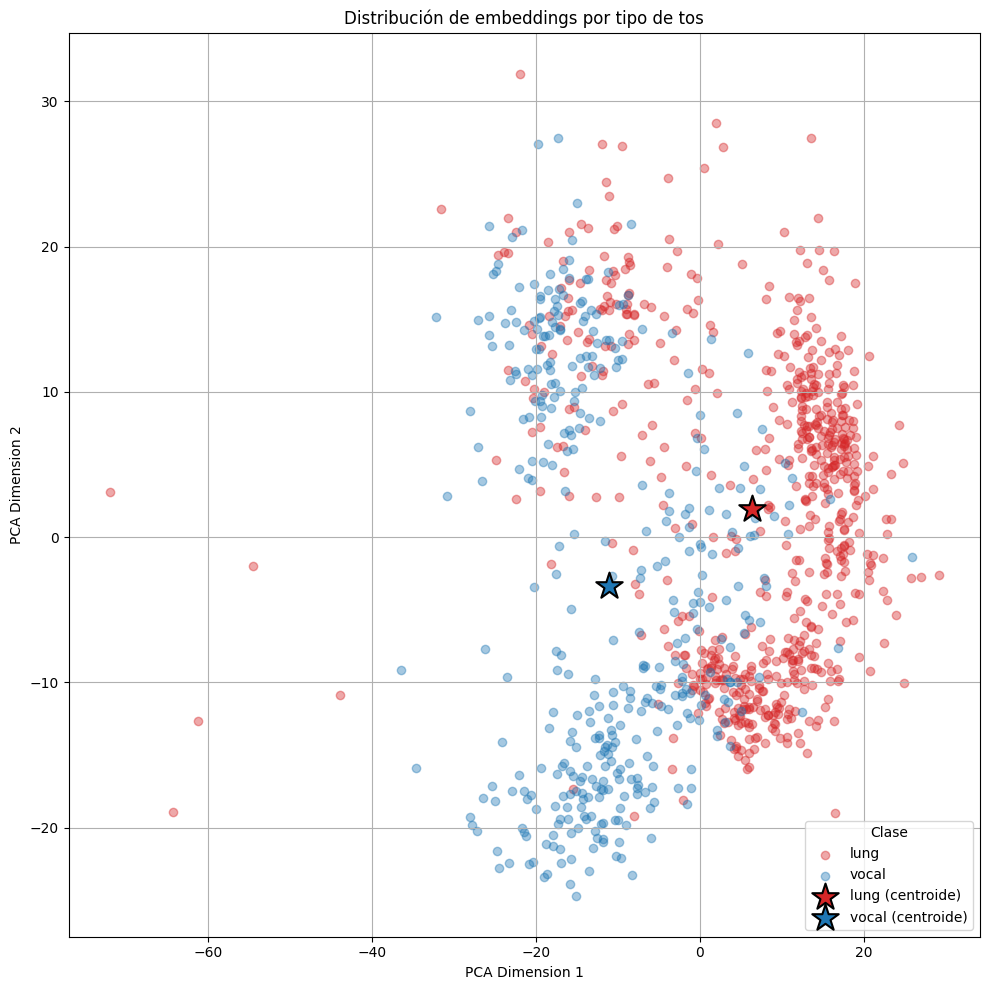

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asegurar formato correcto: vector promedio por archivo
train_embeddings_avg = [np.mean(embed, axis=0) for embed in train_embeddings]
train_embeddings_avg = np.array(train_embeddings_avg)

# PCA sobre vectores promedio
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(train_embeddings_avg)

# Crear DataFrame con coordenadas PCA y etiquetas
df = pd.DataFrame(pca_embeddings, columns=["x", "y"])
df["label"] = train_labels  # Asegúrate de que train_labels esté alineado con train_embeddings

# Mapa de colores por clase
label_colors = {
    "vocal": "tab:blue",
    "lung": "tab:red"
}

# Dibujar puntos por clase
plt.figure(figsize=(10, 10))
for label, group in df.groupby("label"):
    plt.scatter(group["x"], group["y"], color=label_colors.get(label, "gray"), label=label, alpha=0.4)

# Calcular y dibujar centroides por clase
centroids = df.groupby("label")[["x", "y"]].mean()
for label, row in centroids.iterrows():
    plt.scatter(row["x"], row["y"], marker="*", s=400,
                color=label_colors.get(label, "gray"),
                edgecolors="black", linewidths=1.5, label=f"{label} (centroide)")

# Formato del gráfico
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("Distribución de embeddings por tipo de tos")
plt.legend(title="Clase", loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# @title Train and Save Multi-class Cough Type Classifiers ("lung", "vocal")
%%time
import os
import joblib
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Convert categorical cough labels
cough_labels = []
valid_files = []

# Match training files with their corresponding labels
for file_name in train_file_names:
    if file_name in file_cough_labels:
        label = file_cough_labels[file_name]
        cough_labels.append(label)
        valid_files.append(file_name)
    else:
        print(f"Warning: No label found for '{file_name}'. Skipping.")

# Filter embeddings that match valid labeled files
filtered_embeddings = [train_embeddings[train_file_names.index(f)] for f in valid_files]

# ✅ Convertir a vectores promedio por archivo
filtered_embeddings_avg = [np.mean(embed, axis=0) for embed in filtered_embeddings]
filtered_embeddings_avg = np.array(filtered_embeddings_avg)

# Create output directory to save models
os.makedirs("results/saved_models_multiclass", exist_ok=True)

# ✅ Define models to train (con probabilidad donde aplica)
models = {
    "Support Vector Machine (linear)": SVC(kernel='linear', probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),  # ya da probabilidad
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=128),  # ya da
    "Random Forest": RandomForestClassifier(n_estimators=128),  # ya da
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000),  # ya da
}

# Train and save models
cough_models = {}
for name, model in models.items():
    print(f"🔄 Entrenando: {name}")
    model.fit(filtered_embeddings_avg, cough_labels)
    cough_models[name] = model

    # Save model to disk
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").lower()
    joblib.dump(model, f"results/saved_models_multiclass/{safe_name}.joblib")

    print(f"✅ Finished training and saved: {name}")

🔄 Entrenando: Support Vector Machine (linear)
✅ Finished training and saved: Support Vector Machine (linear)
🔄 Entrenando: Logistic Regression
✅ Finished training and saved: Logistic Regression
🔄 Entrenando: Gradient Boosting
✅ Finished training and saved: Gradient Boosting
🔄 Entrenando: Random Forest
✅ Finished training and saved: Random Forest
🔄 Entrenando: MLP Classifier
✅ Finished training and saved: MLP Classifier
CPU times: user 55.9 s, sys: 170 ms, total: 56.1 s
Wall time: 45.7 s


In [ ]:
print(f"Total de archivos en test_file_names: {len(test_file_names)}")
print(test_file_names[:5])  # muestra los primeros 5

Total de archivos en test_file_names: 1296
['20220125112846_DAKP%20fe_vocal.webm', '20220125112846_DAKP%20fe_vocal.webm', '20220125112846_DAKP%20fe_vocal.webm', '20220125112846_DAKP%20fe_vocal.webm', '20230420094226_GCH%20fe-1_lungback.webm']


In [ ]:
from collections import Counter
import numpy as np

# Seleccionar archivo de prueba
target_file = '20220125112846_DAKP%20fe_vocal.webm'
assert target_file in test_file_names, f"'{target_file}' no está en test_file_names."

# Agrupar los embeddings por archivo
file_to_embeddings = {}
for embedding, name in zip(test_embeddings, test_file_names):
    file_to_embeddings.setdefault(name, []).append(embedding)

# Convertir embeddings del archivo objetivo
target_embeddings = np.array(file_to_embeddings[target_file])
print(f"\n🎯 Clasificando {len(target_embeddings)} embeddings del archivo: {target_file} usando {len(cough_models)} modelos...\n")

# Clasificación con cada modelo
for model_name, model in cough_models.items():
    print(f"🔎 Modelo: {model_name}")

    # Predicciones por clip
    predictions = model.predict(target_embeddings)
    label_counts = Counter(predictions)
    most_common_label, count = label_counts.most_common(1)[0]

    for label, c in label_counts.items():
        print(f"  • {label}: {c} segmento(s)")

    print(f"  ✅ Dominante: {most_common_label} ({count}/{len(predictions)})")

    # Mostrar probabilidades si es posible
    if hasattr(model, "predict_proba"):
        class_idx = list(model.classes_).index(most_common_label)
        probs = model.predict_proba(target_embeddings)[:, class_idx]
        mean_prob = np.mean(probs)
        print(f"  📊 Confianza promedio para '{most_common_label}': {mean_prob:.2f}")
    else:
        print("  ⚠️ Este modelo no soporta predict_proba()")

    print("-" * 50)


🎯 Clasificando 4 embeddings del archivo: 20220125112846_DAKP%20fe_vocal.webm usando 5 modelos...

🔎 Modelo: Support Vector Machine (linear)
  • vocal: 4 segmento(s)
  ✅ Dominante: vocal (4/4)
  📊 Confianza promedio para 'vocal': 0.99
--------------------------------------------------
🔎 Modelo: Logistic Regression
  • vocal: 4 segmento(s)
  ✅ Dominante: vocal (4/4)
  📊 Confianza promedio para 'vocal': 1.00
--------------------------------------------------
🔎 Modelo: Gradient Boosting
  • vocal: 4 segmento(s)
  ✅ Dominante: vocal (4/4)
  📊 Confianza promedio para 'vocal': 1.00
--------------------------------------------------
🔎 Modelo: Random Forest
  • vocal: 4 segmento(s)
  ✅ Dominante: vocal (4/4)
  📊 Confianza promedio para 'vocal': 0.91
--------------------------------------------------
🔎 Modelo: MLP Classifier
  • vocal: 4 segmento(s)
  ✅ Dominante: vocal (4/4)
  📊 Confianza promedio para 'vocal': 1.00
--------------------------------------------------


# Evaluate calibrated multi-class classifiers on the test set using majority vote
For each test audio file:
- Group its segment-level embeddings
- Predict labels using each model for every segment
- Assign a final label via majority vote
- Compare predictions to ground-truth labels

Outputs include:
- Classification report (precision, recall, f1-score)
- Confusion matrix
- Sensitivity, specificity, and accuracy (per class and overall)
- Misclassified file list for error analysis

In [ ]:
from collections import defaultdict, Counter
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score)
import numpy as np

# Agrupar embeddings por archivo
file_to_embeddings = defaultdict(list)
for embedding, name in zip(test_embeddings, test_file_names):
    file_to_embeddings[name].append(embedding)

file_to_label = {fname: file_cough_labels[fname] for fname in test_file_names}

true_labels = []
model_predictions = defaultdict(list)

print(f"Evaluando {len(file_to_embeddings)} archivos de test con {len(cough_models)} modelos...\n")

# Clasificación por archivo (mayoría de votos)
for file_name, embeddings in file_to_embeddings.items():
    X = np.array(embeddings)
    true_label = file_to_label[file_name]
    true_labels.append(true_label)

    for model_name, cough_model in cough_models.items():
        preds = cough_model.predict(X)
        majority = Counter(preds).most_common(1)[0][0]
        model_predictions[model_name].append(majority)

# Métricas y errores
for model_name, predictions in model_predictions.items():
    print(f"\n=== Reporte para {model_name} ===")
    print(classification_report(true_labels, predictions, zero_division=0))

    labels = sorted(set(true_labels + predictions))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    # Sensibilidad, especificidad y accuracy
    TP = np.diag(cm)
    FN = np.sum(cm, axis=1) - TP
    FP = np.sum(cm, axis=0) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    sensitivity = TP / (TP + FN + 1e-10)
    specificity = TN / (TN + FP + 1e-10)
    accuracy = accuracy_score(true_labels, predictions)

    print("\nMetrics per class:")
    for i, label in enumerate(labels):
        print(f"  Clase '{label}': Sensitivity (Recall): {sensitivity[i]:.2f}, Specificity: {specificity[i]:.2f}")
    print(f"  Overall Accuracy: {accuracy:.2f}")

    # Guardar misclassifications
    print(f"[Errores - {model_name}]")
    for fname, y_true, y_pred in zip(file_to_embeddings.keys(), true_labels, predictions):
        if y_true != y_pred:
            print(f"  {fname} | real: {y_true} → pred: {y_pred}")

Evaluando 211 archivos de test con 5 modelos...


=== Reporte para Support Vector Machine (linear) ===
              precision    recall  f1-score   support

        lung       0.99      0.99      0.99       134
       vocal       0.97      0.99      0.98        77

    accuracy                           0.99       211
   macro avg       0.98      0.99      0.98       211
weighted avg       0.99      0.99      0.99       211


Metrics per class:
  Clase 'lung': Sensitivity (Recall): 0.99, Specificity: 0.99
  Clase 'vocal': Sensitivity (Recall): 0.99, Specificity: 0.99
  Overall Accuracy: 0.99
[Errores - Support Vector Machine (linear)]
  20220111120259_RARN_lungfront.webm | real: lung → pred: vocal
  20220108152718_PMAD_lungfront.webm | real: lung → pred: vocal
  20220107134757_OCAD_vocal.webm | real: vocal → pred: lung

=== Reporte para Logistic Regression ===
              precision    recall  f1-score   support

        lung       0.99      0.99      0.99       134
       vocal     

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import defaultdict, Counter

# Crear tabla de métricas
rows = []
for model_name, predictions in model_predictions.items():
    labels = sorted(set(true_labels + predictions))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    TP = np.diag(cm)
    FN = np.sum(cm, axis=1) - TP
    FP = np.sum(cm, axis=0) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    sensitivity = TP / (TP + FN + 1e-10)
    specificity = TN / (TN + FP + 1e-10)
    accuracy = accuracy_score(true_labels, predictions)

    for i, label in enumerate(labels):
        rows.append({
            "Modelo": model_name,
            "Clase": label,
            "Recall (Sensibilidad)": round(sensitivity[i], 2),
            "Specificity": round(specificity[i], 2),
            "Accuracy Global": round(accuracy, 2)
        })

# Mostrar como tabla con estilo (funciona en Colab)
df_metrics = pd.DataFrame(rows)
df_metrics.style.background_gradient(
    subset=["Recall (Sensibilidad)", "Specificity", "Accuracy Global"],
    cmap="YlGn"
).format(precision=2)

,Modelo,Clase,Recall (Sensibilidad),Specificity,Accuracy Global
0,Support Vector Machine (linear),lung,0.99,0.99,0.99
1,Support Vector Machine (linear),vocal,0.99,0.99,0.99
2,Logistic Regression,lung,0.99,0.99,0.99
3,Logistic Regression,vocal,0.99,0.99,0.99
4,Gradient Boosting,lung,0.99,0.92,0.96
5,Gradient Boosting,vocal,0.92,0.99,0.96
6,Random Forest,lung,0.97,0.92,0.95
7,Random Forest,vocal,0.92,0.97,0.95
8,MLP Classifier,lung,0.98,0.90,0.95
9,MLP Classifier,vocal,0.90,0.98,0.95


In [ ]:
# Verificar valor de true_labels
print(len( ))

211


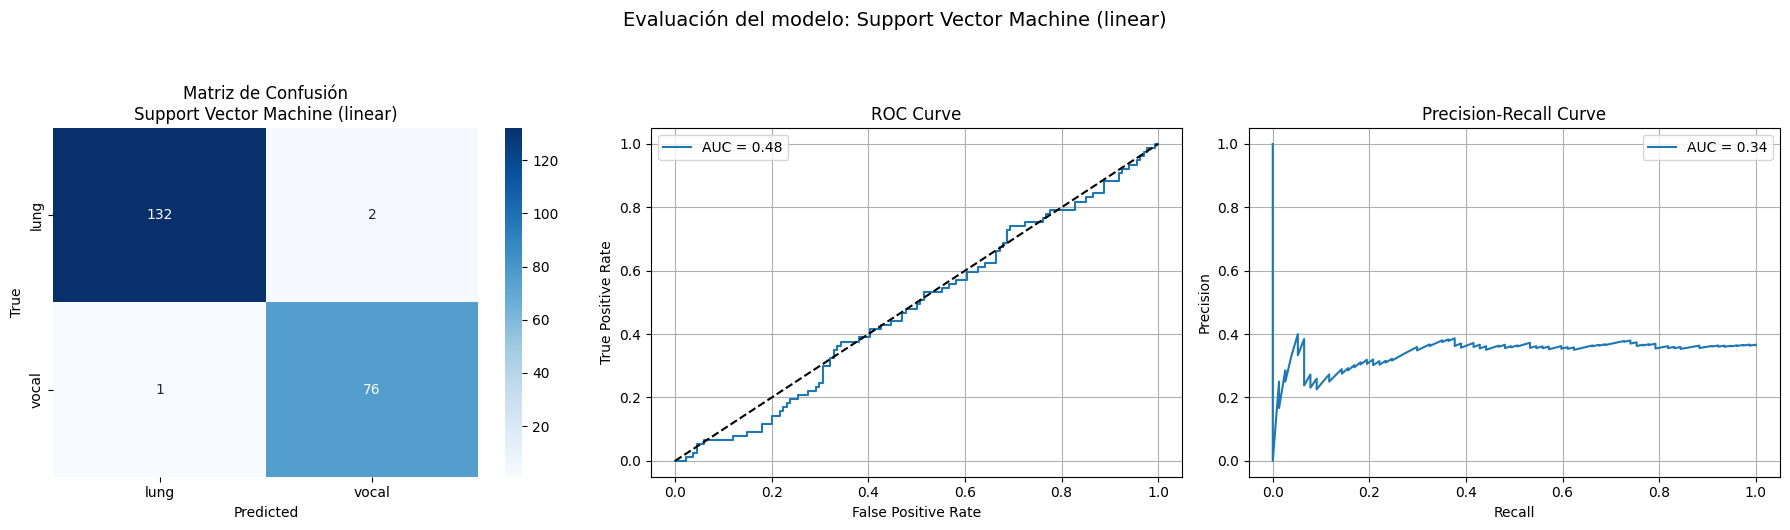

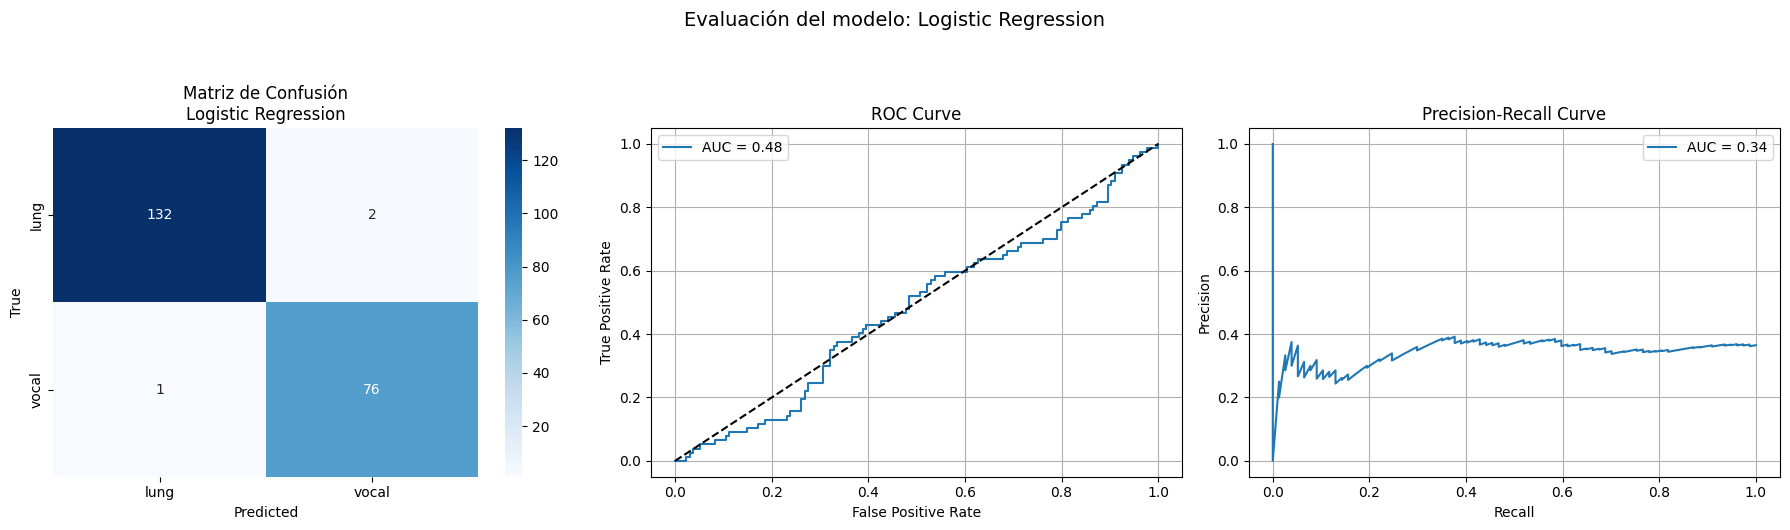

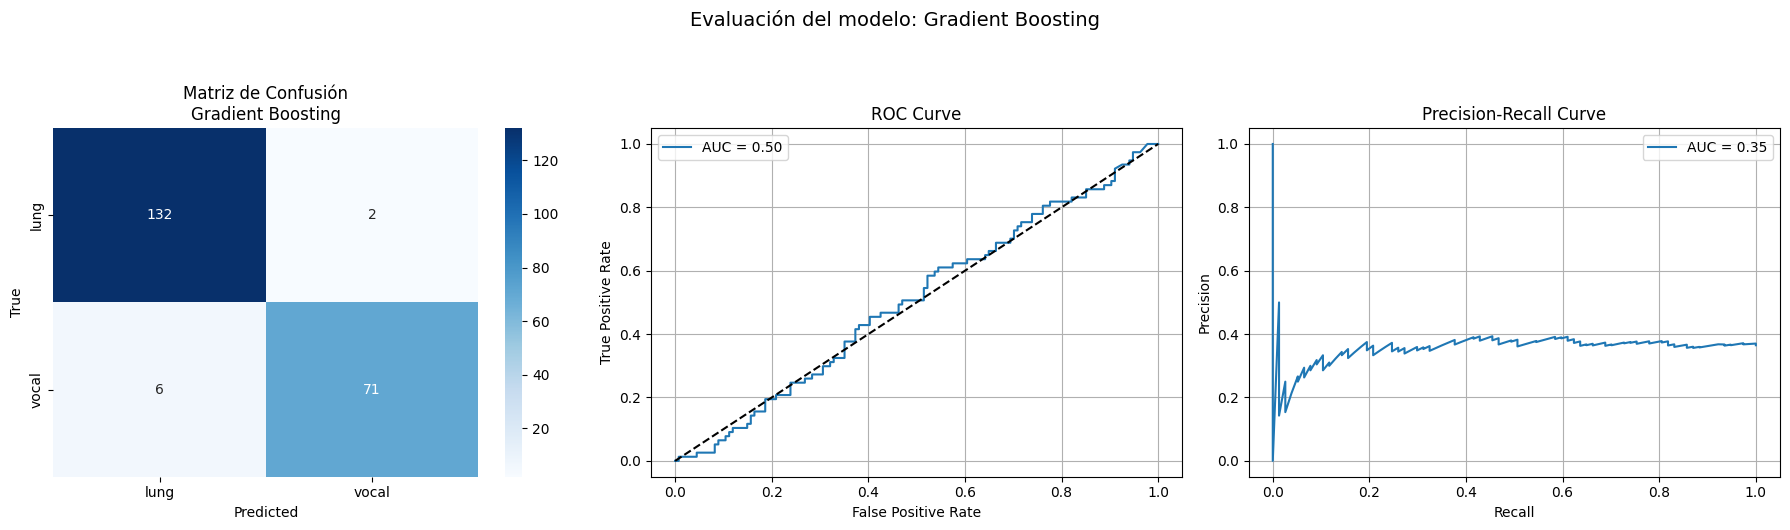

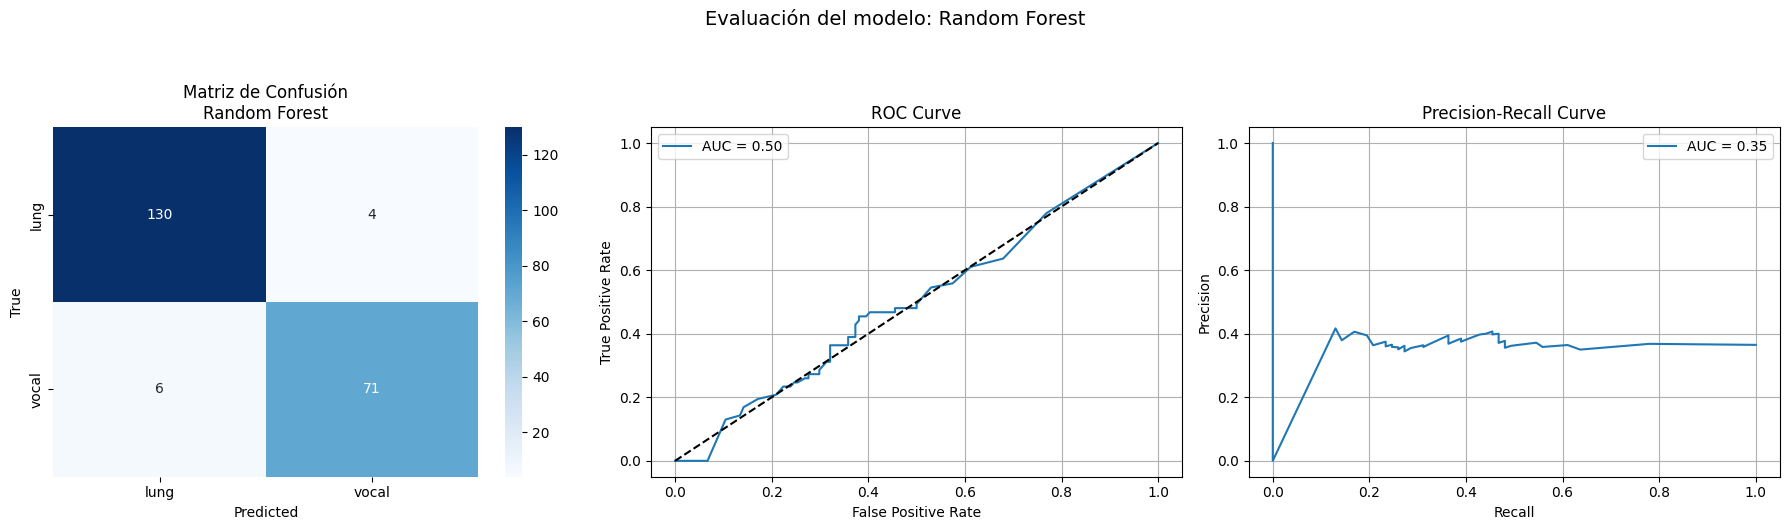

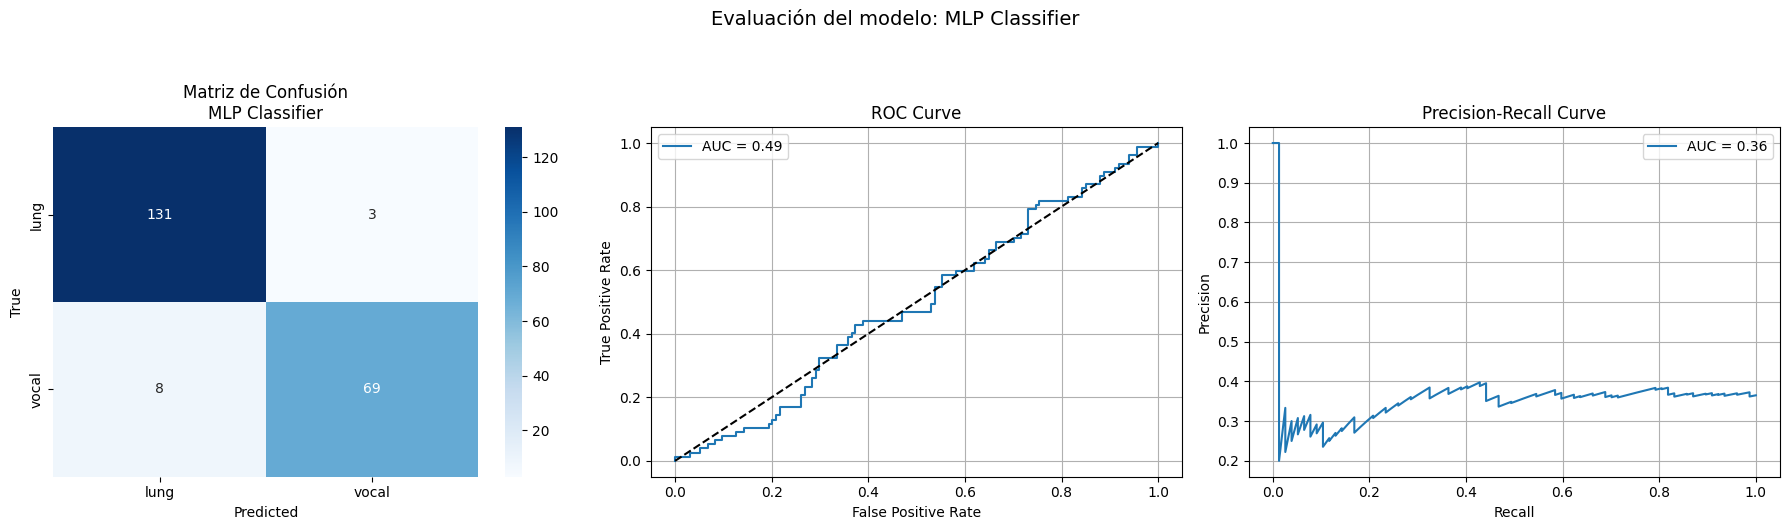

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

for model_name, predictions in model_predictions.items():
    model = cough_models[model_name]  # ✅ Access the trained model
    labels = sorted(set(true_labels + predictions))
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    # Skip if not binary classification
    if len(labels) != 2:
        print(f"🔶 {model_name}: solo matriz de confusión (no binario)")
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"Matriz de Confusión\n{model_name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        plt.tight_layout()
        plt.show()
        continue

    # Binarize ground truth
    y_true_bin = label_binarize(true_labels, classes=labels).ravel()

    # Predict probabilities if available
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(test_embeddings_avg)
        class_idx = list(model.classes_).index(labels[1])  # Take index of positive class
        y_score = probs[:, class_idx]
    else:
        print(f"⚠️ {model_name} no soporta predict_proba, usando predicciones binarias.")
        y_pred_bin = label_binarize(predictions, classes=labels).ravel()
        y_score = y_pred_bin  # Fallback (step curve)

    # Compute ROC and PRC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    precision, recall, _ = precision_recall_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)
    prc_auc = auc(recall, precision)

    # Plot: Confusion Matrix + ROC + PRC
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_title(f"Matriz de Confusión\n{model_name}")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("True")

    axs[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axs[1].plot([0, 1], [0, 1], 'k--')
    axs[1].set_title("ROC Curve")
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
    axs[2].set_title("Precision-Recall Curve")
    axs[2].set_xlabel("Recall")
    axs[2].set_ylabel("Precision")
    axs[2].legend()
    axs[2].grid(True)

    plt.suptitle(f"Evaluación del modelo: {model_name}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

The confusion matrix shows the number of correct and incorrect predictions made by the classifier.  
- Rows represent the actual class (`True`), columns represent the predicted class.  
- A perfect classifier would have all values on the diagonal.  
- Misclassifications appear off-diagonal.

The ROC (Receiver Operating Characteristic) curve evaluates the model's ability to distinguish between classes.  
- It plots the True Positive Rate (Sensitivity) against the False Positive Rate.  
- The closer the curve follows the top-left corner, the better the model.  
- AUC (Area Under the Curve) values closer to 1 indicate stronger performance.

The Precision-Recall Curve focuses on performance for the positive class.  
- It is particularly useful for imbalanced datasets.  
- High precision means few false positives; high recall means few false negatives.  
- The AUC score reflects the balance between precision and recall across thresholds.

# **Models**
  ## **MLP Classifier**

### 1. **Confusion Matrix**
  * Correctly predicted: 131 lung samples, 69 vocal samples
  * Misclassified: 3 lung → vocal, 8 vocal → lung
  * Total accuracy appears reasonable, but some vocal misclassifications occur.

### 2. **ROC Curve**
  * AUC = 0.49
  * The model performs nearly at random (AUC ≈ 0.5), suggesting poor probabilistic discrimination between classes.

### 3. **Precision-Recall Curve**
  * AUC = 0.36
  * Indicates low precision across the recall spectrum. The model struggles especially in minority confidence regions.


  ## **Random Forest**

  ### 1. **Confusion Matrix**
  * Correctly predicted: 130 lung, 71 vocal
  * Misclassified: 4 lung → vocal, 6 vocal → lung
  * Balanced performance, with a slight improvement on vocal class over MLP.

### 2. **ROC Curve**
  * AUC = 0.50
  * Class probability estimates are not better than chance.

### 3. **Precision-Recall Curve**
  * AUC = 0.35
  * Precision remains low across all recall levels, suggesting weak model confidence.


  ## **Support Vector Machine (linear)**

### **1. Confusion Matrix**
  * Correctly predicted: 132 lung, 76 vocal
  * Misclassified: 2 lung → vocal, 1 vocal → lung
  * This is the strongest confusion matrix, with near-perfect predictions.

### **2. ROC Curve**
  * AUC = 0.48
  * However, the low AUC shows poor calibration of predicted probabilities.

### **3. Precision-Recall Curve**
  * AUC = 0.34
  * Despite the matrix, confidence levels are not reliable; the model predicts sharply but does not assign probabilities well.


  ## **Logistic Regression**
  
  ### **1. Confusion Matrix**
  * Same prediction as SVM: 132 lung, 76 vocal,
  * Misclassified: 2 lung → vocal, 1 vocal → lung
  * High classification accuracy, consistent with SVM.

### **2. ROC Curve**
  * AUC = 0.48
  * Poor discrimination in probability space.

### **3. Precision-Recall Curve**
  * AUC = 0.34
  * Confidence distributions mirror those of SVM: accurate predictions but low probability quality.


  ## **Gradient Boosting**

### **1. Confusion Matrix**
  * Correctly predicted: 132 lung, 71 vocal
  * Misclassified: 2 lung → vocal, 6 vocal → lung
  * Slightly underperforms compared to SVM/LR in vocal class recall.

### **2. ROC Curve**
  * AUC = 0.50
  * No probabilistic advantage, suggesting poor generalization from boosting.

### **3. Precision-Recall Curve**
  * AUC = 0.35
  * Shows the same trend: low confidence spread, though classification itself remains solid.

**Conclusion**  
This notebook trains, evaluates, and compares multiple classifiers on pulmonary sound embeddings, distinguishing between `lung` and `vocal` coughs. The pipeline includes data loading, train/test split, model training, prediction, and performance analysis using confusion matrices, ROC and PRC curves, and per-class metrics.  

Probability calibration was explored but deliberately excluded from this version. It is recommended as a next step to fine-tune decision thresholds and improve model interpretability for deployment scenarios.